In [1]:
import pickle
import os
import sys
import glob
# import torch
import numpy as np
import pandas as pd
import scipy.io
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from scipy import signal
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from statistics import mean
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact
from scipy.stats import ranksums
from scipy.stats import pearsonr
from tqdm import tqdm
import plotly.express as px

# jupyter notebook display setting for all data structures
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
np.set_printoptions(threshold=np.inf)

In [2]:
# define the path to the data directory
data_file = '/project2/xinhe/waqaas/DNA-breathing/data/Chipseq_data/seq_breathing_feat.pkl'
with open(data_file, 'rb') as f:
    panset = pickle.load(f)

In [3]:
for part in panset.keys():
    partition = panset[part]
    for seq_id in partition.keys():
        sample = partition[seq_id]
        # remove the first 150 and last 150 bp from seq, coord, coord_sq, flip
        sample['seq'] = sample['seq'][150:-150]
        sample['coord'] = sample['coord'][150:-150]
        sample['coord_sq'] = sample['coord_sq'][150:-150]
        sample['flip'] = sample['flip'][150:-150]

#panset_df = pd.DataFrame(columns=['seq_id', 'seq', 'coord', 'coord_sq', 'flip', 'label'])

flat_data = []
for part in panset.keys():
    for seq_id, data in panset[part].items():
        row = {'part': part, 'seq_id': seq_id, **data}
        flat_data.append(row)

# Convert to DataFrame
df = pd.DataFrame(flat_data)

# del column part
del df['part']

# put seq_id as index
df.set_index('seq_id', inplace=True)

In [4]:
# make seq_id astype str
#df['seq_id'] = df['seq_id'].astype(str)

# unique indices count
print(len(df.index.unique()))

886625


# motif_seq Determination

In [5]:
# find the fimo results in chipseq_results/{tf}/{matrix_id}/fimo_out/fimo.tsv and create a dictionary of dataframes
fimo_dir = '/project2/xinhe/waqaas/DNA-breathing/src/fasta/chipseq_results'
fimo_dict = {}
for tf in os.listdir(fimo_dir):
    fimo_dict[tf] = {}
    for matrix_id in os.listdir(os.path.join(fimo_dir, tf)):
        fimo_dict[tf][matrix_id] = {}
        fimo_file = os.path.join(fimo_dir, tf, matrix_id, 'fimo_out', 'fimo.tsv')
        fimo_dict[tf][matrix_id] = pd.read_csv(fimo_file, sep='\t')

In [6]:
# drop NA values for all dataframes in fimo_dict
for tf in fimo_dict.keys():
    for matrix_id in fimo_dict[tf].keys():
        fimo_dict[tf][matrix_id].dropna(inplace=True)
# turn all the start, stop, sequence_name values in the fimo output dictionary for max into int values using as type int
for tf in fimo_dict.keys():
    for matrix_id in fimo_dict[tf].keys():
        fimo_dict[tf][matrix_id]['sequence_name'] = fimo_dict[tf][matrix_id]['sequence_name'].astype(int)
        fimo_dict[tf][matrix_id]['start'] = fimo_dict[tf][matrix_id]['start'].astype(int)
        fimo_dict[tf][matrix_id]['stop'] = fimo_dict[tf][matrix_id]['stop'].astype(int)
# turn all the sequence_name values in the fimo output dictionary for max into str values using as type str
for tf in fimo_dict.keys():
    for matrix_id in fimo_dict[tf].keys():
        fimo_dict[tf][matrix_id].index = fimo_dict[tf][matrix_id].index.astype(str)
        # sort by sequence_name
        fimo_dict[tf][matrix_id].sort_values(by=['sequence_name'], inplace=True)
        # turn sequence_name into index
        #fimo_dict[tf][matrix_id].set_index('sequence_name', inplace=True)

In [7]:
# preview the data's first ten rows
fimo_dict['ATF3']['MA0605.2'].head(10)

motif_id motif_alt_id  sequence_name  start  stop strand     score  \
186132  MA0605.2         ATF3           2849     52    63      + -10.85110   
174887  MA0605.2         ATF3           2849     52    63      - -10.19150   
1011    MA0605.2         ATF3           3570     90   101      -  16.08510   
910     MA0605.2         ATF3           3570     65    76      +  16.61700   
914     MA0605.2         ATF3           3570     65    76      -  16.61700   
1010    MA0605.2         ATF3           3570     90   101      +  16.08510   
122036  MA0605.2         ATF3           3571      1    12      +  -8.31915   
83400   MA0605.2         ATF3           3575     67    78      +  -6.76596   
79686   MA0605.2         ATF3           3575     67    78      -  -6.44681   
30252   MA0605.2         ATF3           3701    155   166      -   2.89362   

         p-value  q-value matched_sequence  
186132  0.000721    1.000     TGTGATTTCACT  
174887  0.000685    1.000     AGTGAAATCACA  
1011    0.000004    0.908     TGTGACGTCACA  
910     0.000003    0.908     TGTGACGTCACG  
914     0.000003    0.908     CGTGACGTCACA  
1010    0.000004    0.908     TGTGACGTCACA  
122036  0.000481    1.000     CGGGATGTAACC  
83400   0.000319    1.000     GATTATATAAGC  
79686   0.000304    1.000     GCTTATATAATC  
30252   0.000089    0.989     GCTGATGTAACT

In [8]:
original = "CGTGACGTCACA"
complement = original.translate(str.maketrans('ACGT', 'TGCA'))
reverse_complement = complement[::-1]
print(reverse_complement)

TGTGACGTCACG


In [9]:
location = '/scratch/midway3/waqaas/DNA-breathing/'
old_location = '/project2/xinhe/waqaas/DNA-breathing/'
# define path to the TF index
tf_index_file = f'{location}data/Chipseq_data/group_index.pkl'
max_index_file = f'{location}data/Chipseq_data/max_index_for_tfs.pkl'
# load the indexes
with open(tf_index_file, 'rb') as handle:
    group_index = pickle.load(handle)
with open(max_index_file, 'rb') as handle:
    max_index = pickle.load(handle)

## Skippable

In [10]:
for tf in tqdm(fimo_dict.keys(), desc='Processing transcription factors'):
    for matrix_id in tqdm(fimo_dict[tf].keys(), desc=f'Processing matrix ids for {tf}'):
        df_motif = fimo_dict[tf][matrix_id].copy()
        # create 'coord', 'coord_sq', 'flip' and 'label' columns in fimo_dict[tf][matrix_id]
        fimo_dict[tf][matrix_id][["coord","coord_sq","flip","label"]] = None
        # take the df corresponding to fimo_dict['tf']['matrix_id'] and iterate over the rows
        for row in df_motif.itertuples():
            # get the index
            index = row.Index
            # get the sequence name
            seq_id = str(row.sequence_name)
            # get the strand
            strand = row.strand
            # get the start and stop
            start = int(row.start)
            stop = int(row.stop)
            # if strand is positive
            if strand == '+':
                # get the coord, coord_sq and flip values from the start to stop indices and add them to the fimo_dict dataframe
                coord = df.at[seq_id, 'coord']
                fimo_dict[tf][matrix_id].at[index, 'coord'] = coord[start:stop]
                coord_sq = df.at[seq_id, 'coord_sq']
                fimo_dict[tf][matrix_id].at[index, 'coord_sq'] = coord_sq[start:stop]
                flip = df.at[seq_id, 'flip']
                fimo_dict[tf][matrix_id].at[index, 'flip'] = flip[start:stop]
            # if strand is negative
            elif strand == '-':
                # get the coord, coord_sq and flip values from the start to stop indices and add them to the fimo_dict dataframe
                coord = df.at[seq_id, 'coord']
                fimo_dict[tf][matrix_id].at[index, 'coord'] = coord[start:stop][::-1]
                coord_sq = df.at[seq_id, 'coord_sq']
                fimo_dict[tf][matrix_id].at[index, 'coord_sq'] = coord_sq[start:stop][::-1]
                flip = df.at[seq_id, 'flip']
                fimo_dict[tf][matrix_id].at[index, 'flip'] = flip[start:stop][::-1]
            # the key in group index is the tf and the value is a list of indices in the label column of df that correspond to the tf
            # take the list of indices in the label column of df that correspond to the tf indices in group_index and add this list to the fimo_dict dataframe
            indices = max_index[tf]
            label = df.at[seq_id, 'label'][indices]
            fimo_dict[tf][matrix_id].at[index, 'label'] = label
    #         break
    #     break
    # break

Processing transcription factors:   5%|▍         | 2/44 [00:39<13:52, 19.81s/it]


KeyboardInterrupt: 

In [ ]:
# save the fimo_dict as a pickle file
with open('/project2/xinhe/waqaas/DNA-breathing/data/Chipseq_data/fimo_dict.pkl', 'wb') as f:
    pickle.dump(fimo_dict, f)
with open('/scratch/midway3/waqaas/DNA-breathing/data/Chipseq_data/fimo_dict.pkl', 'wb') as f:
    pickle.dump(fimo_dict, f)

# Checkpoint

In [11]:
# load the fimo_dict from /project2/xinhe/waqaas/DNA-breathing/data/Chipseq_data/fimo_dict.pkl
with open('/scratch/midway3/waqaas/DNA-breathing/data/Chipseq_data/fimo_dict.pkl', 'rb') as f:
    fimo_dict = pickle.load(f)

In [12]:
# Convert df['label'] to a 3D numpy array where each page is labels for a tf
labels_array = np.array(df['label'].tolist())  # Convert to 2D array first

max_index_for_tfs = {}

for tf in tqdm(group_index.keys()):
    indices = group_index[tf]
    # Select the relevant indices for each tf and sum along the rows
    sums = labels_array[:, indices].sum(axis=0)
    counts = {index:sum for (index, sum) in zip(indices, sums)}
    max_index = sums.argmax()
    print(f'{tf}:{max_index}= {counts}')
    max_index_for_tfs[tf] = indices[max_index]
    print(max_index_for_tfs[tf])

 16%|█▌        | 10/64 [00:00<00:00, 90.15it/s]

HNF4A:0= {85: 19826}
85
JUND:1= {60: 8156, 86: 21221}
86
NFYB:0= {22: 19280, 63: 9292}
22
FOXA1:0= {82: 53318, 128: 41606}
82
SP1:0= {31: 20871}
31
EBF1:0= {14: 42988}
14
TAF1:2= {3: 16463, 71: 22080, 92: 22303}
92
BCL3:0= {10: 20776}
10
CHD2:0= {56: 29170}
56
ELF1:0= {16: 27775, 79: 17994, 105: 27221}
16
POLR2A:1= {1: 41992, 25: 65533, 38: 25334, 41: 33020, 64: 44062, 88: 29692, 98: 34013, 114: 24330}
25
BRCA1:0= {54: 10018}
54
ZNF143:0= {76: 7697}
76
BHLHE40:0= {12: 18507}
12
FOSL1:0= {107: 9657}
107
NR2F2:0= {112: 25490}
112
GABPA:3= {19: 7121, 59: 6631, 84: 12001, 108: 16170}
108
THAP1:0= {122: 3808}
122


 45%|████▌     | 29/64 [00:00<00:00, 87.29it/s]

GATA3:1= {127: 12889, 129: 46530}
129
BATF:0= {8: 29163}
8
BCLAF1:0= {11: 10399, 101: 6884}
11
IRF4:0= {20: 22859}
20
RAD21:1= {27: 27420, 48: 49801, 66: 36656, 89: 35209, 99: 31852, 115: 22980}
48
TCF7L2:0= {73: 6791}
73
REST:3= {28: 8707, 49: 12876, 67: 10062, 116: 14275}
116
TBP:0= {72: 28152}
72
E2F6:0= {103: 26766}
103
RUNX3:0= {29: 84913}
29
SPI1:1= {32: 43040, 40: 45251, 118: 22553}
40
TAF7:0= {120: 4710}
120
USF2:0= {75: 13887}
75
SMC3:0= {69: 38443}
69
PBX3:0= {24: 8402}
24
POU2F2:0= {26: 27074, 39: 18506}
26
BCL11A:0= {9: 19642}
9
EP300:2= {0: 34720, 17: 5848, 58: 36078, 80: 34676}
58
ATF3:0= {100: 1345}
100
EGR1:1= {15: 14078, 104: 31747}
104
ETS1:1= {18: 3702, 106: 14122}
106


 78%|███████▊  | 50/64 [00:00<00:00, 76.53it/s]

MAX:3= {47: 14942, 62: 14942, 87: 15266, 110: 58358}
110
TRIM28:0= {123: 21017}
123
CEBPB:2= {55: 62498, 77: 14450, 95: 69979}
95
SIX5:0= {2: 7676, 30: 4099, 117: 3267}
2
TFAP2C:0= {74: 48159}
74
FOSL2:0= {81: 24122}
81
YY1:1= {4: 18864, 36: 37554, 42: 18764, 53: 23297, 94: 24787, 125: 26693}
36
FOXA2:0= {83: 43098}
83
USF1:1= {35: 9374, 52: 23206, 93: 16352, 124: 17590}
52
PML:0= {113: 29972}
113
CTCF:6= {5: 48792, 6: 49912, 7: 52589, 13: 43394, 43: 37505, 44: 74881, 45: 106130, 46: 65576, 57: 35753, 78: 39009, 96: 39920, 102: 39039}
45
TEAD4:1= {51: 20925, 121: 43252}
121
ZBTB33:0= {37: 2209}
37
MAFK:1= {61: 14149, 97: 43832}
97


100%|██████████| 64/64 [00:00<00:00, 89.61it/s]

PAX5:0= {23: 24817}
23
STAT3:0= {70: 20502}
70
PRDM1:0= {65: 5367}
65
GATA2:0= {109: 19153}
109
ZBTB7A:0= {126: 26635}
126
TCF12:0= {34: 20167}
34
SRF:0= {33: 7212, 50: 4593, 91: 3919}
33
RFX5:0= {68: 27110}
68
MEF2A:0= {21: 20471, 111: 4937}
21
SIN3AK20:0= {90: 26334}
90
STAT5A:0= {119: 13875}
119


In [ ]:
# # save max_index_for_tfs as a .pt file
# torch.save(max_index_for_tfs, '/project2/xinhe/waqaas/DNA-breathing/data/Chipseq_data/max_index_for_tfs.pt')
# # also save it in the scratch directory
# torch.save(max_index_for_tfs, '/scratch/midway3/waqaas/DNA-breathing/data/Chipseq_data/max_index_for_tfs.pt')

In [ ]:
# for tf in group_index.keys():
#     print(tf, max_index_for_tfs[tf])
#     print(group_index[tf])

In [ ]:
# # for each dictionary in fimo_dict that has a label where the length of the label is greater than 1, see which position has the most 1s overall, and then only keep that position
# for tf in tqdm(fimo_dict.keys(), desc='Processing transcription factors'):
#     for matrix_id in tqdm(fimo_dict[tf].keys(), desc=f'Processing matrix ids for {tf}'):
#         df_motif = fimo_dict[tf][matrix_id].copy()
#         if len(df_motif['label'].iloc[0]) > 1:
#             #
#             df_motif['label'] = df_motif['label'].apply(lambda x: x[group_index[tf].index(max_index_for_tfs[tf])])
#             df_motif['label'] = df_motif['label'].astype(int)
#             # update the fimo_dict dataframe
#             fimo_dict[tf][matrix_id] = df_motif

Processing transcription factors: 100%|██████████| 44/44 [00:07<00:00,  6.26it/s]


In [16]:
# for each dictionary in fimo_dict that has a label where the length of the label is greater than 1, see which position has the most 1s overall, and then only keep that position
for tf in tqdm(fimo_dict.keys(), desc='Processing transcription factors'):
    for matrix_id in tqdm(fimo_dict[tf].keys(), desc=f'Processing matrix ids for {tf}'):
        df_motif = fimo_dict[tf][matrix_id].copy()
        if len(df_motif['label'].iloc[0]) > 1:
            # print(tf)
            # print(df_motif['label'])
            #
            df_motif['label'] = df_motif['label'].apply(lambda x: x[group_index[tf].index(max_index_for_tfs[tf])])
            df_motif['label'] = df_motif['label'].astype(int)
            # update the fimo_dict dataframe
            fimo_dict[tf][matrix_id] = df_motif

Processing transcription factors: 100%|██████████| 44/44 [00:07<00:00,  6.22it/s]


In [ ]:
df.head()

seq  \
seq_id                                                      
81      CCCCTGAGCTAGCCATGCTCTGACAGTCTCAGTTGCACACACGAGC...   
146     TCTCGGTCAGGAACGGTCCCGGGCCTCCCGCCCGCCTCCCTCCAGC...   
147     CCGCCCGCGCCTCCGGGTCCTAACGCCGCCGCTCGCCCTCCACTGC...   
449     CAAAGTGCTAAGTATGGTAGATTGCAAACATAAGTGGCCACATAAT...   
1178    AGCTGACTCATGTTGGGGGCAGCCCACTCACAGTGGCCCTGACCCA...   

                                                    coord  \
seq_id                                                      
81      [0.157, 0.151, 0.1509, 0.154, 0.1974, 0.1612, ...   
146     [0.2238, 0.1714, 0.208, 0.1448, 0.139, 0.1544,...   
147     [0.1535, 0.131, 0.1242, 0.1308, 0.1372, 0.1257...   
449     [0.1735, 0.2203, 0.2314, 0.22, 0.163, 0.1958, ...   
1178    [0.1938, 0.1433, 0.1429, 0.1941, 0.1611, 0.210...   

                                                 coord_sq  \
seq_id                                                      
81      [0.1185, 0.1127, 0.1125, 0.1145, 0.1418, 0.122...   
146     [0.1728, 0.1373, 0.1551, 0.1037, 0.0981, 0.115...   
147     [0.1119, 0.0843, 0.0758, 0.0829, 0.09, 0.0762,...   
449     [0.143, 0.171, 0.1812, 0.1683, 0.1258, 0.1401,...   
1178    [0.1358, 0.0995, 0.0986, 0.1347, 0.1207, 0.157...   

                                                     flip  \
seq_id                                                      
81      [0.0615, 0.0579, 0.0577, 0.0592, 0.0698, 0.063...   
146     [0.0888, 0.0709, 0.0782, 0.0522, 0.0483, 0.059...   
147     [0.0601, 0.0436, 0.0382, 0.0438, 0.049, 0.0401...   
449     [0.0717, 0.0845, 0.0923, 0.0849, 0.0647, 0.068...   
1178    [0.0676, 0.0512, 0.051, 0.0675, 0.0639, 0.08, ...   

                                                    label  
seq_id                                                     
81      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
146     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
147     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
449     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1178    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [ ]:
df_motif.head()

motif_id motif_alt_id  sequence_name  start  stop strand     score  \
35838  MA0507.2       POU2F2           4060    173   186      -   7.17308   
6042   MA0507.2       POU2F2           4842    141   154      -  13.40380   
5220   MA0507.2       POU2F2           5012    126   139      -  13.94230   
23859  MA0507.2       POU2F2           5012    115   128      -   8.53846   
41639  MA0507.2       POU2F2           5012     93   106      -   6.61538   

        p-value  q-value matched_sequence  \
35838  0.000080    0.738   CATATGGAAAAGAG   
6042   0.000010    0.522   GTCATGCAAATGAG   
5220   0.000008    0.485   GCTATGCAAATGAT   
23859  0.000051    0.696   GATATGCAAACGAC   
41639  0.000095    0.754   ATTATGCAAAGAGC   

                                                   coord  \
35838  [0.1471, 0.2134, 0.2405, 0.2431, 0.2219, 0.166...   
6042   [0.1568, 0.2099, 0.1664, 0.21, 0.2046, 0.1467,...   
5220   [0.1501, 0.1527, 0.2206, 0.2337, 0.212, 0.1486...   
23859  [0.1813, 0.2417, 0.2521, 0.2442, 0.2154, 0.150...   
41639  [0.2662, 0.2625, 0.2613, 0.2482, 0.2177, 0.150...   

                                                coord_sq  \
35838  [0.1056, 0.1589, 0.1934, 0.1983, 0.1738, 0.136...   
6042   [0.1185, 0.1574, 0.1294, 0.1542, 0.1471, 0.105...   
5220   [0.1109, 0.1148, 0.1697, 0.1832, 0.1571, 0.108...   
23859  [0.1554, 0.2019, 0.2125, 0.2005, 0.1635, 0.111...   
41639  [0.2403, 0.2338, 0.2299, 0.2077, 0.1676, 0.113...   

                                                    flip  label  
35838  [0.0535, 0.08, 0.0999, 0.1012, 0.0854, 0.0668,...      0  
6042   [0.061, 0.0795, 0.067, 0.0778, 0.074, 0.0529, ...      1  
5220   [0.055, 0.0571, 0.0864, 0.0954, 0.0788, 0.0543...      1  
23859  [0.0766, 0.1006, 0.1072, 0.1024, 0.0811, 0.055...      1  
41639  [0.1158, 0.1125, 0.1128, 0.1046, 0.0826, 0.055...      1

In [17]:
flip_container = {}

for tf, matrix_id in zip(['MAFK', 'ZBTB7A'], ['MA0496.3', 'MA0750.2']):
    flip = []
    binding_affinity = []

    for row in fimo_dict[tf][matrix_id].itertuples():
        flip.append(mean(row.flip))
        binding_affinity.append(row.label)

    flip_container[tf] = {'flip': flip, 'binding_affinity': binding_affinity}

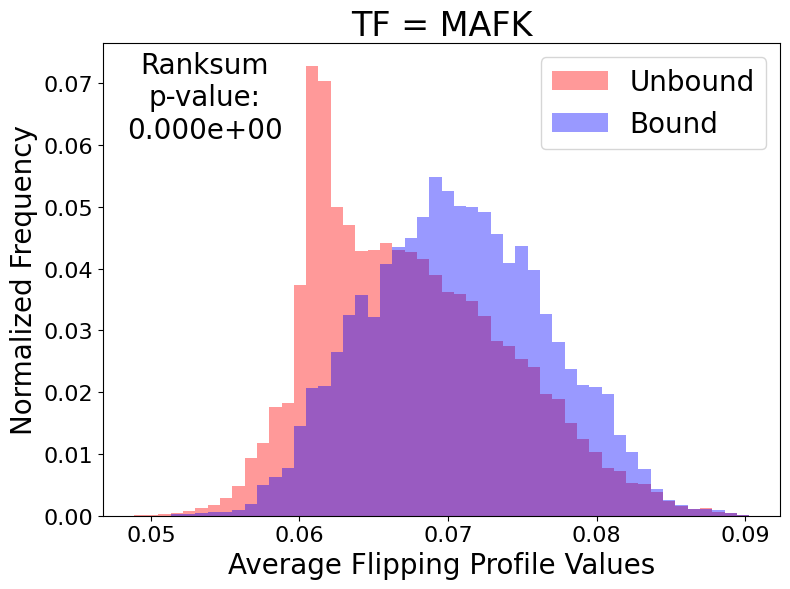

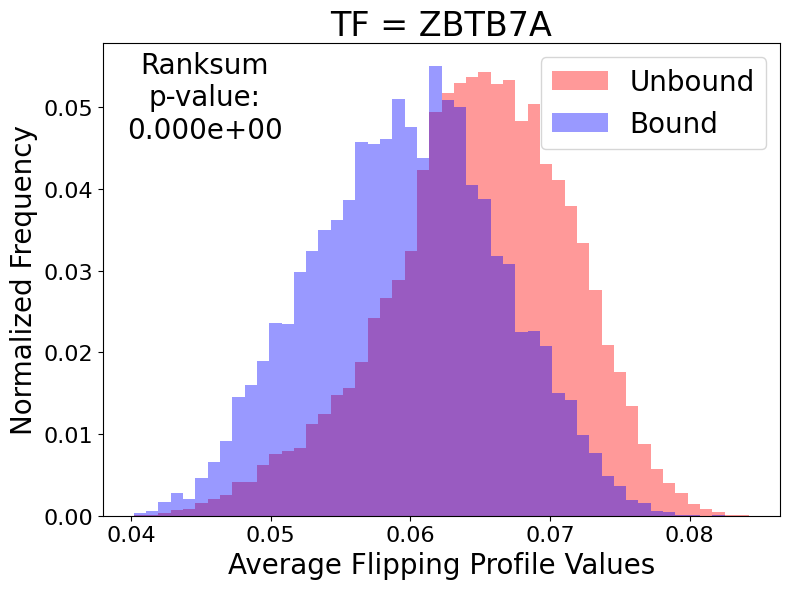

In [28]:
for tf in flip_container.keys():

    # Set font size factors
    a = 1.6
    title_fontsize = 24
    label_fontsize = 20
    tick_fontsize = 16  # Adjust tick font size

    label_flip_pos = [o for i, o in enumerate(flip_container[tf]['flip']) if flip_container[tf]['binding_affinity'][i] == 1]
    label_flip_neg = [o for i, o in enumerate(flip_container[tf]['flip']) if flip_container[tf]['binding_affinity'][i] == 0]

    # calculate ranksums    
    stat, p = ranksums(label_flip_pos, label_flip_neg)

    # Combine the data to calculate the shared bins
    combined_data = np.concatenate((label_flip_pos, label_flip_neg))

    # Calculate the combined histogram bins
    combined_counts, combined_bins = np.histogram(combined_data, bins=50)

    # Calculate histograms using the shared bins
    pos_counts, _ = np.histogram(label_flip_pos, bins=combined_bins)
    neg_counts, _ = np.histogram(label_flip_neg, bins=combined_bins)

    # Normalize the histograms
    pos_normalized = pos_counts / len(label_flip_pos)
    neg_normalized = neg_counts / len(label_flip_neg)

    # Plot the normalized histograms
    fig, ax = plt.subplots(figsize=(8, 6))
    bar_width = (combined_bins[1] - combined_bins[0])  # Adjust width to ensure overlapping
    ax.bar(combined_bins[:-1], neg_normalized, width=bar_width, color='red', alpha=0.4, label='Unbound')
    ax.bar(combined_bins[:-1], pos_normalized, width=bar_width, color='blue', alpha=0.4, label='Bound')

    # annotate the p-value
    ax.annotate(f'Ranksum\np-value:\n{p:.3e}', xy=(0.15, 0.8), xycoords='axes fraction', fontsize=20, ha='center')

    ax.set_title('TF = ' + f"{tf}".upper(), fontsize=title_fontsize)
    ax.set_xlabel("Average Flipping Profile Values", fontsize=label_fontsize)
    ax.set_ylabel("Normalized Frequency", fontsize=label_fontsize)
    ax.legend(fontsize=label_fontsize)
    ax.tick_params(axis='x', labelsize=tick_fontsize)
    ax.tick_params(axis='y', labelsize=tick_fontsize)

    plt.tight_layout()
    plt.savefig(f'/scratch/midway3/waqaas/DNA-breathing/figs/paper/{tf}_flip_pos_neg_hist.png')
    plt.show()

/home/waqaas/ipykernel_2710682/2637656172.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_to_plot, patch_artist=True, labels=['Bound', 'Unbound'])


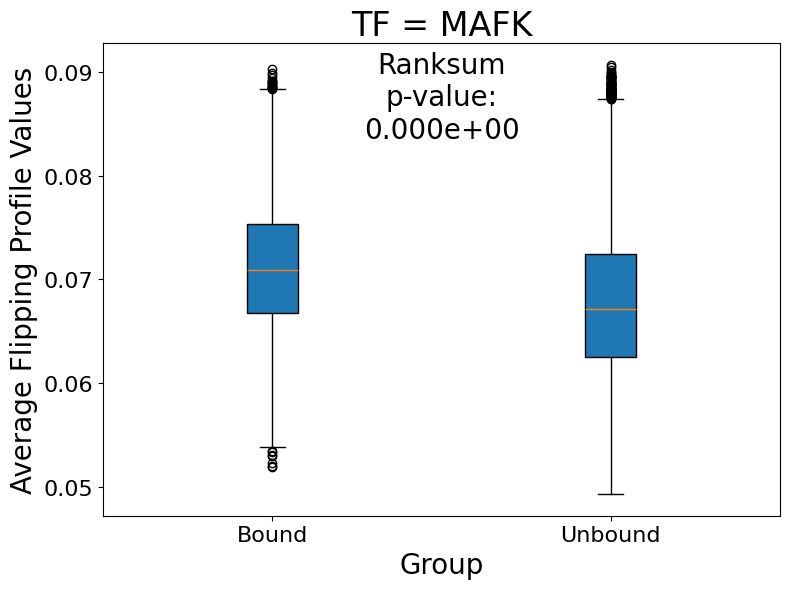

/home/waqaas/ipykernel_2710682/2637656172.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_to_plot, patch_artist=True, labels=['Bound', 'Unbound'])


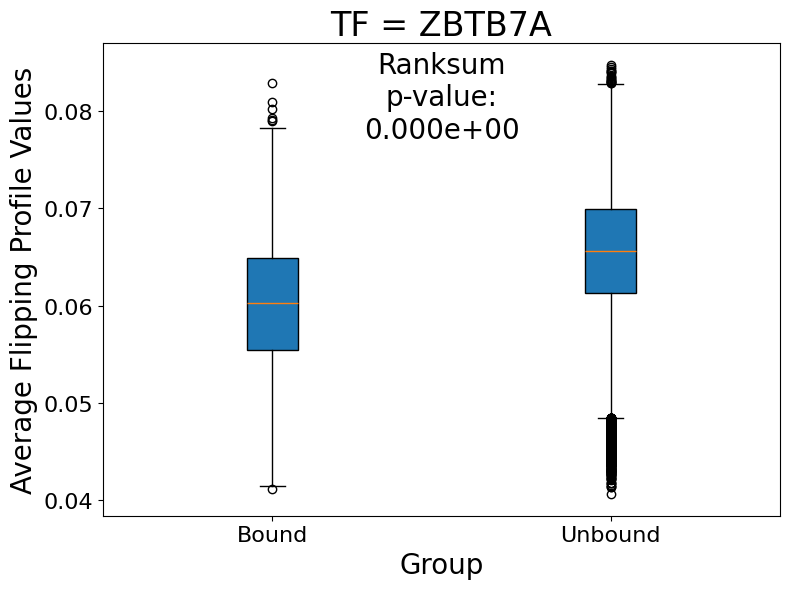

In [29]:
for tf in flip_container.keys():
    # Set font size factors
    a = 1.6
    title_fontsize = 24
    label_fontsize = 20
    tick_fontsize = 16  # Adjust tick font size

    # Collect positive and negative label flip values
    label_flip_pos = [o for i, o in enumerate(flip_container[tf]['flip']) if flip_container[tf]['binding_affinity'][i] == 1]
    label_flip_neg = [o for i, o in enumerate(flip_container[tf]['flip']) if flip_container[tf]['binding_affinity'][i] == 0]

    # Calculate ranksums
    stat, p = ranksums(label_flip_pos, label_flip_neg)

    # Data for boxplots
    data_to_plot = [label_flip_pos, label_flip_neg]

    # Create boxplots
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.boxplot(data_to_plot, patch_artist=True, labels=['Bound', 'Unbound'])

    # Set colors for each box
    colors = ['blue', 'red']
    for patch, color in zip(ax.artists, colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.4)

    # Set plot title and labels
    ax.set_title('TF = ' + f"{tf}".upper(), fontsize=title_fontsize)
    ax.set_xlabel("Group", fontsize=label_fontsize)
    ax.set_ylabel("Average Flipping Profile Values", fontsize=label_fontsize)
    ax.tick_params(axis='x', labelsize=tick_fontsize)
    ax.tick_params(axis='y', labelsize=tick_fontsize)

    # Annotate the p-value
    ax.annotate(f'Ranksum\np-value:\n{p:.3e}', xy=(0.5, 0.8), xycoords='axes fraction', fontsize=20, ha='center')

    plt.tight_layout()
    plt.savefig(f'/scratch/midway3/waqaas/DNA-breathing/figs/paper/{tf}_flip_pos_neg_boxplot.png')
    plt.show()

In [ ]:
for tf in fimo_dict.keys():
    for idx, matrix_id in enumerate(fimo_dict[tf].keys(), start=2):
        print(fimo_dict[tf][matrix_id].head().to_markdown())
        break
    break

|       | motif_id   | motif_alt_id   |   sequence_name |   start |   stop | strand   |   score |   p-value |   q-value | matched_sequence   | coord                                                                   | coord_sq                                                                | flip                                                                    |   label |
|------:|:-----------|:---------------|----------------:|--------:|-------:|:---------|--------:|----------:|----------:|:-------------------|:------------------------------------------------------------------------|:------------------------------------------------------------------------|:------------------------------------------------------------------------|--------:|
| 39668 | MA1648.1   | TCF12          |             146 |     115 |    125 | +        | 12.6099 |  3.14e-05 |     0.259 | CTCACCTGCGA        | [0.209  0.1624 0.1981 0.1537 0.1514 0.188  0.136  0.1273 0.137  0.195 ] | [0.1557 0.1239 0.1416 0.1135 0.10

In [ ]:
import numpy as np
from scipy.stats import pearsonr

correlation_results = {}

# Loop over TFs
for tf, matrices in fimo_dict.items():
    correlation_results[tf] = {}
    
    # Loop over matrix_ids for each TF
    for matrix_id, df in matrices.items():
        # Initialize lists to store the means
        motif_flip_means = []
        motif_coord_means = []
        motif_coordsq_means = []
        labels = []
        
        # Iterate over the DataFrame to compute means of lists in each cell
        for index, row in df.iterrows():
            motif_flip_means.append(np.mean(row['flip']))
            motif_coord_means.append(np.mean(row['coord']))
            motif_coordsq_means.append(np.mean(row['coord_sq']))
            try:
                labels.append(row['label'].tolist()[0])
            except (AttributeError):
                labels.append(row['label'])
        
        # Convert lists to numpy arrays
        motif_flip_means = np.asarray(motif_flip_means)
        motif_coord_means = np.asarray(motif_coord_means)
        motif_coordsq_means = np.asarray(motif_coordsq_means)
        # print(np.shape(motif_flip_means))
        # print(np.shape(labels))
        
        # Calculate Pearson correlation coefficients and p-values
        corr_flip, p_value_flip = pearsonr(labels, motif_flip_means)
        corr_coord, p_value_coord = pearsonr(labels, motif_coord_means)
        corr_coordsq, p_value_coordsq = pearsonr(labels, motif_coordsq_means)

        # # Print the types to debug
        # print(f"Types for {tf} {matrix_id}:")
        # print(f"corr_flip: {type(corr_flip)}, p_value_flip: {type(p_value_flip)}")
        # print(f"corr_coord: {type(corr_coord)}, p_value_coord: {type(p_value_coord)}")
        # print(f"corr_coordsq: {type(corr_coordsq)}, p_value_coordsq: {type(p_value_coordsq)}")
        
        correlation_results[tf][matrix_id] = {
            'motif_flip': (round(corr_flip, 3), format(p_value_flip, '.5e')),
            'motif_coord': (round(corr_coord, 3), format(p_value_coord, '.5e')),
            'motif_coordsq': (round(corr_coordsq, 3), format(p_value_coordsq, '.5e'))
        }

print(correlation_results)

{'TCF12': {'MA1648.1': {'motif_flip': (-0.053, '1.13241e-33'), 'motif_coord': (-0.045, '1.14874e-24'), 'motif_coordsq': (-0.054, '4.76174e-35')}}, 'ELF1': {'MA0473.3': {'motif_flip': (-0.151, '0.00000e+00'), 'motif_coord': (-0.148, '2.21934e-318'), 'motif_coordsq': (-0.155, '0.00000e+00')}}, 'MAX': {'MA0058.3': {'motif_flip': (-0.052, '8.85455e-26'), 'motif_coord': (-0.046, '2.44265e-20'), 'motif_coordsq': (-0.054, '1.07873e-27')}}, 'E2F6': {'MA0471.2': {'motif_flip': (-0.2, '0.00000e+00'), 'motif_coord': (-0.191, '0.00000e+00'), 'motif_coordsq': (-0.203, '0.00000e+00')}}, 'RUNX3': {'MA0684.2': {'motif_flip': (0.053, '7.83515e-35'), 'motif_coord': (0.072, '1.39526e-62'), 'motif_coordsq': (0.044, '4.13134e-24')}}, 'BHLHE40': {'MA0464.2': {'motif_flip': (-0.071, '1.05203e-36'), 'motif_coord': (-0.062, '3.63039e-28'), 'motif_coordsq': (-0.074, '2.64074e-40')}}, 'FOXA1': {'MA0148.4': {'motif_flip': (-0.089, '7.15563e-105'), 'motif_coord': (-0.093, '5.66394e-115'), 'motif_coordsq': (-0.093,

In [ ]:
# save the correlation_results as a pickle file
with open('/project2/xinhe/waqaas/DNA-breathing/data/Chipseq_data/correlation_results_robust.pkl', 'wb') as f:
    pickle.dump(correlation_results, f)
# save to the scratch directory
with open('/scratch/midway3/waqaas/DNA-breathing/data/Chipseq_data/correlation_results_robust.pkl', 'wb') as f:
    pickle.dump(correlation_results, f)

In [ ]:
# save to the scratch directory
with open('/scratch/midway3/waqaas/DNA-breathing/data/Chipseq_data/correlation_results_robust.pkl', 'rb') as f:
    correlation_results = pickle.load(f)

In [ ]:
# turn correlation_results into a dataframe
correlation_results_df = pd.DataFrame.from_dict({(i,j): correlation_results[i][j] 
                           for i in correlation_results.keys() 
                           for j in correlation_results[i].keys()},
                       orient='index')

In [ ]:
# turn index into columns
correlation_results_df.reset_index(inplace=True)

In [ ]:
# rename level_0 to tf and level_1 to matrix_id
correlation_results_df.rename(columns={'level_0': 'tf', 'level_1': 'matrix_id'}, inplace=True)

In [ ]:
# split each of motif_flip, motif_coord and motif_coordsq into correlation coefficient and p-value columns
correlation_results_df[['motif_flip_corr', 'motif_flip_pval']] = pd.DataFrame(correlation_results_df['motif_flip'].tolist(), index=correlation_results_df.index)
correlation_results_df[['motif_coord_corr', 'motif_coord_pval']] = pd.DataFrame(correlation_results_df['motif_coord'].tolist(), index=correlation_results_df.index)
correlation_results_df[['motif_coordsq_corr', 'motif_coordsq_pval']] = pd.DataFrame(correlation_results_df['motif_coordsq'].tolist(), index=correlation_results_df.index)

In [ ]:
# drop the motif_flip, motif_coord and motif_coordsq columns
correlation_results_df.drop(columns=['motif_flip', 'motif_coord', 'motif_coordsq'], inplace=True)

In [ ]:
correlation_results_df.sort_values(by='motif_flip_corr', ascending=False, inplace=True)

In [ ]:
# preview the data
correlation_results_df

tf matrix_id  motif_flip_corr motif_flip_pval  motif_coord_corr  \
28     MAFK  MA0496.3            0.207     0.00000e+00             0.227   
39     NFYB  MA0502.2            0.180     0.00000e+00             0.175   
29    CEBPB  MA0466.3            0.159    1.09438e-248             0.166   
45   ZBTB33  MA0527.1            0.158    2.77515e-124             0.164   
33     BATF  MA1634.1            0.131     0.00000e+00             0.130   
36     EBF1  MA0154.4            0.122    2.19183e-247             0.111   
4     RUNX3  MA0684.2            0.053     7.83515e-35             0.072   
41    PRDM1  MA0508.3            0.016     2.18144e-04             0.019   
12    STAT3  MA0144.2            0.006     6.28939e-02             0.003   
17     PBX3  MA1114.1           -0.001     8.42046e-01             0.007   
31    HNF4A  MA0114.4           -0.005     2.81780e-01            -0.003   
35     REST  MA0138.2           -0.006     1.13882e-01            -0.002   
46    TEAD4  MA0809.2           -0.008     4.61113e-02            -0.008   
40     USF2  MA0526.4           -0.008     5.55673e-02            -0.008   
30    HNF4A  MA1494.1           -0.013     7.10976e-03            -0.010   
22     PAX5  MA0014.3           -0.020     1.90657e-04            -0.013   
18    NR2F2  MA1111.1           -0.023     1.21751e-07            -0.022   
19     EGR1  MA0162.4           -0.026     2.45873e-10            -0.029   
37     USF1  MA0093.3           -0.029     2.22030e-14            -0.031   
48   TCF7L2  MA0523.1           -0.030     5.17712e-13            -0.031   
13    FOSL2  MA0478.1           -0.035     4.59591e-16            -0.038   
23     RFX5  MA0510.2           -0.041     5.98153e-14            -0.041   
27      SRF  MA0083.3           -0.046     4.68152e-13            -0.044   
0     TCF12  MA1648.1           -0.053     1.13241e-33            -0.045   
47     IRF4  MA1419.1           -0.055     9.16276e-25            -0.056   
44   TFAP2C  MA0524.2           -0.056     9.49061e-45            -0.055   
11    GATA2  MA0036.3           -0.061     5.67575e-34            -0.062   
42   TFAP2C  MA0815.1           -0.062     6.62078e-57            -0.063   
26    FOXA2  MA0047.3           -0.067     1.60944e-59            -0.068   
5   BHLHE40  MA0464.2           -0.071     1.05203e-36            -0.062   
10   ZNF143  MA0088.2           -0.075     1.19298e-62            -0.078   
34    THAP1  MA0597.2           -0.076     3.37396e-85            -0.076   
9      CTCF  MA1929.1           -0.078    2.00795e-104            -0.077   
43   TFAP2C  MA0814.2           -0.078    8.25091e-105            -0.074   
8      CTCF  MA1930.1           -0.080     7.67029e-97            -0.080   
6     FOXA1  MA0148.4           -0.089    7.15563e-105            -0.093   
32    MEF2A  MA0052.4           -0.091    1.85054e-133            -0.094   
25    FOSL1  MA0477.2           -0.111    3.07240e-137            -0.113   
7      CTCF  MA0139.1           -0.112    9.43515e-191            -0.111   
16     JUND  MA0491.2           -0.115    2.80143e-284            -0.118   
20     ATF3  MA0605.2           -0.117    1.20309e-100            -0.116   
2       MAX  MA0058.3           -0.121    3.02992e-132            -0.119   
21      SP1  MA0079.5           -0.122     0.00000e+00            -0.122   
15     JUND  MA0492.1           -0.130    9.99296e-186            -0.129   
38    GABPA  MA0062.3           -0.132    3.15451e-250            -0.129   
1      ELF1  MA0473.3           -0.151     0.00000e+00            -0.148   
49   POU2F2  MA0507.2           -0.160    4.36759e-247            -0.153   
3      E2F6  MA0471.2           -0.200     0.00000e+00            -0.191   
24     ETS1  MA0098.3           -0.213     0.00000e+00            -0.217   
14   ZBTB7A  MA0750.2           -0.219     0.00000e+00            -0.222   

   motif_coord_pval  motif_coordsq_corr motif_coordsq_pval  
28      0.00000e+00               0.214        0.00000e+00  
39      0.

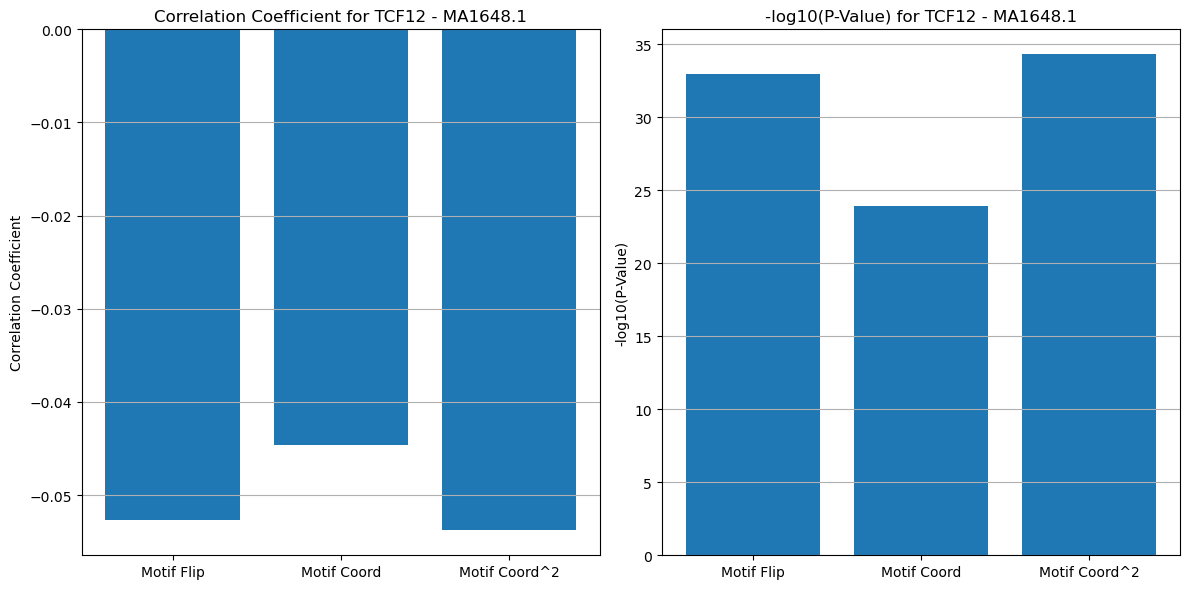

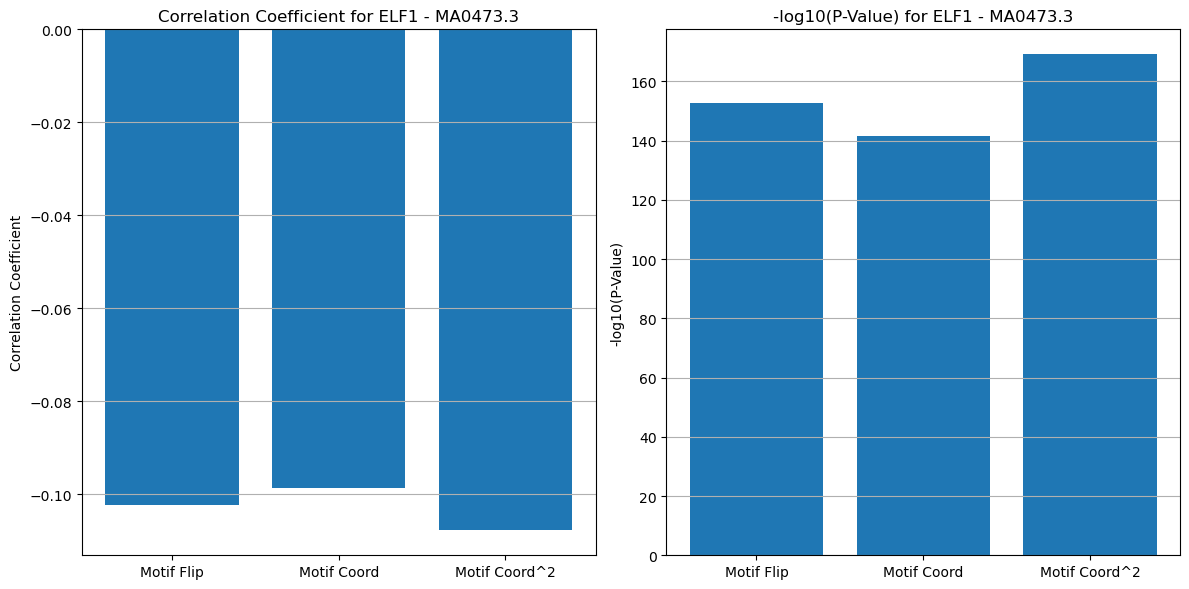

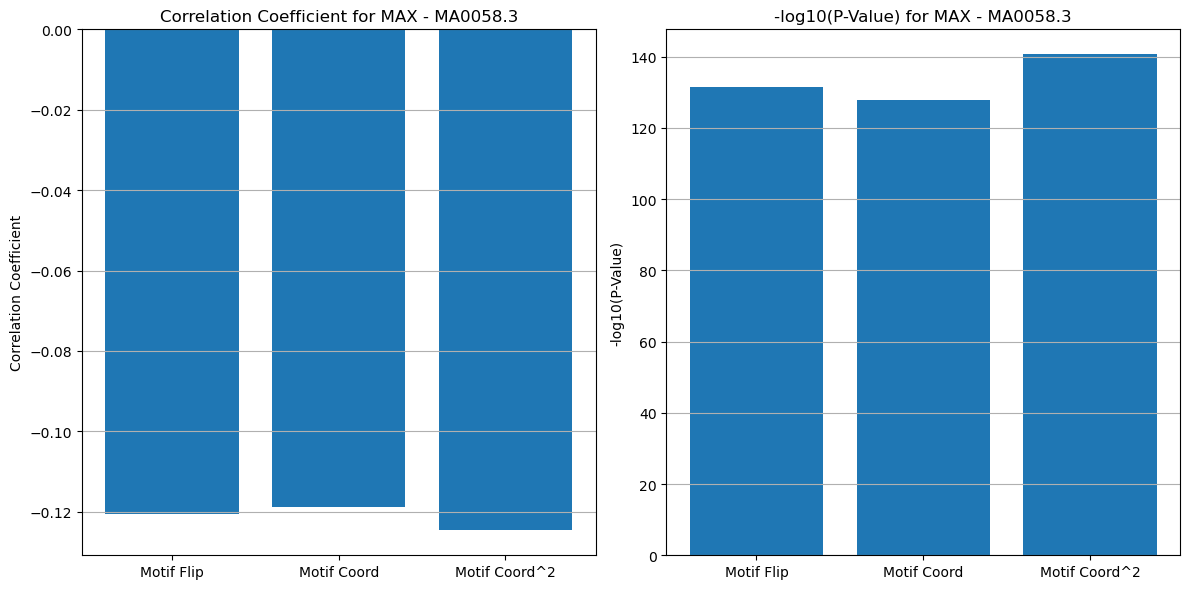

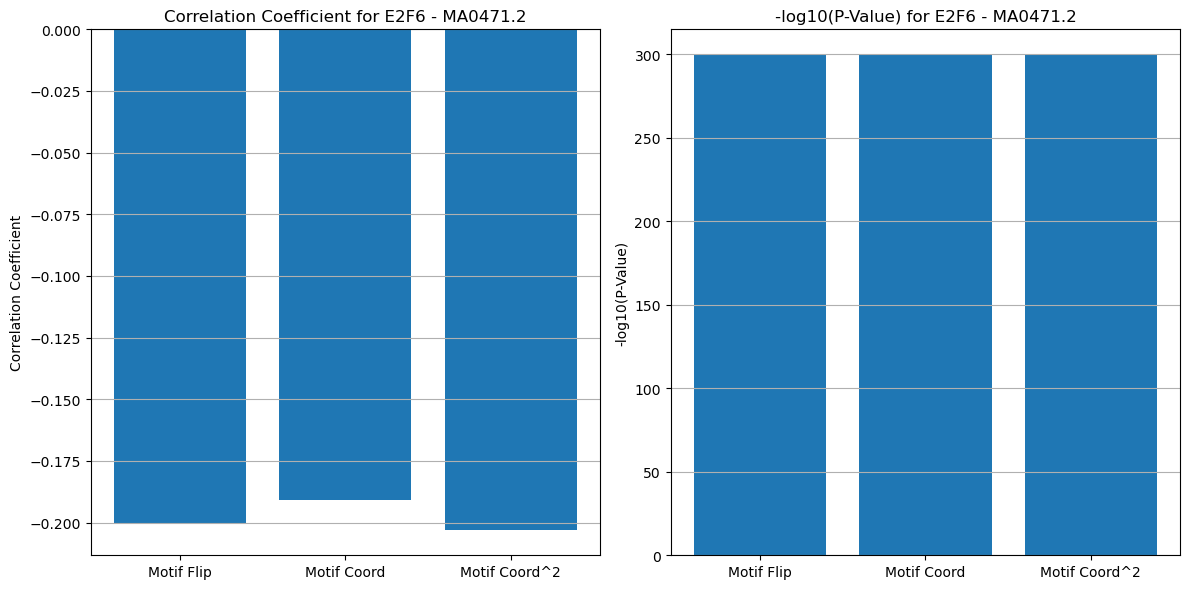

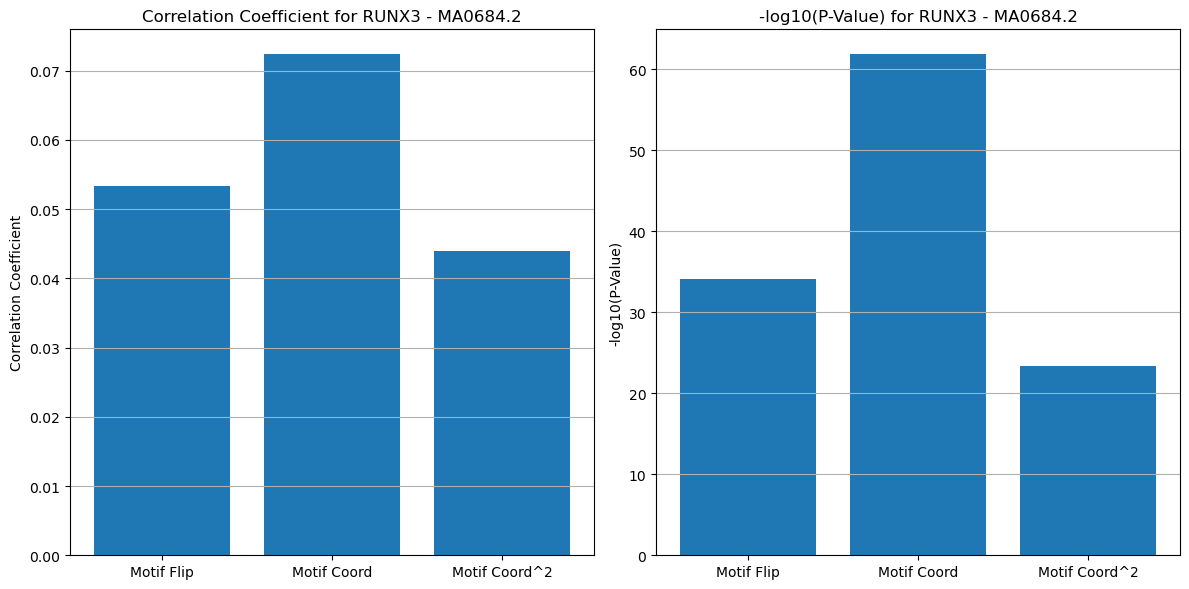

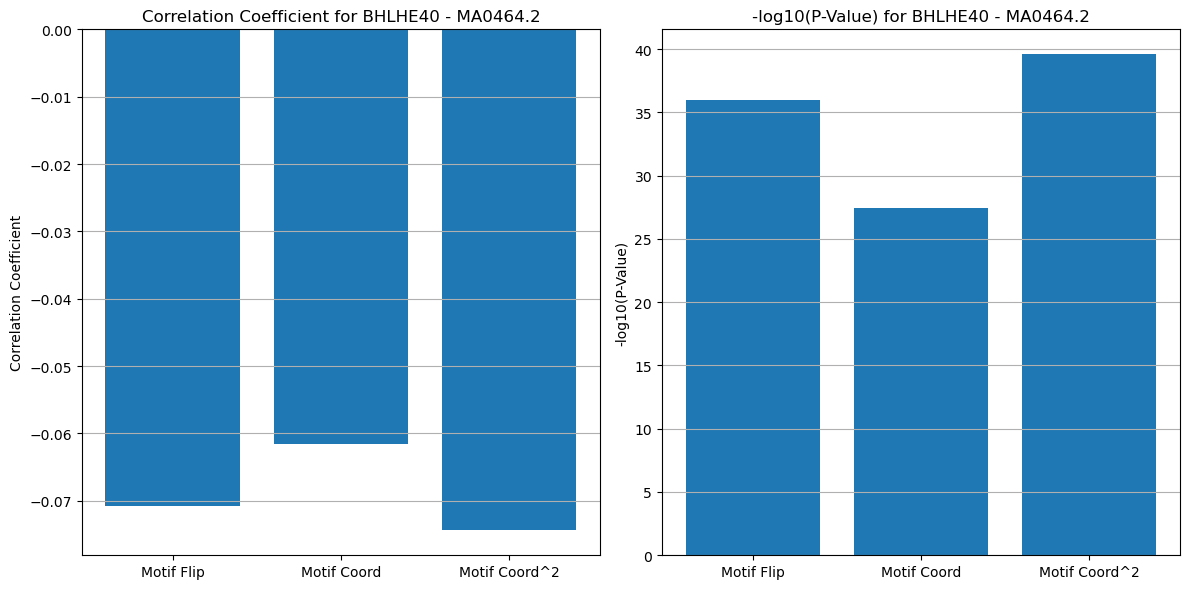

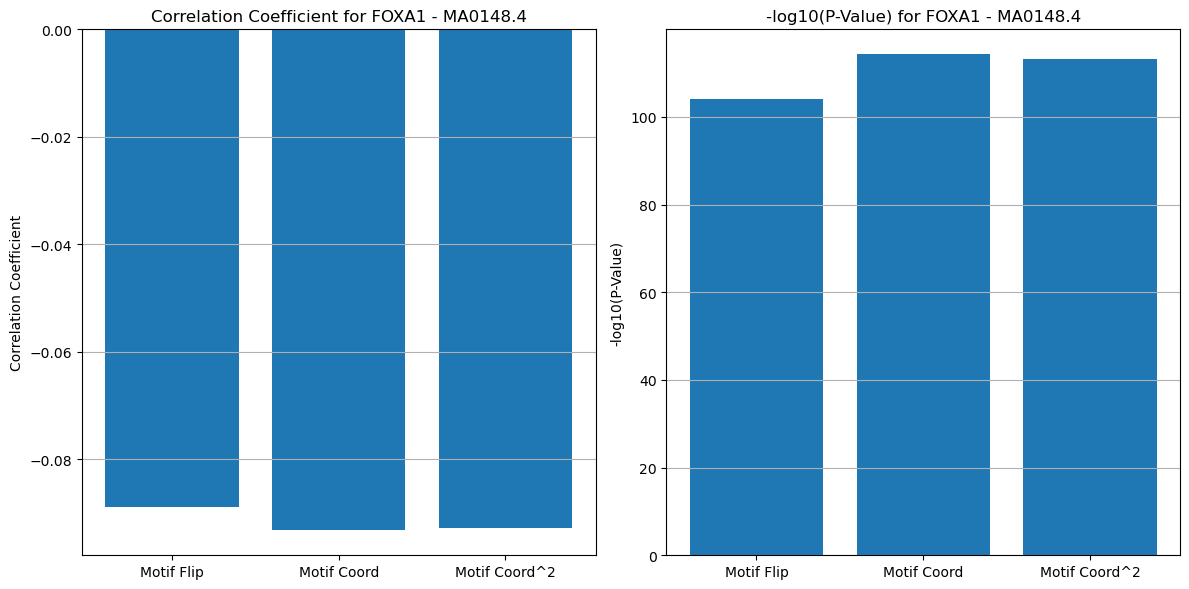

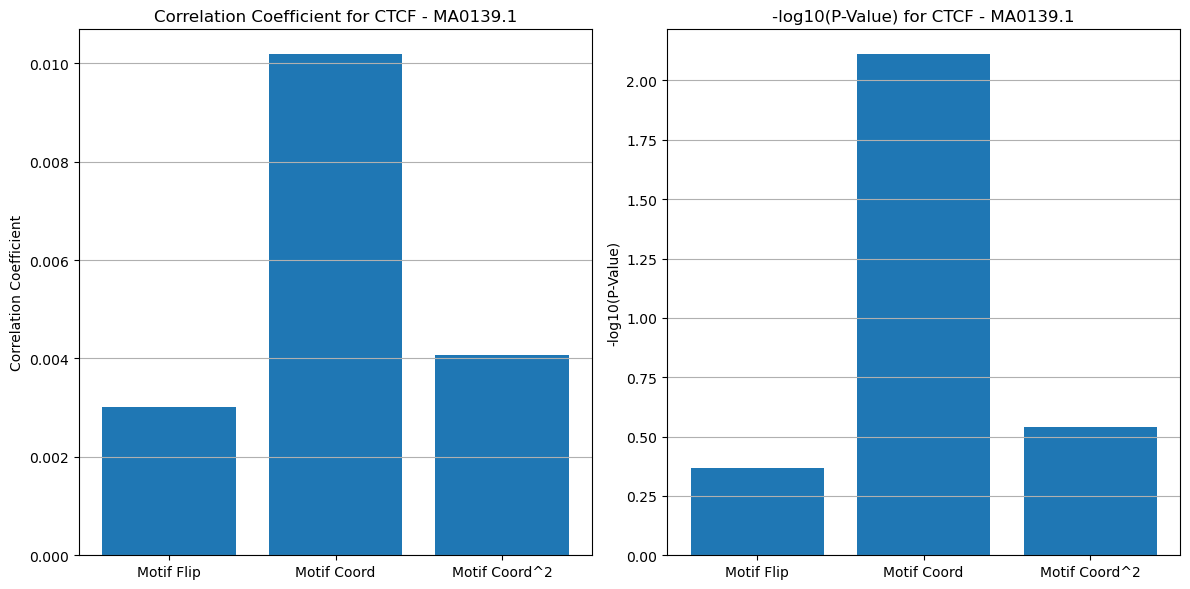

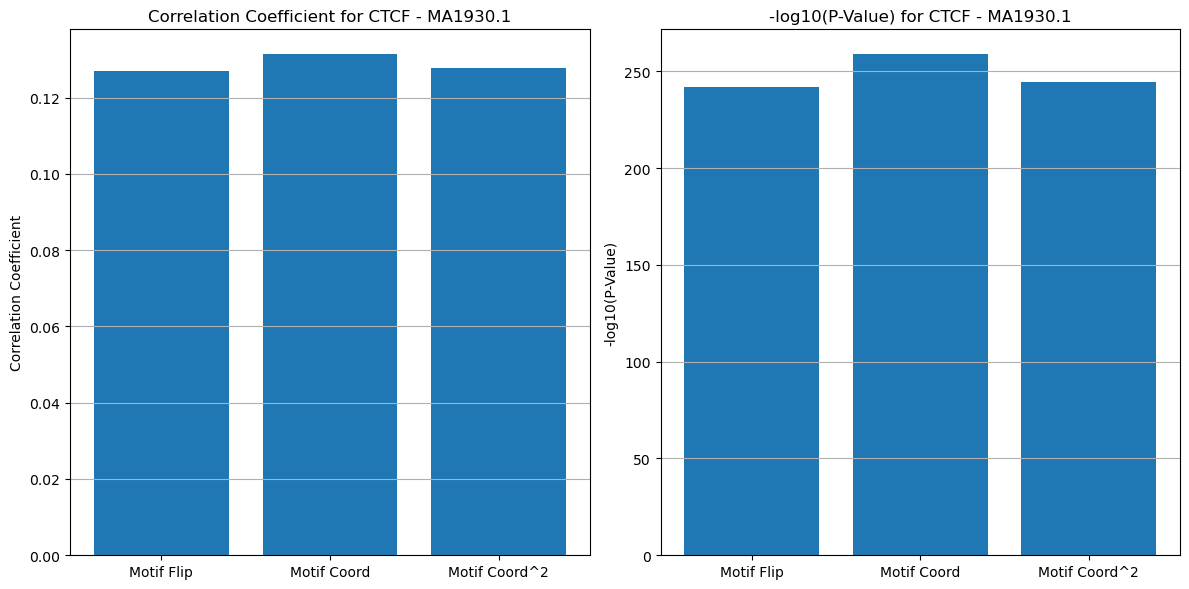

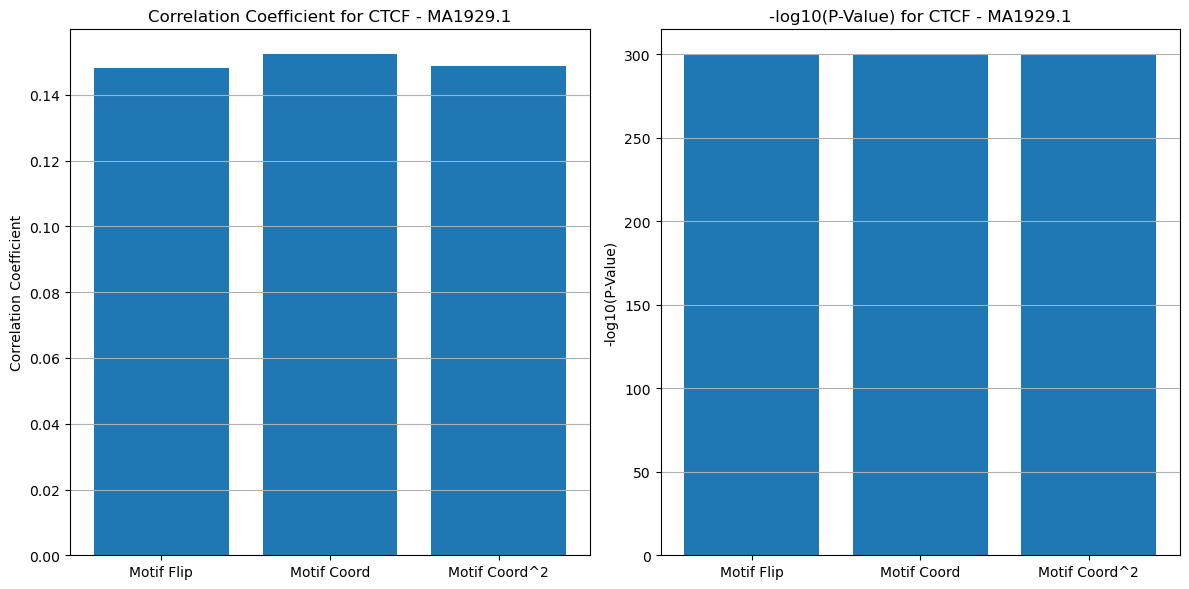

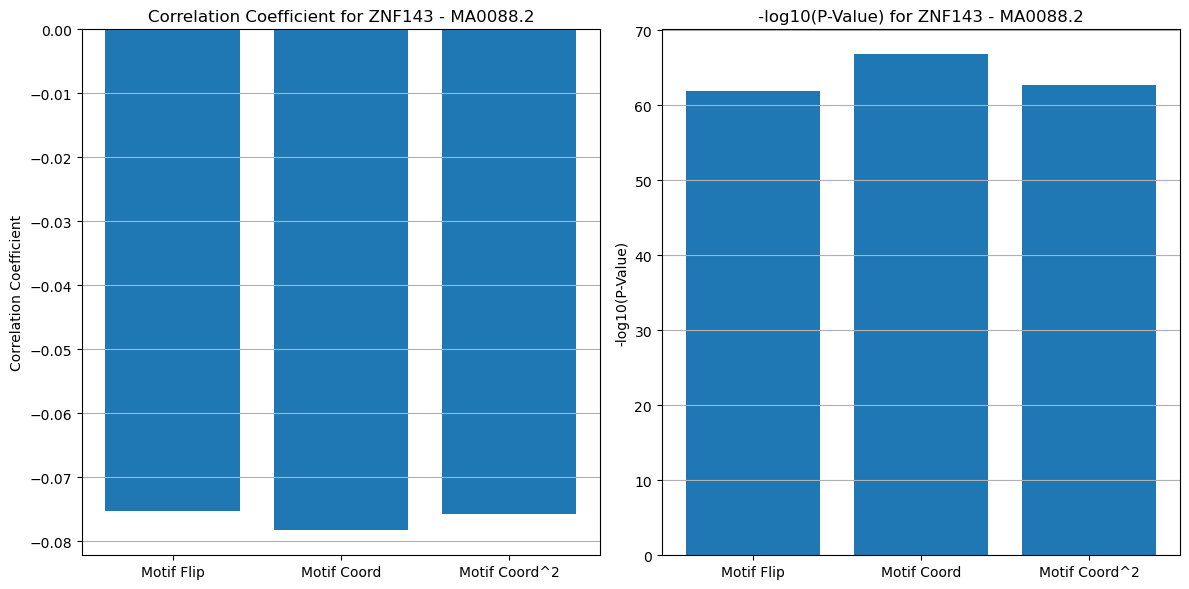

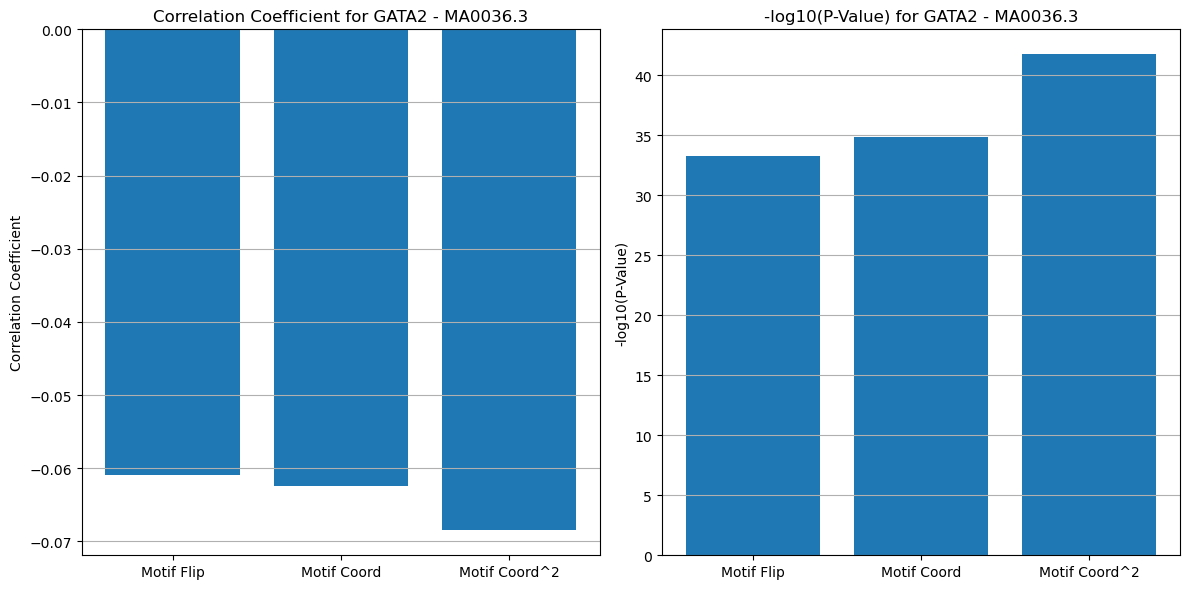

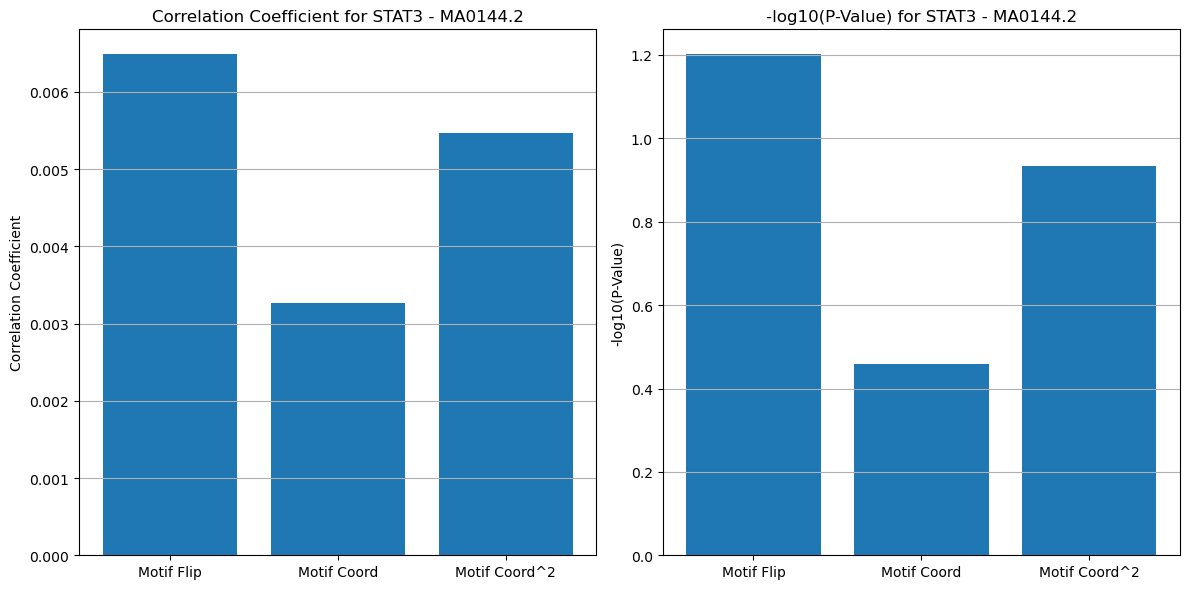

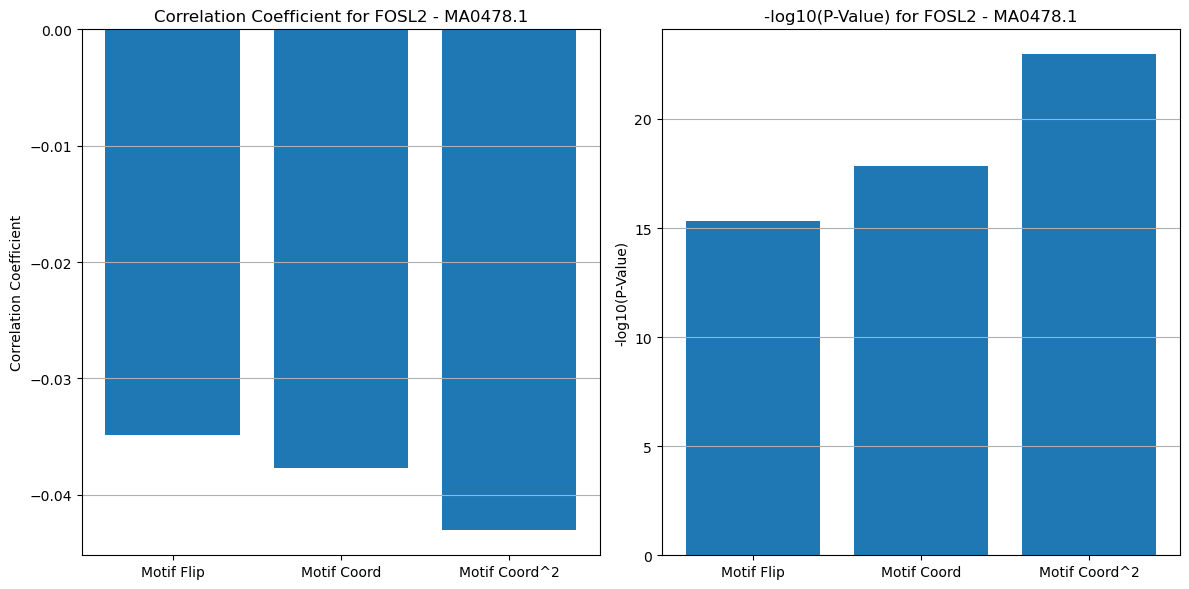

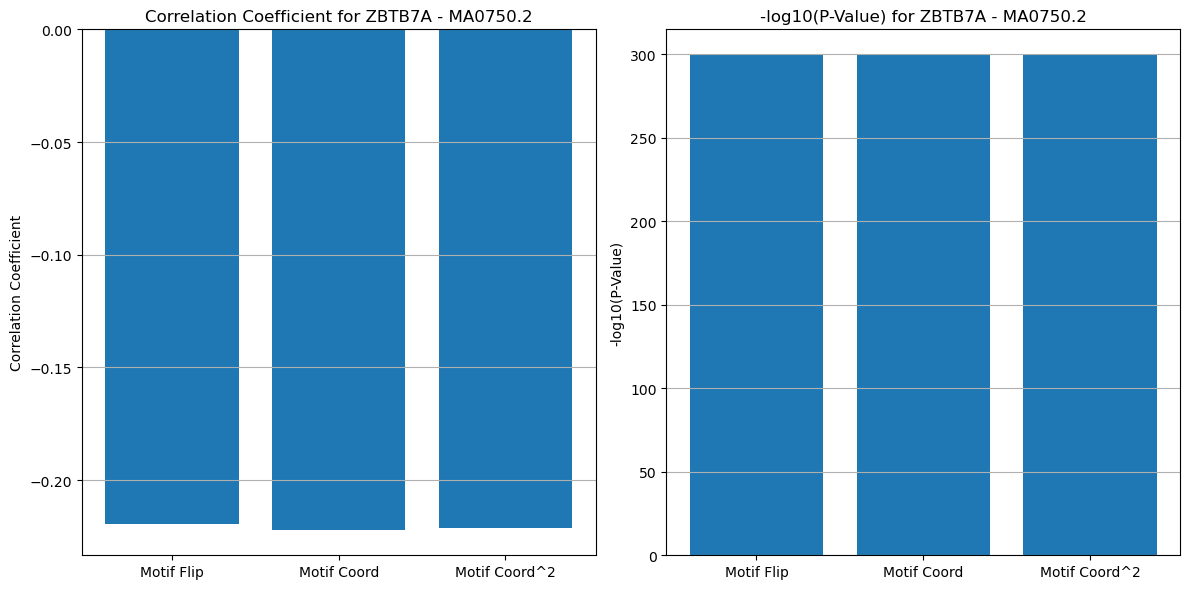

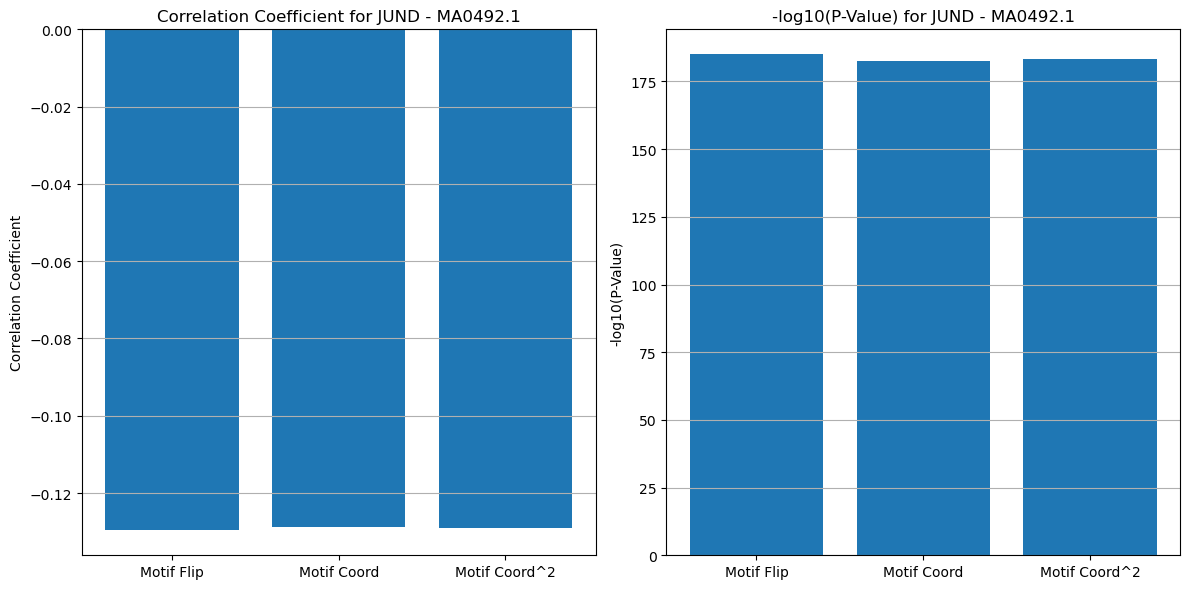

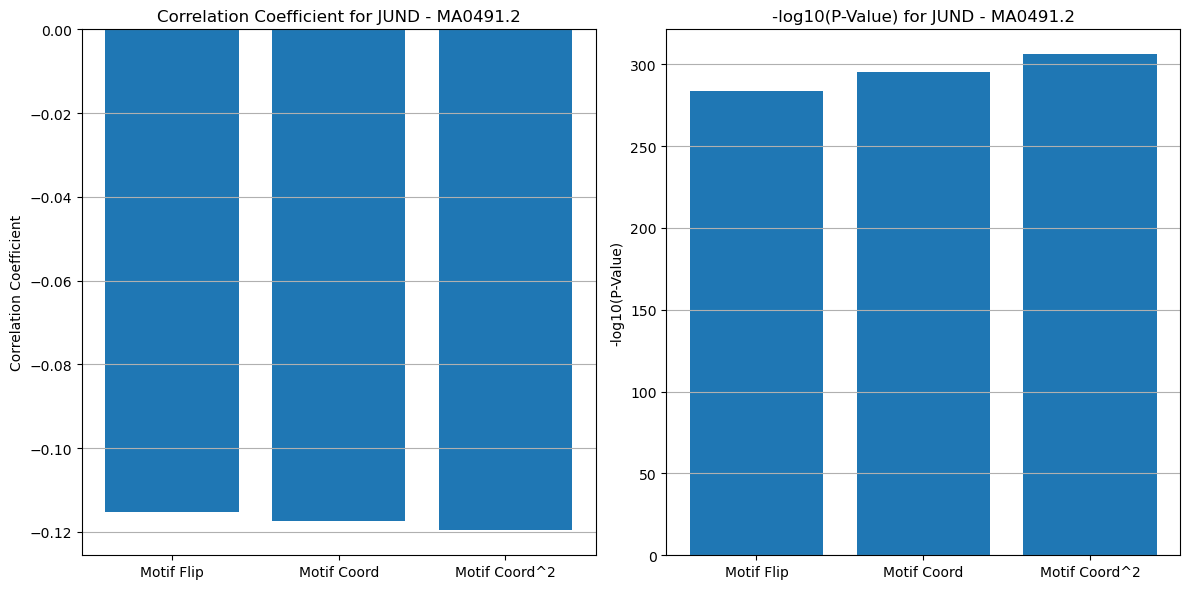

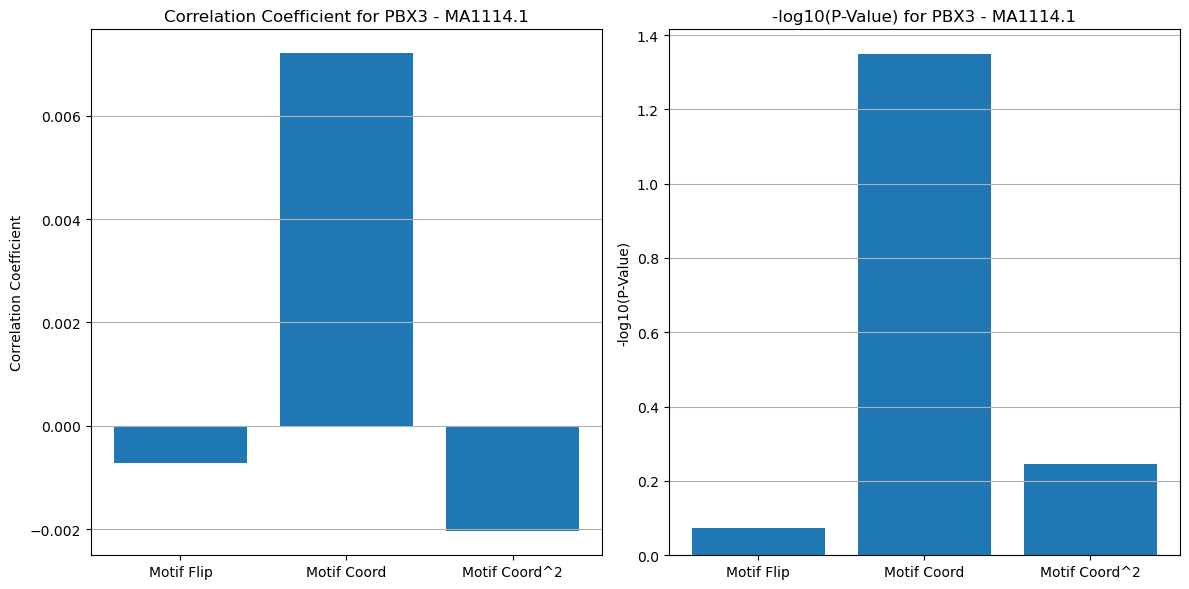

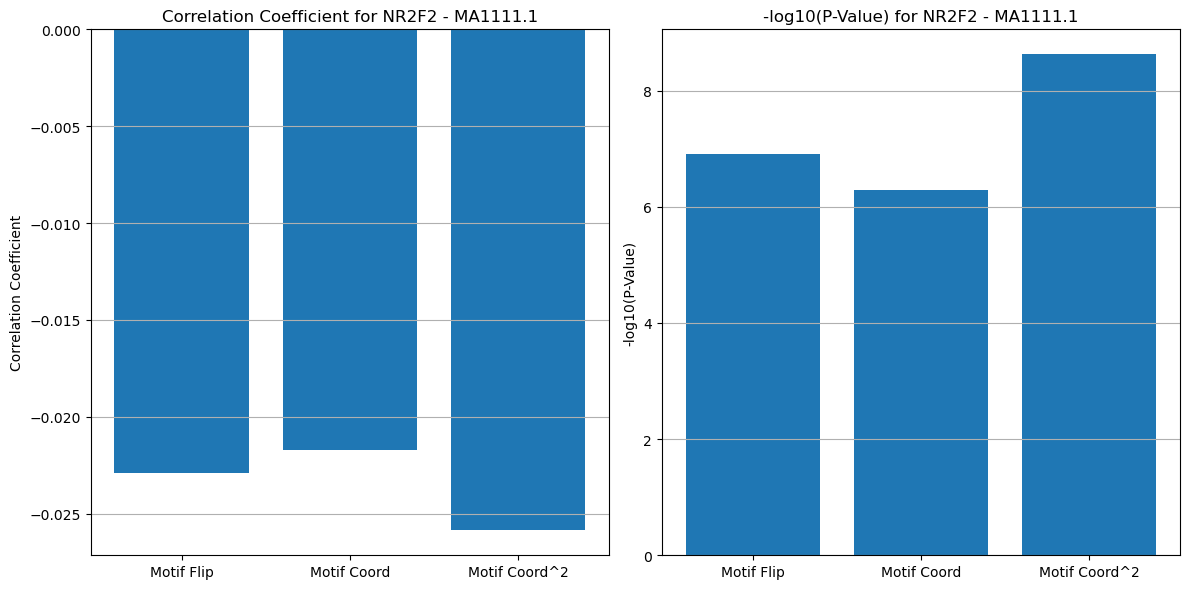

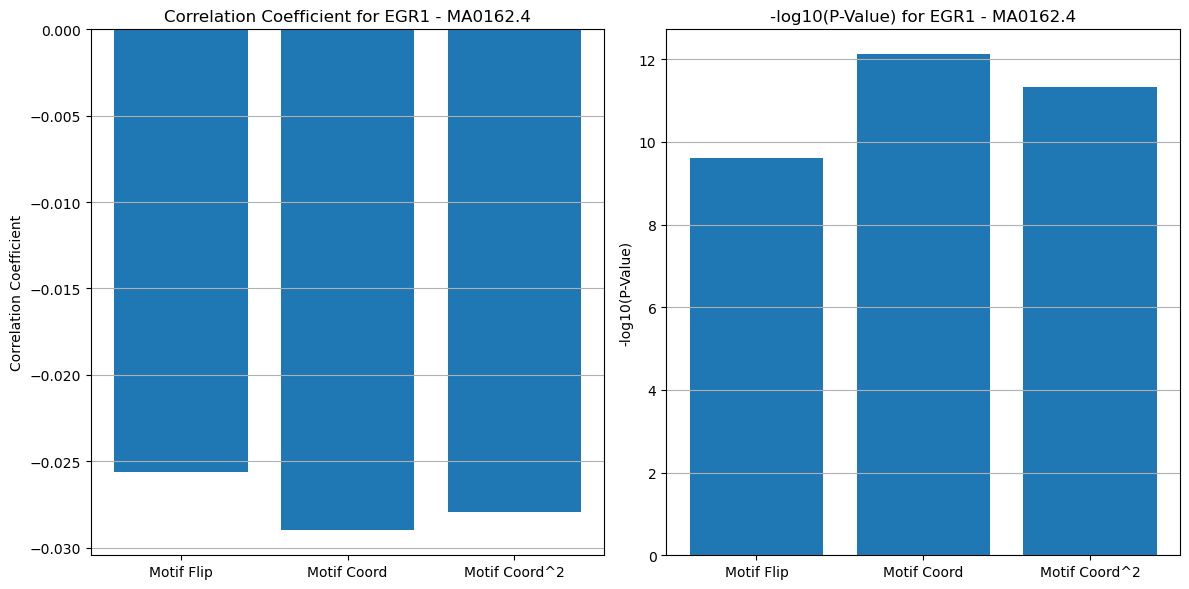

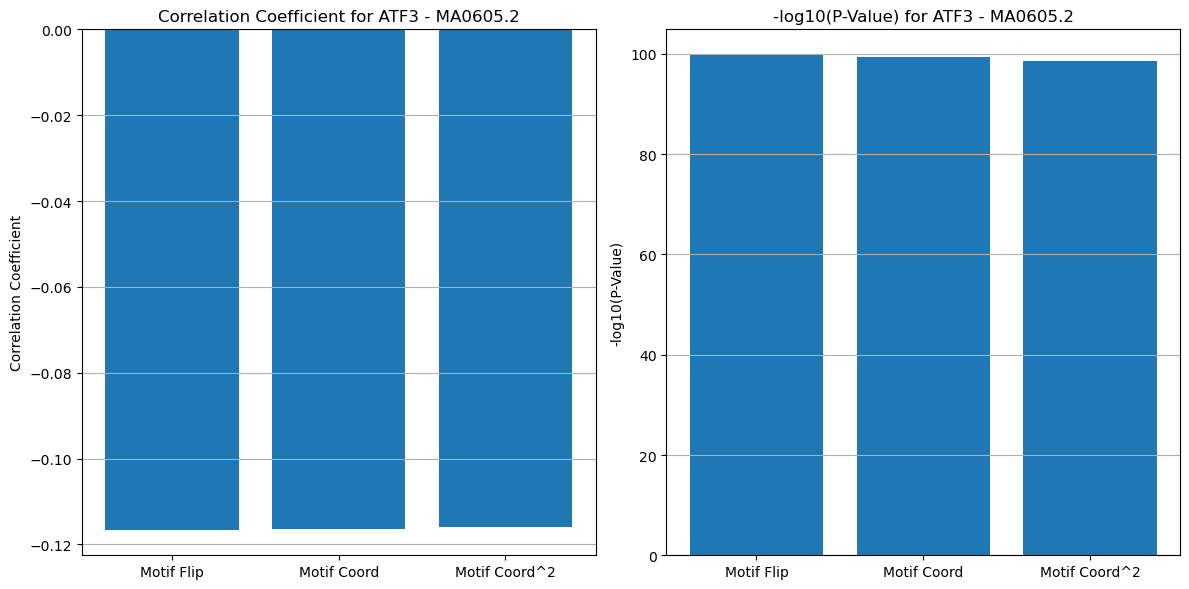

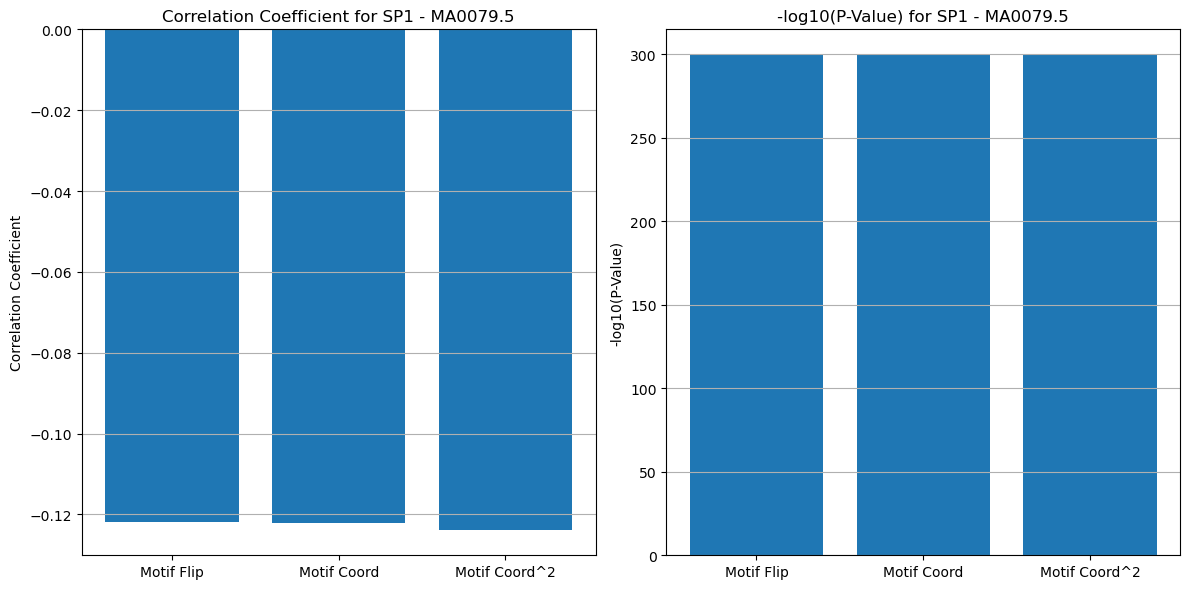

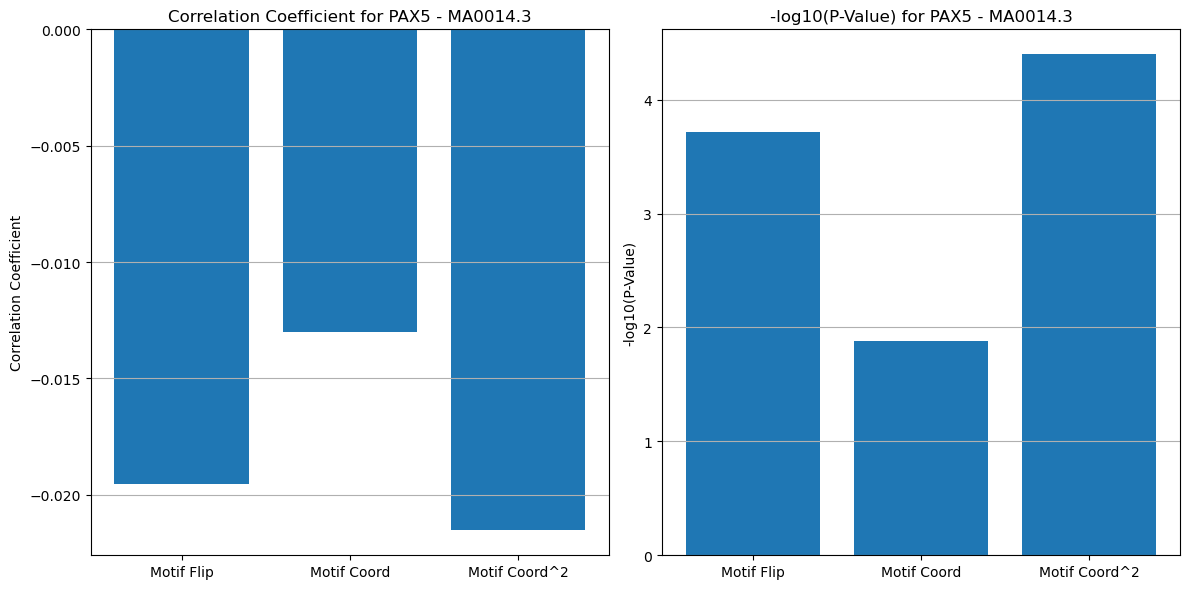

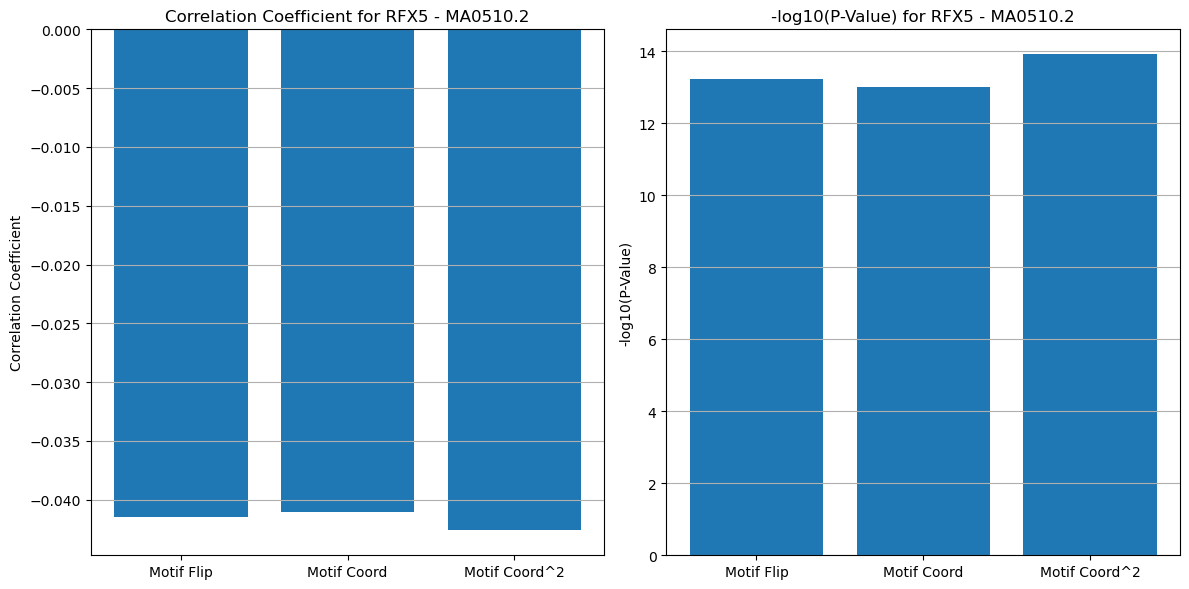

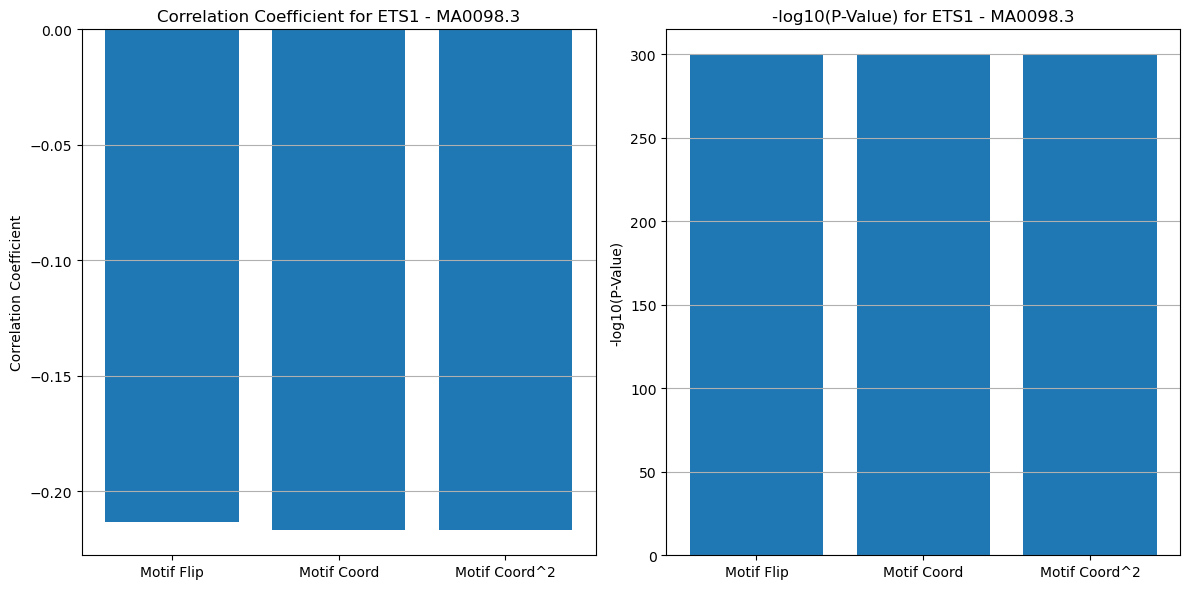

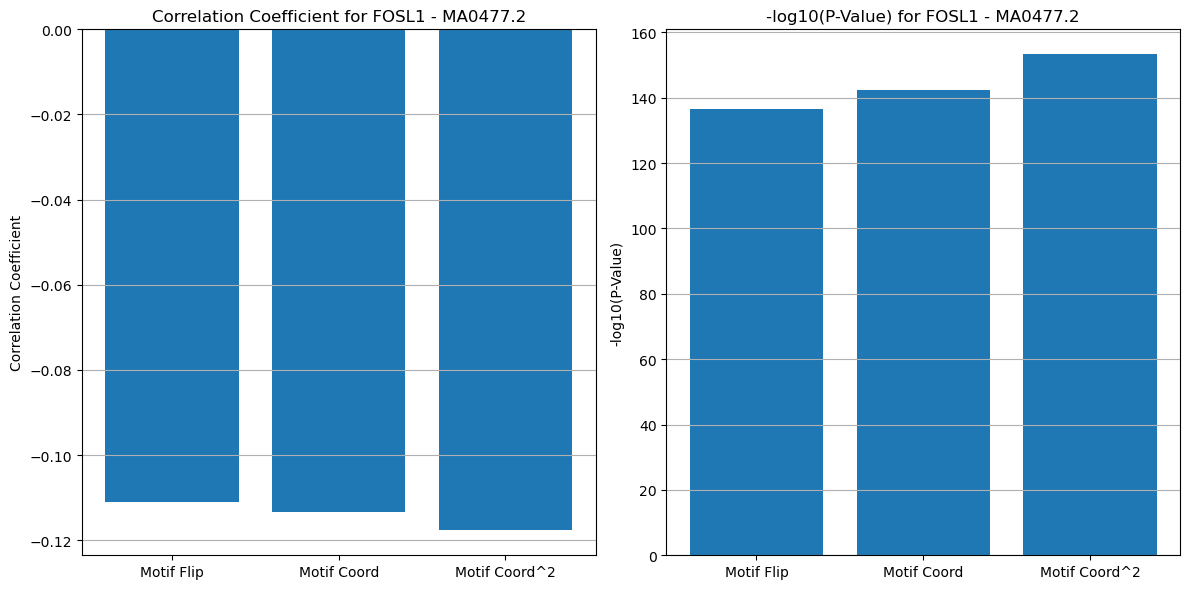

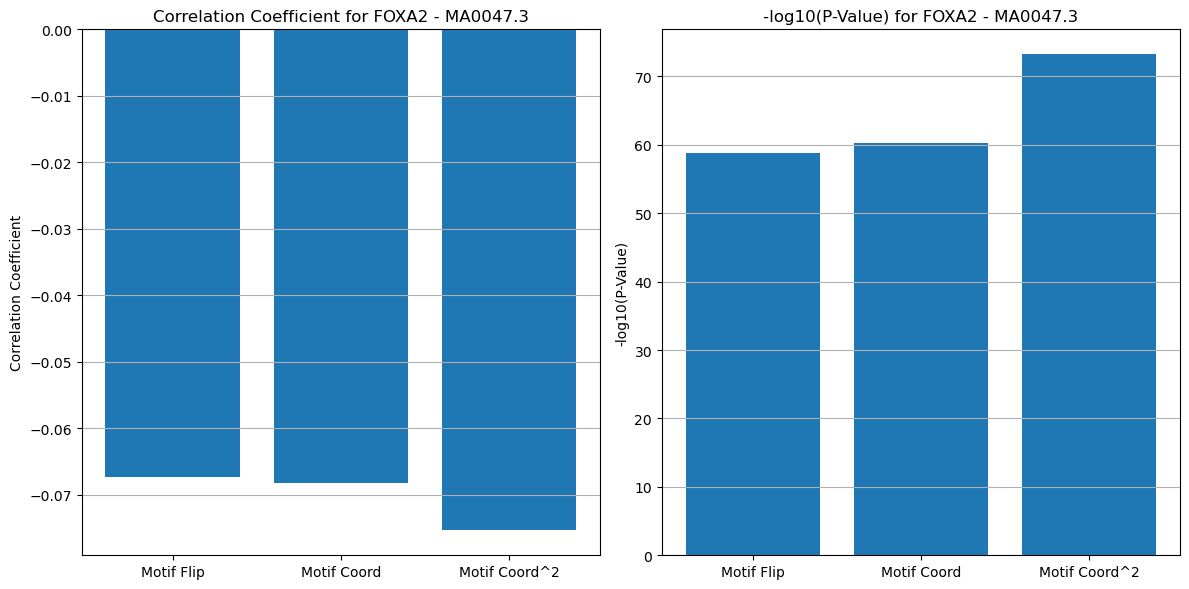

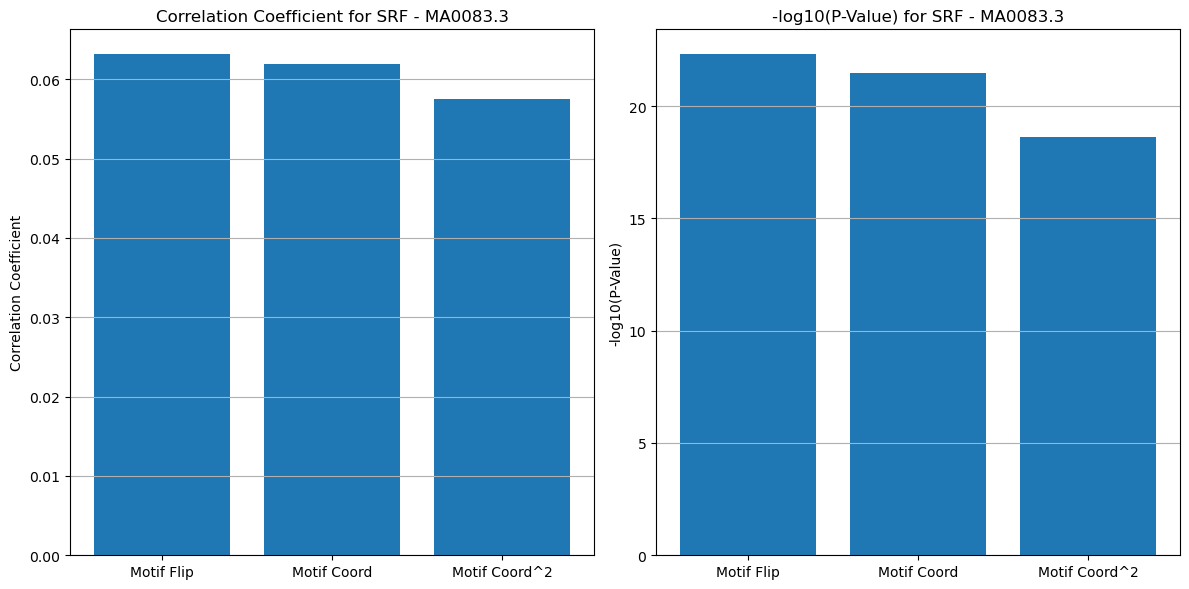

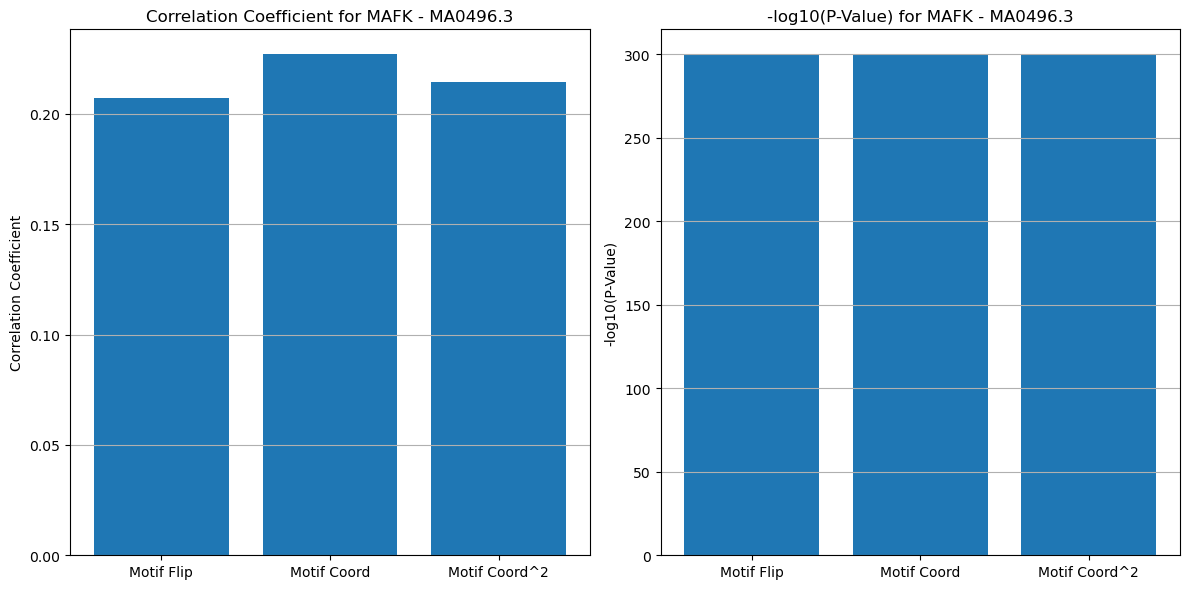

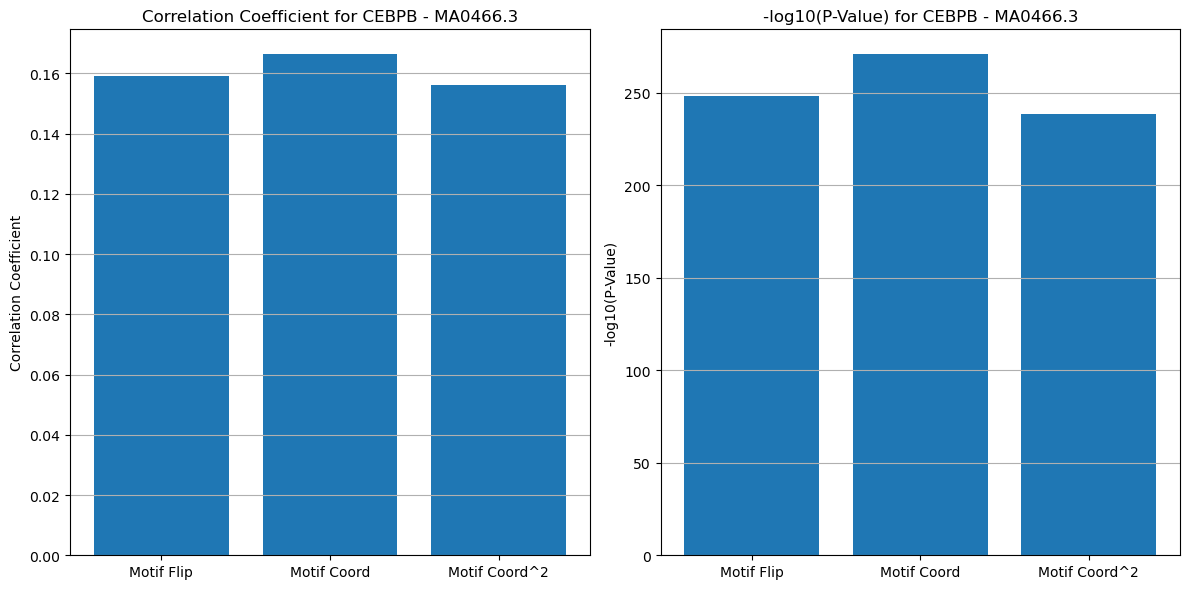

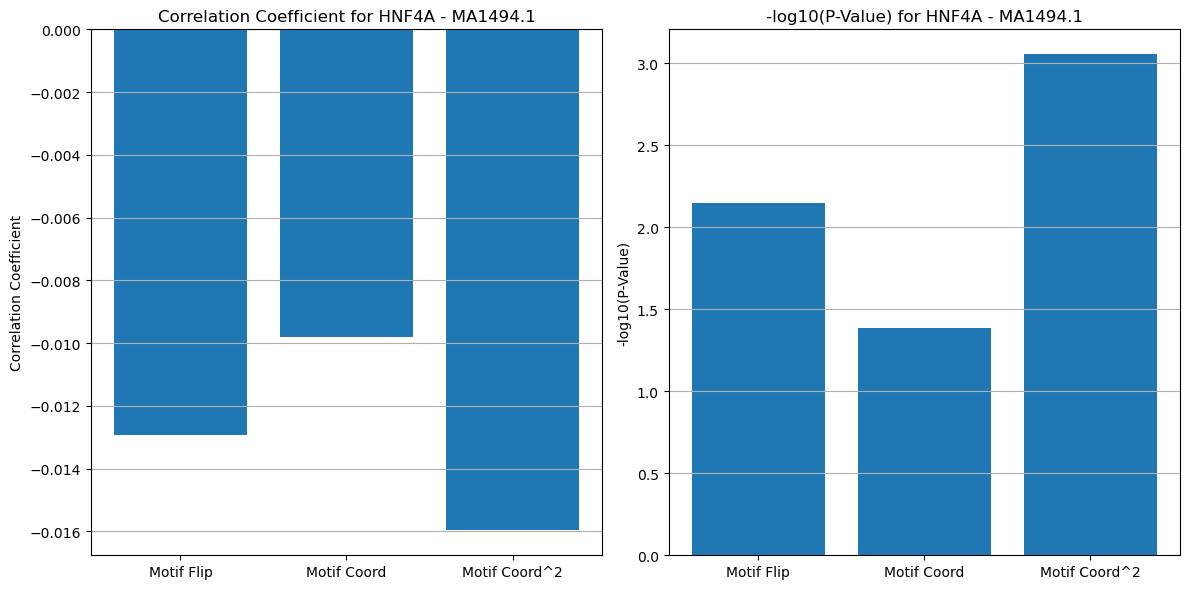

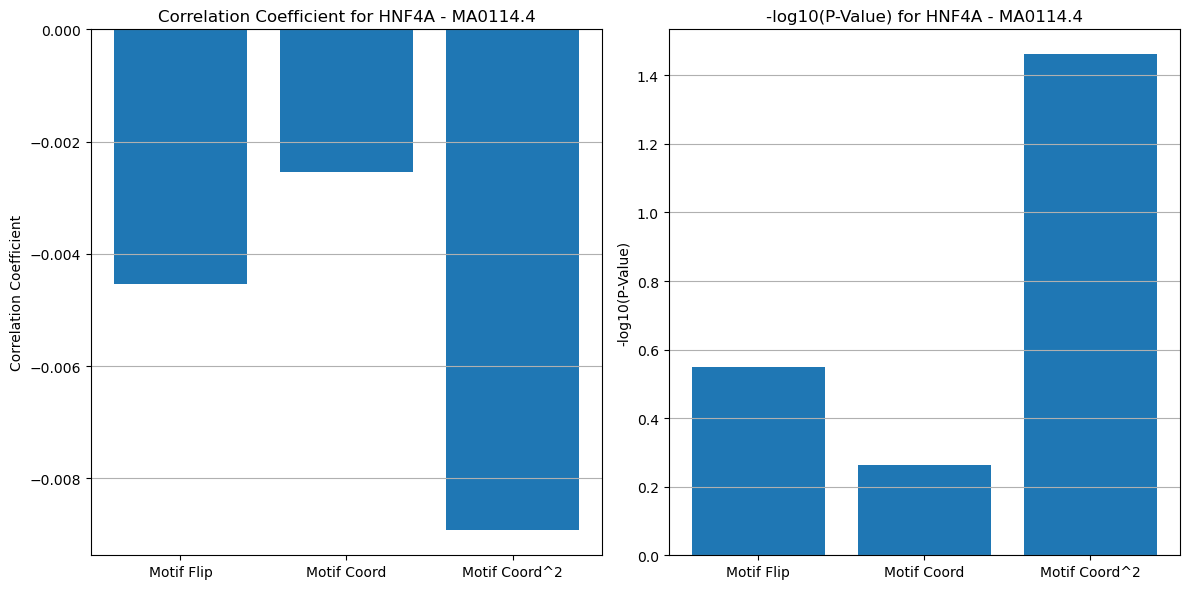

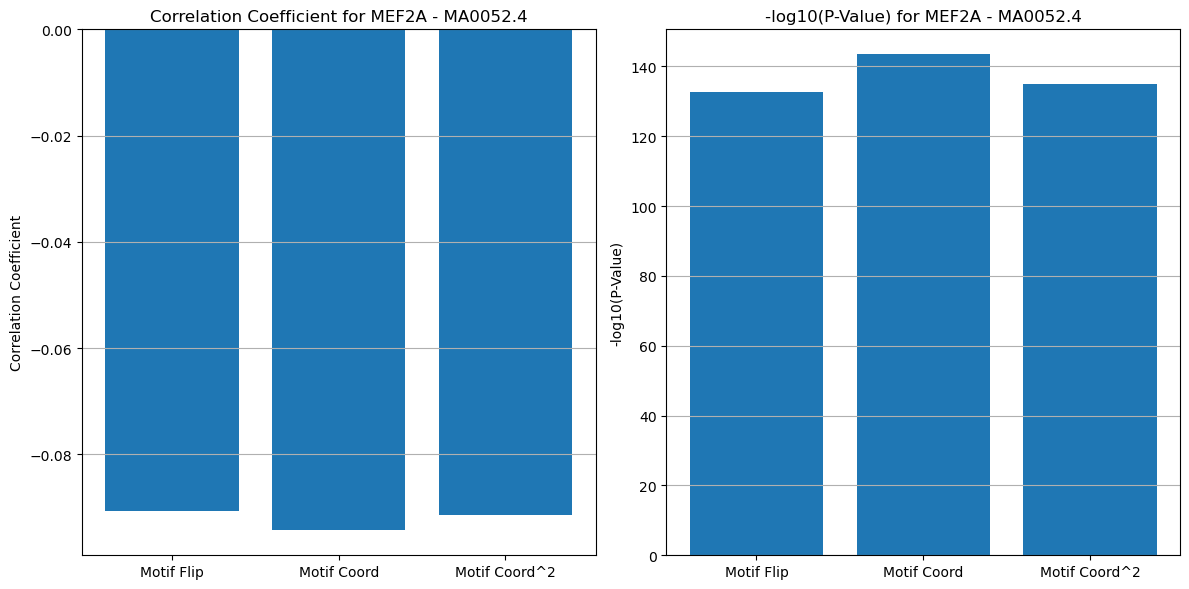

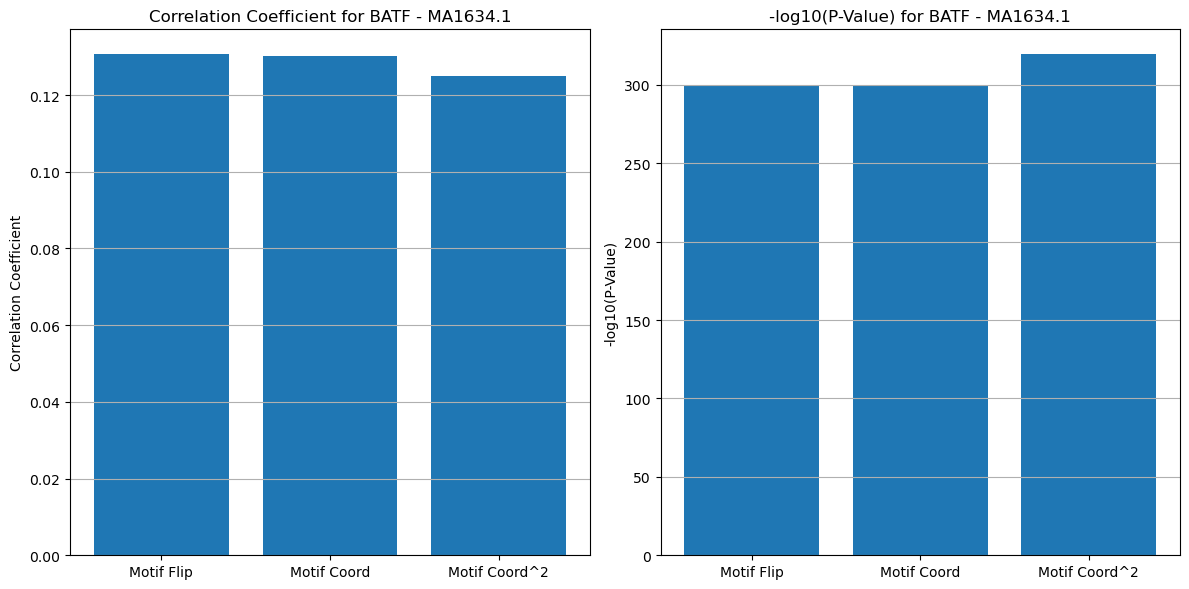

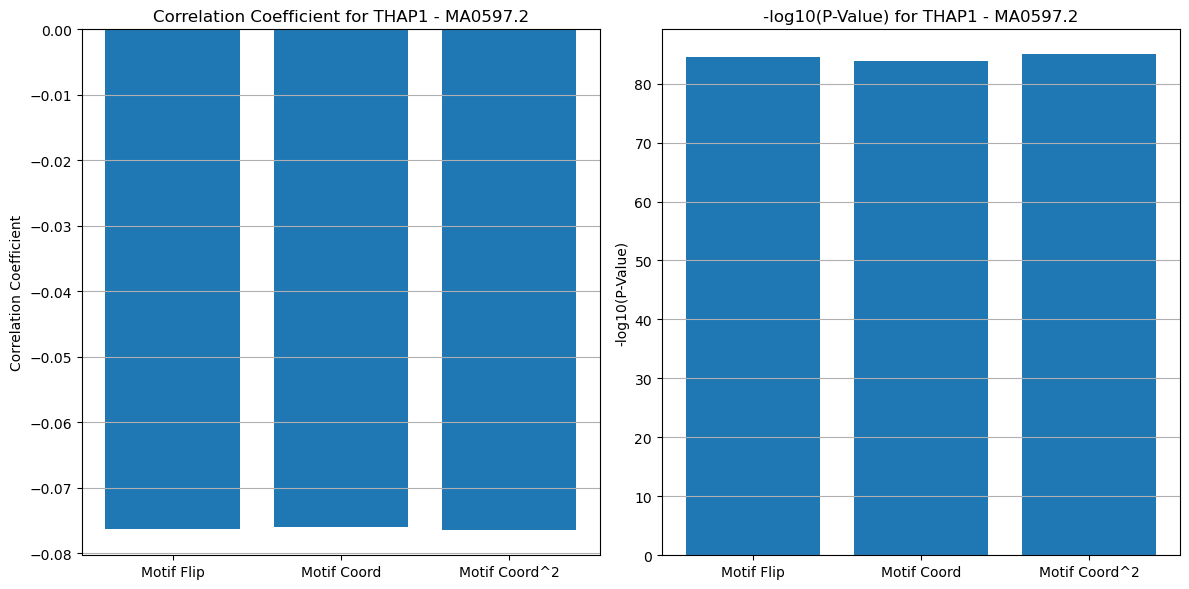

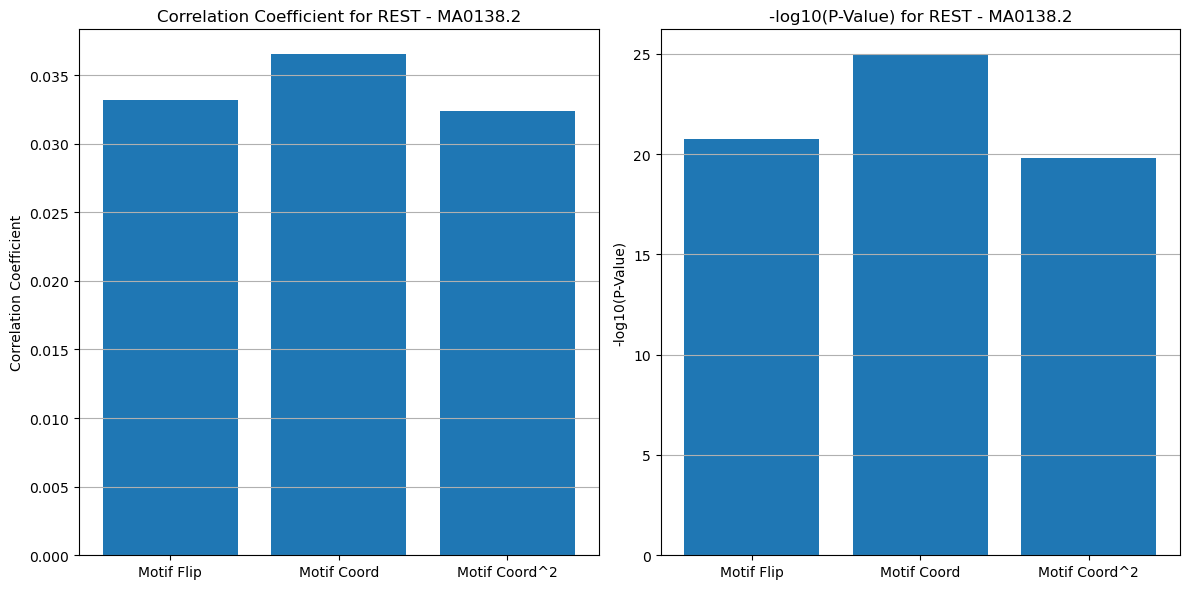

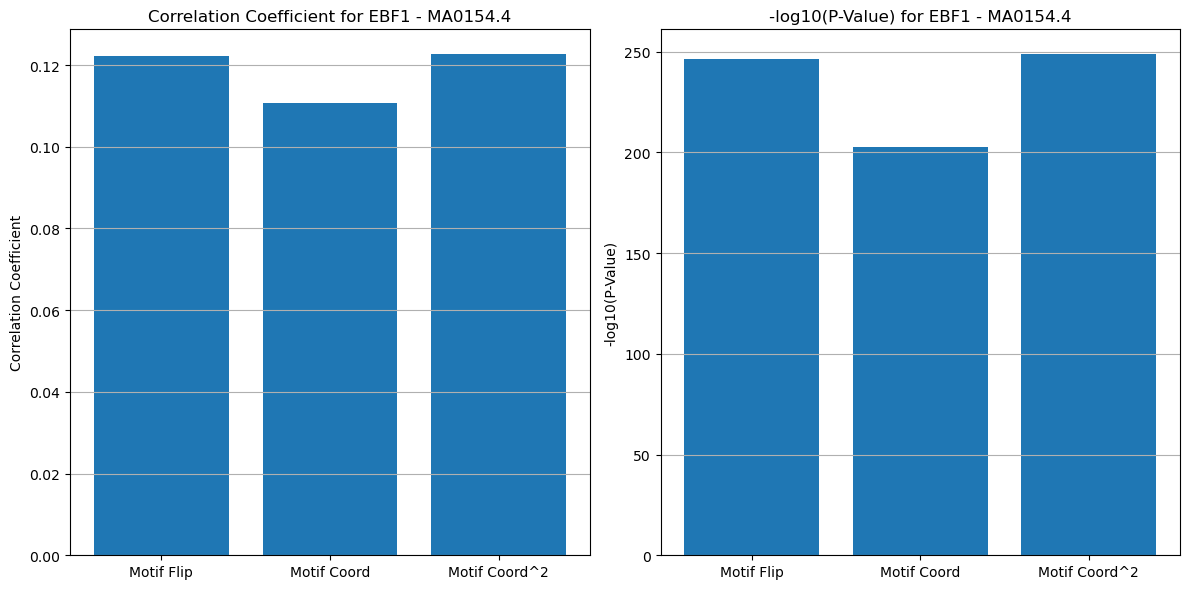

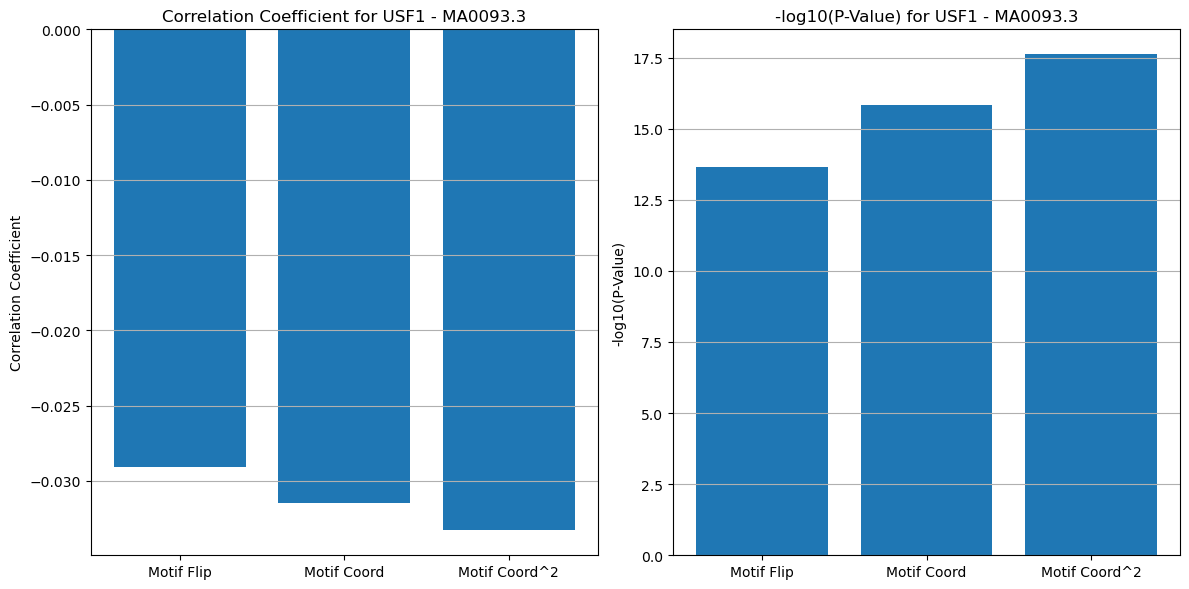

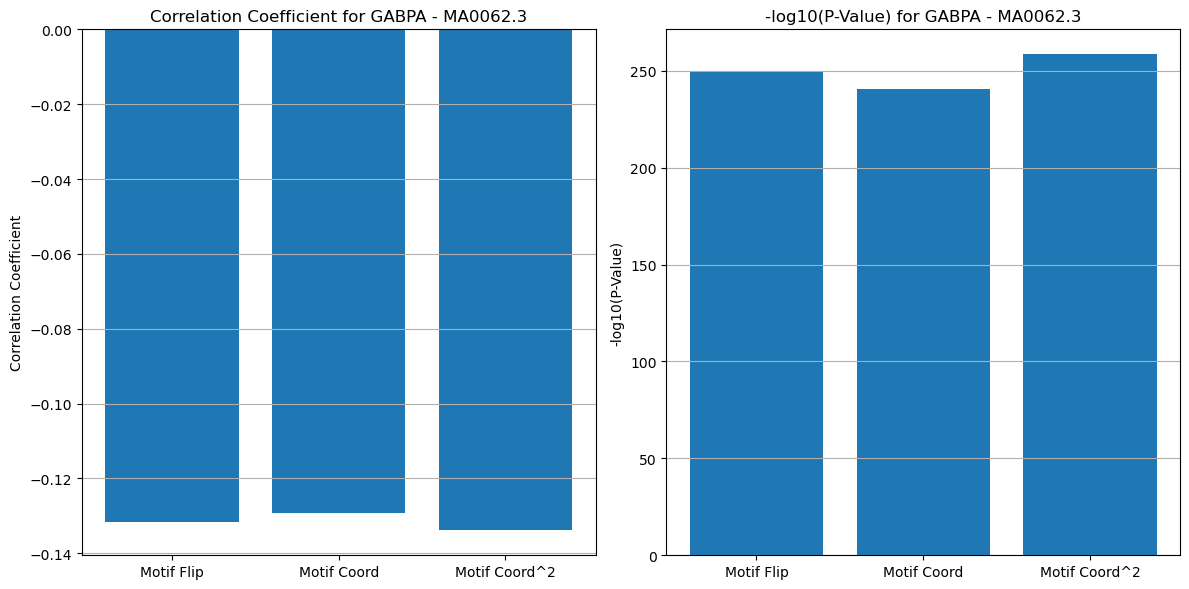

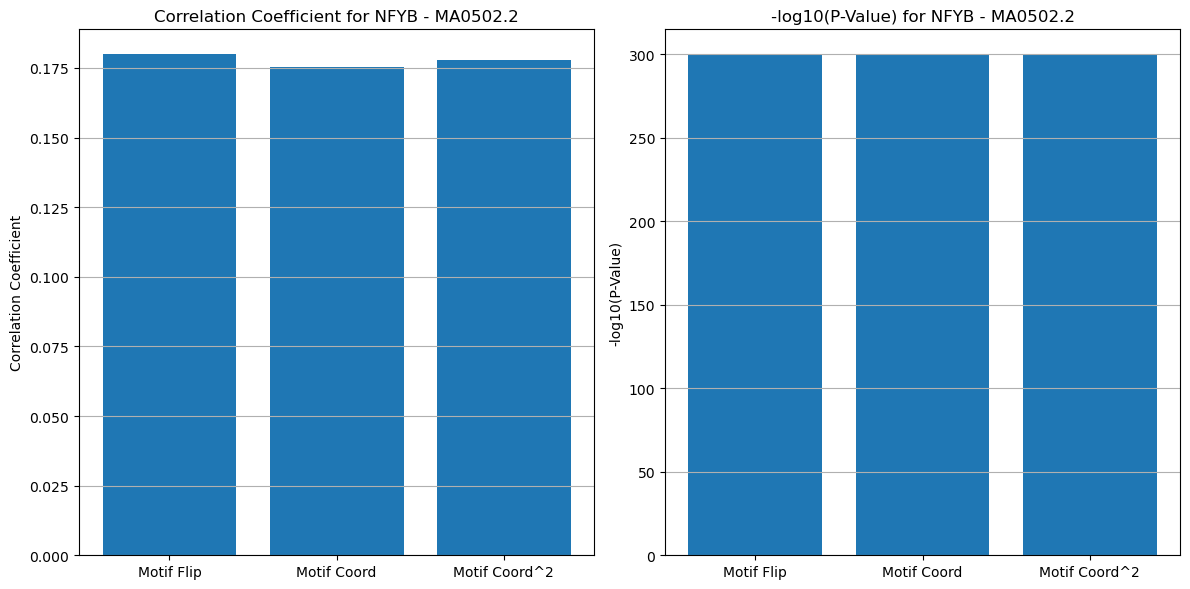

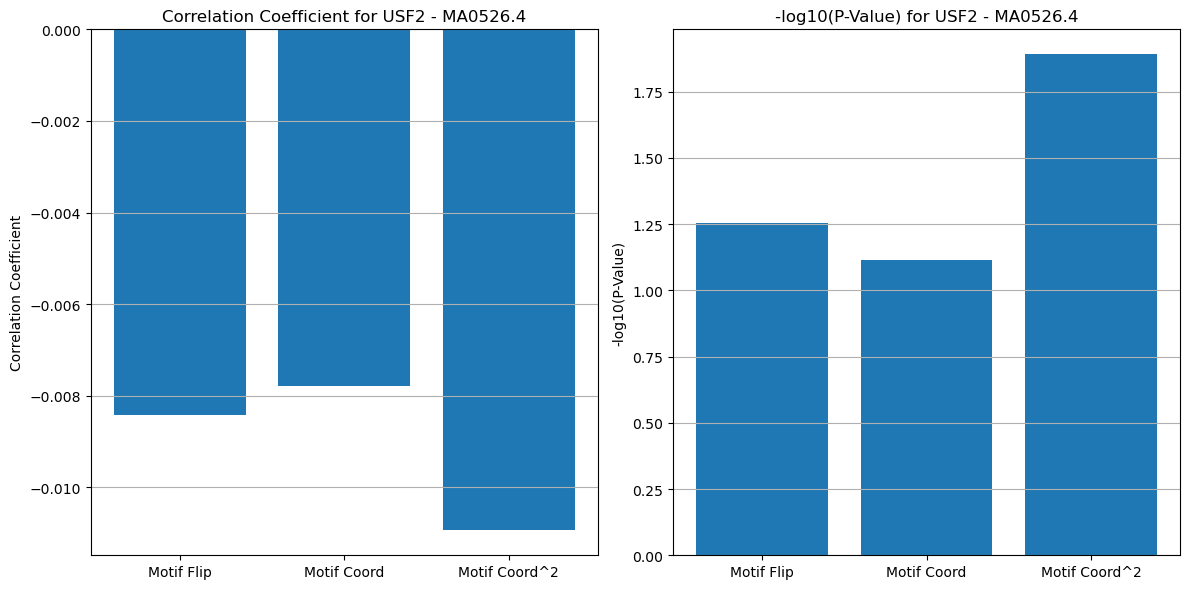

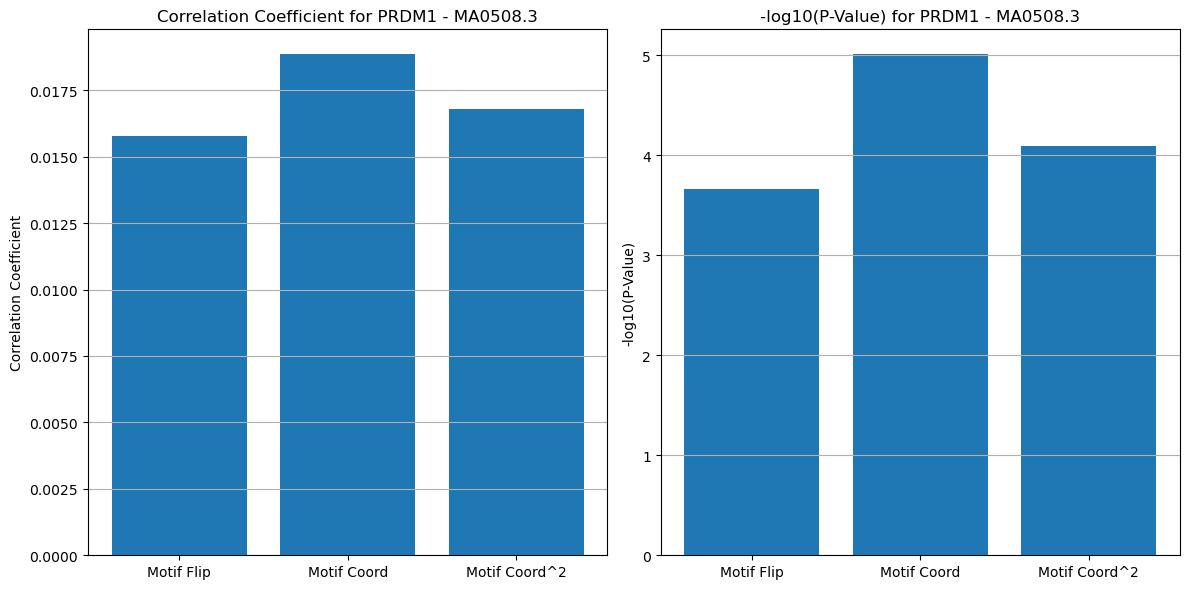

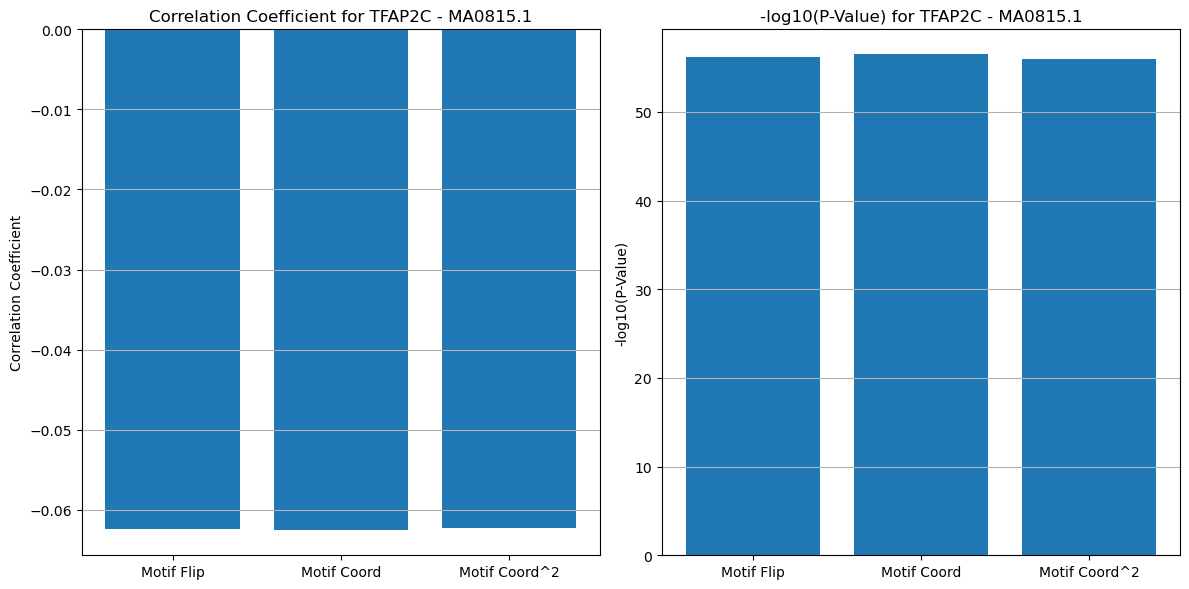

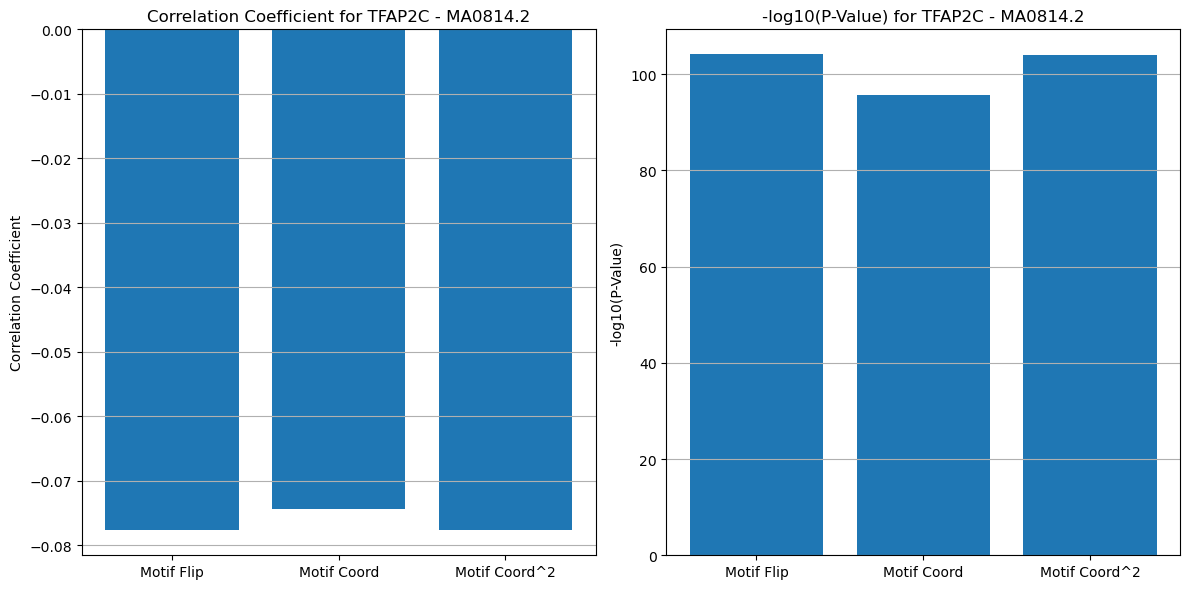

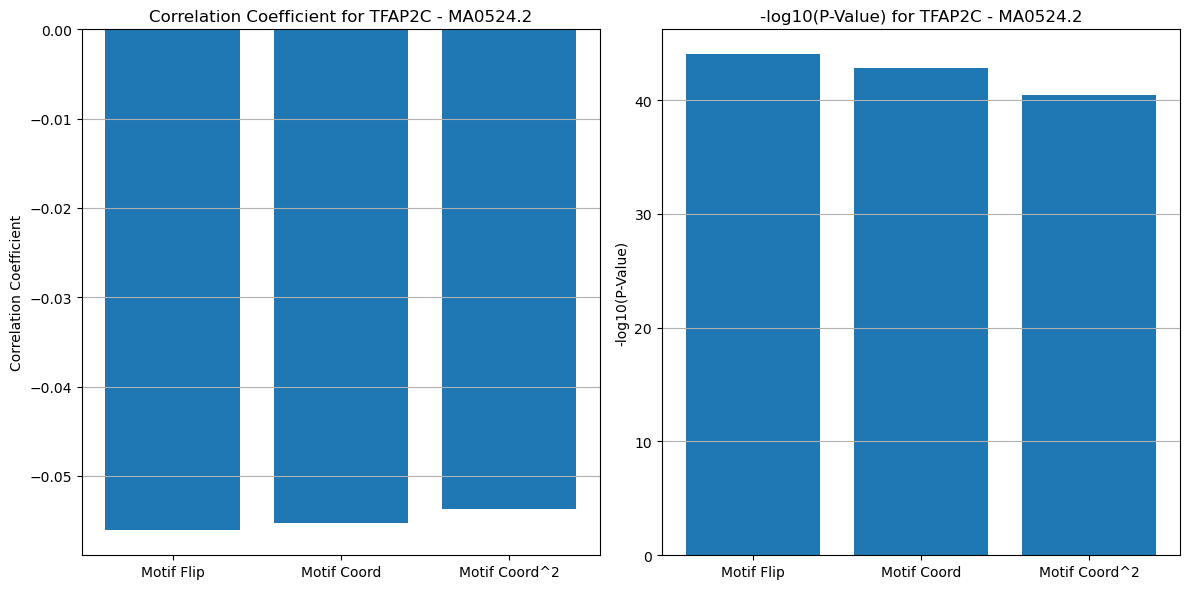

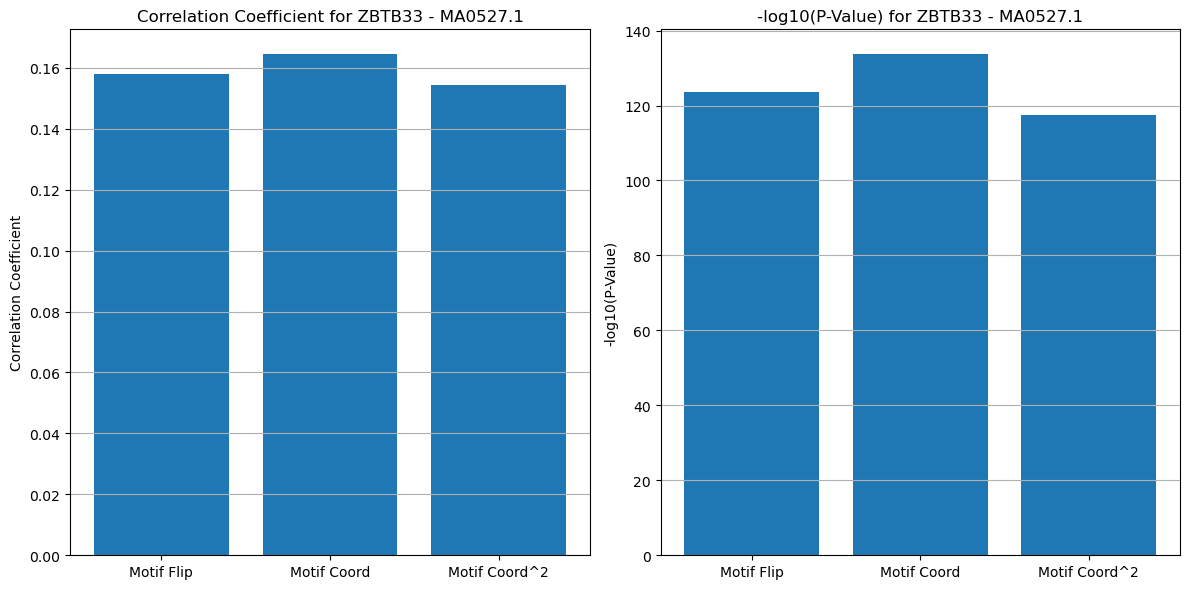

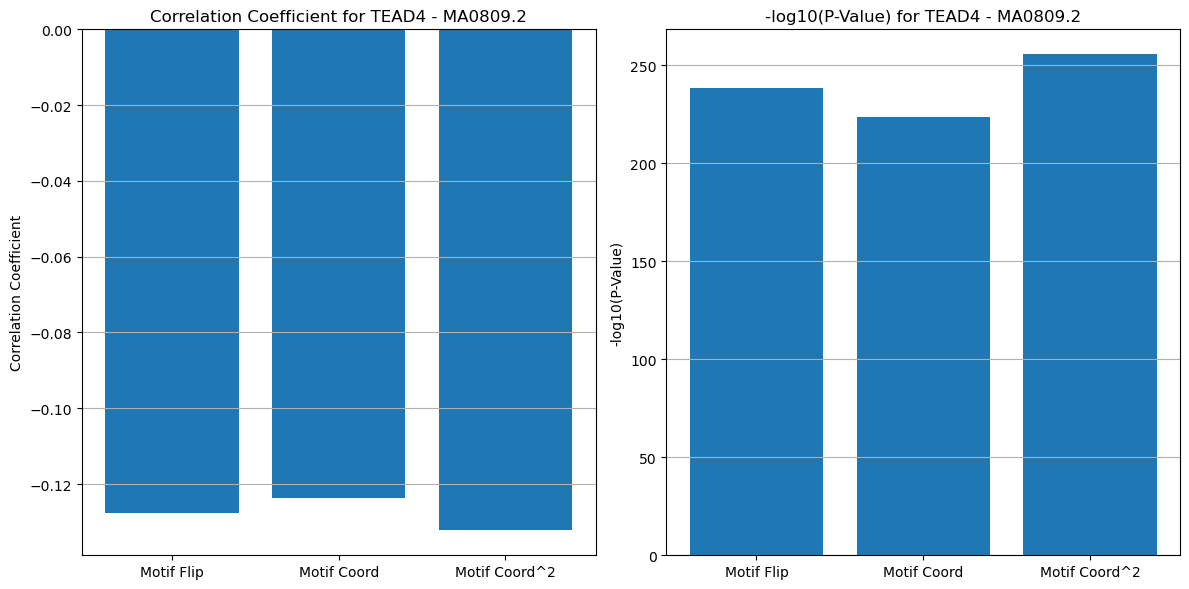

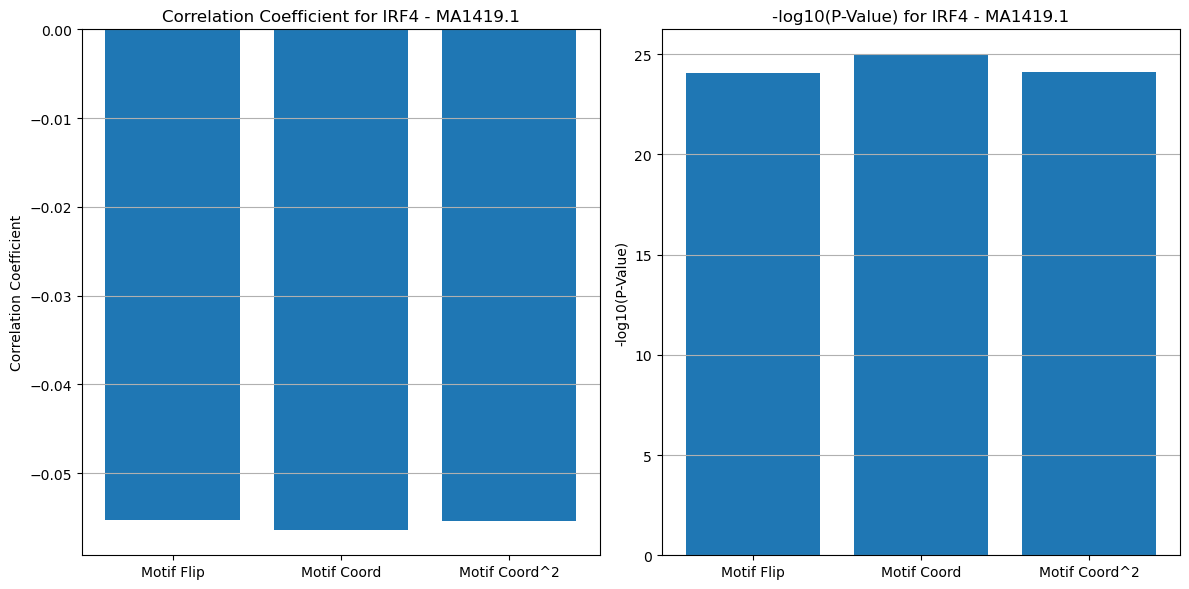

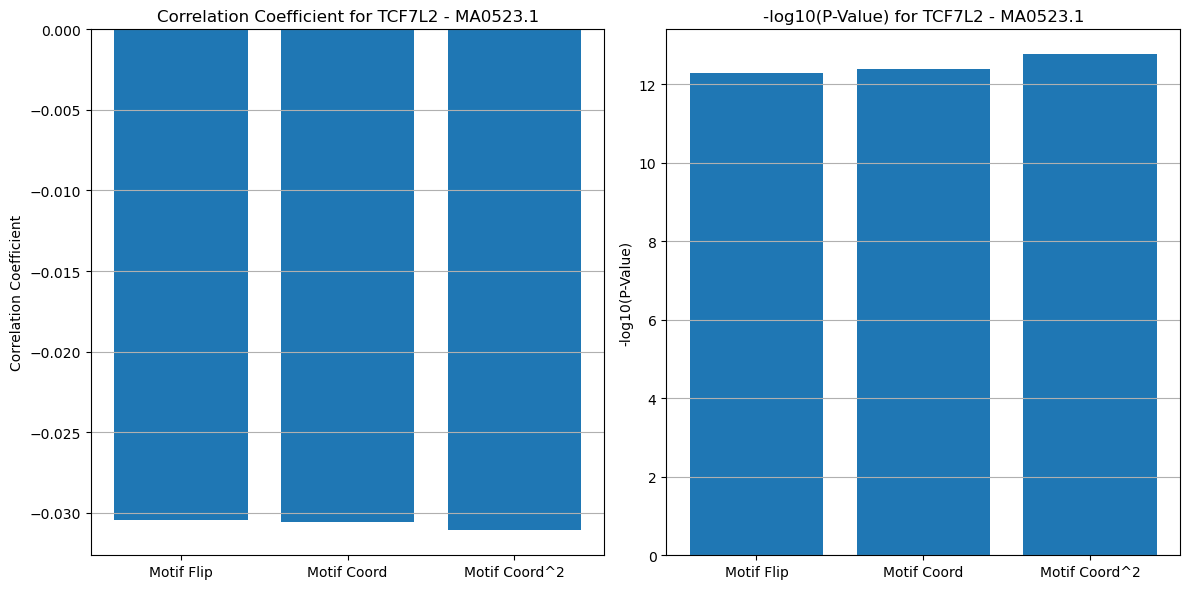

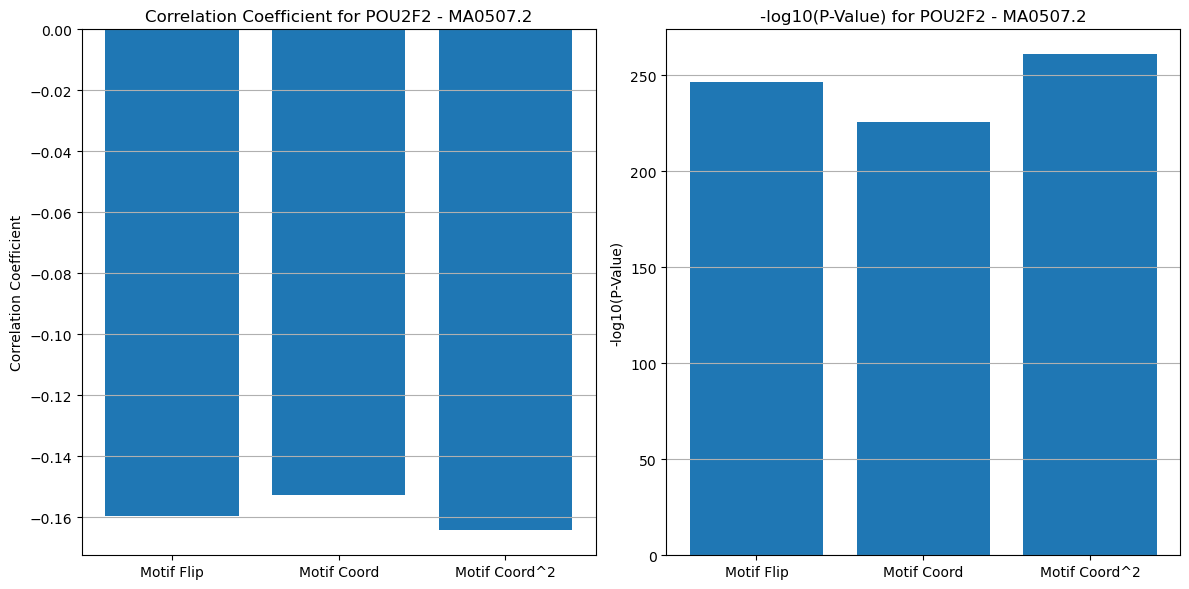

In [ ]:
# use plotly.express to make bargraphs for each matrix id for each tf, showing the correlation coefficient and p-value for each feature 
for row in correlation_results_df.itertuples():
    # get the tf and matrix id
    tf = row.tf
    matrix_id = row.matrix_id
    # get the correlation coefficient and p-value for each feature, and turn the p-value into -log10(p-value), and if the p-value is 0, then turn it into -log10(1e-300)
    motif_flip_corr = row.motif_flip_corr
    motif_flip_pval = -np.log10(row.motif_flip_pval) if row.motif_flip_pval != 0 else -np.log10(1e-300)
    motif_coord_corr = row.motif_coord_corr
    motif_coord_pval = -np.log10(row.motif_coord_pval) if row.motif_coord_pval != 0 else -np.log10(1e-300)
    motif_coordsq_corr = row.motif_coordsq_corr
    motif_coordsq_pval = -np.log10(row.motif_coordsq_pval) if row.motif_coordsq_pval != 0 else -np.log10(1e-300)
    # make separate bargraphs for correlation coefficients and p-values
    plt.figure(figsize=(12, 6))

    plt.subplot(121)
    plt.bar(['Motif Flip', 'Motif Coord', 'Motif Coord^2'], [motif_flip_corr, motif_coord_corr, motif_coordsq_corr])
    plt.ylabel('Correlation Coefficient')
    plt.title(f'Correlation Coefficient for {tf} - {matrix_id}')
    plt.grid(axis='y')

    plt.subplot(122)
    plt.bar(['Motif Flip', 'Motif Coord', 'Motif Coord^2'], [motif_flip_pval, motif_coord_pval, motif_coordsq_pval])
    plt.ylabel('-log10(P-Value)')
    plt.title(f'-log10(P-Value) for {tf} - {matrix_id}')
    plt.grid(axis='y')

    plt.tight_layout()
    plt.show()

In [ ]:
# get values of min and max p-value from fimo_dict['ATF3']['MA0605.2']
fimo_dict['ATF3']['MA0605.2'].head()

motif_id motif_alt_id  sequence_name  start  stop strand     score  \
915    MA0605.2         ATF3           3570     65    76      -  16.61700   
909    MA0605.2         ATF3           3570     65    76      +  16.61700   
1010   MA0605.2         ATF3           3570     90   101      +  16.08510   
1011   MA0605.2         ATF3           3570     90   101      -  16.08510   
30252  MA0605.2         ATF3           3701    155   166      -   2.89362   

        p-value  q-value matched_sequence  \
915    0.000003    0.908     CGTGACGTCACA   
909    0.000003    0.908     TGTGACGTCACG   
1010   0.000004    0.908     TGTGACGTCACA   
1011   0.000004    0.908     TGTGACGTCACA   
30252  0.000089    0.989     GCTGATGTAACT   

                                                   coord  \
915    [0.1381, 0.1392, 0.1921, 0.1584, 0.2025, 0.142...   
909    [0.1593, 0.1988, 0.161, 0.2027, 0.143, 0.1429,...   
1010   [0.1595, 0.1991, 0.1614, 0.2027, 0.1429, 0.143...   
1011   [0.1949, 0.155, 0.1973, 0.1605, 0.2028, 0.143,...   
30252  [0.1392, 0.1421, 0.1951, 0.165, 0.2244, 0.2191...   

                                                coord_sq  \
915    [0.0953, 0.0945, 0.1327, 0.1171, 0.146, 0.1004...   
909    [0.1192, 0.1423, 0.1214, 0.1466, 0.1002, 0.100...   
1010   [0.1195, 0.1433, 0.1223, 0.1464, 0.1, 0.1002, ...   
1011   [0.1377, 0.114, 0.1408, 0.121, 0.1467, 0.1002,...   
30252  [0.0934, 0.0971, 0.137, 0.1274, 0.1751, 0.1709...   

                                                    flip label  
915    [0.0479, 0.048, 0.0662, 0.0619, 0.0747, 0.0504...   [1]  
909    [0.062, 0.0708, 0.0639, 0.0748, 0.0504, 0.0504...   [1]  
1010   [0.0622, 0.0711, 0.0641, 0.075, 0.0505, 0.0506...   [1]  
1011   [0.0679, 0.059, 0.0693, 0.0632, 0.075, 0.0506,...   [1]  
30252  [0.0483, 0.0504, 0.0683, 0.0665, 0.0889, 0.083...   [0]

In [ ]:
positional_data = {}
for tf in fimo_dict.keys():
    positional_data[tf] = {}
    for matrix_id in fimo_dict[tf].keys():
        length = len(fimo_dict[tf][matrix_id]['coord'][0])
        try:
            label_length = len(fimo_dict[tf][matrix_id]['label'][0])
        except (TypeError):
            label_length = len(fimo_dict[tf][matrix_id]['label'])
        positional_data[tf][matrix_id] = {}
        for i in range(length):
            positional_data[tf][matrix_id][i] = {
                'motif_flip': [],
                'motif_coord': [],
                'motif_coordsq': [],
                'binding_affinity': [],
            }
        for row in fimo_dict[tf][matrix_id].itertuples():
            for i in range(length):
                positional_data[tf][matrix_id][i]['motif_flip'].append(row.flip[i])
                positional_data[tf][matrix_id][i]['motif_coord'].append(row.coord[i])
                positional_data[tf][matrix_id][i]['motif_coordsq'].append(row.coord_sq[i])
                try:
                    positional_data[tf][matrix_id][i]['binding_affinity'].append(mean(row.label))
                except (TypeError):
                    positional_data[tf][matrix_id][i]['binding_affinity'].append(row.label)
        if label_length == 1:
            for i in range(length):
                positional_data[tf][matrix_id][i]['motif_flip_corr'], positional_data[tf][matrix_id][i]['motif_flip_pval'] = stats.pointbiserialr(positional_data[tf][matrix_id][i]['motif_flip'], positional_data[tf][matrix_id][i]['binding_affinity'])
                positional_data[tf][matrix_id][i]['motif_coord_corr'], positional_data[tf][matrix_id][i]['motif_coord_pval'] = stats.pointbiserialr(positional_data[tf][matrix_id][i]['motif_coord'], positional_data[tf][matrix_id][i]['binding_affinity'])
                positional_data[tf][matrix_id][i]['motif_coordsq_corr'], positional_data[tf][matrix_id][i]['motif_coordsq_pval'] = stats.pointbiserialr(positional_data[tf][matrix_id][i]['motif_coordsq'], positional_data[tf][matrix_id][i]['binding_affinity'])
        else:
            for i in range(length):
                positional_data[tf][matrix_id][i]['motif_flip_corr'], positional_data[tf][matrix_id][i]['motif_flip_pval'] = pearsonr(positional_data[tf][matrix_id][i]['motif_flip'], positional_data[tf][matrix_id][i]['binding_affinity'])
                positional_data[tf][matrix_id][i]['motif_coord_corr'], positional_data[tf][matrix_id][i]['motif_coord_pval'] = pearsonr(positional_data[tf][matrix_id][i]['motif_coord'], positional_data[tf][matrix_id][i]['binding_affinity'])
                positional_data[tf][matrix_id][i]['motif_coordsq_corr'], positional_data[tf][matrix_id][i]['motif_coordsq_pval'] = pearsonr(positional_data[tf][matrix_id][i]['motif_coordsq'], positional_data[tf][matrix_id][i]['binding_affinity'])

/scratch/local/jobs/21708835/ipykernel_773571/2815160375.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  length = len(fimo_dict[tf][matrix_id]['coord'][0])
/scratch/local/jobs/21708835/ipykernel_773571/2815160375.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label_length = len(fimo_dict[tf][matrix_id]['label'][0])


In [ ]:
import numpy as np
from scipy.stats import pearsonr, pointbiserialr

positional_data = {}

for tf, matrices in fimo_dict.items():
    positional_data[tf] = {}

    for matrix_id, df in matrices.items():
        length = len(df['coord'][0])
        
        # Initialize the positional data dictionary
        pos_data = {
            i: {
                'motif_flip': [],
                'motif_coord': [],
                'motif_coordsq': [],
                'binding_affinity': []
            }
            for i in range(length)
        }
        
        # Collect positional data
        for _, row in df.iterrows():
            for i in range(length):
                pos_data[i]['motif_flip'].append(row.flip[i])
                pos_data[i]['motif_coord'].append(row.coord[i])
                pos_data[i]['motif_coordsq'].append(row.coord_sq[i])
                pos_data[i]['binding_affinity'].append(np.mean(row.label) if isinstance(row.label, (list, np.ndarray)) else row.label)
        
        # Calculate correlations
        for i in range(length):
            flip_vals = np.array(pos_data[i]['motif_flip'])
            coord_vals = np.array(pos_data[i]['motif_coord'])
            coordsq_vals = np.array(pos_data[i]['motif_coordsq'])
            affinity_vals = np.array(pos_data[i]['binding_affinity'])

            if np.isscalar(affinity_vals[0]):
                corr_func = pearsonr if len(df['label'].iloc[0]) > 1 else pointbiserialr
            else:
                corr_func = pointbiserialr

            pos_data[i]['motif_flip_corr'], pos_data[i]['motif_flip_pval'] = corr_func(flip_vals, affinity_vals)
            pos_data[i]['motif_coord_corr'], pos_data[i]['motif_coord_pval'] = corr_func(coord_vals, affinity_vals)
            pos_data[i]['motif_coordsq_corr'], pos_data[i]['motif_coordsq_pval'] = corr_func(coordsq_vals, affinity_vals)
        
        positional_data[tf][matrix_id] = pos_data


In [ ]:
print([key for key in globals().keys()])

['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', 'open', '_', '__', '___', '__session__', '_i', '_ii', '_iii', '_i1', 'pickle', 'os', 'sys', 'glob', 'np', 'pd', 'scipy', 'MinMaxScaler', 'plt', 'signal', 'stats', 'sns', 'sm', 'mean', 'chi2_contingency', 'fisher_exact', 'ranksums', 'pearsonr', 'tqdm', 'px', '_i2', 'f', 'fimo_dict', '_i3', 'location', 'old_location', 'tf_index_file', 'max_index_file', 'handle', 'group_index', 'max_index', '_i4', 'data_file', 'panset', '_i5', 'part', 'partition', 'seq_id', 'sample', 'flat_data', 'data', 'row', 'df', '_i6', '_i7', '_i8', 'labels_array', 'max_index_for_tfs', 'tf', 'indices', 'sums', 'counts', '_i9', '_i10', '_i11', 'matrix_id', 'df_motif', '_i12', '_12', '_i13', '_13', '_i14', 'idx', '_i15', 'correlation_results', '_i16', 'correlation_results_df', '_i17', '_i18', '_i19', '_i20', '_i21', '_i22', '_22', '_i23', 'positional_data', 'le

In [ ]:
del fimo_dict
del panset
del part
del partition
del flat_data
del correlation_results
del correlation_results_df

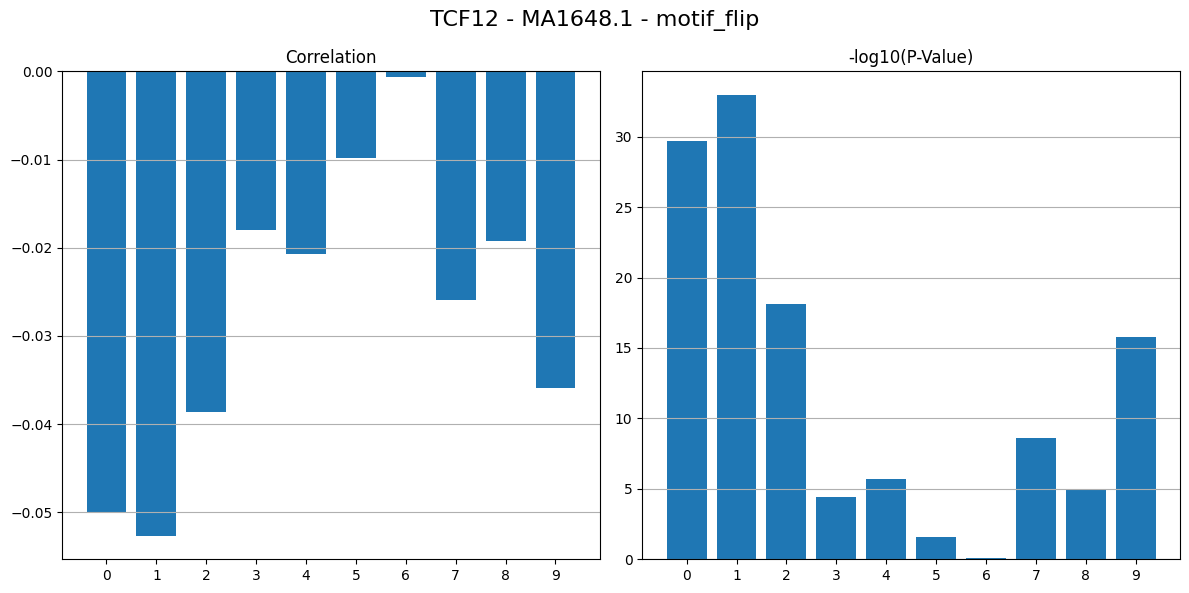

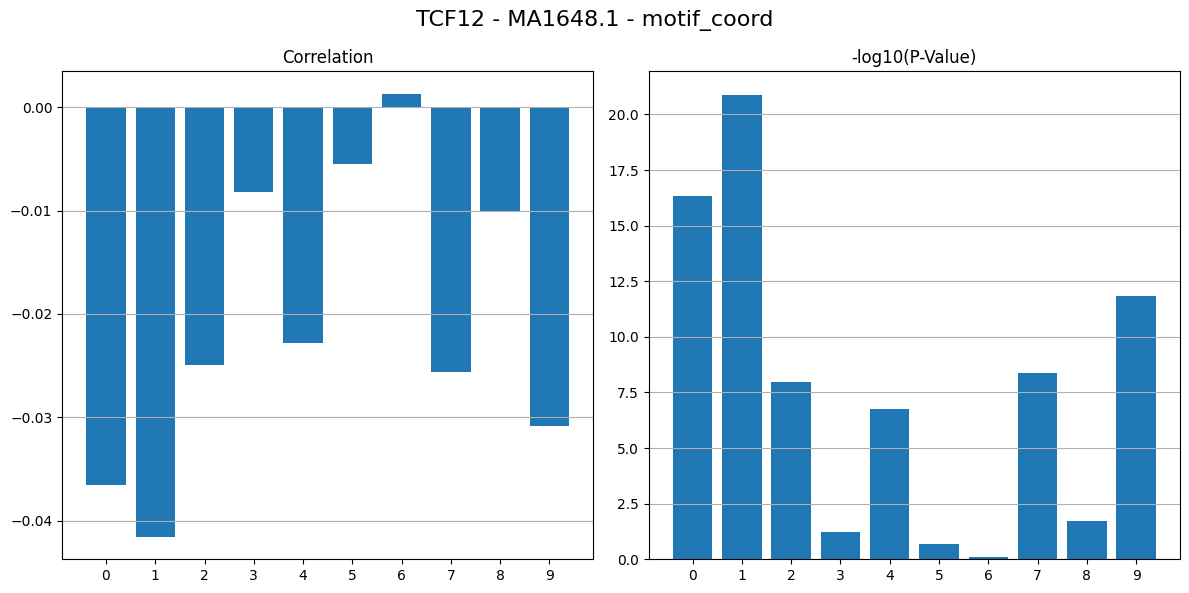

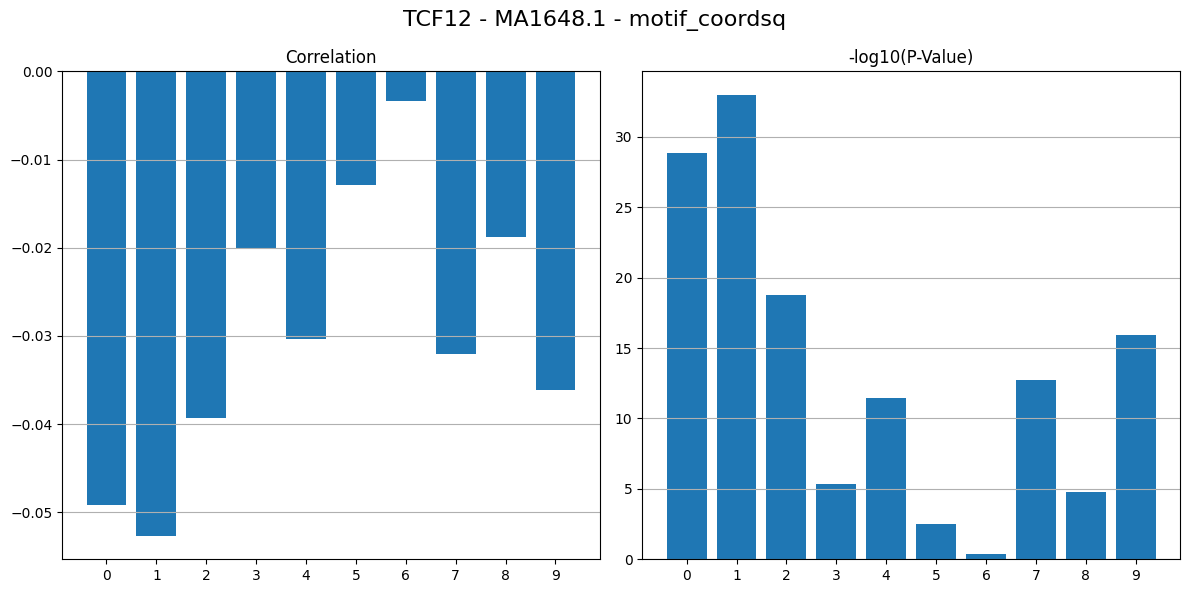

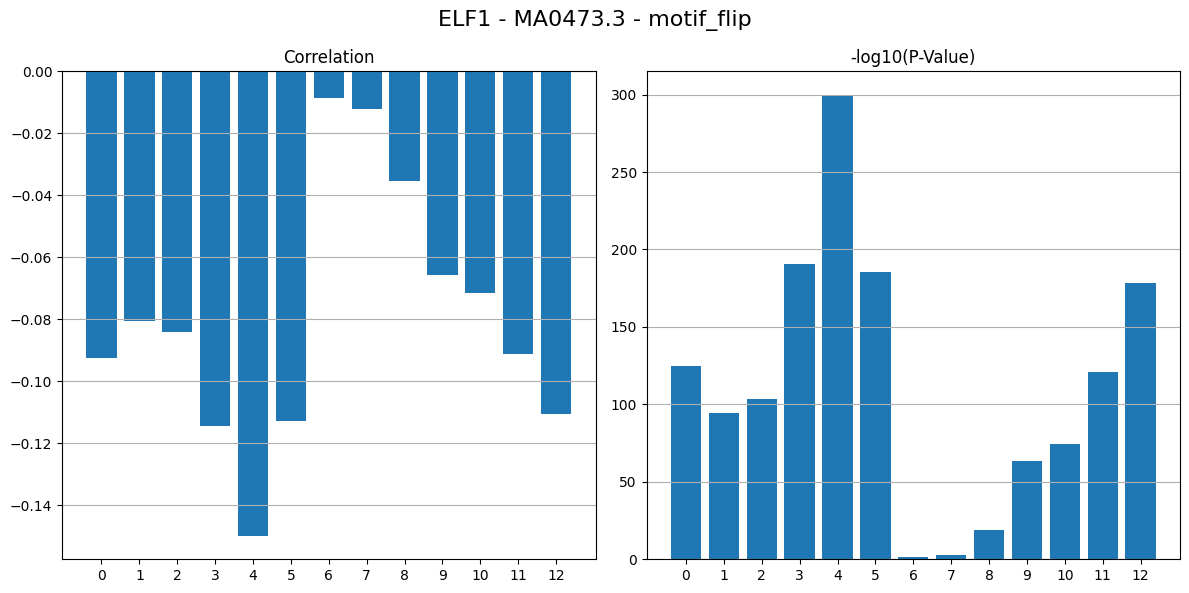

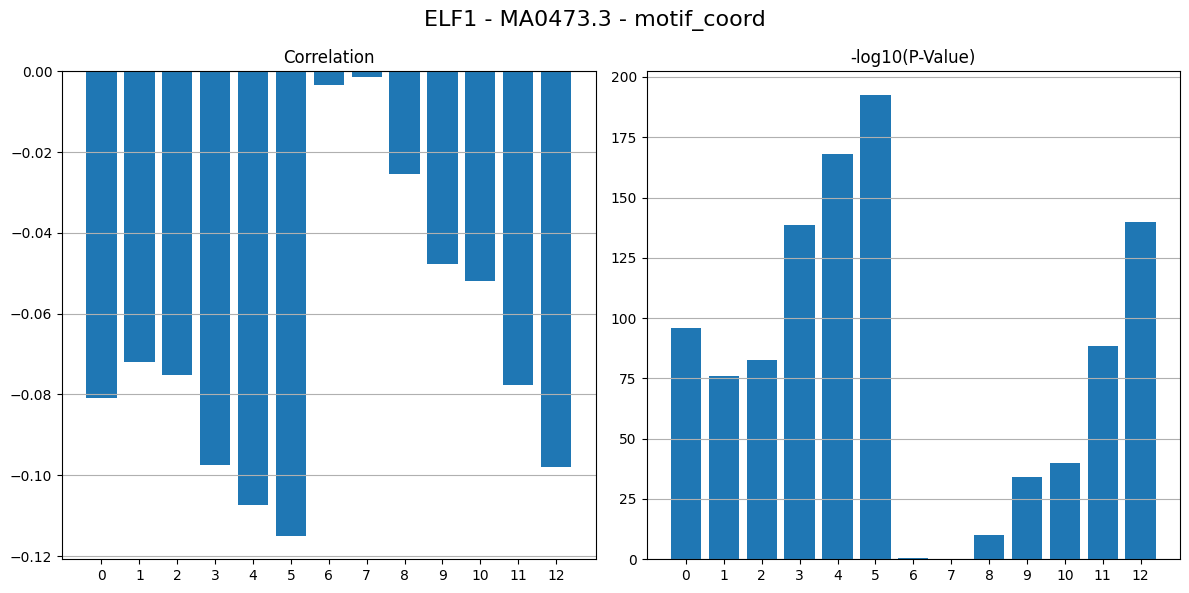

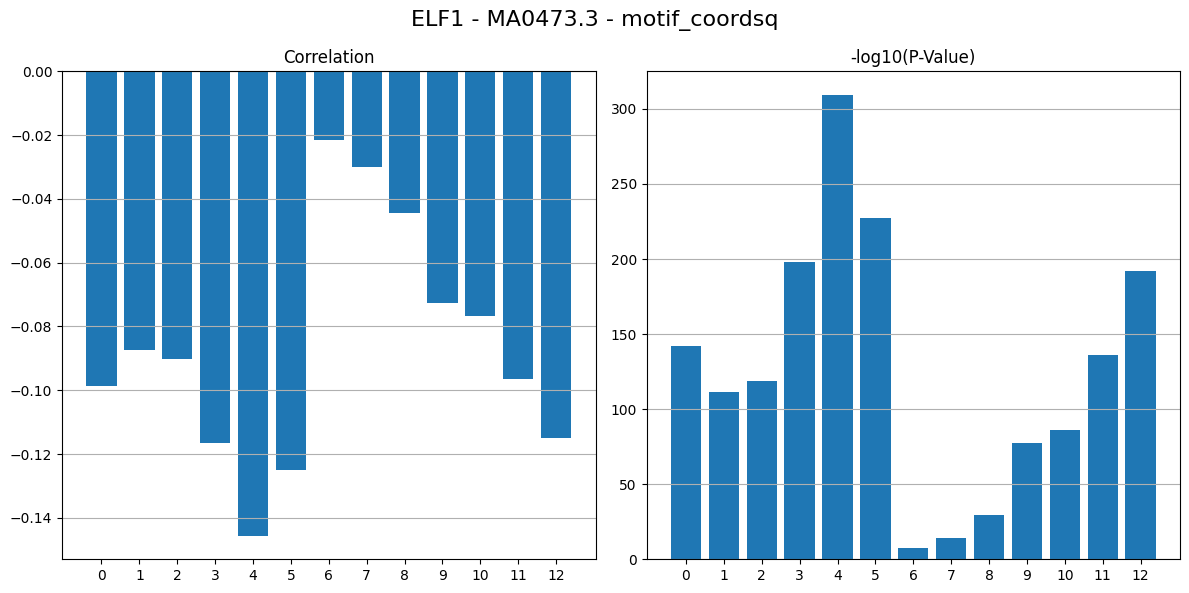

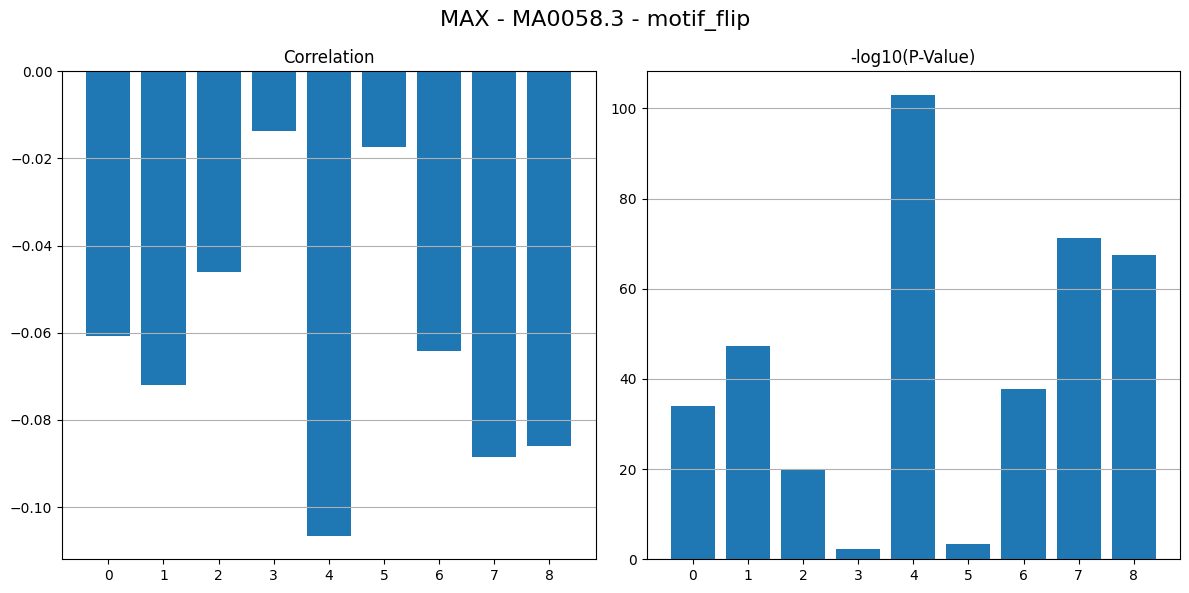

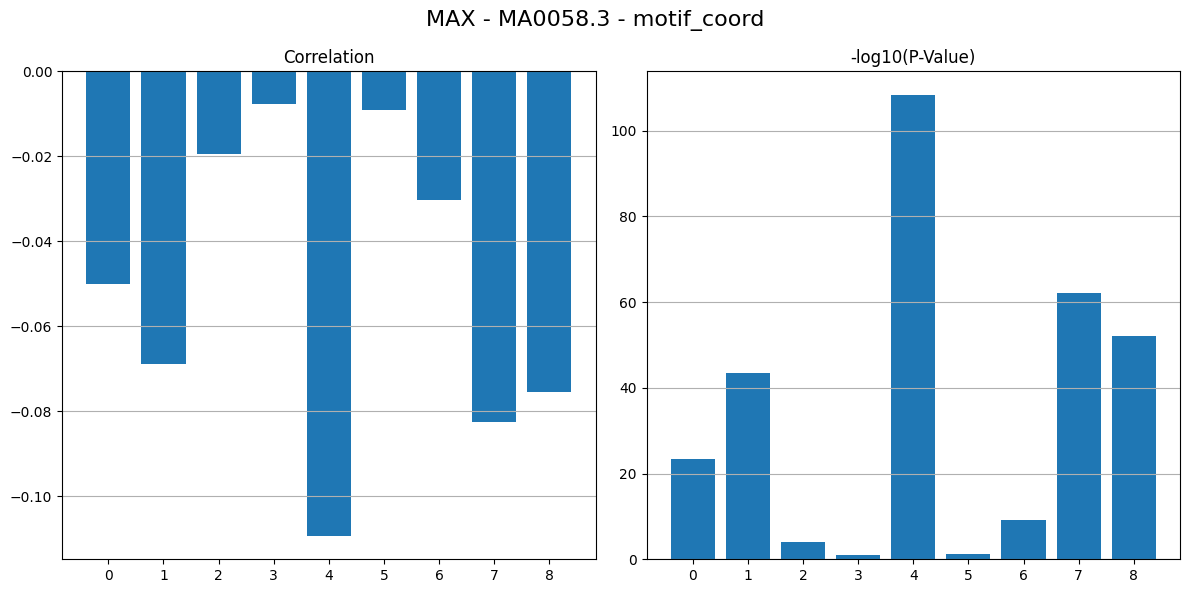

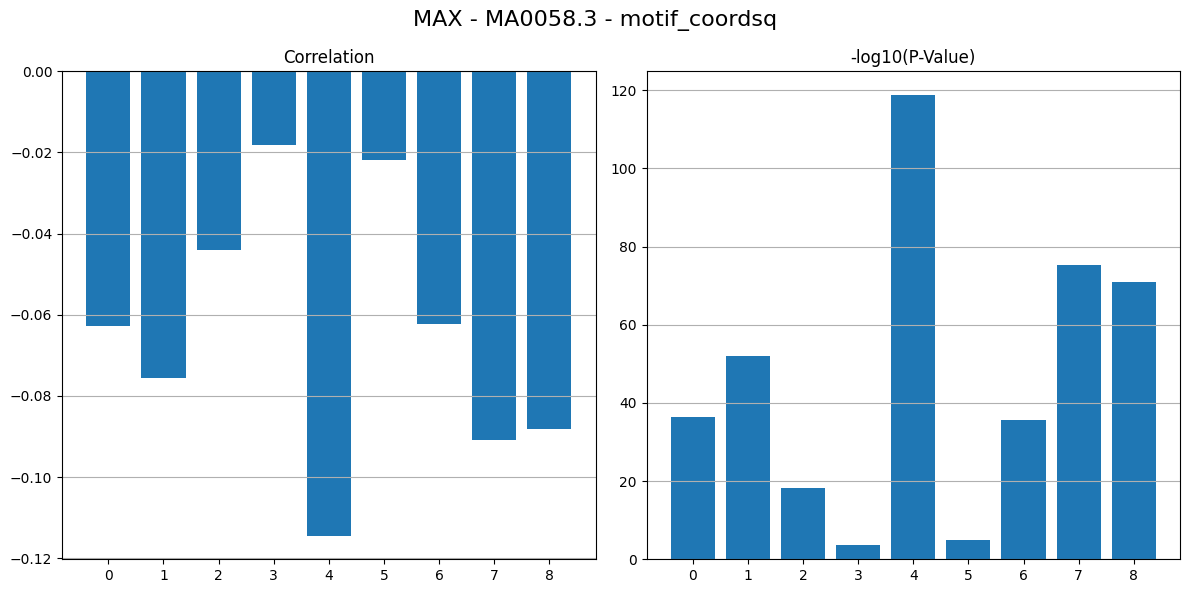

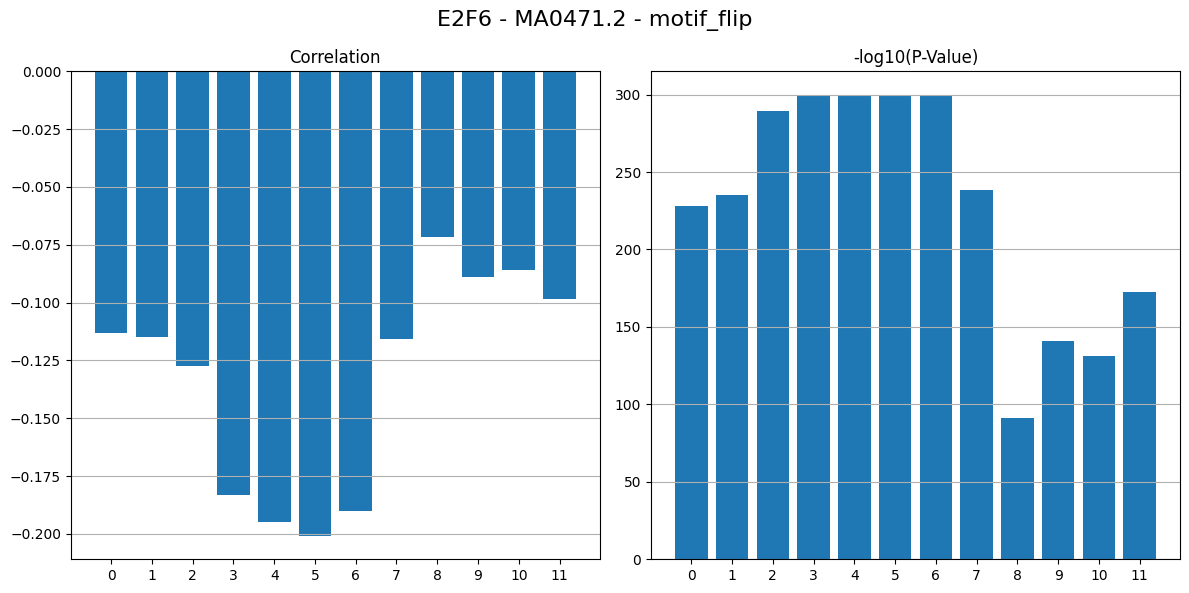

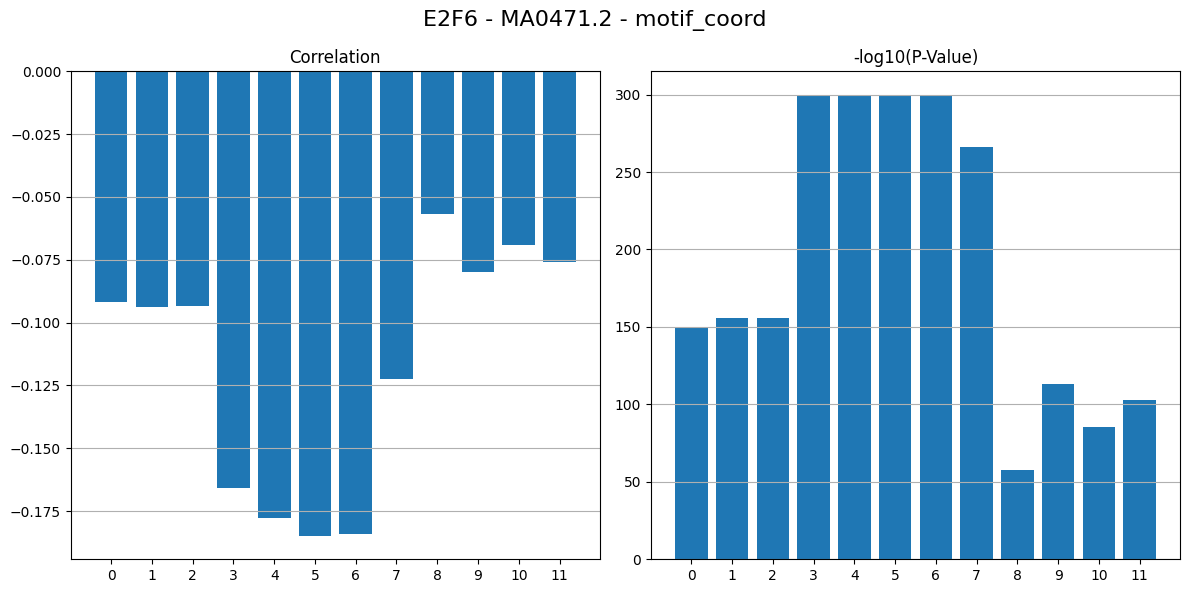

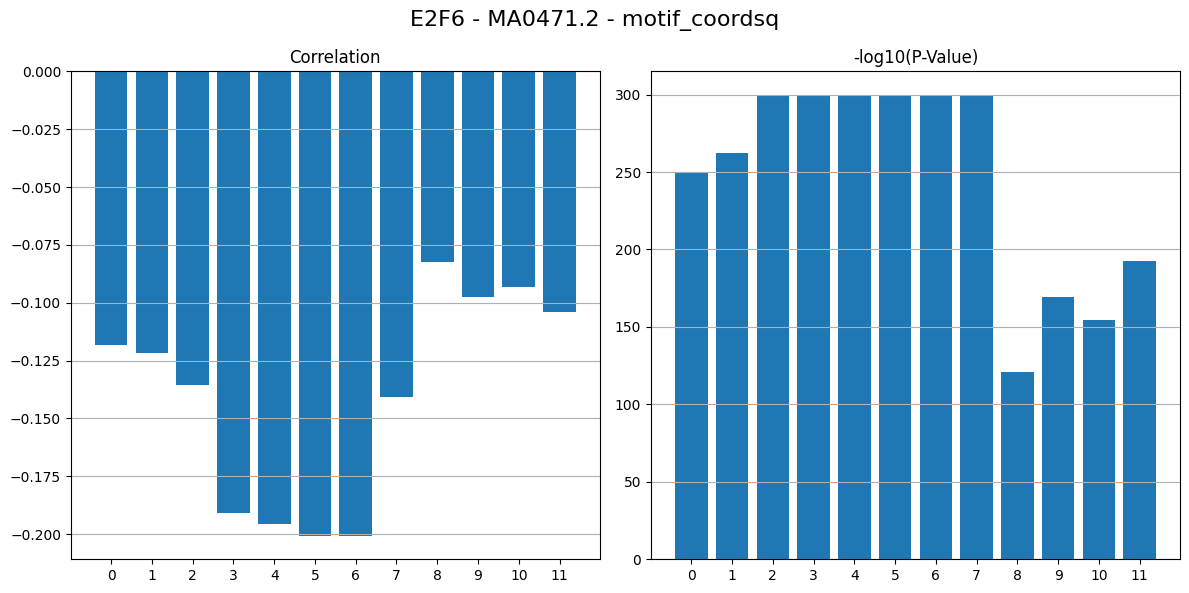

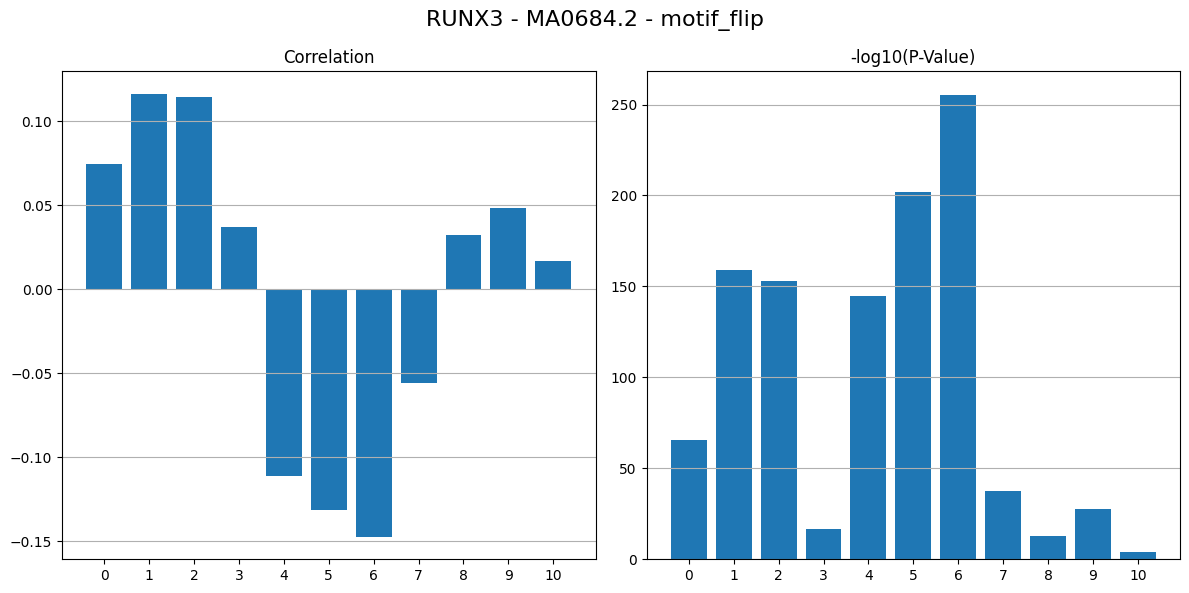

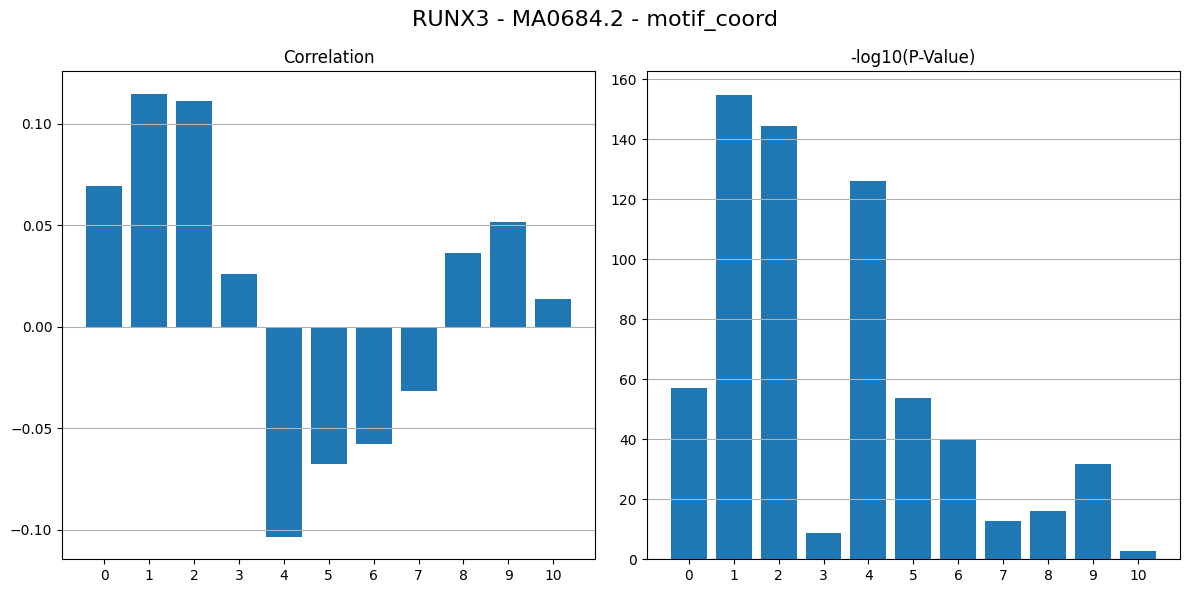

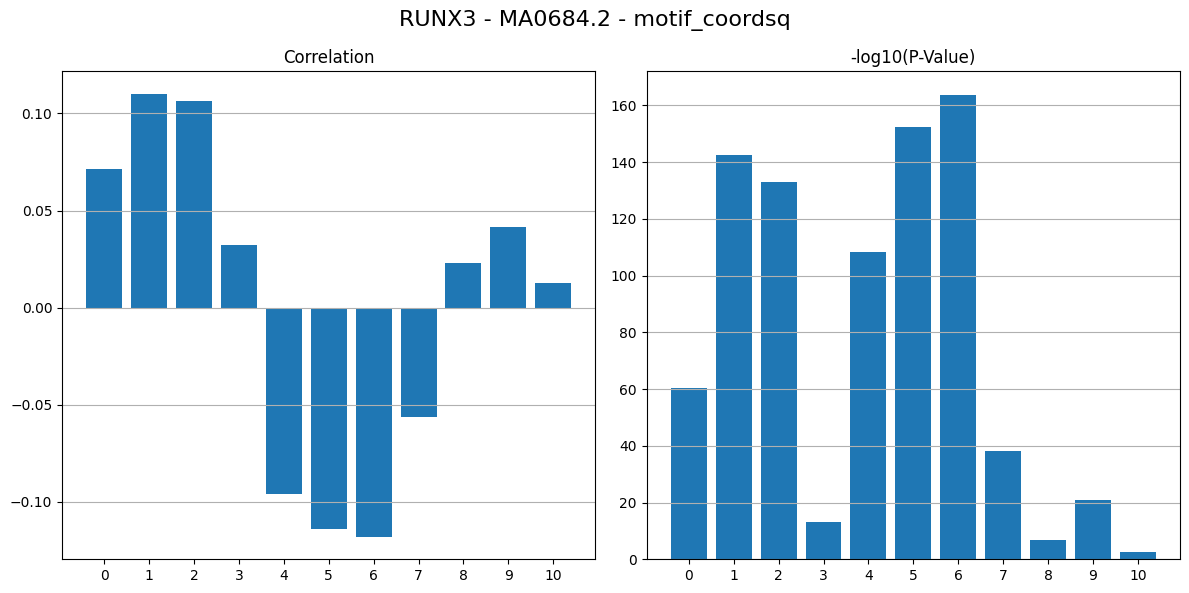

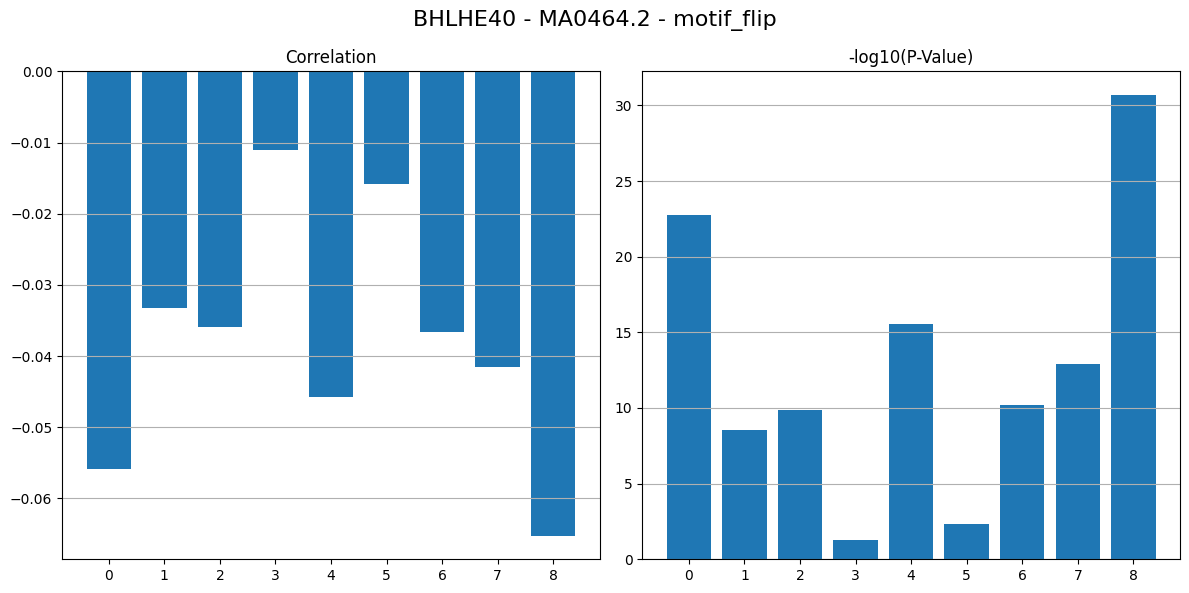

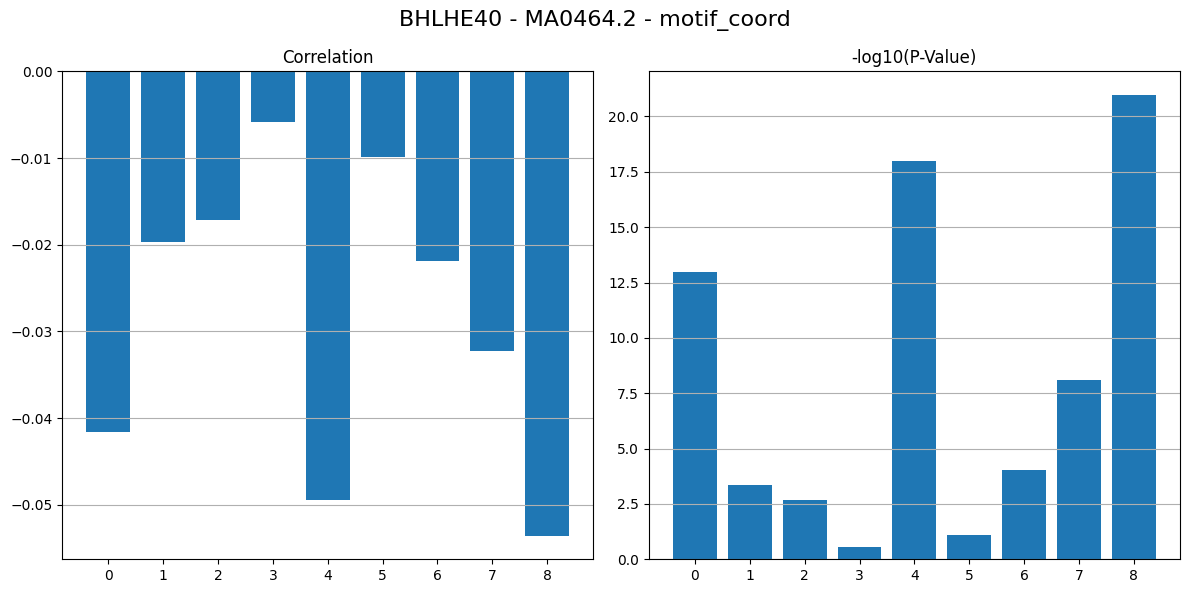

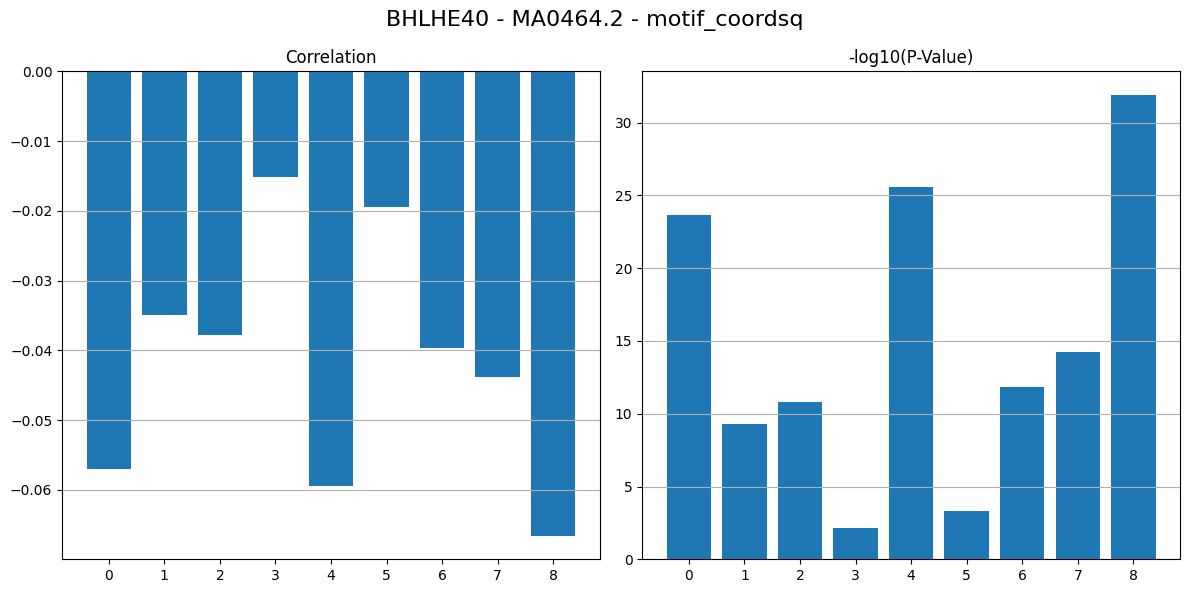

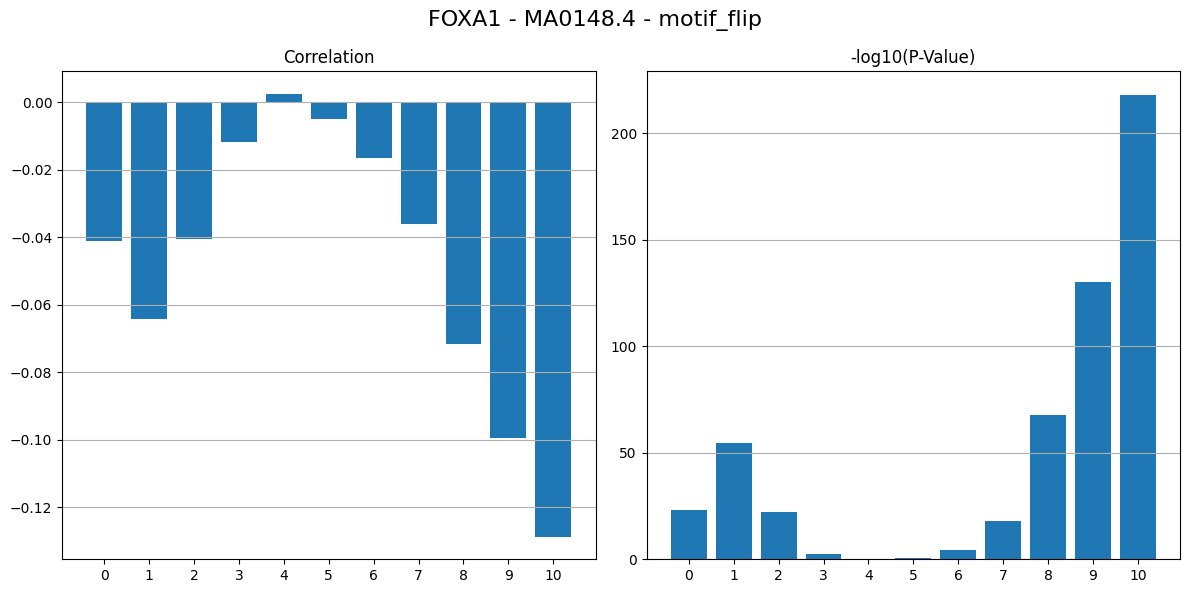

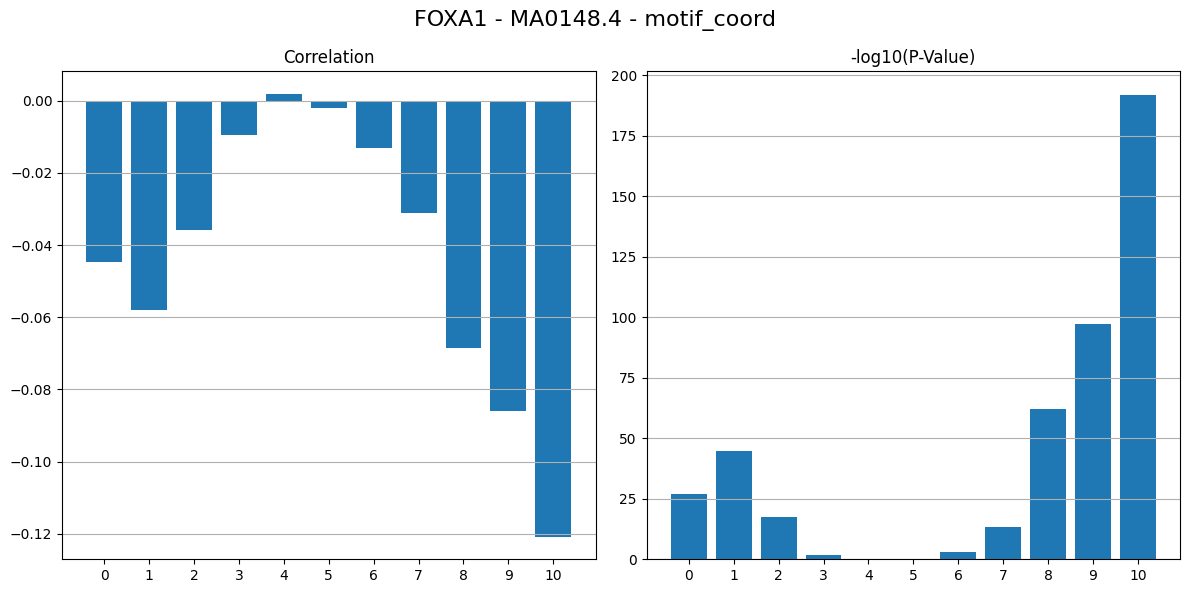

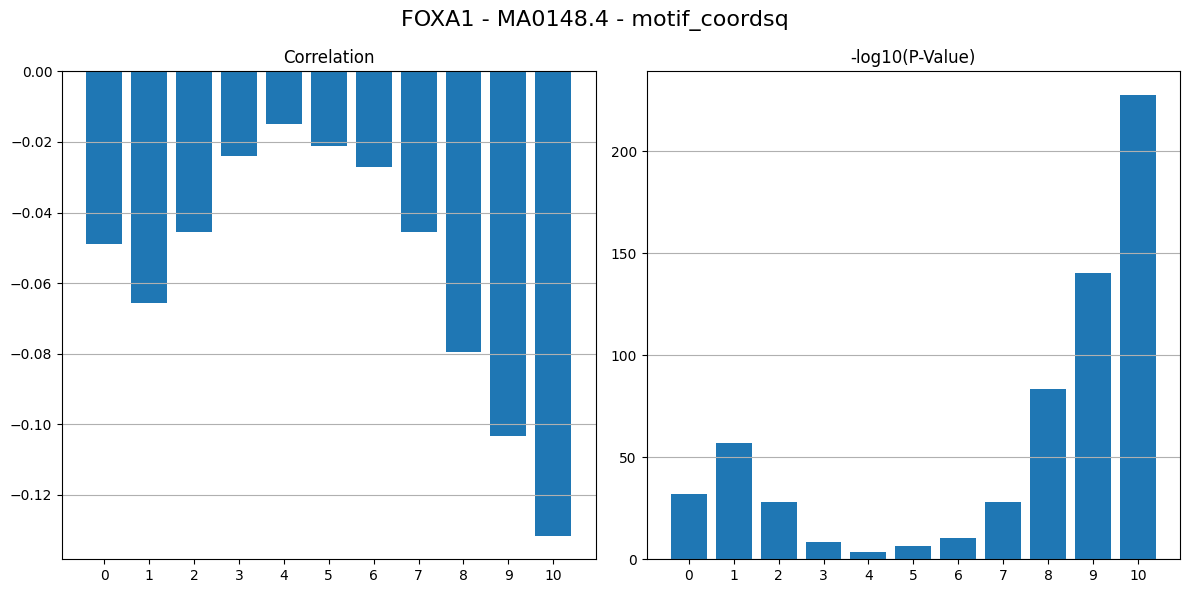

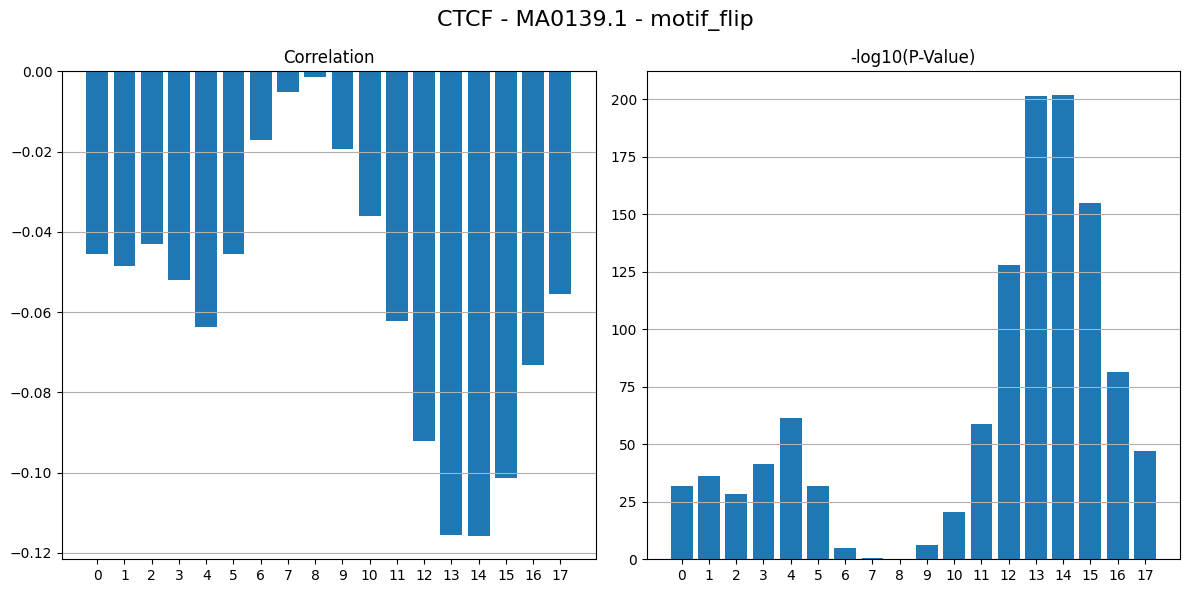

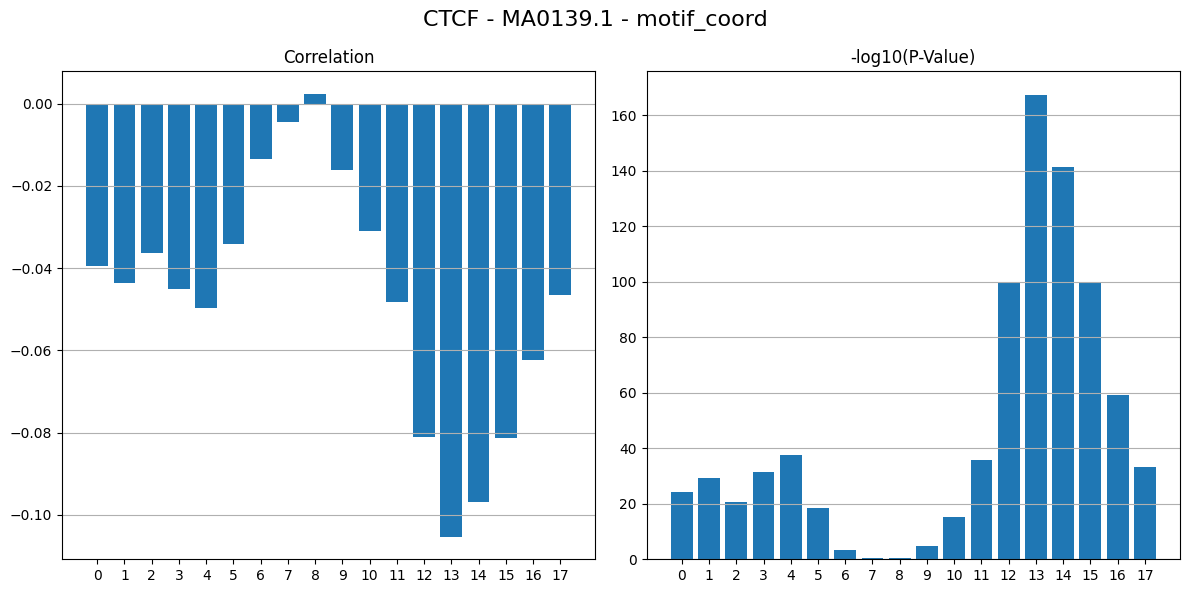

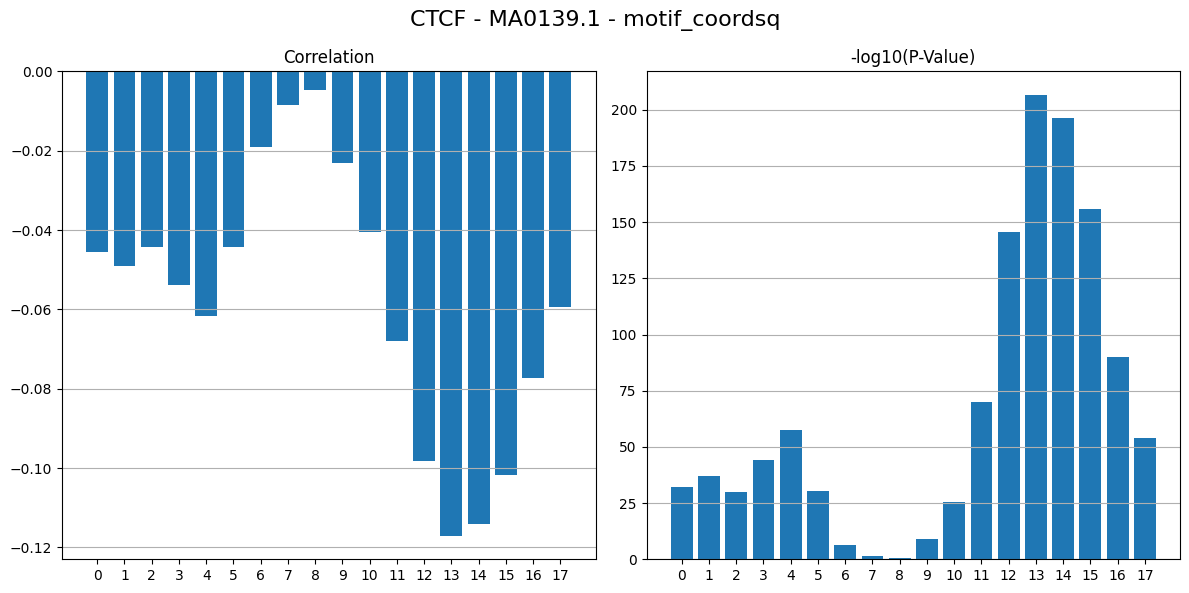

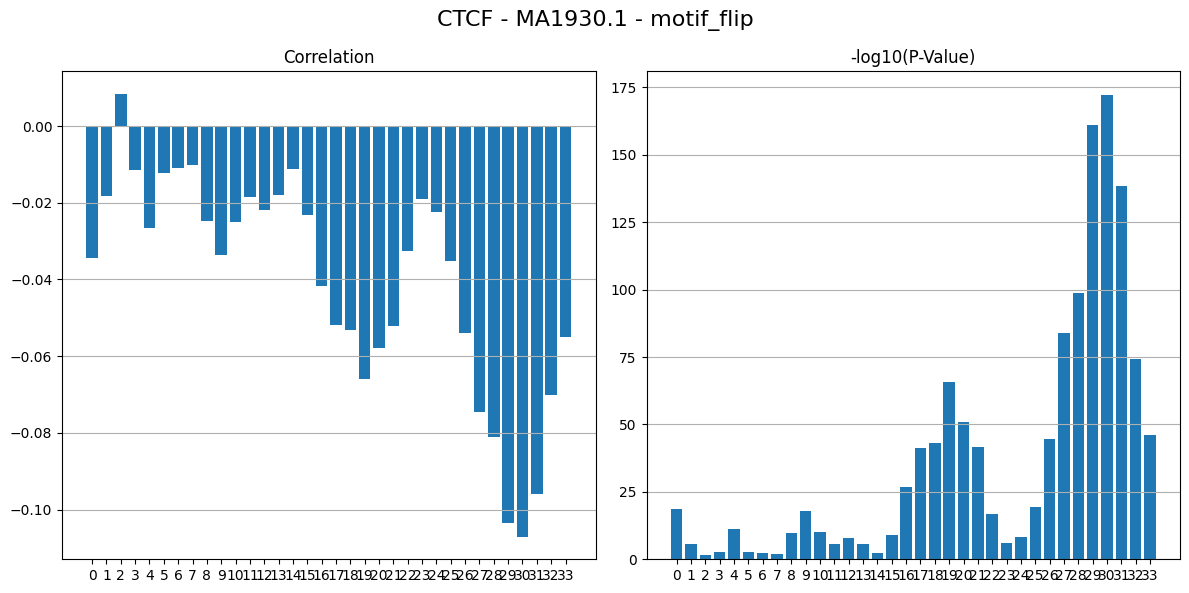

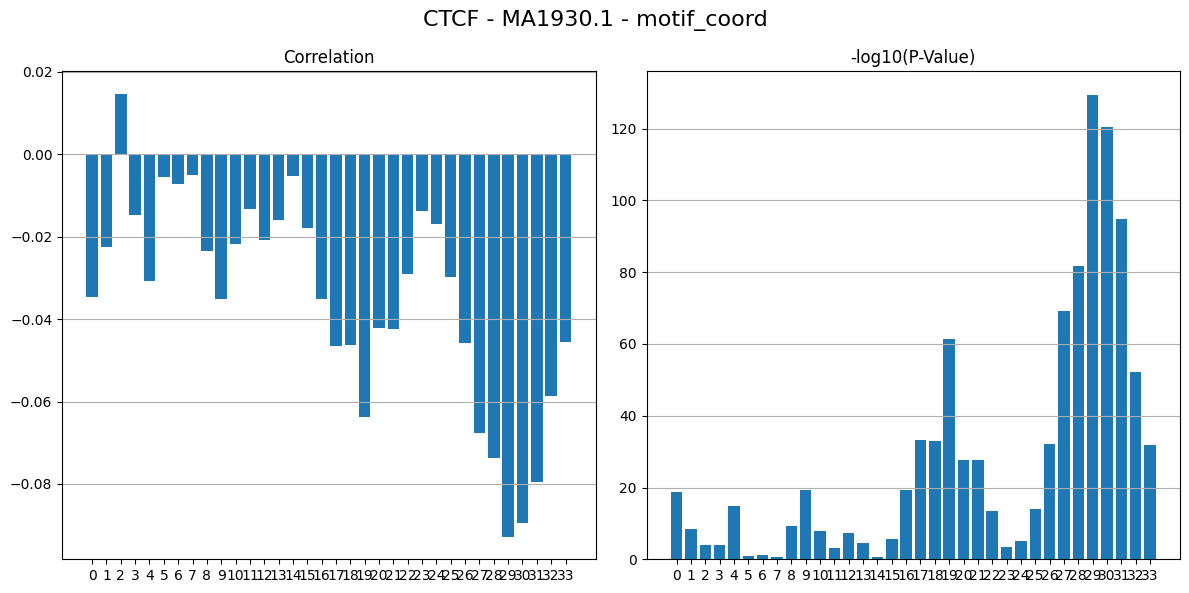

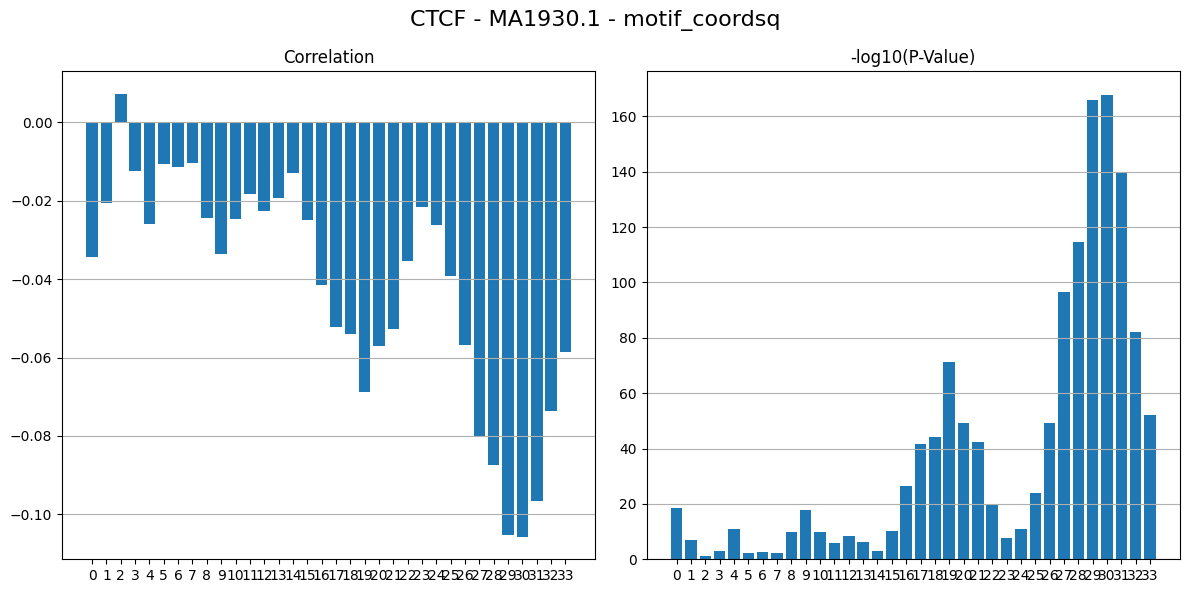

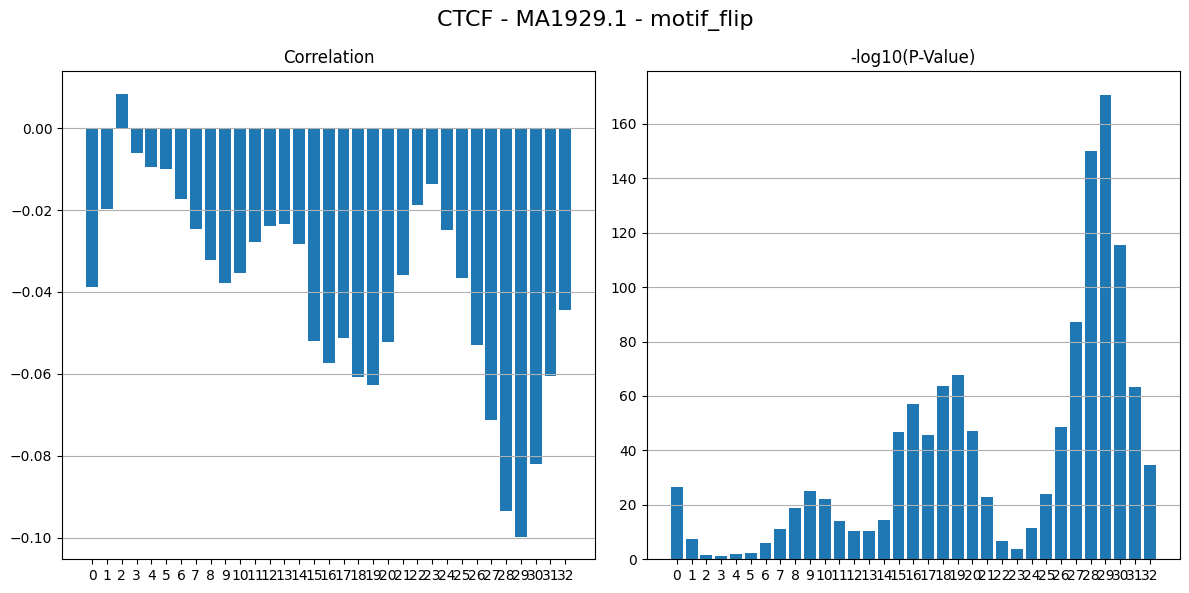

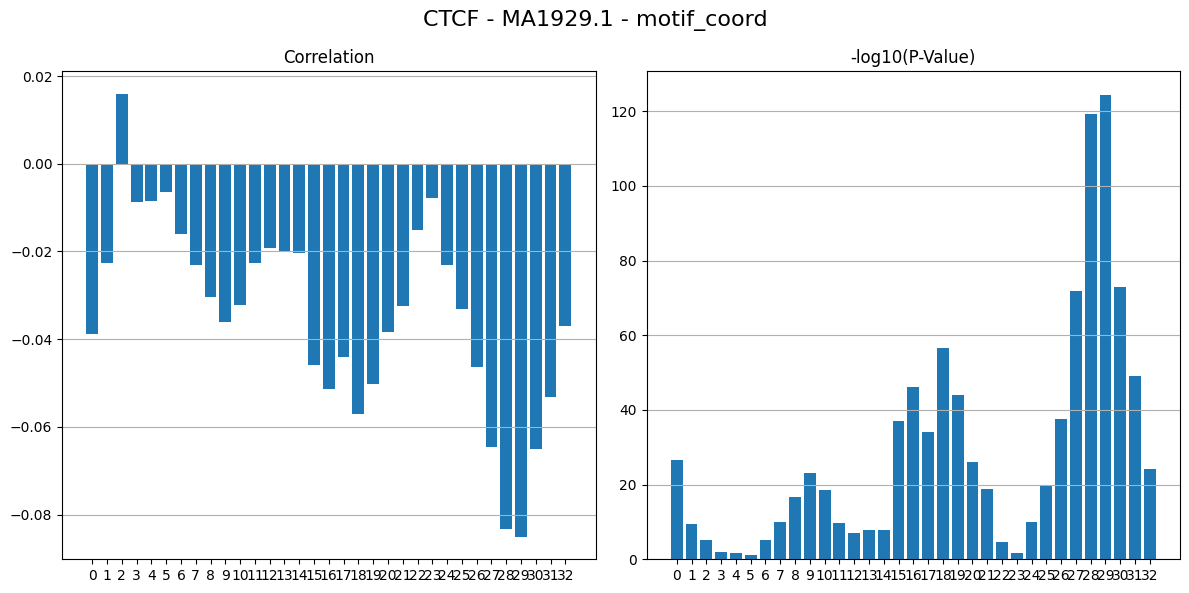

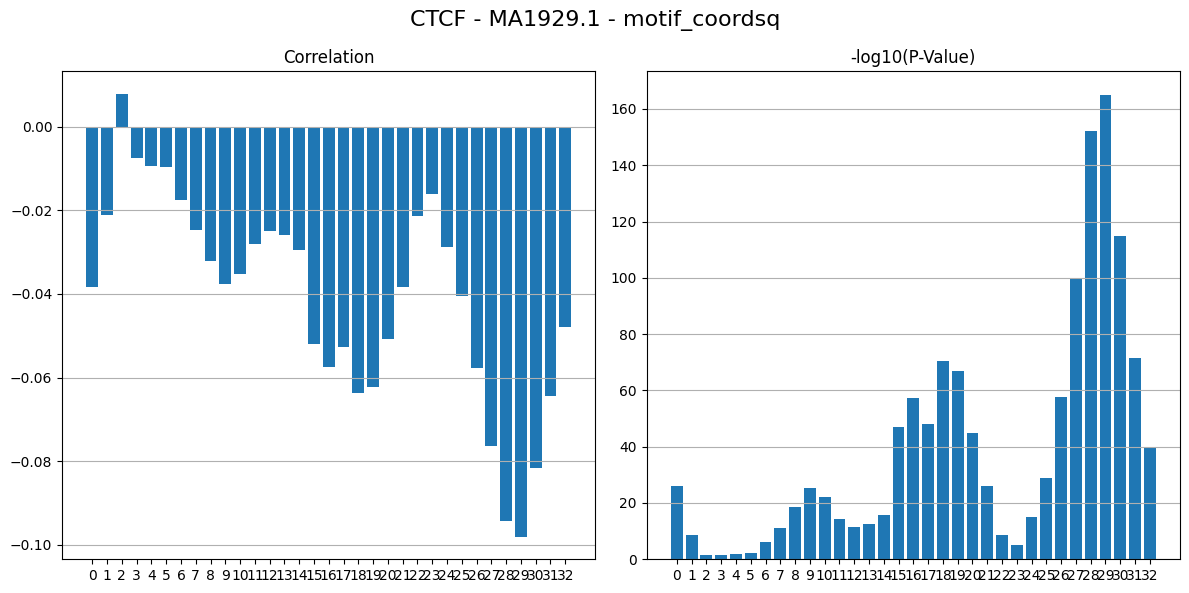

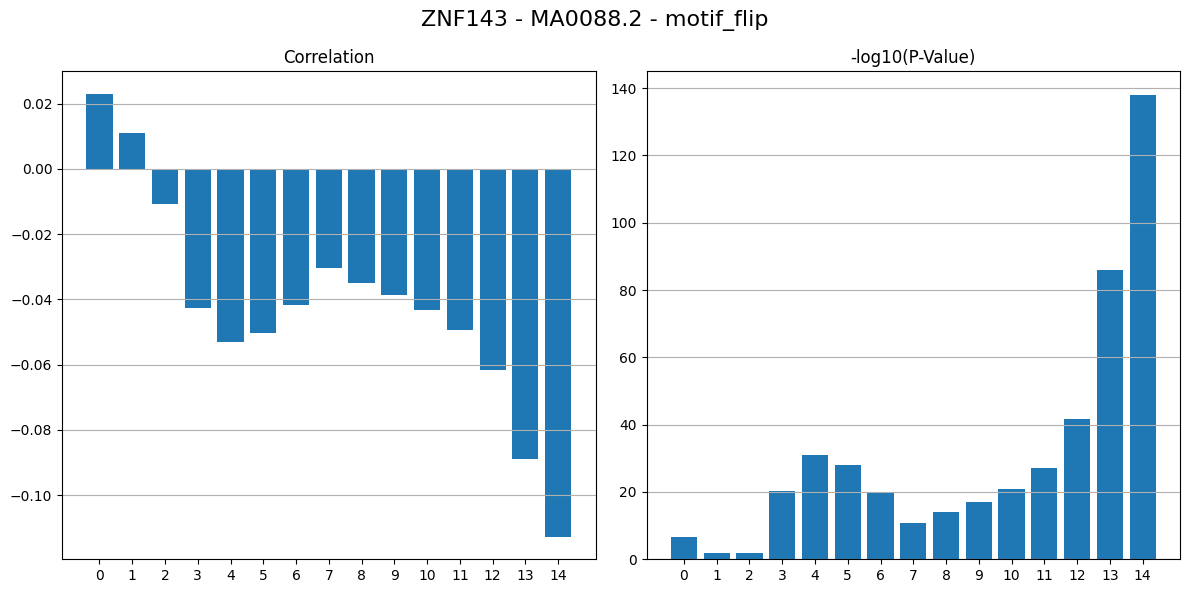

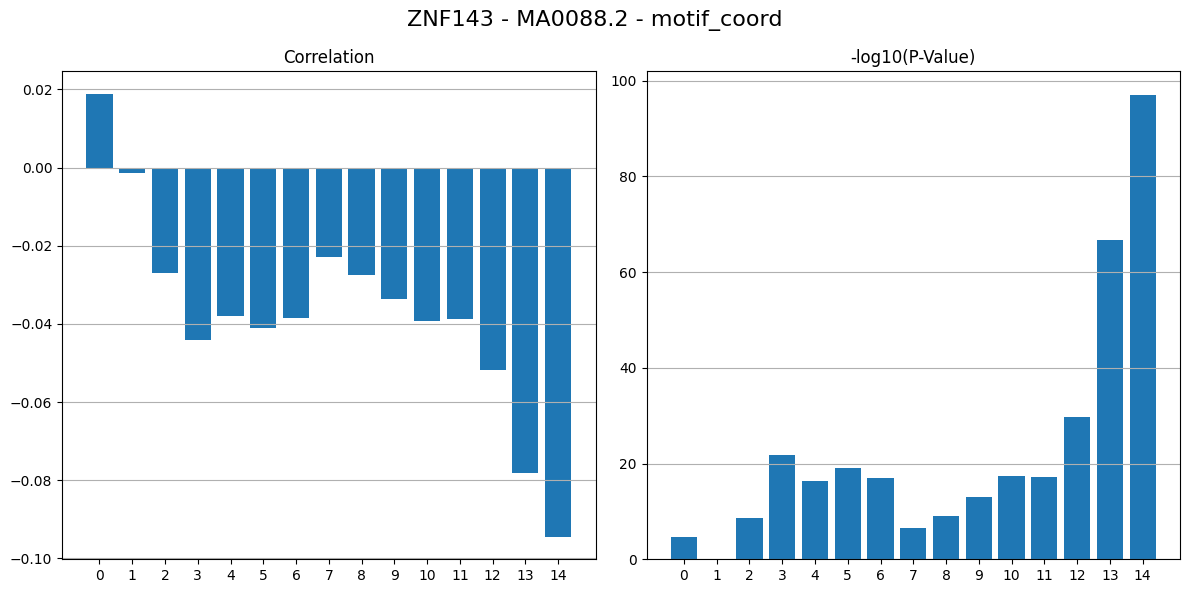

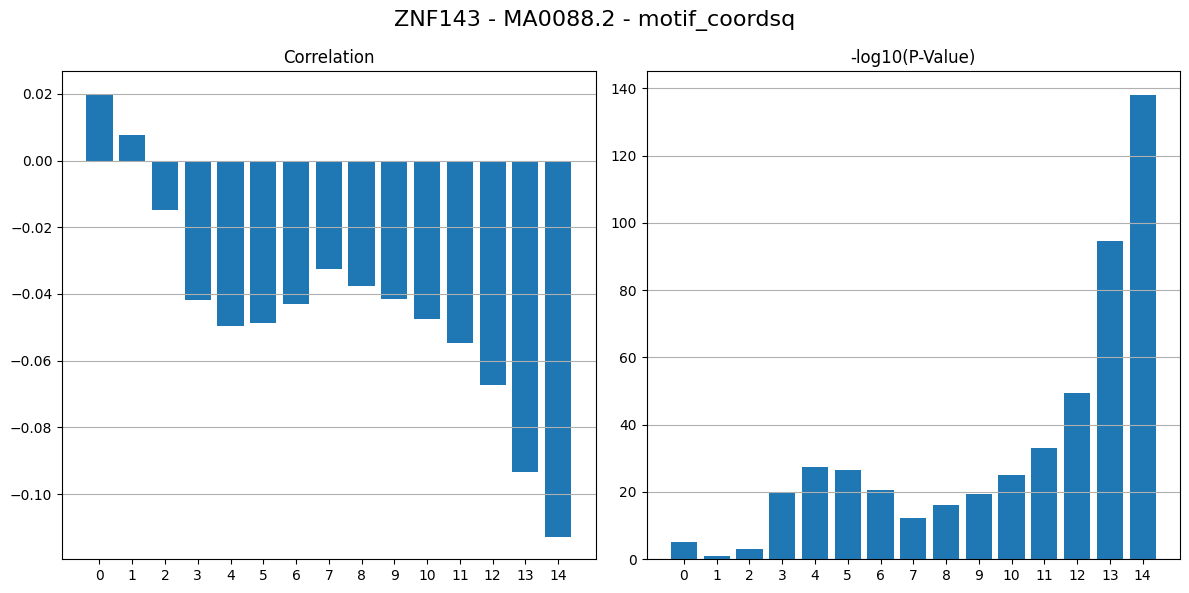

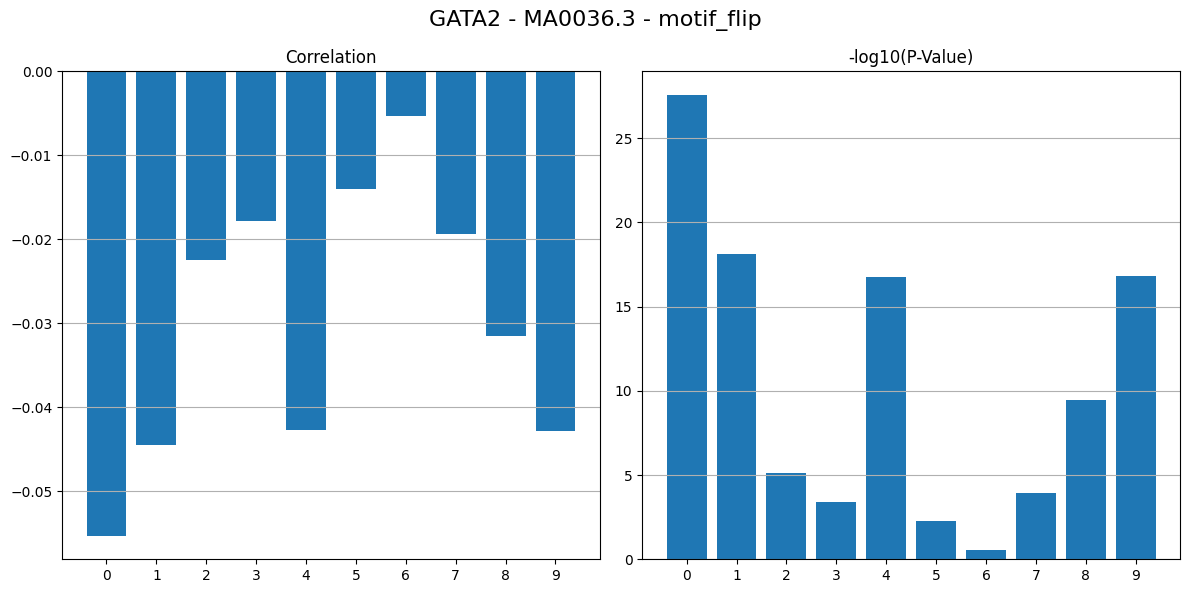

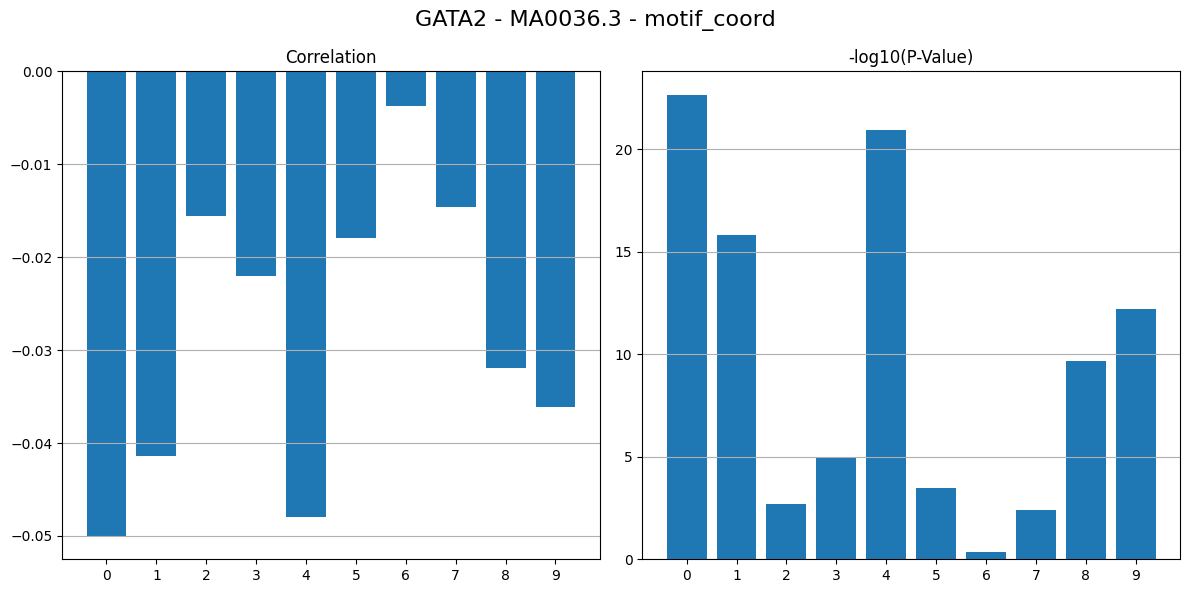

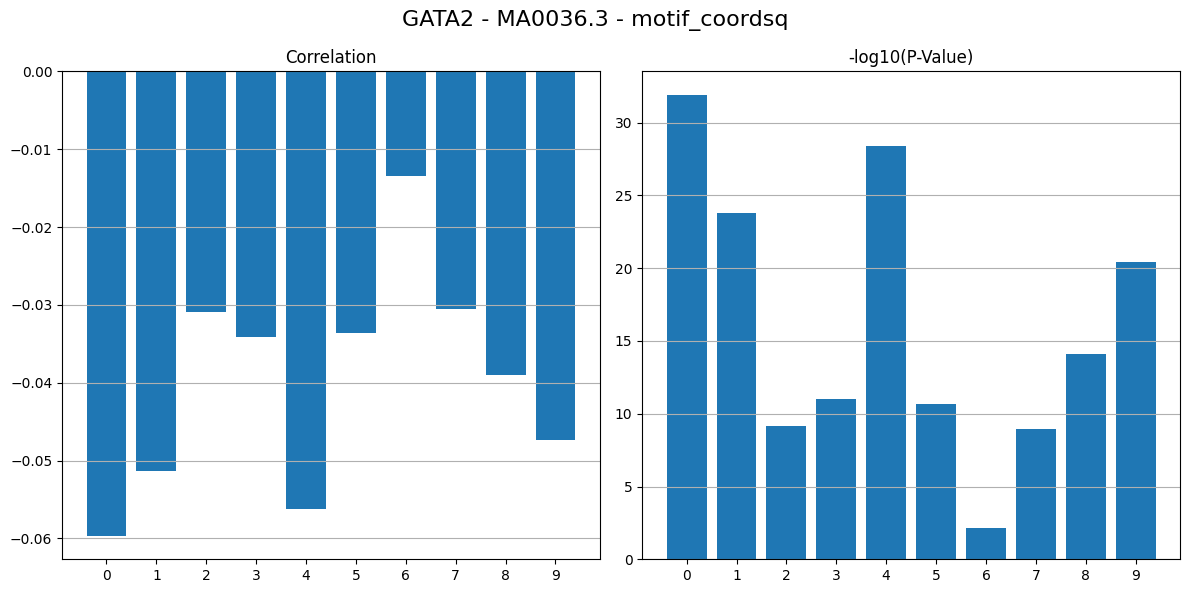

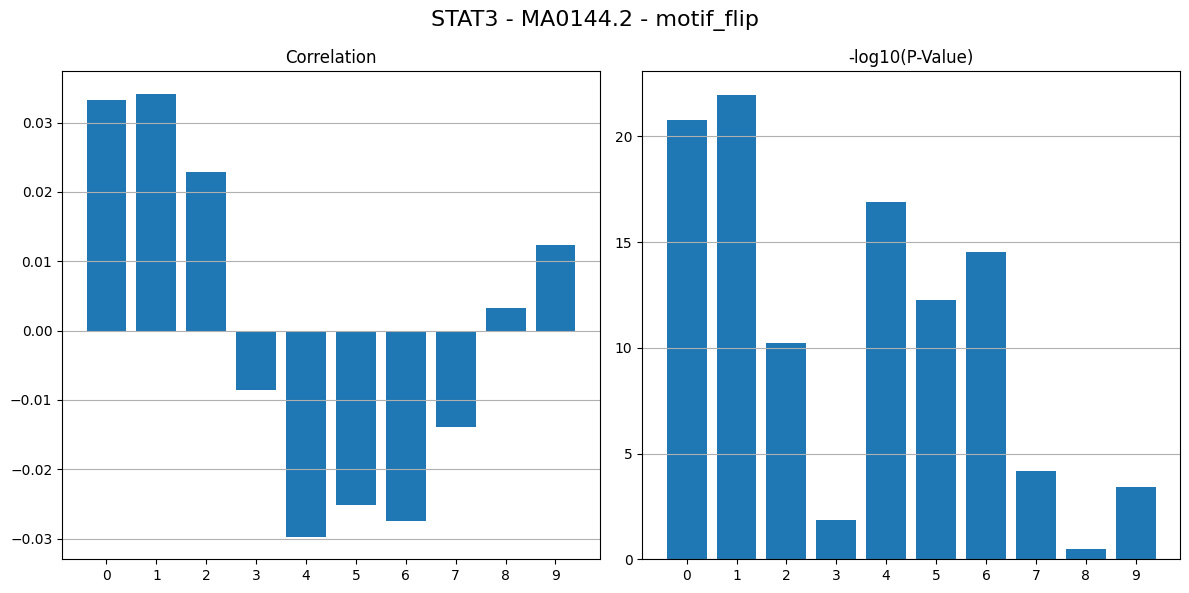

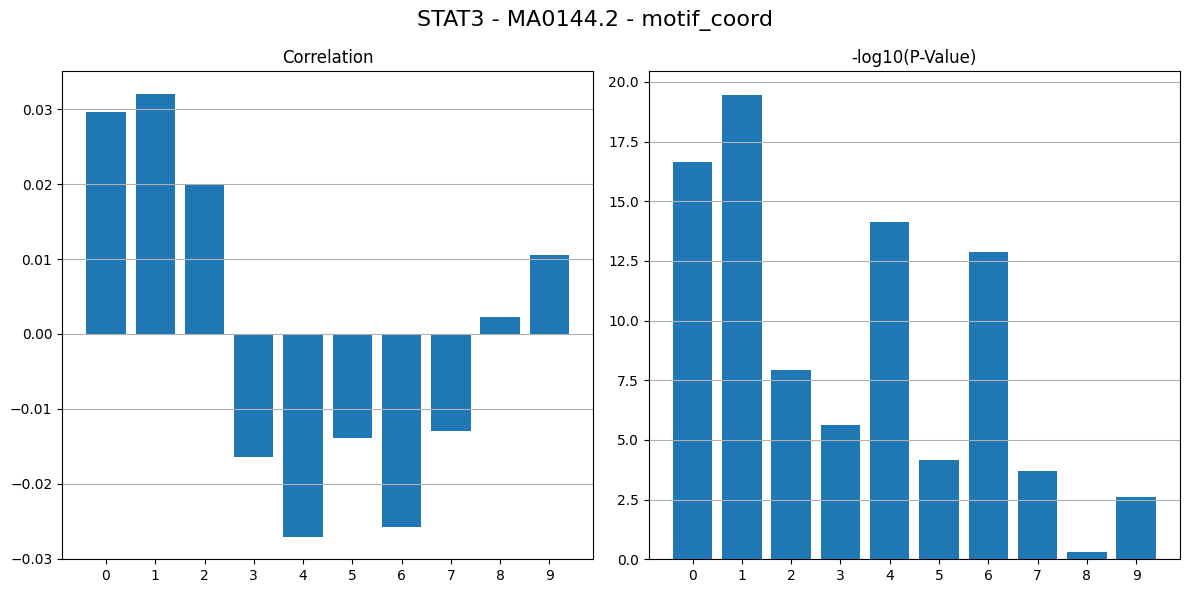

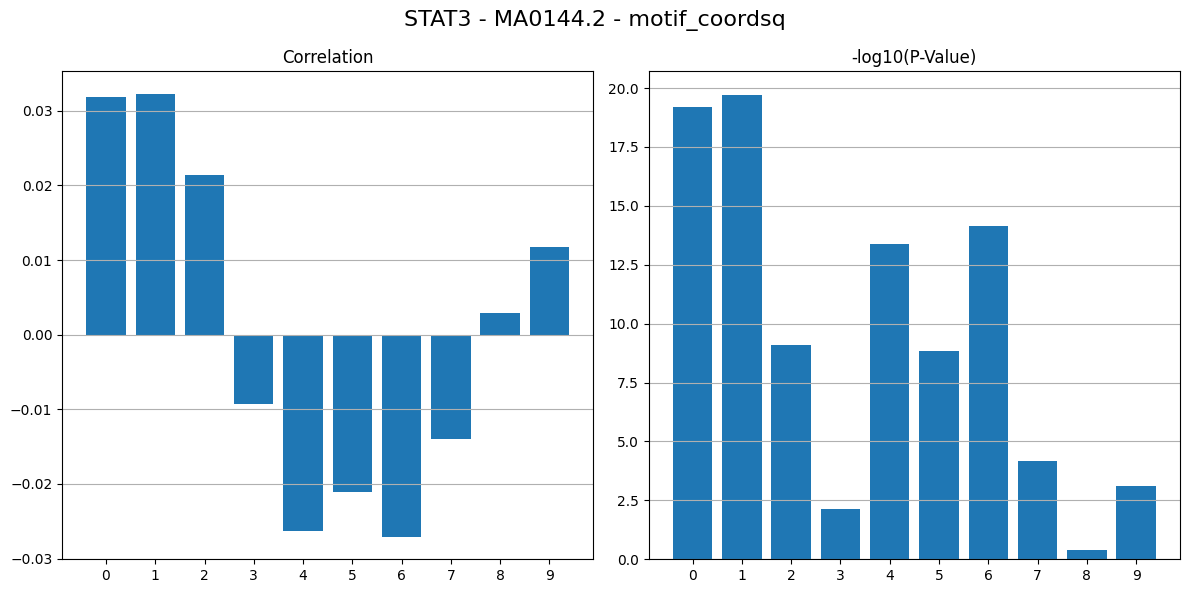

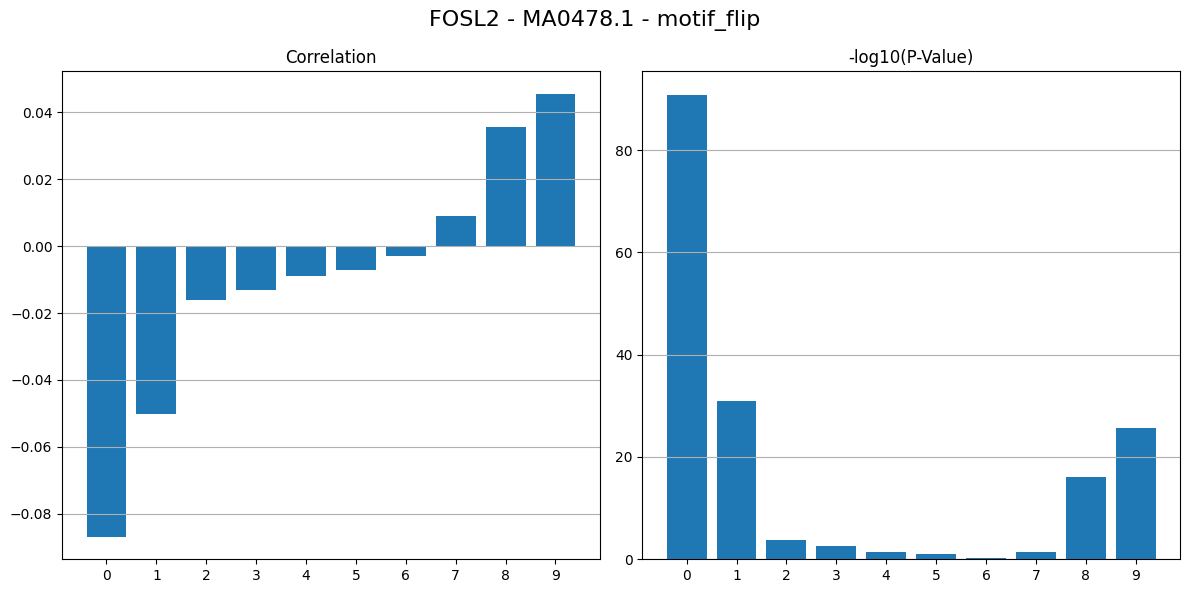

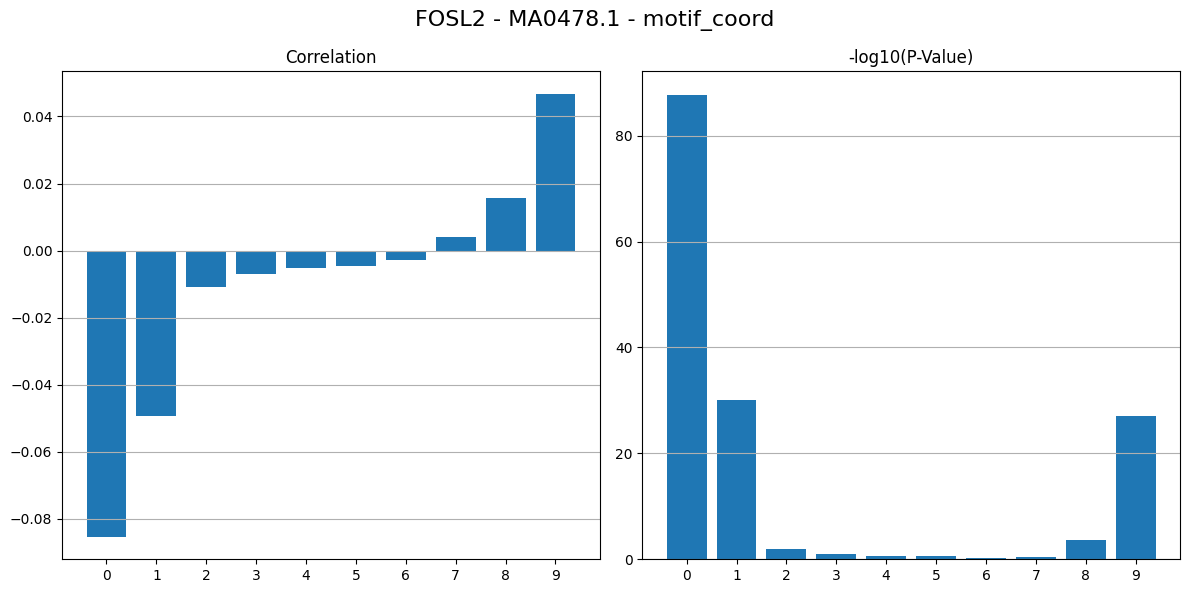

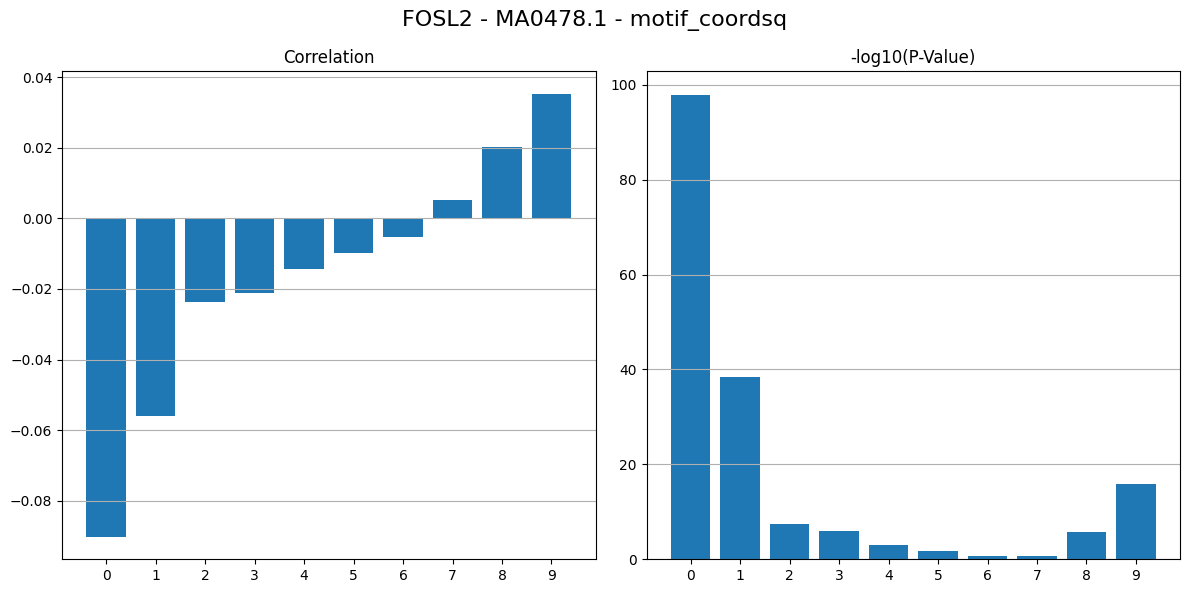

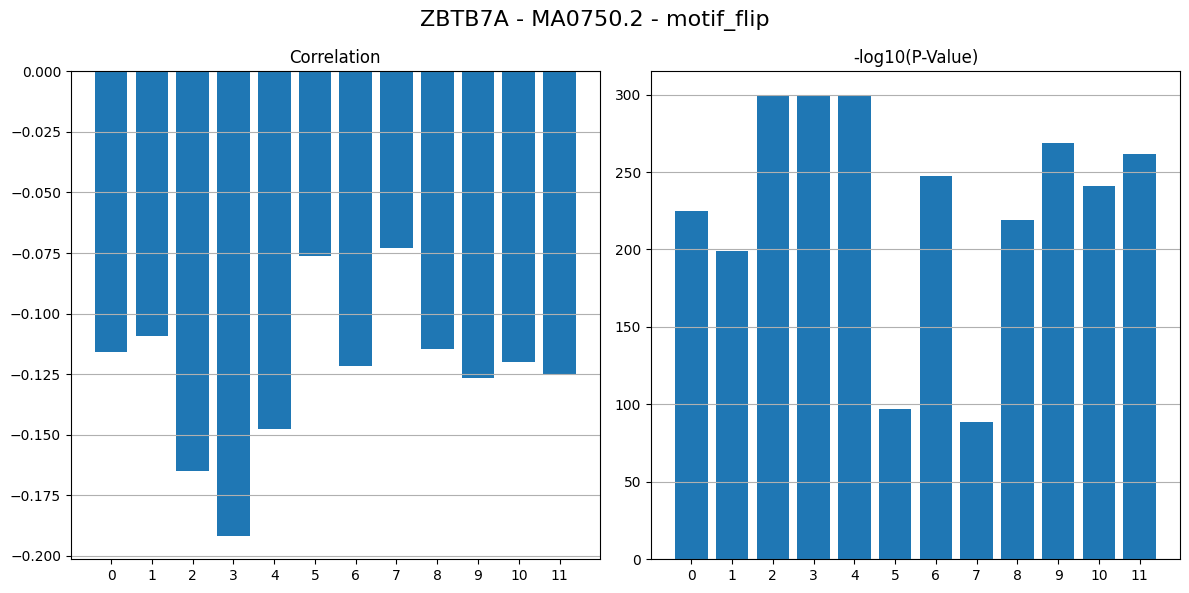

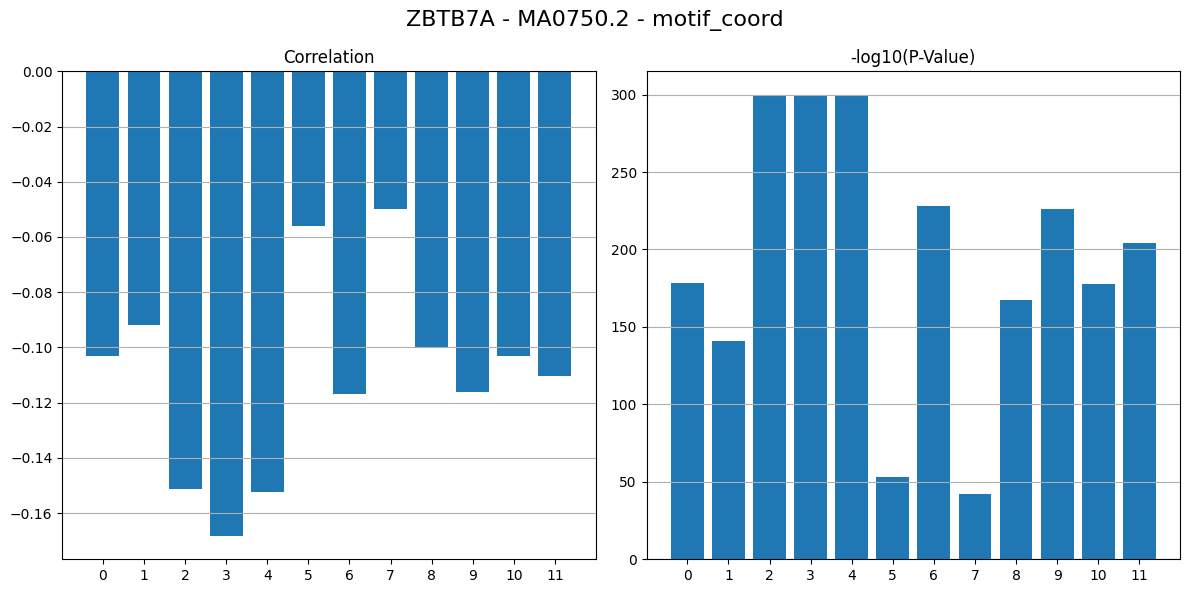

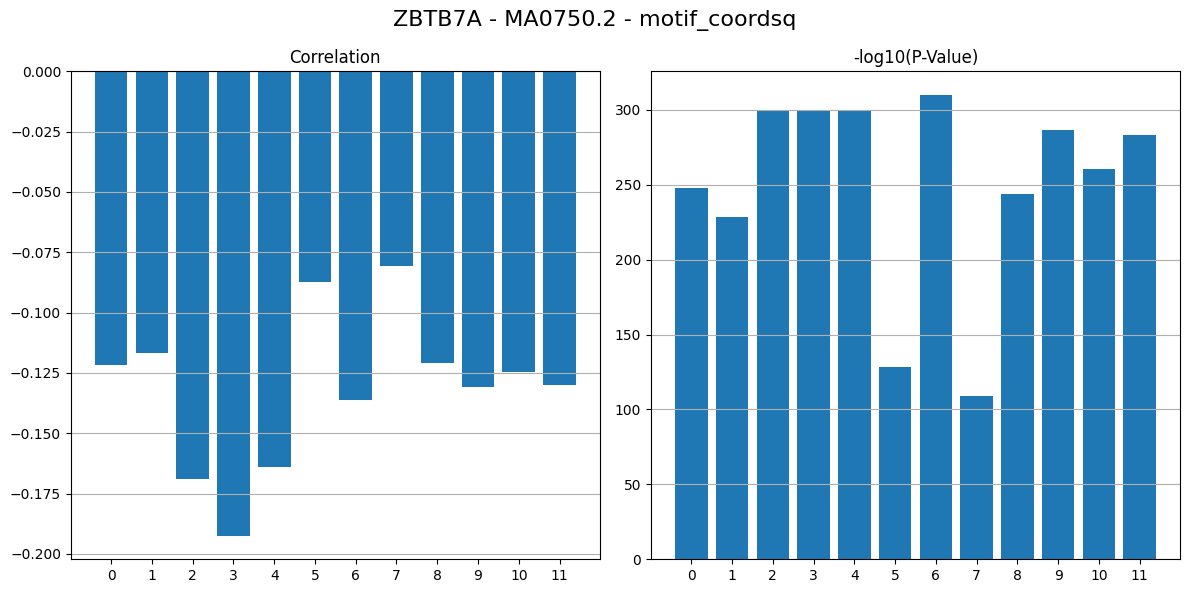

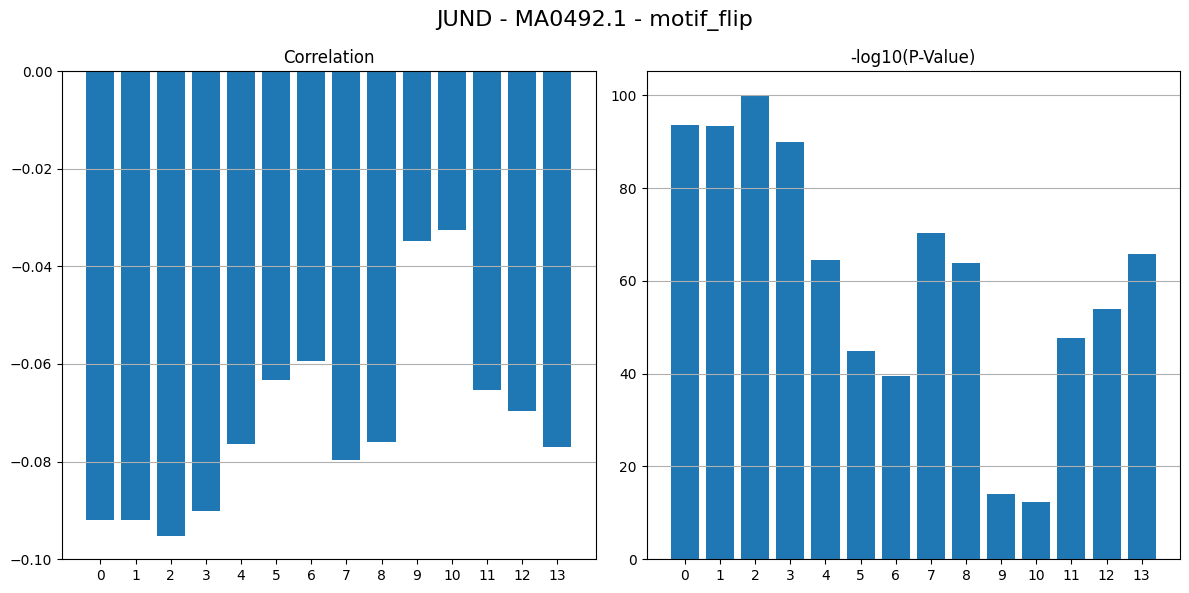

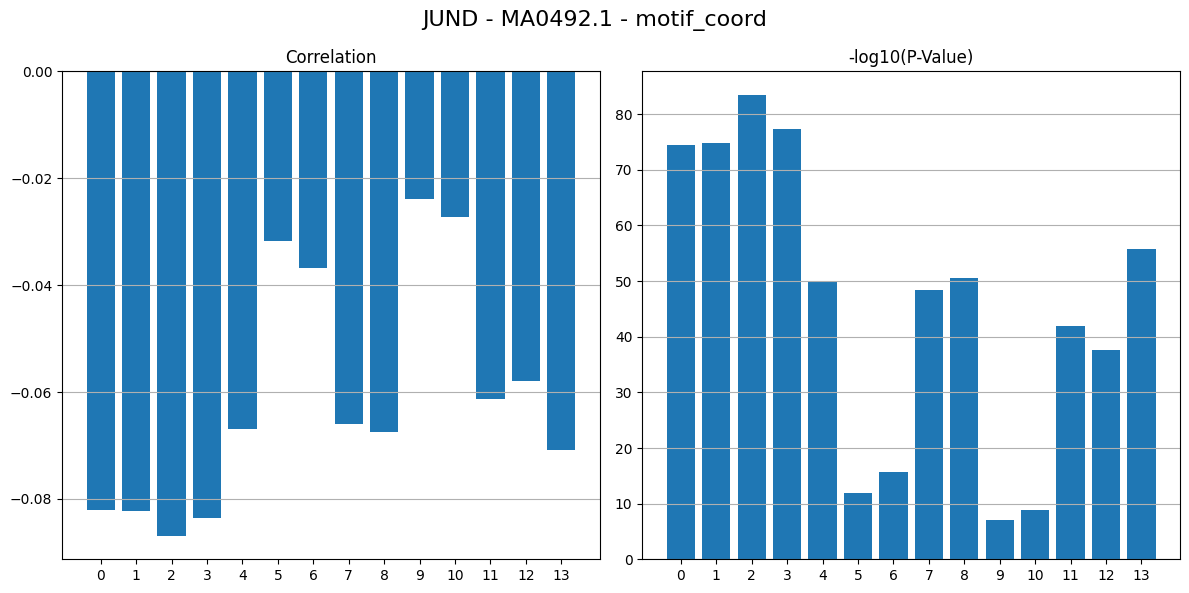

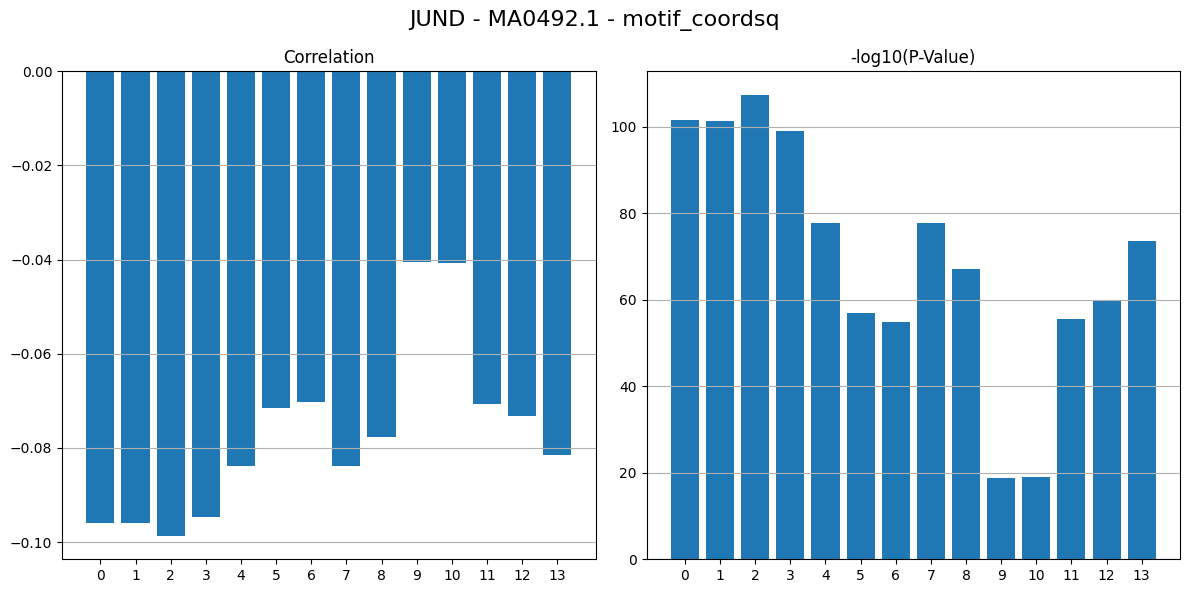

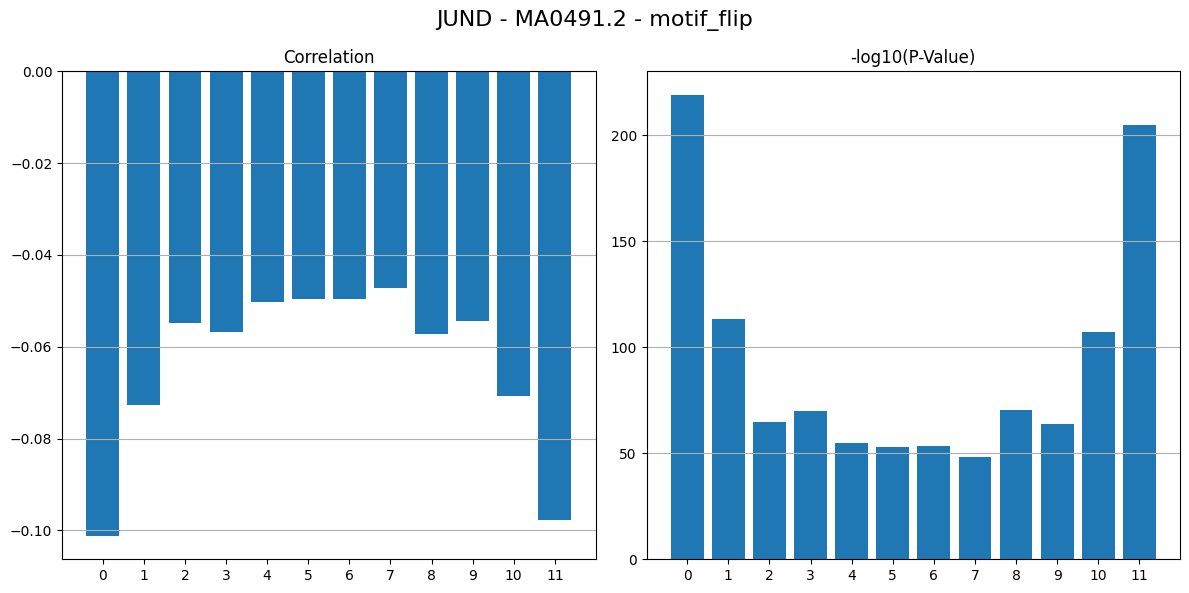

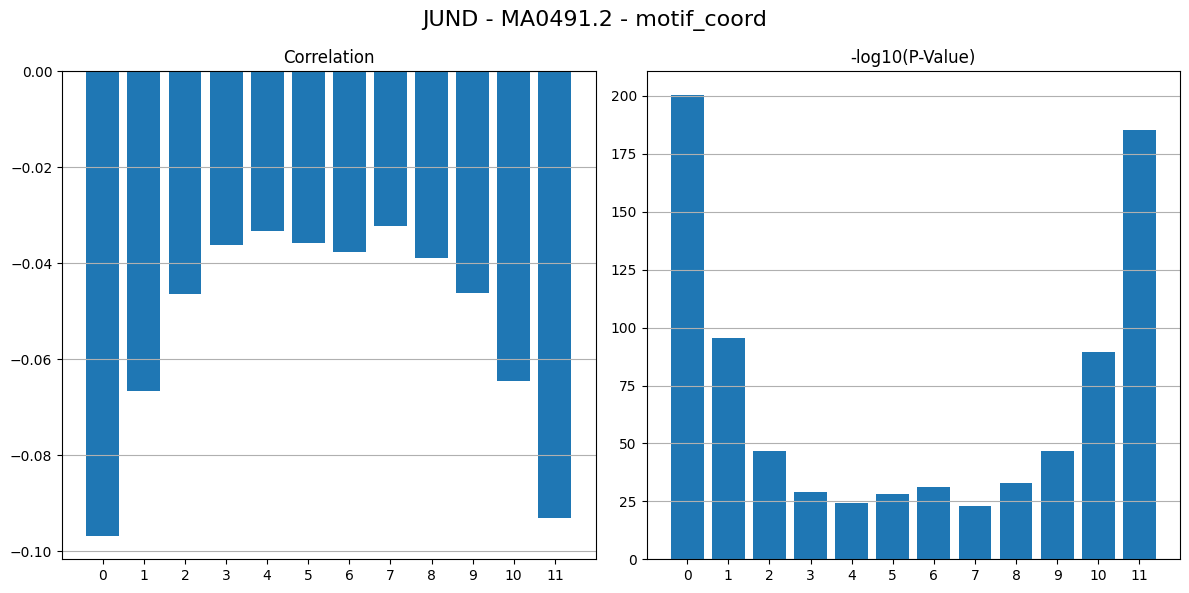

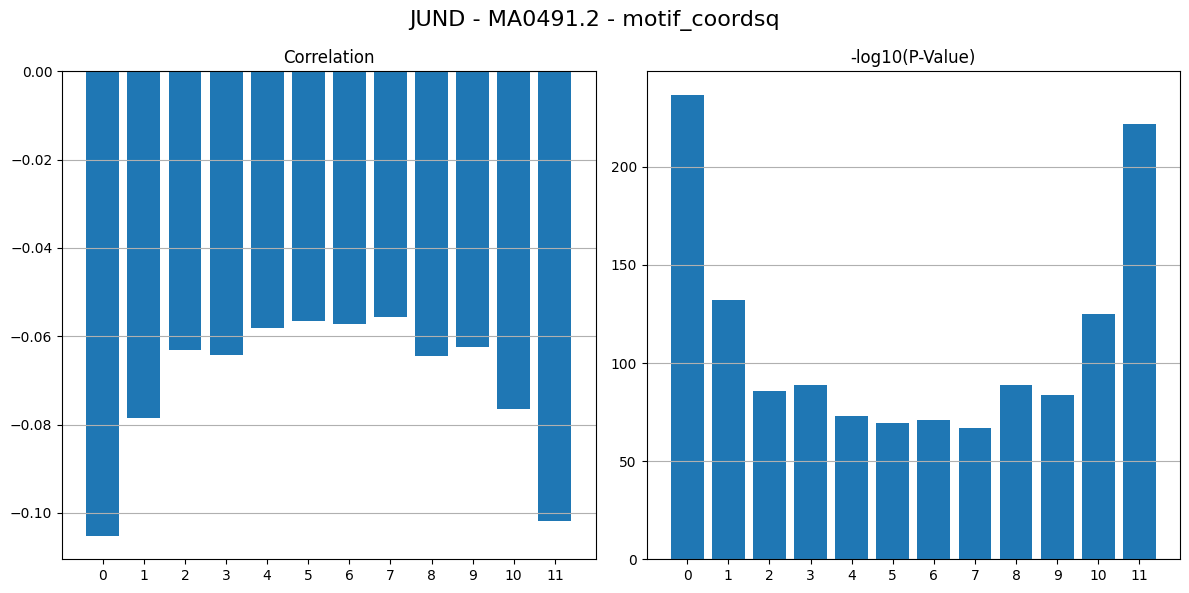

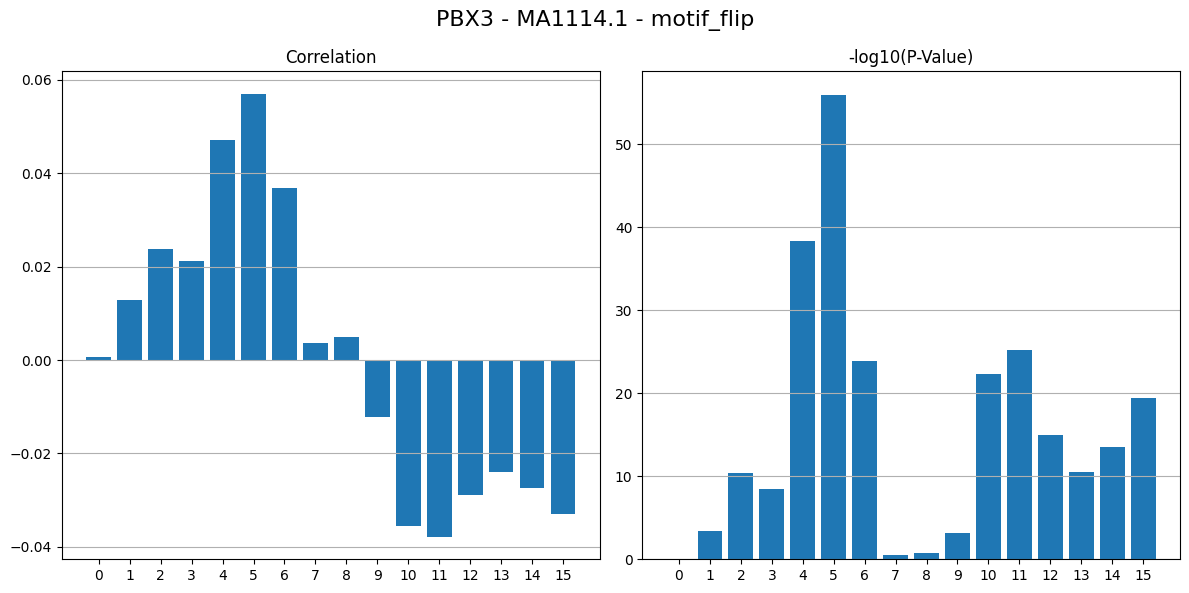

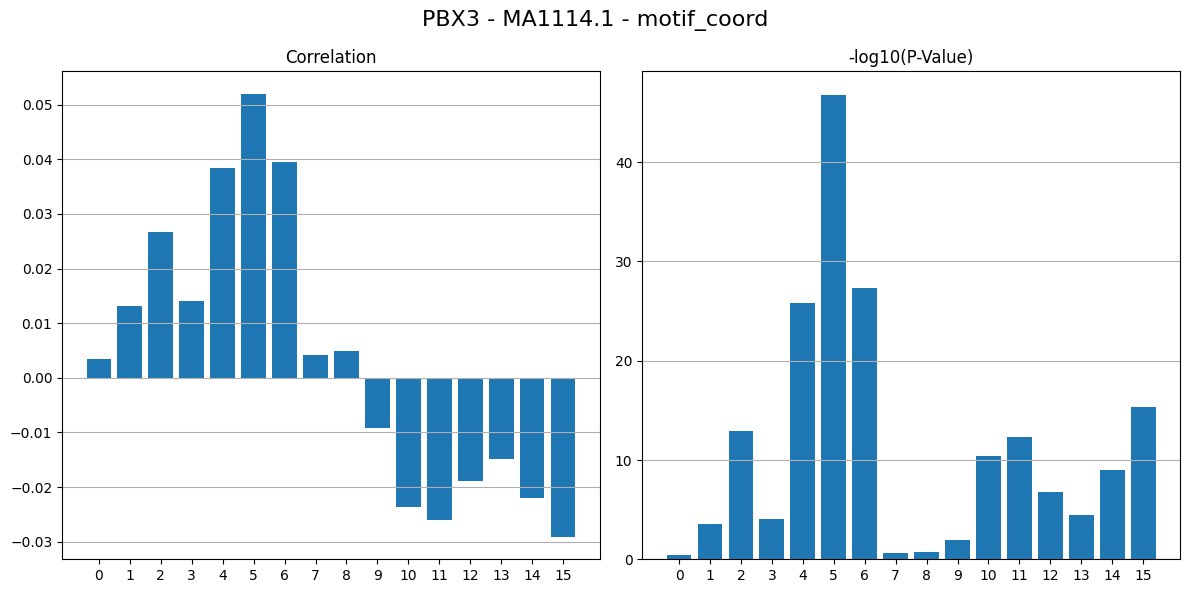

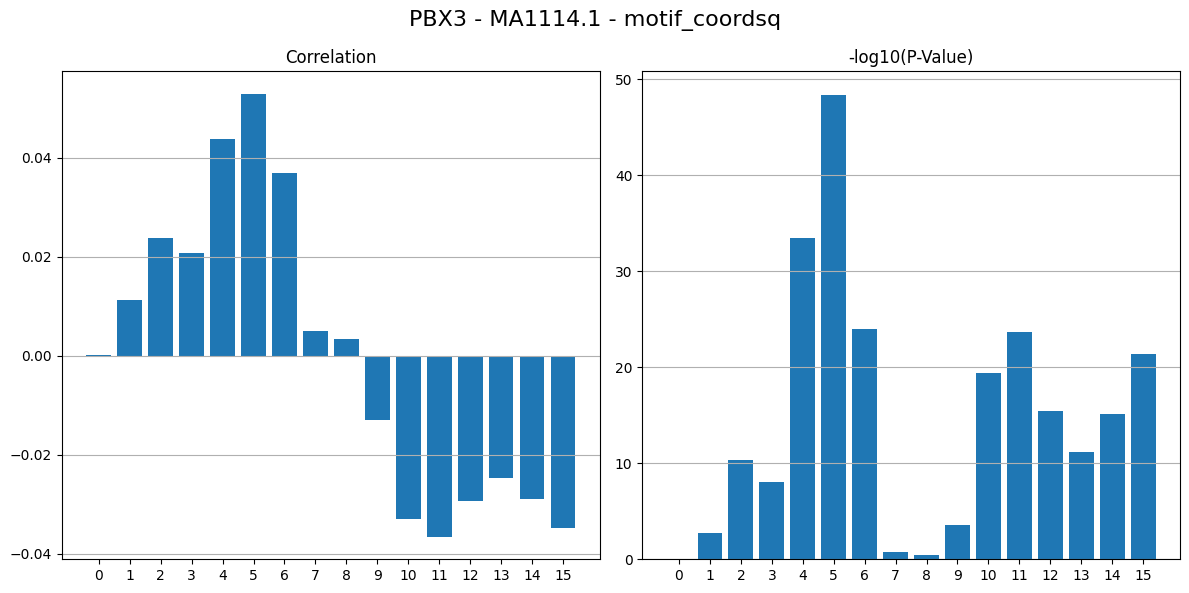

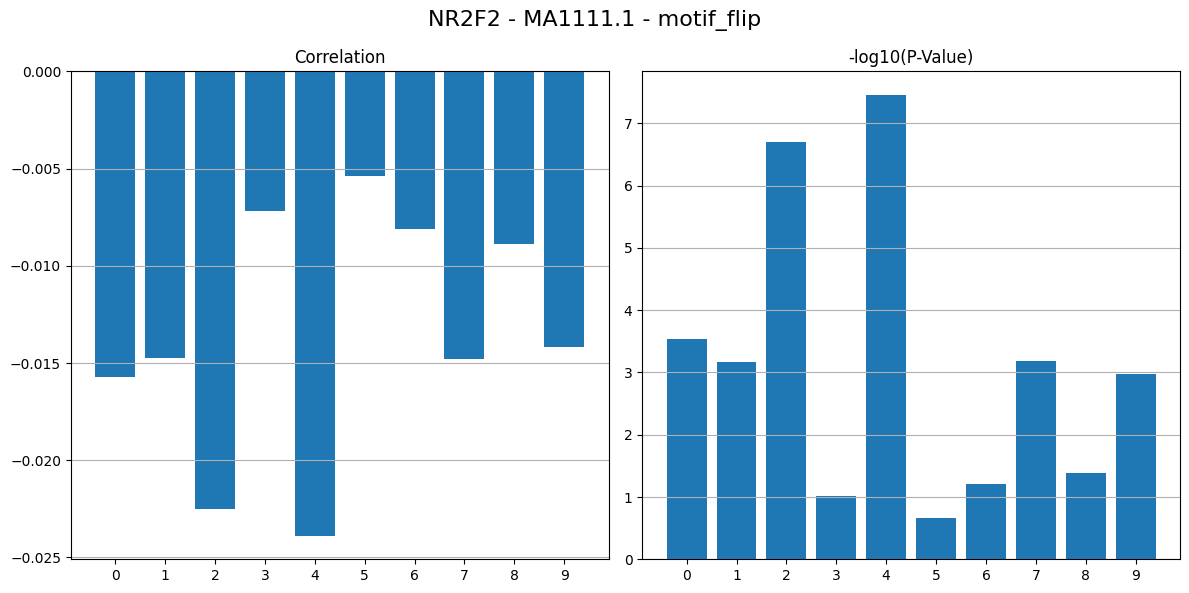

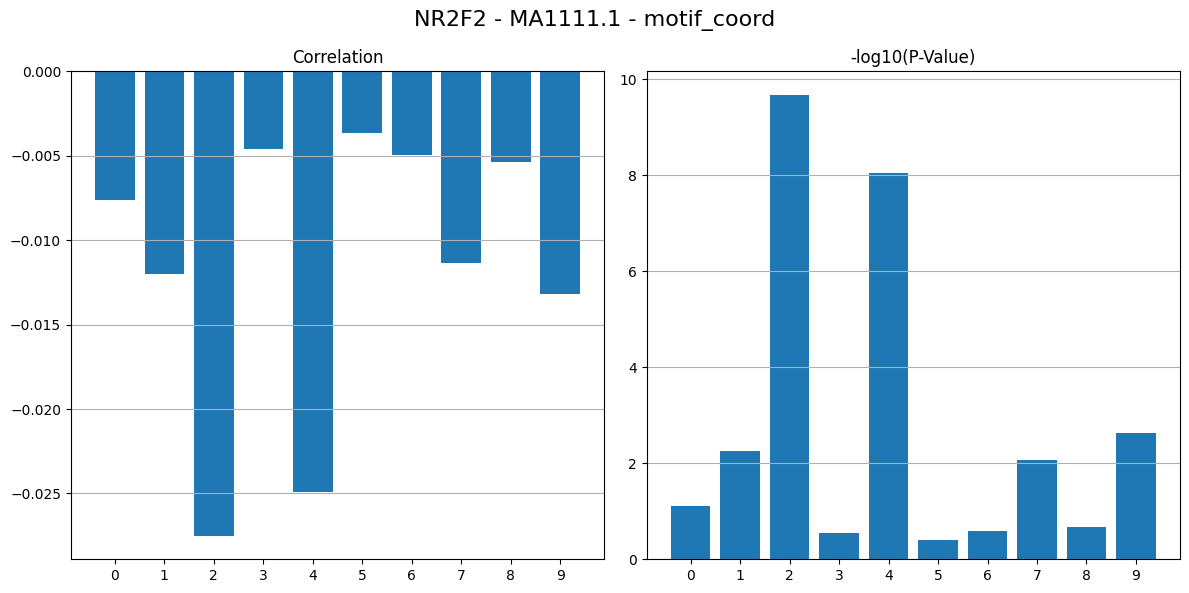

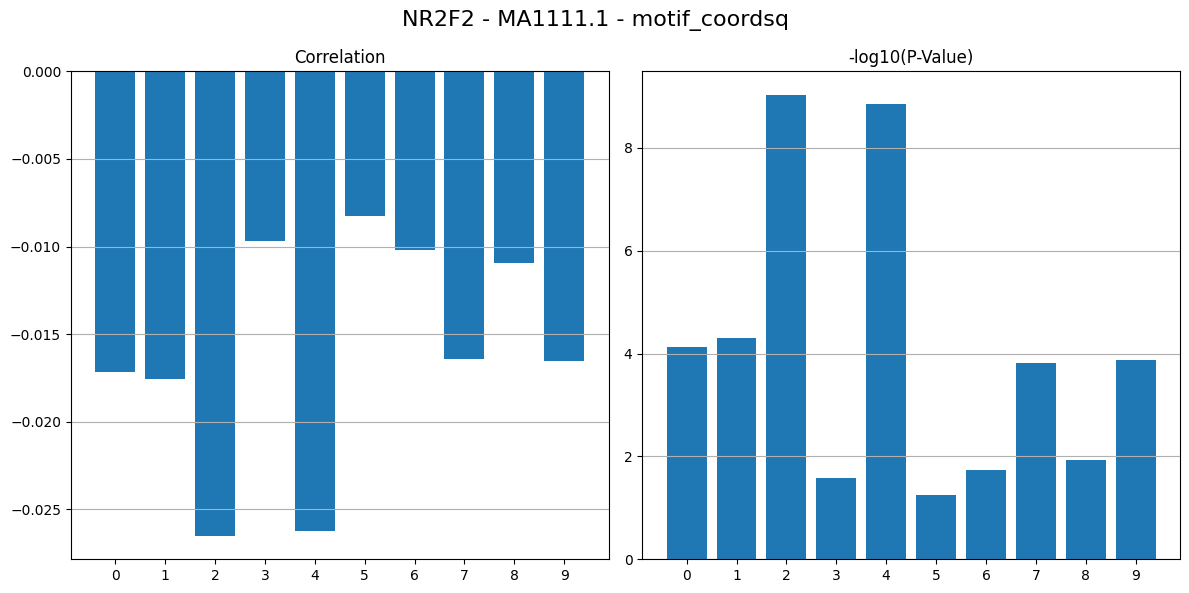

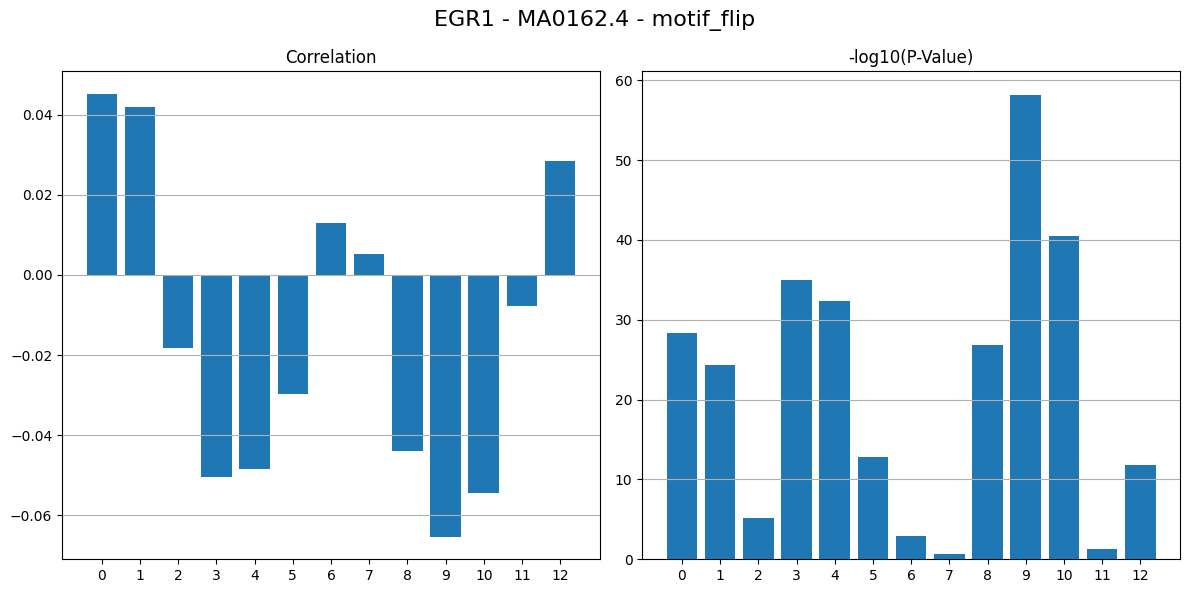

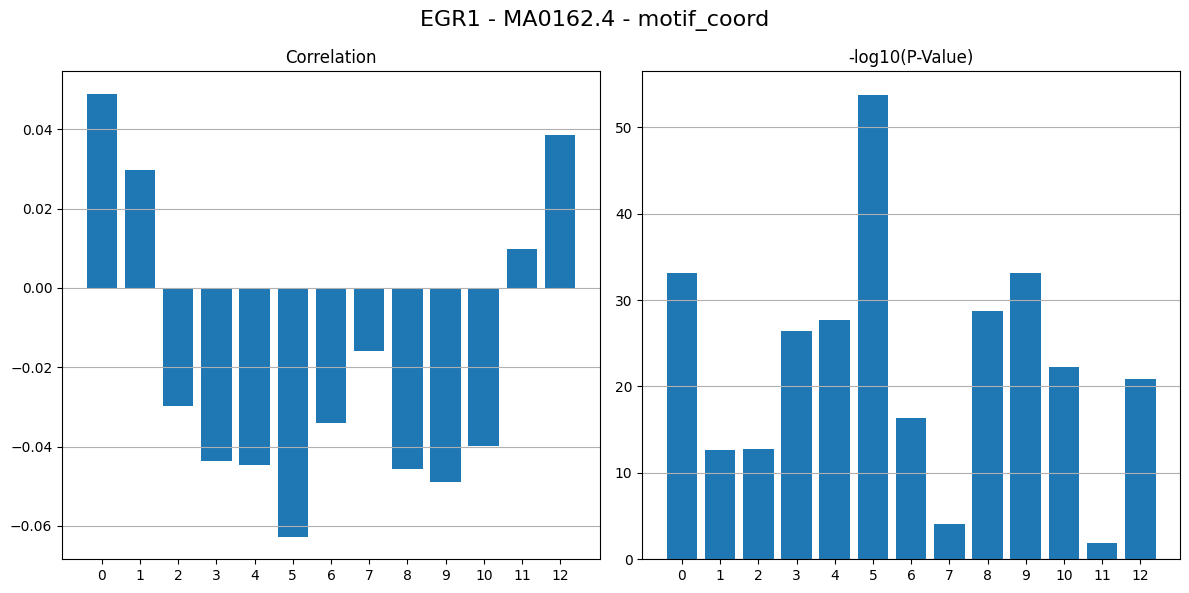

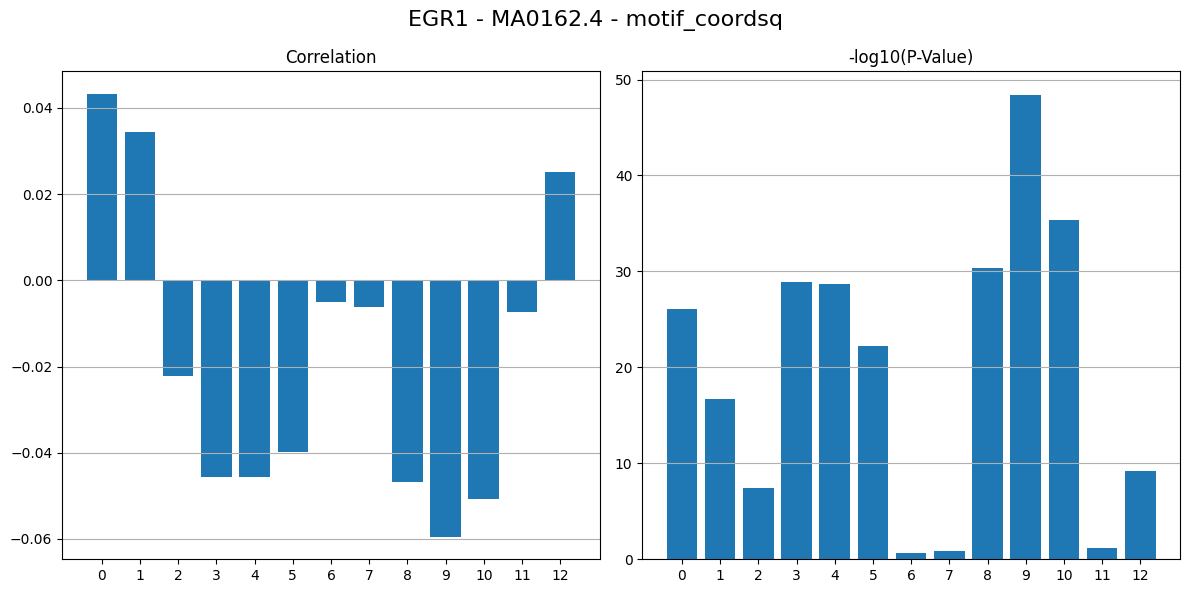

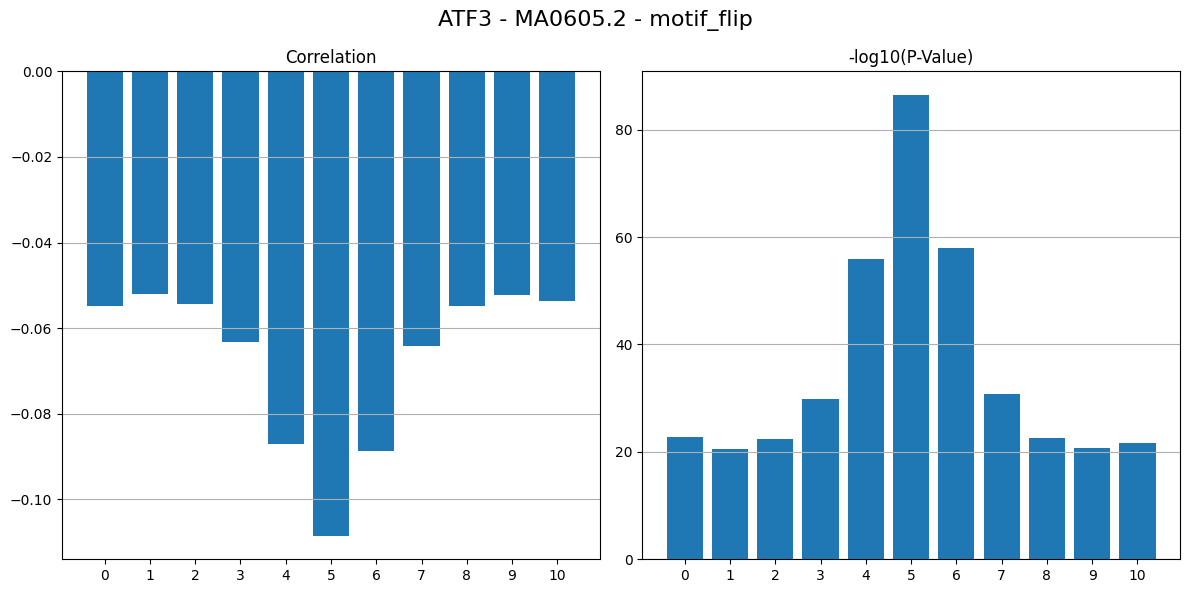

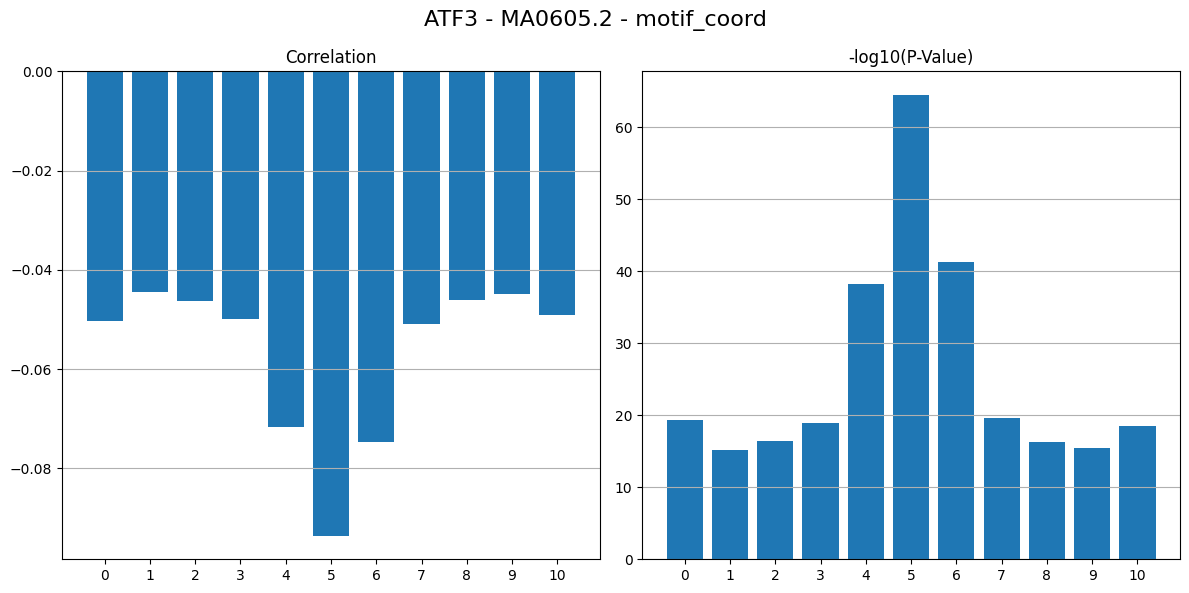

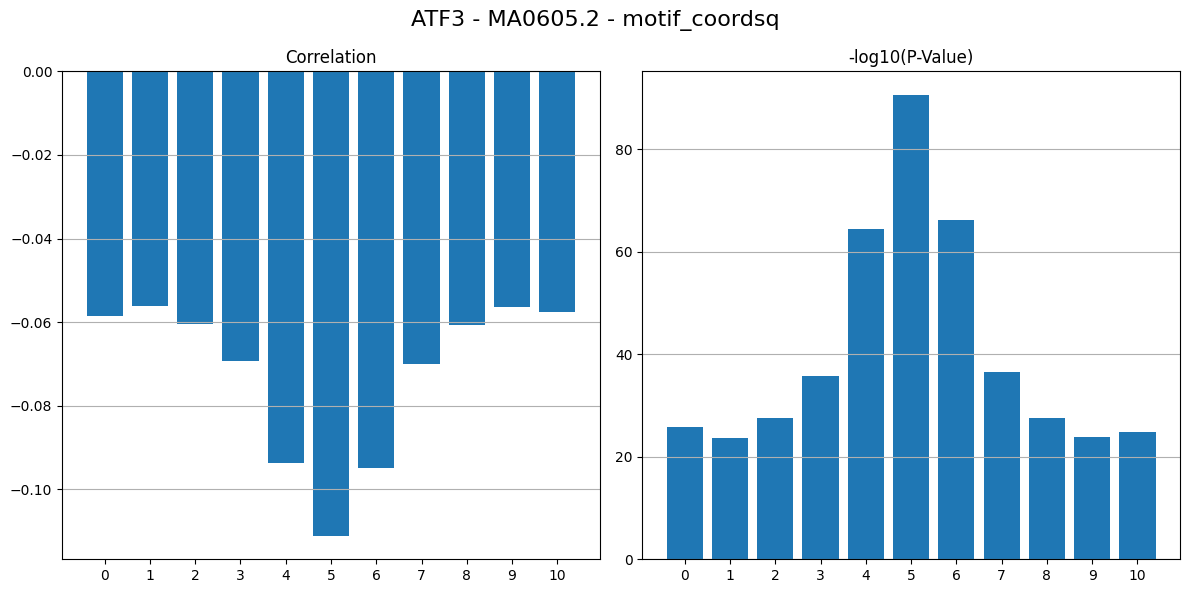

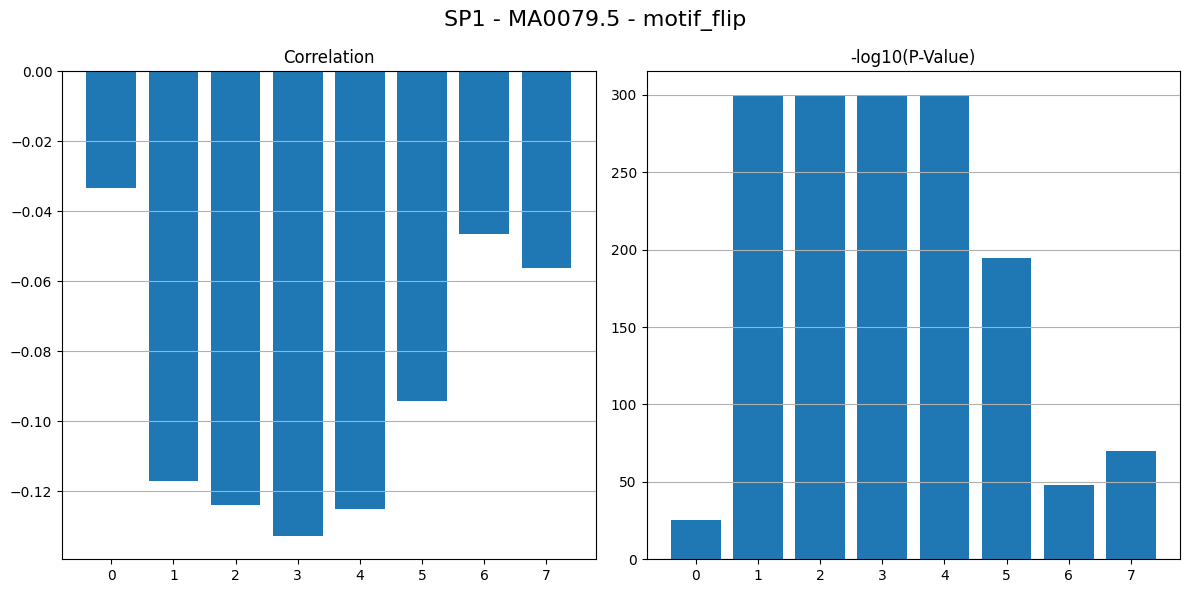

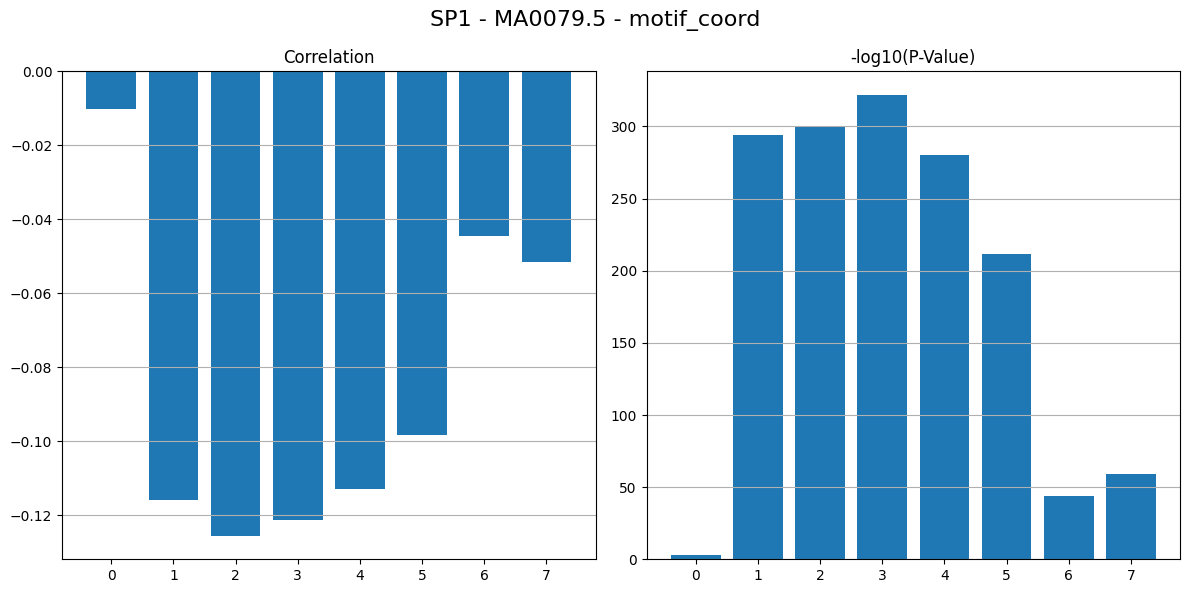

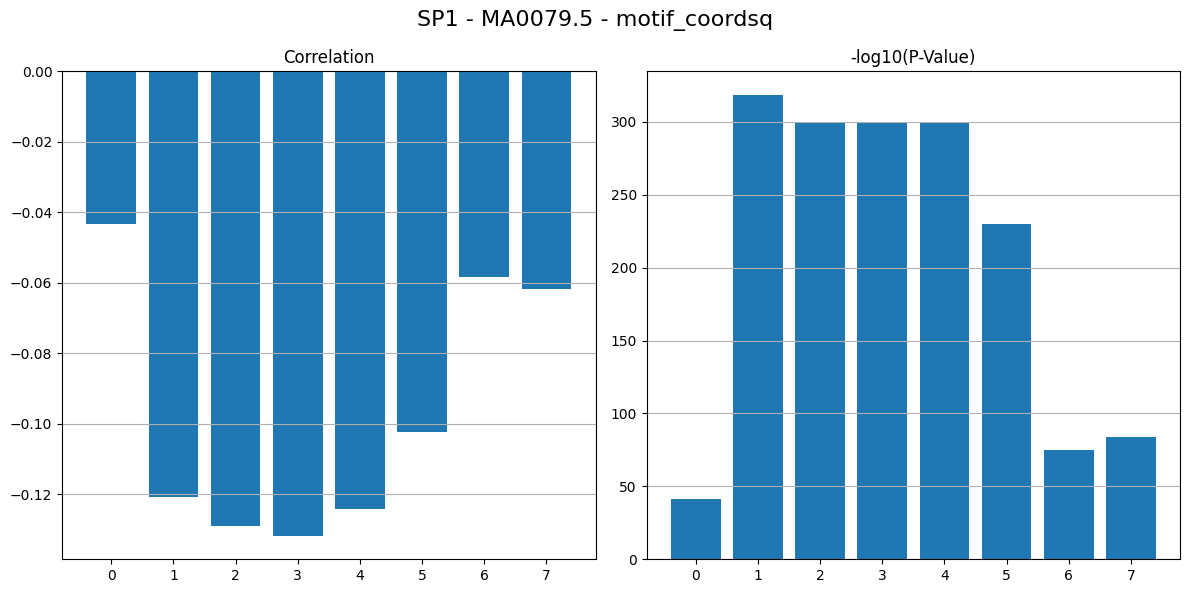

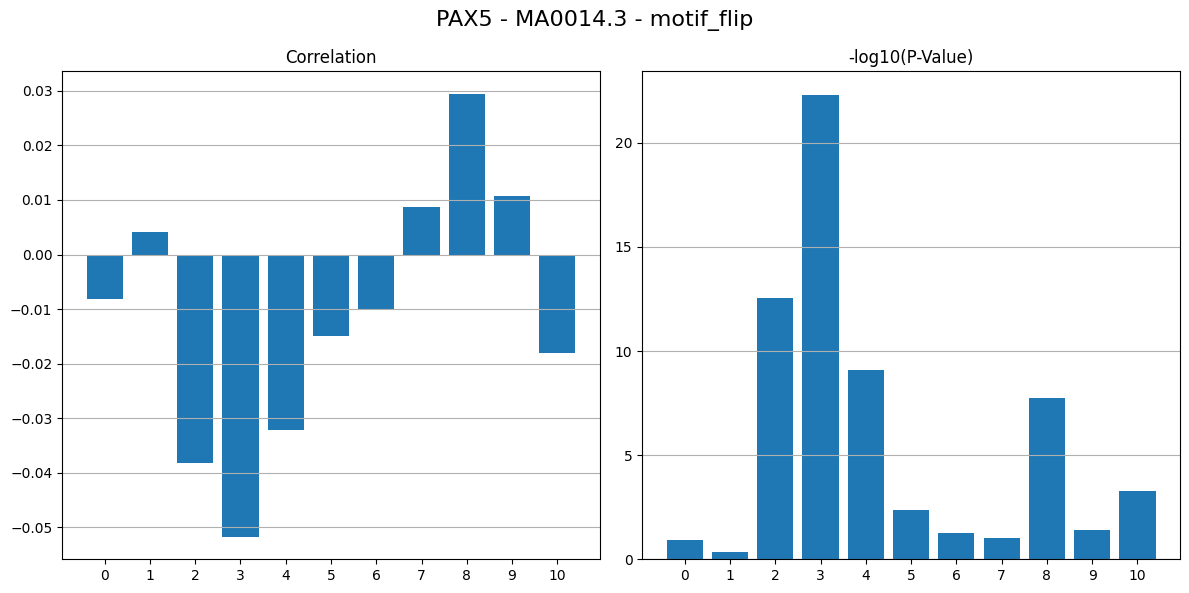

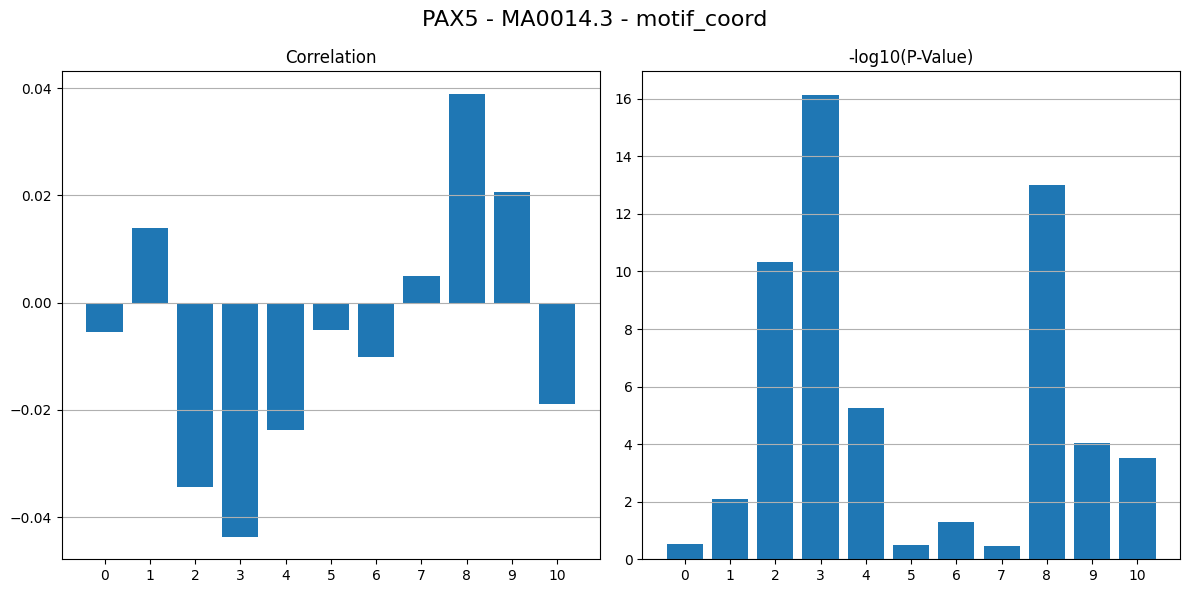

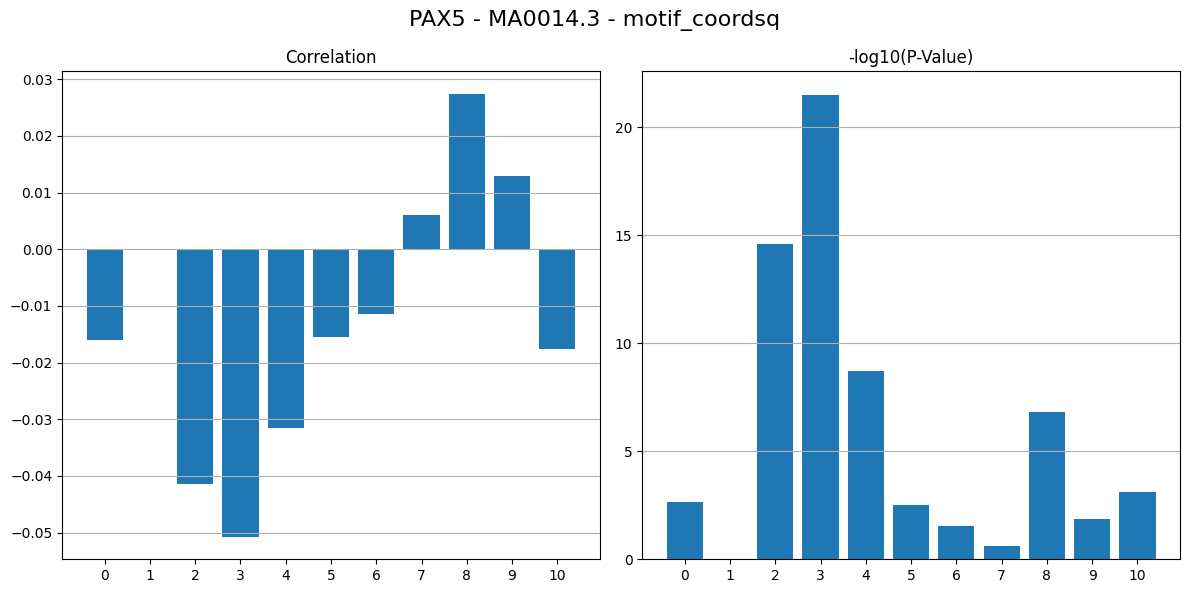

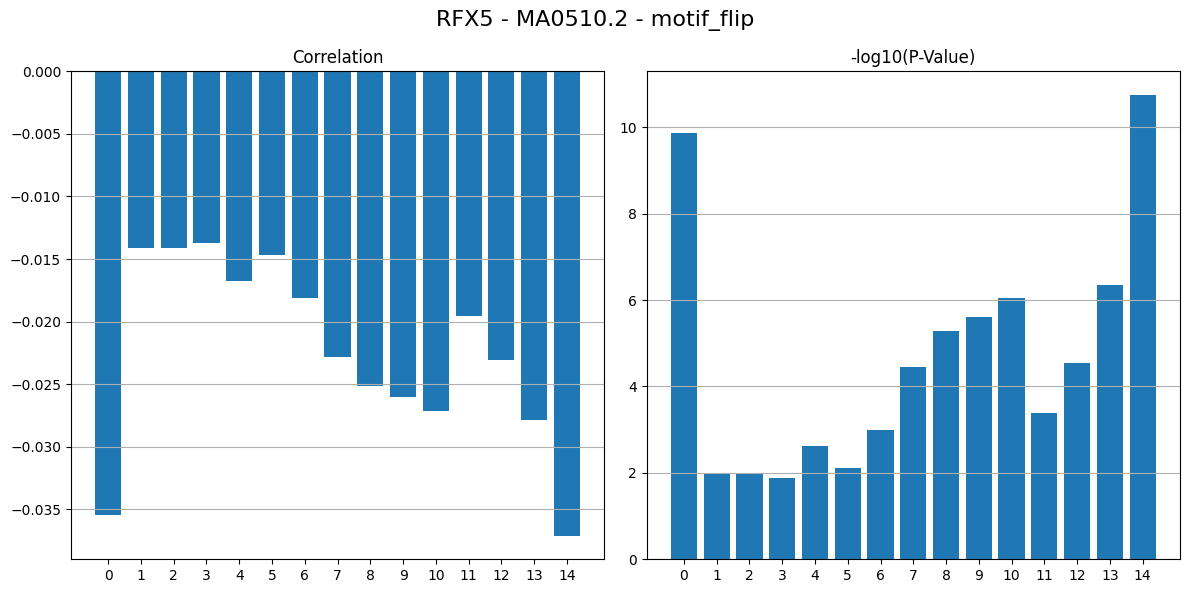

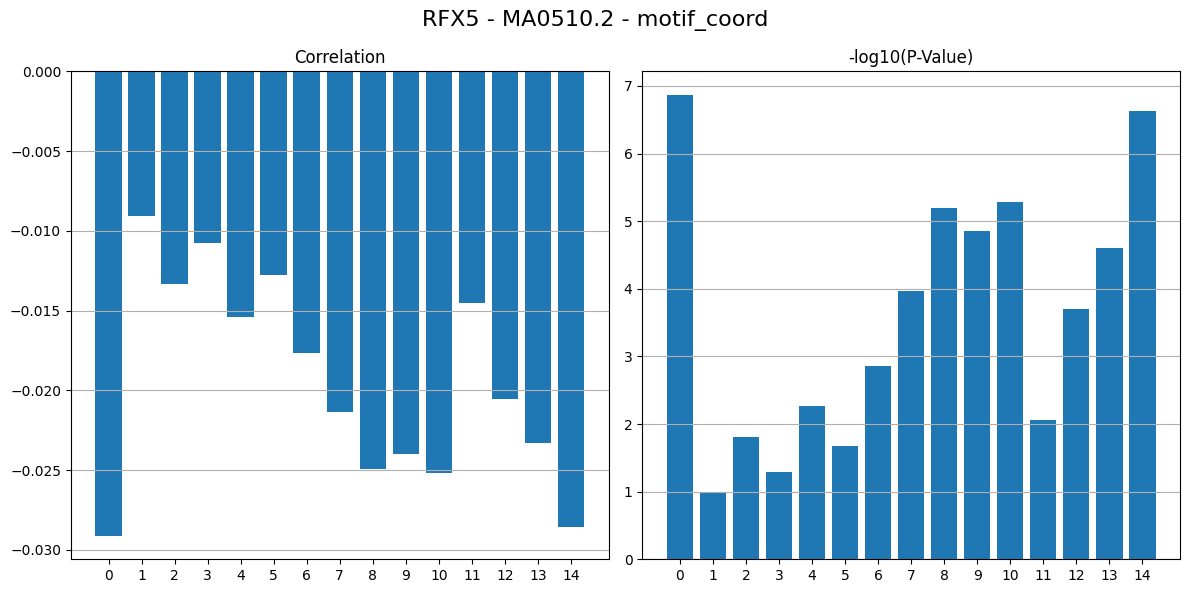

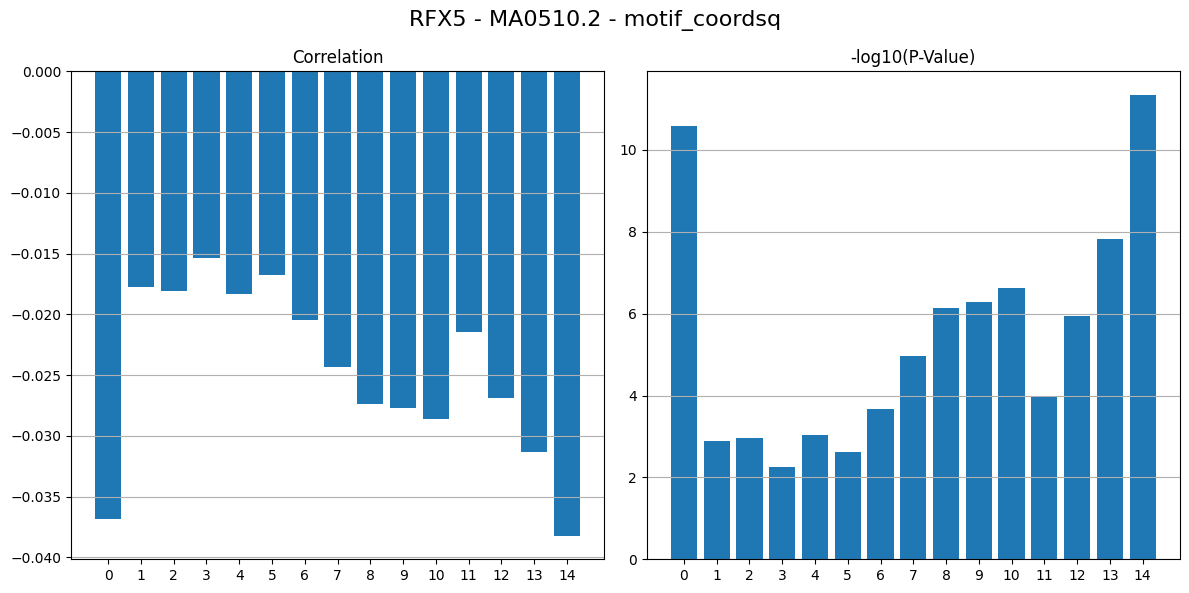

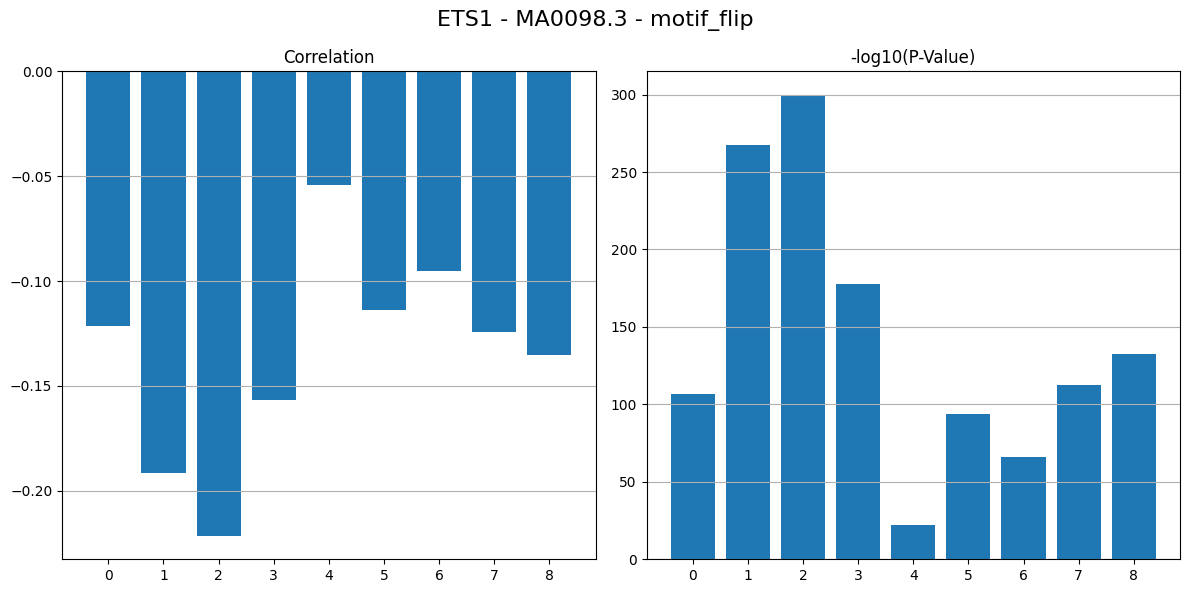

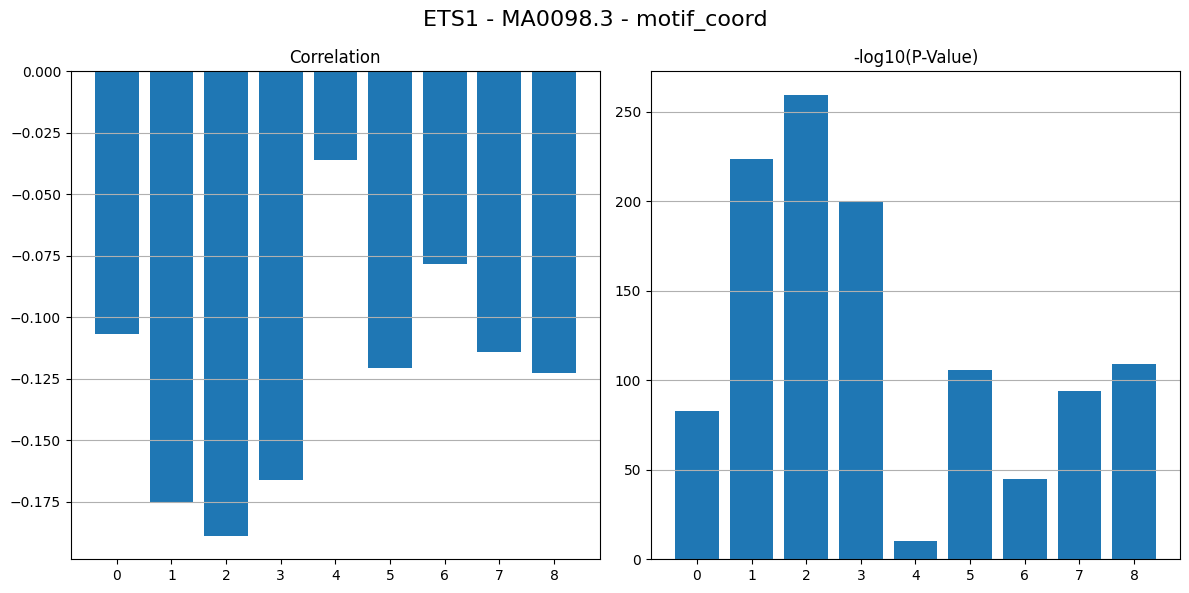

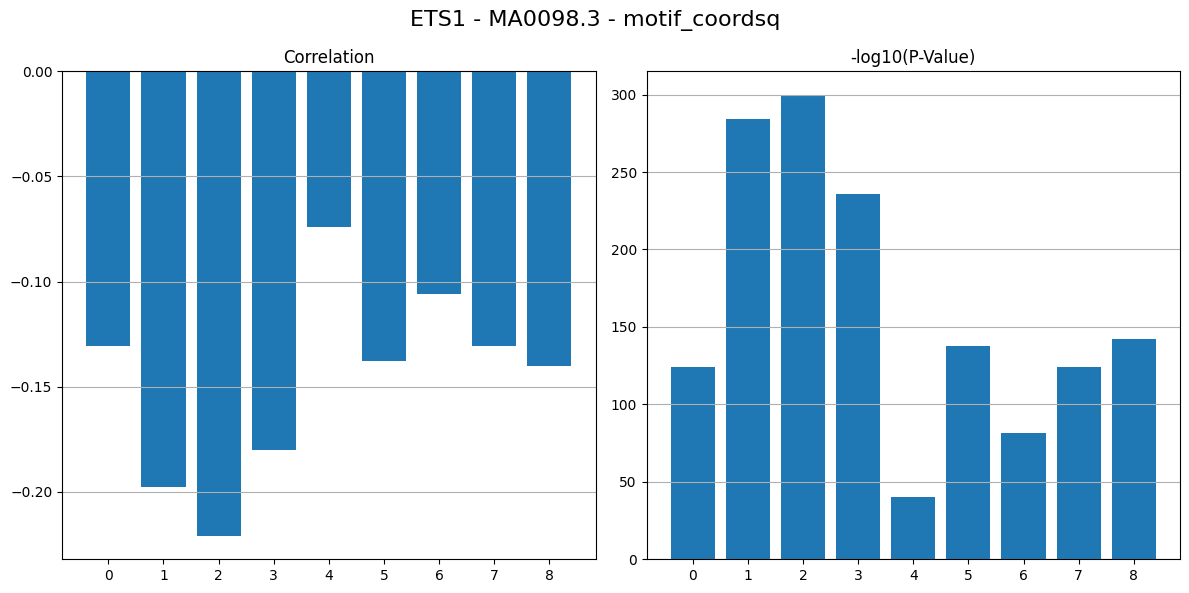

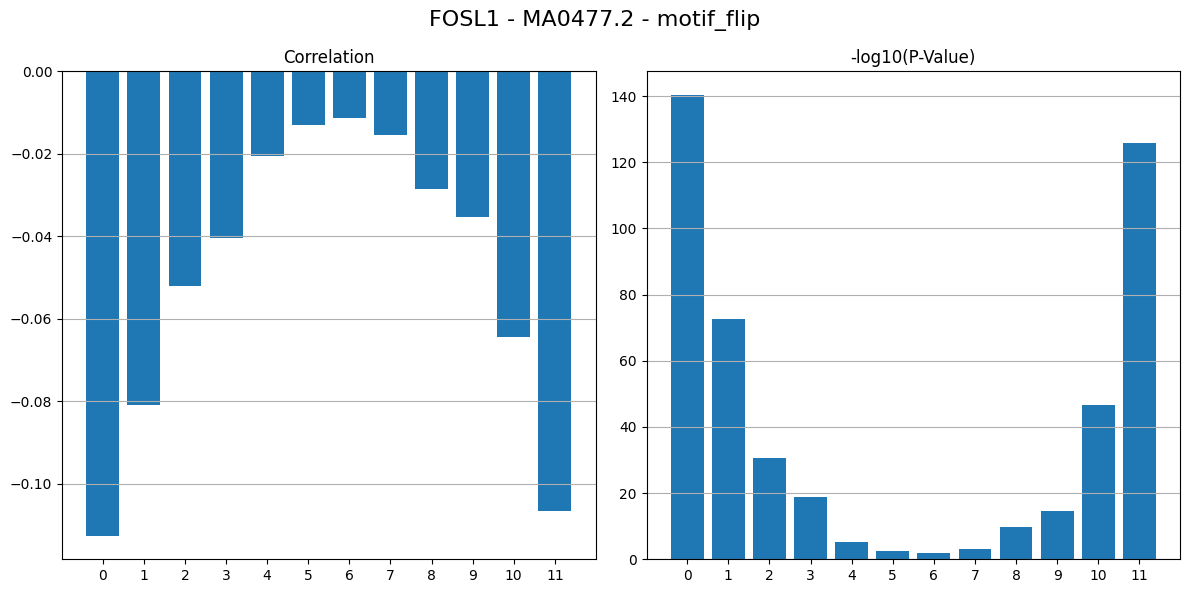

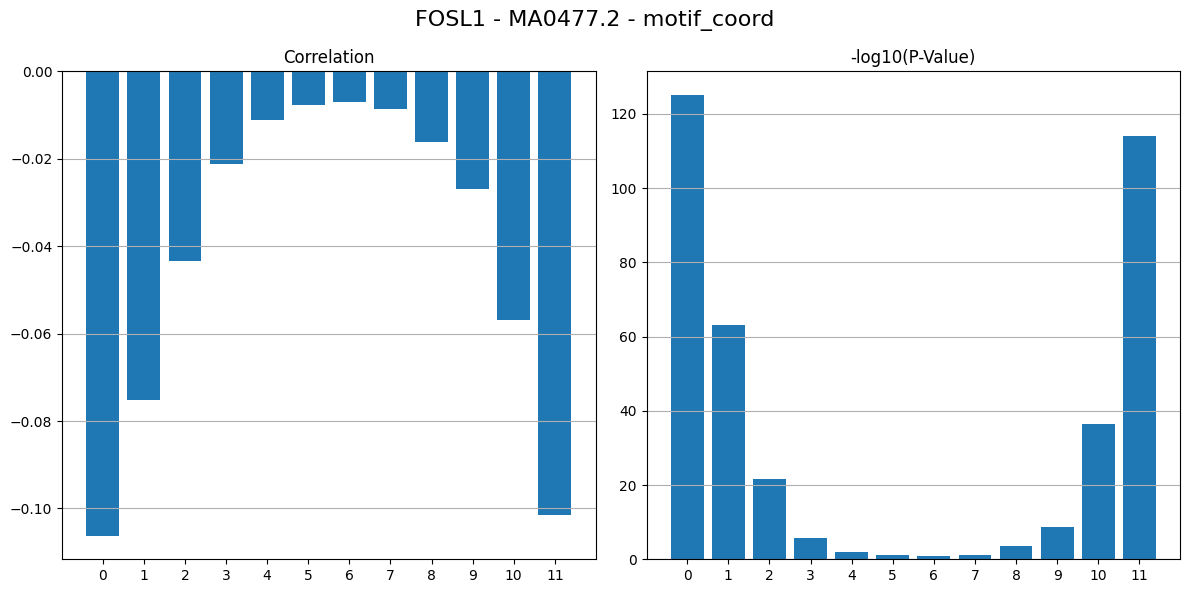

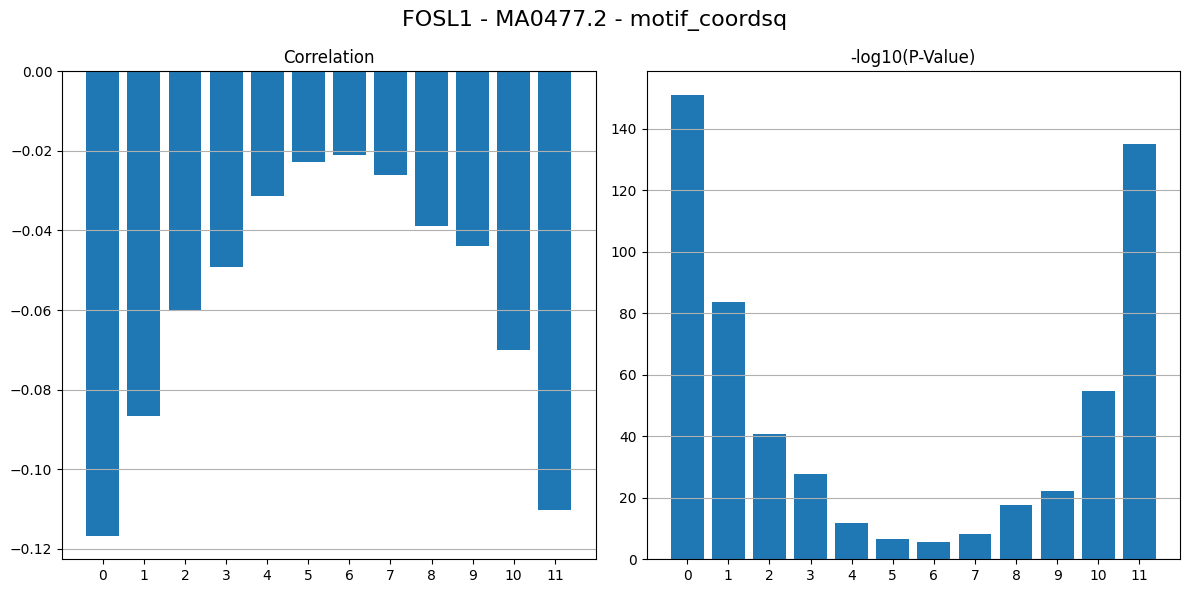

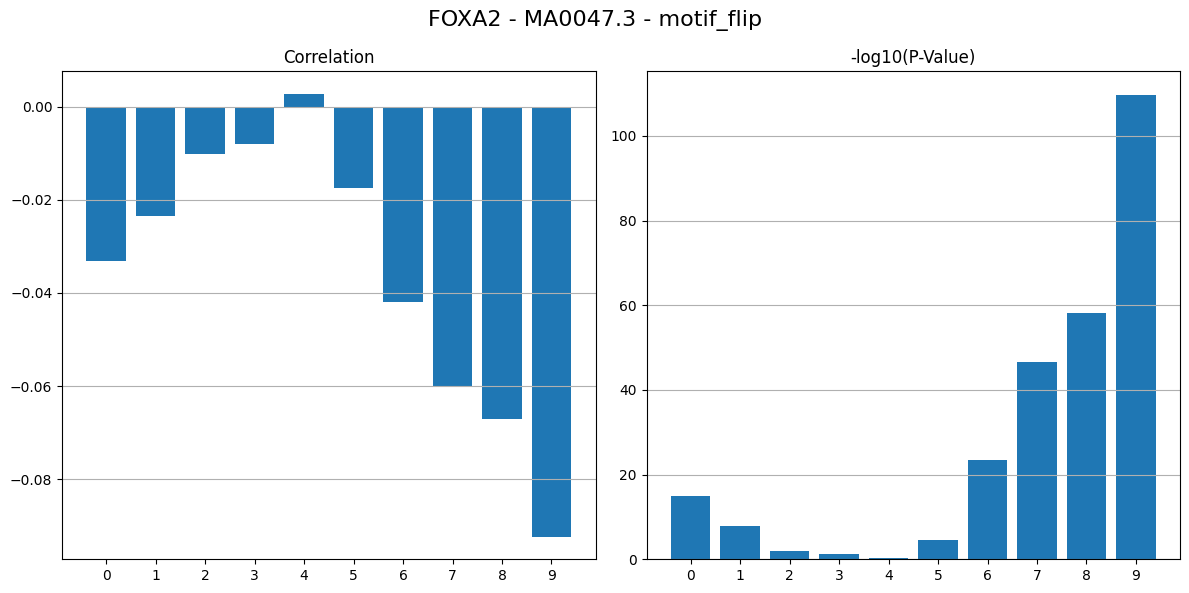

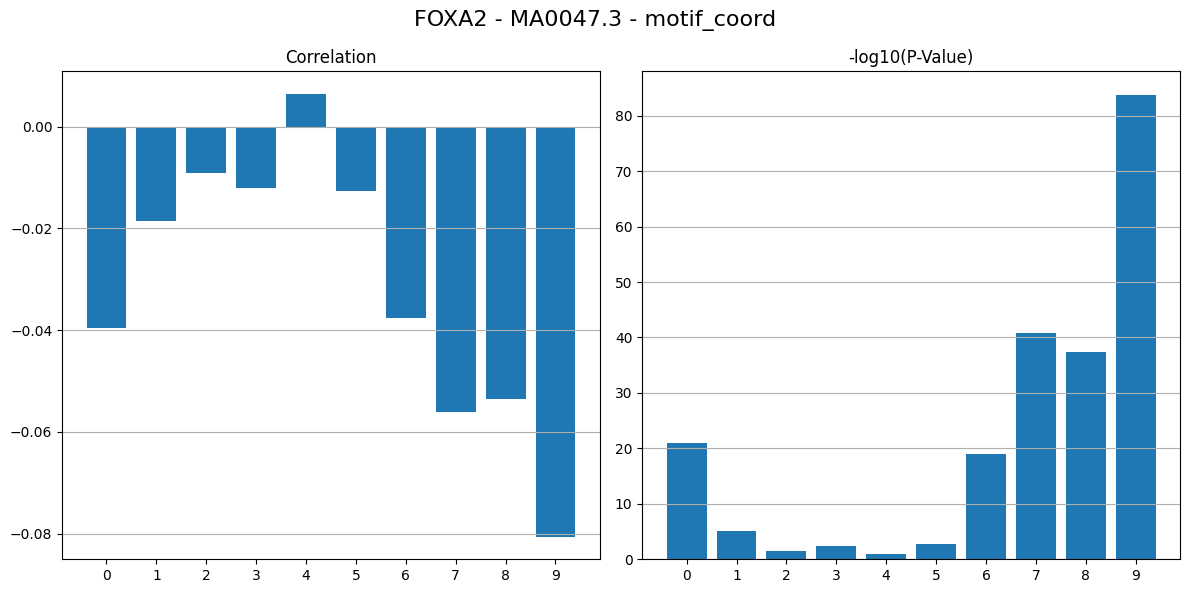

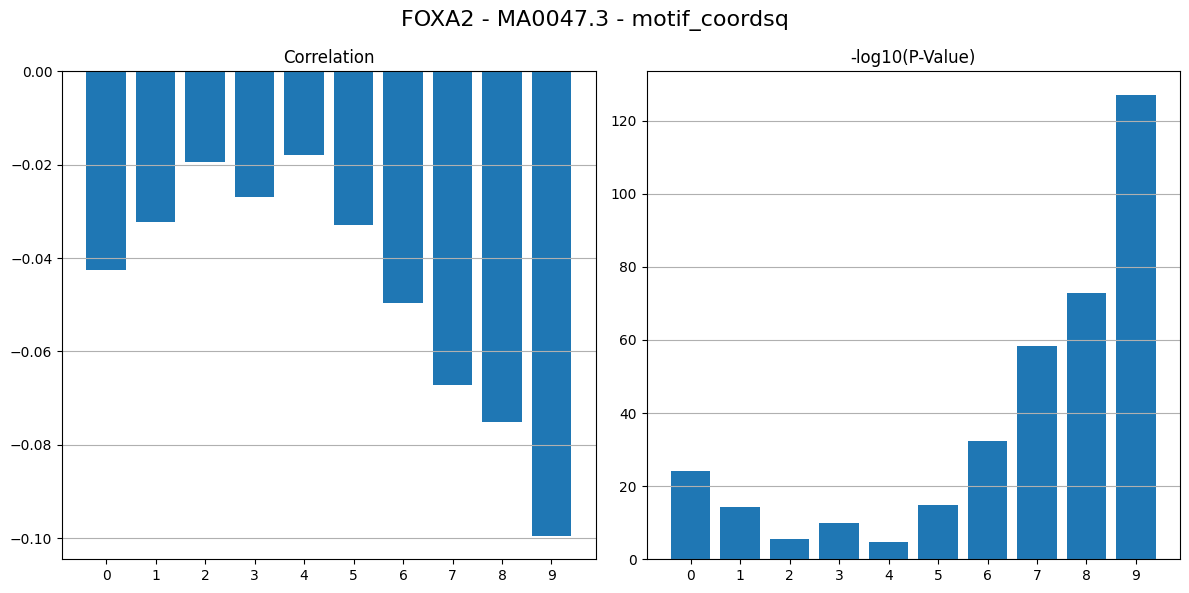

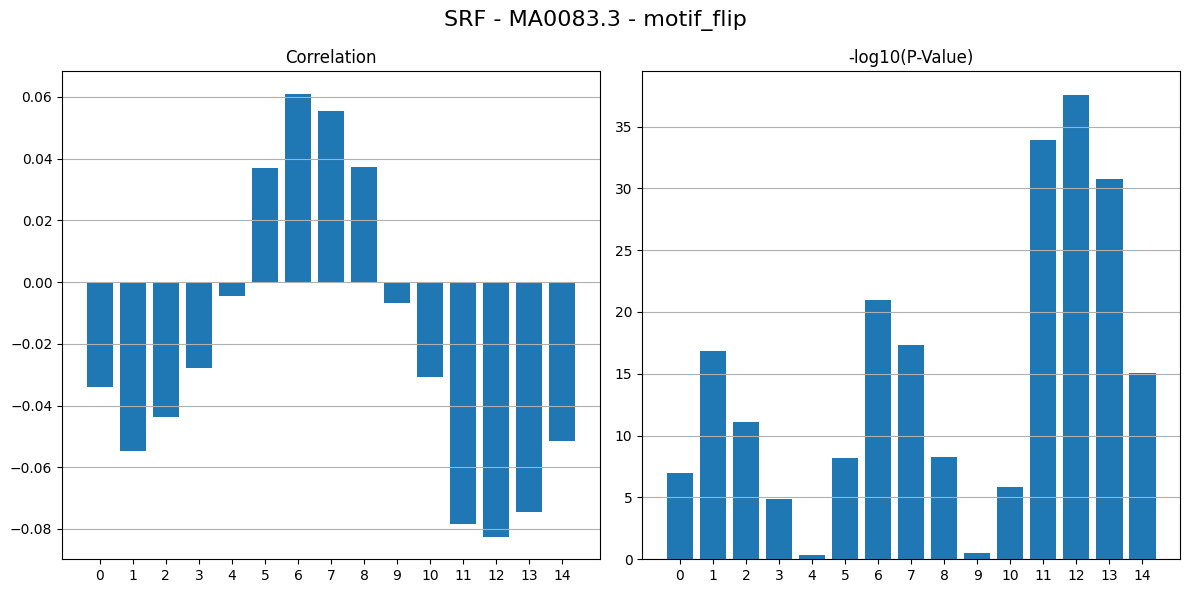

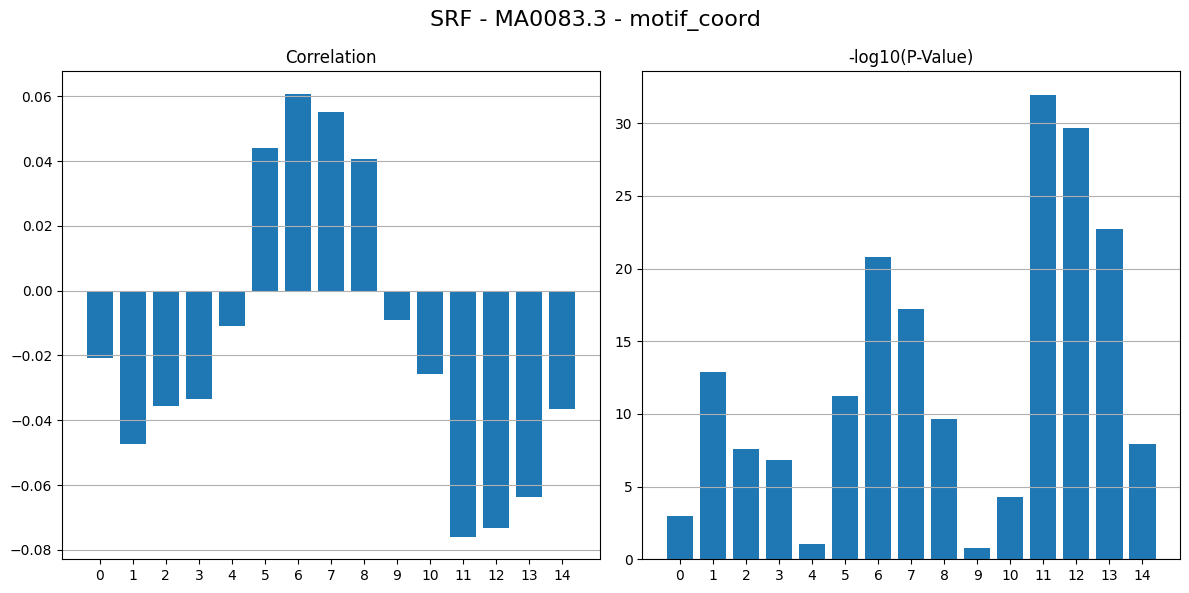

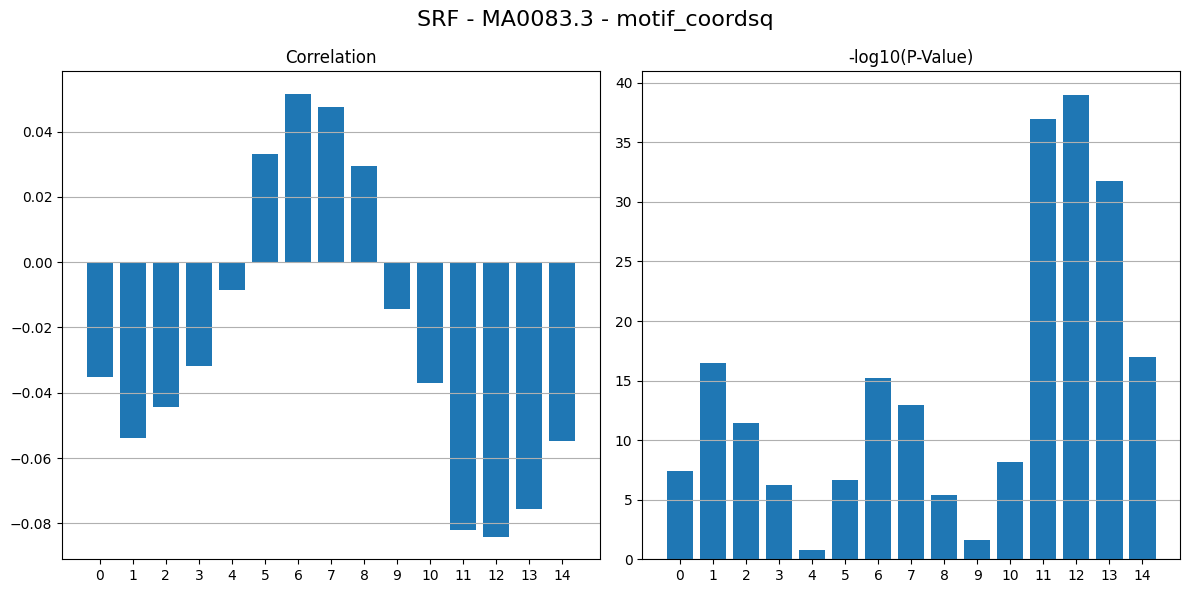

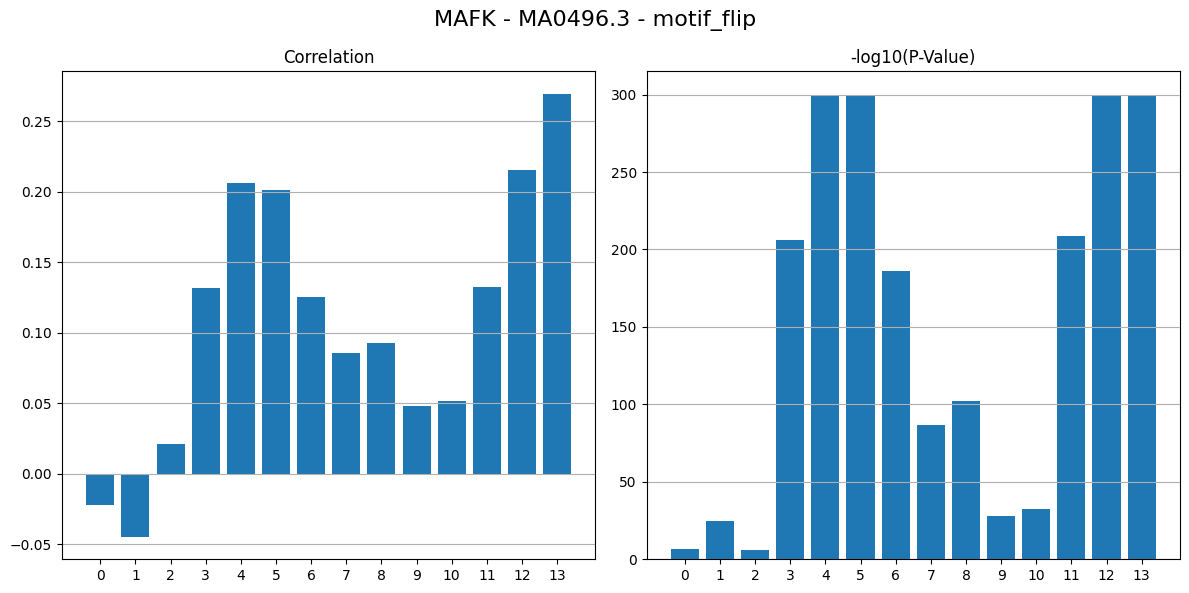

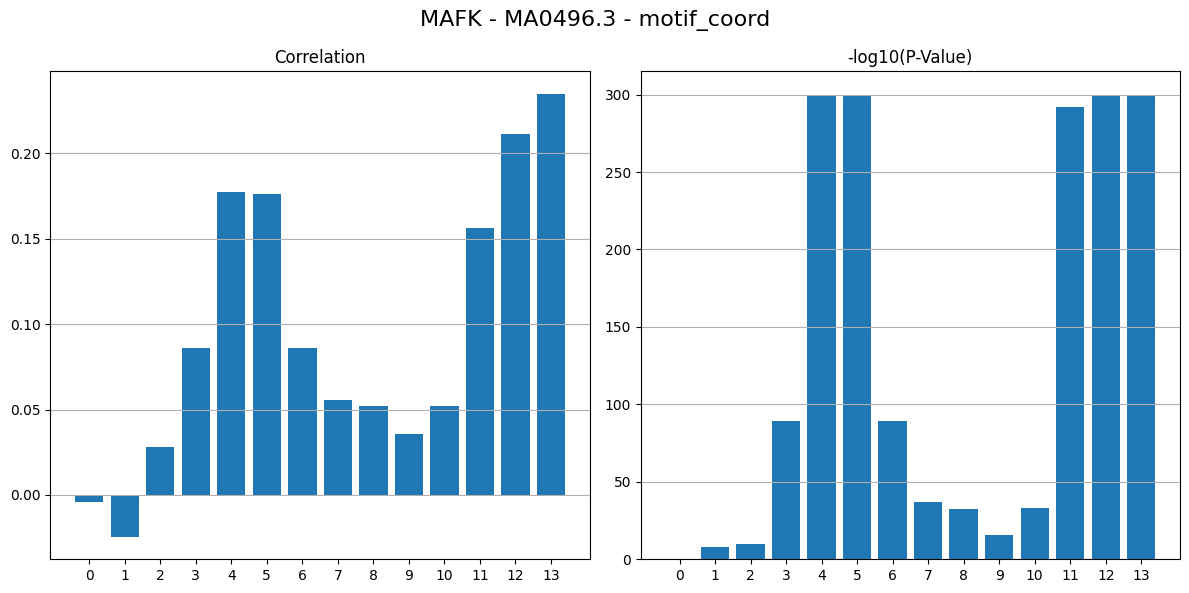

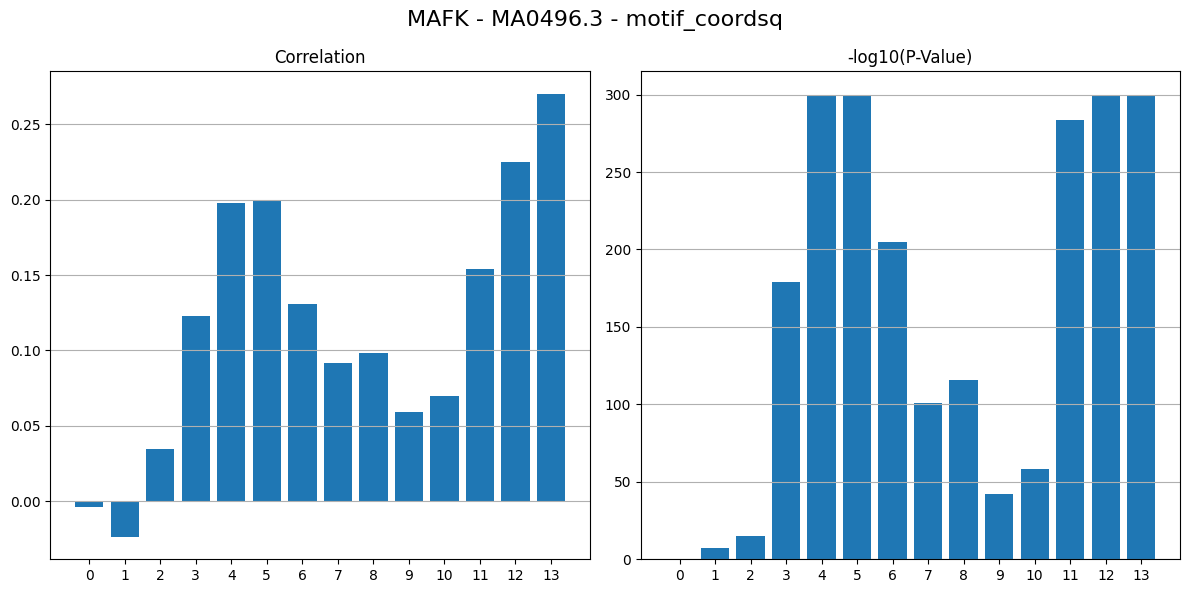

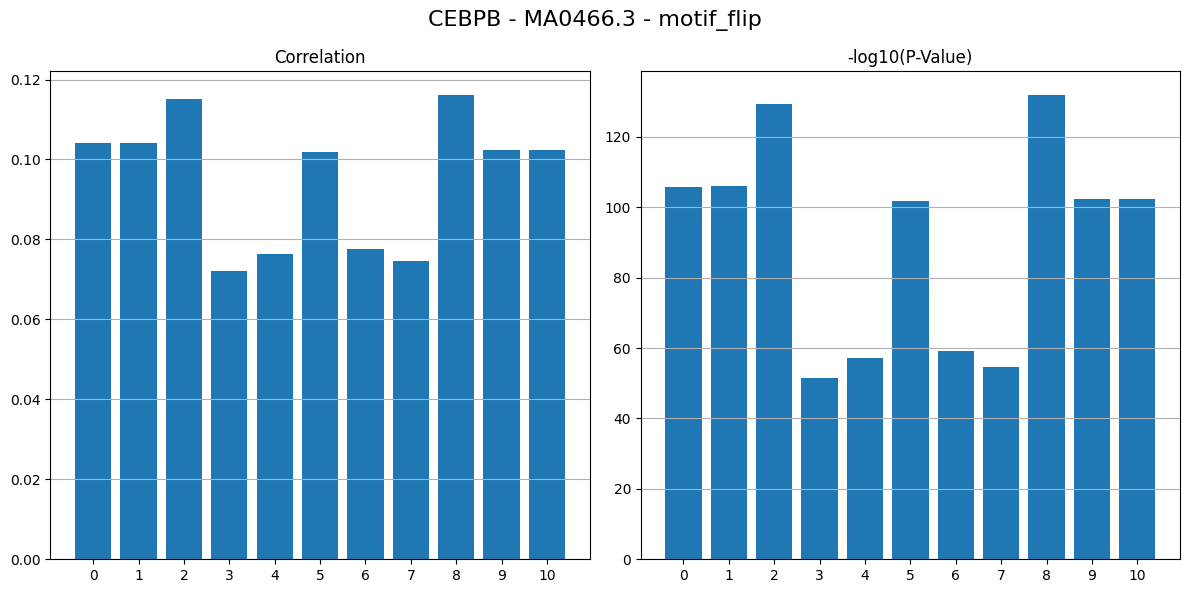

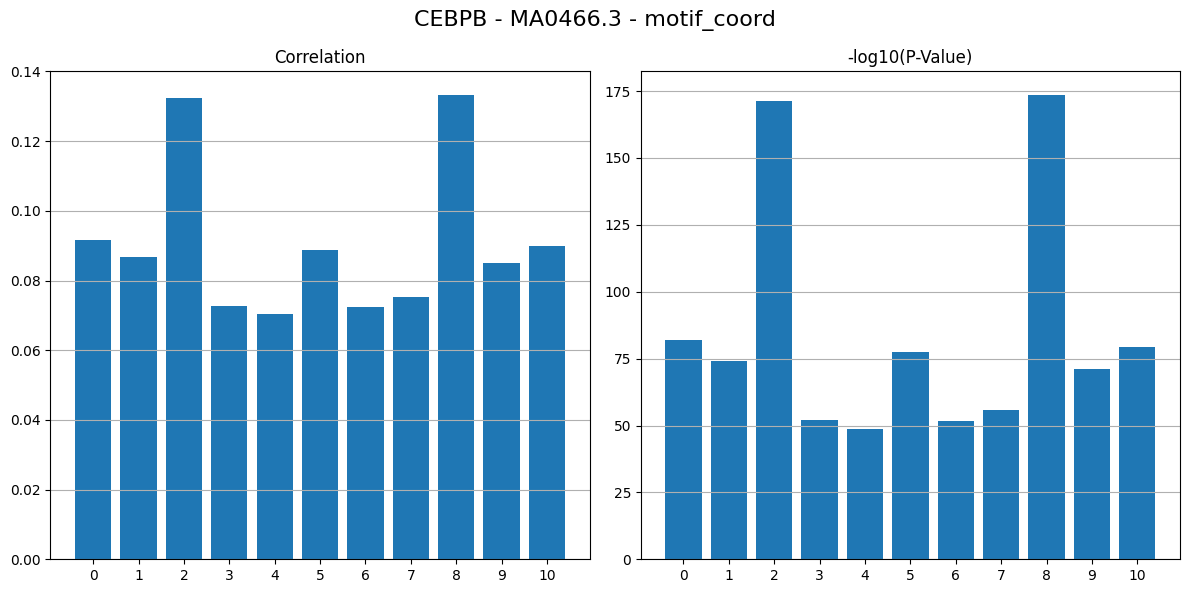

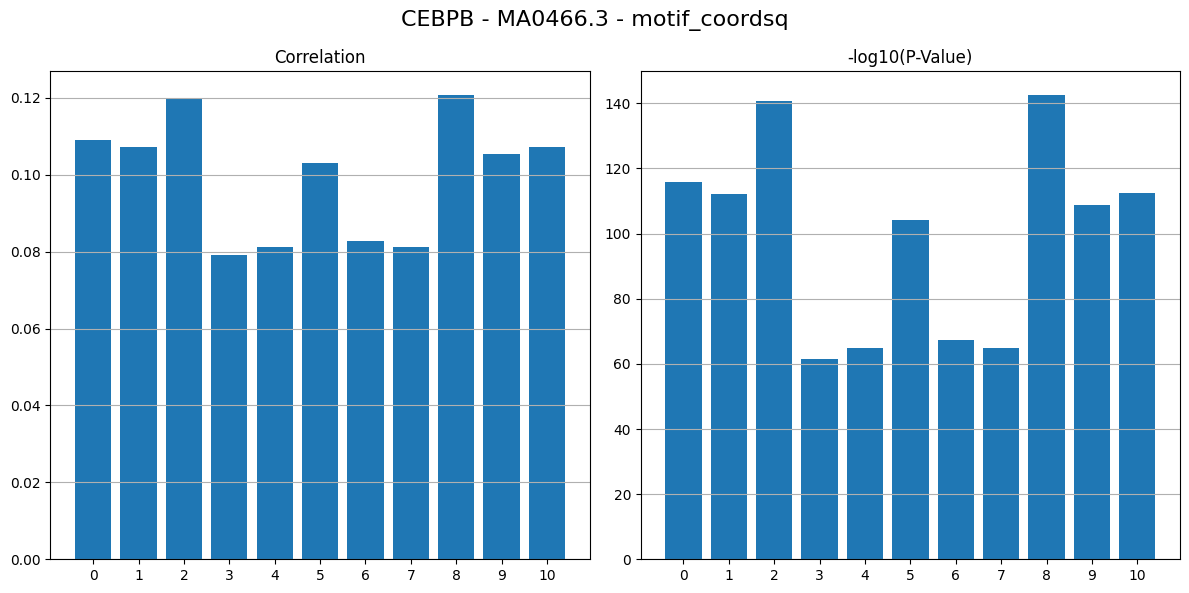

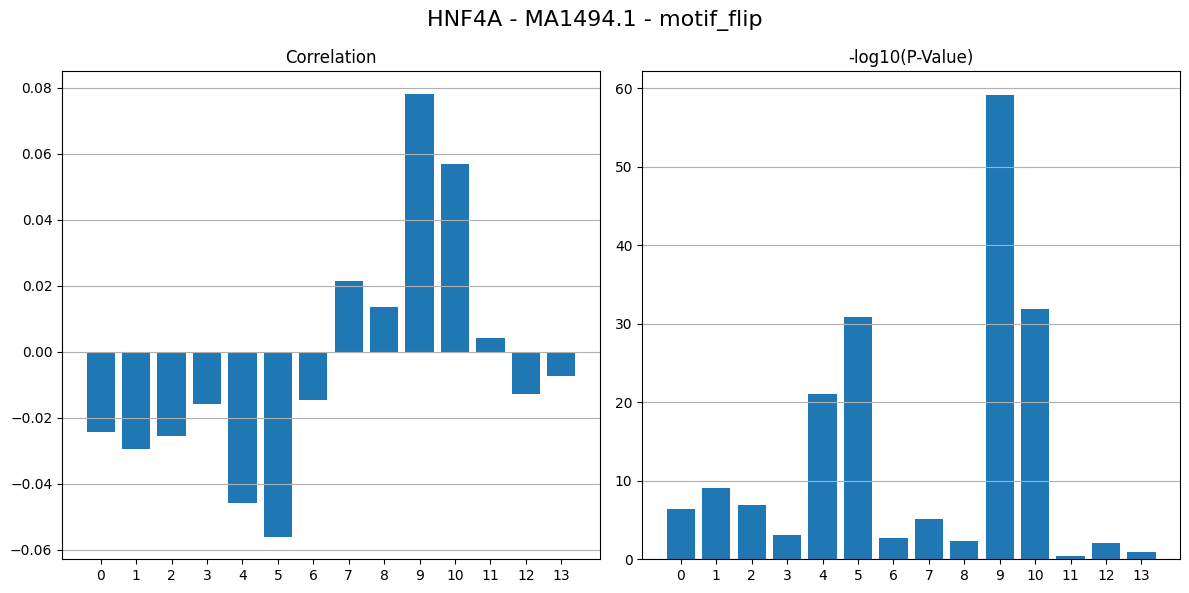

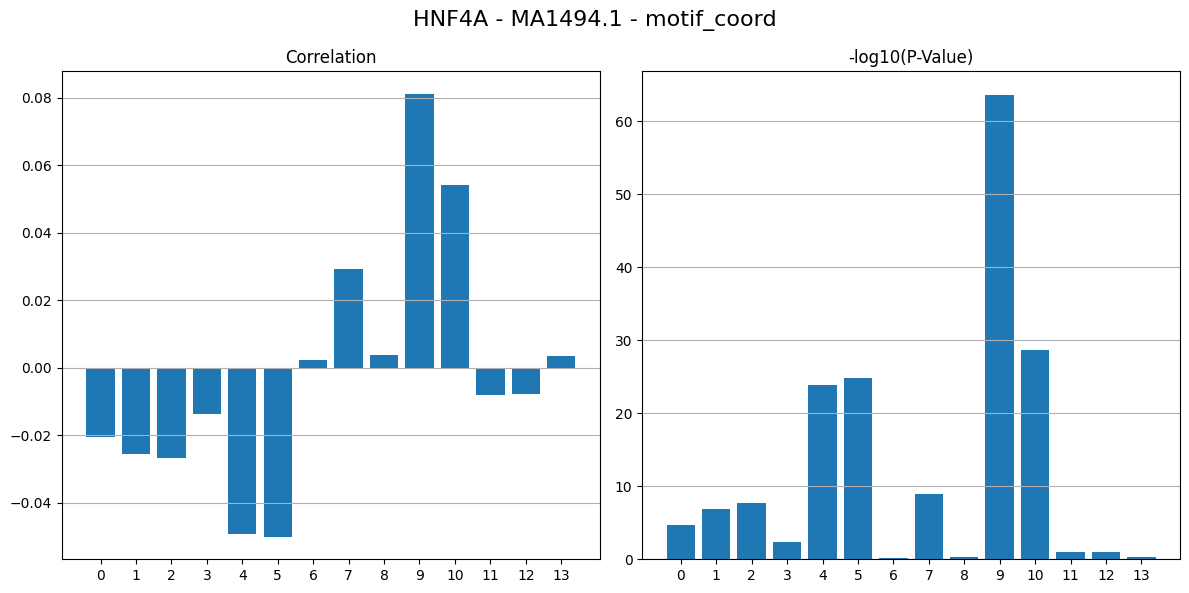

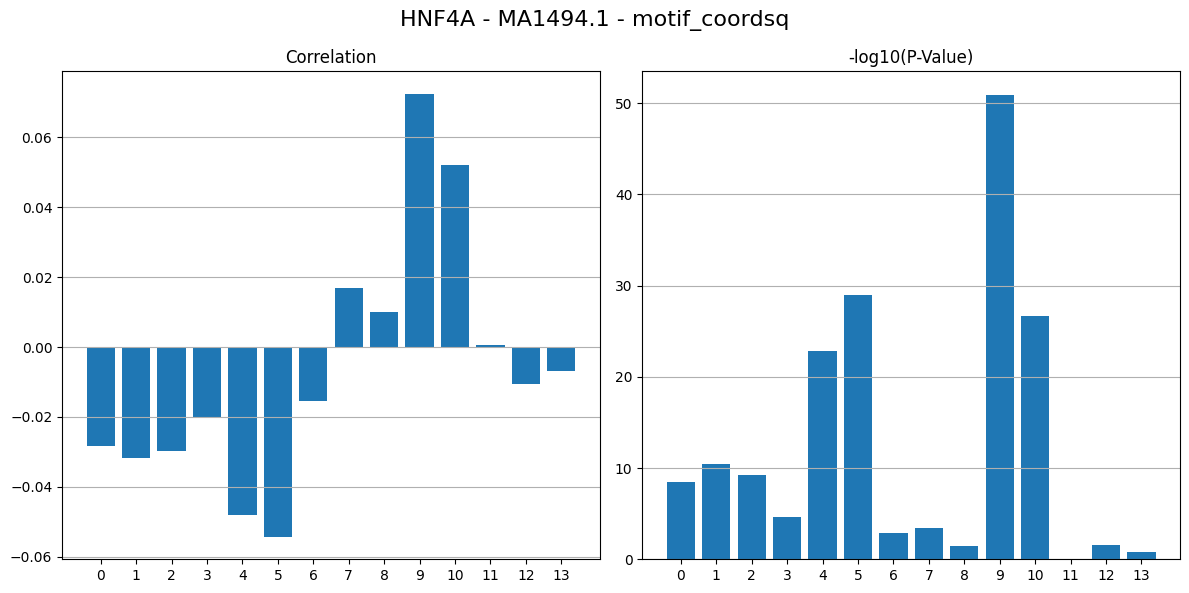

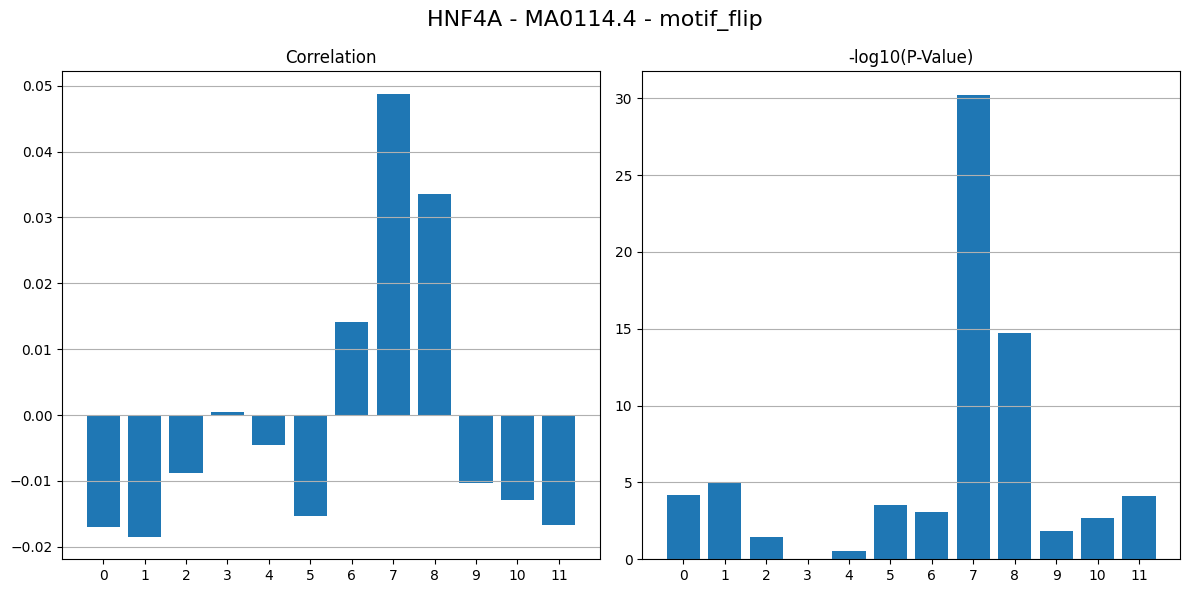

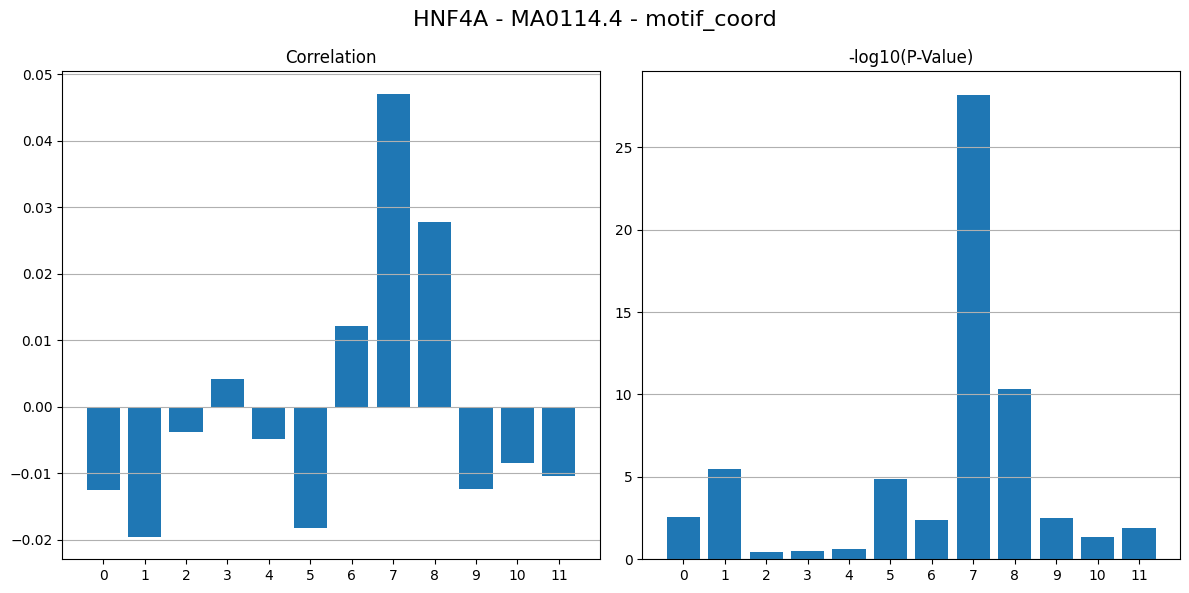

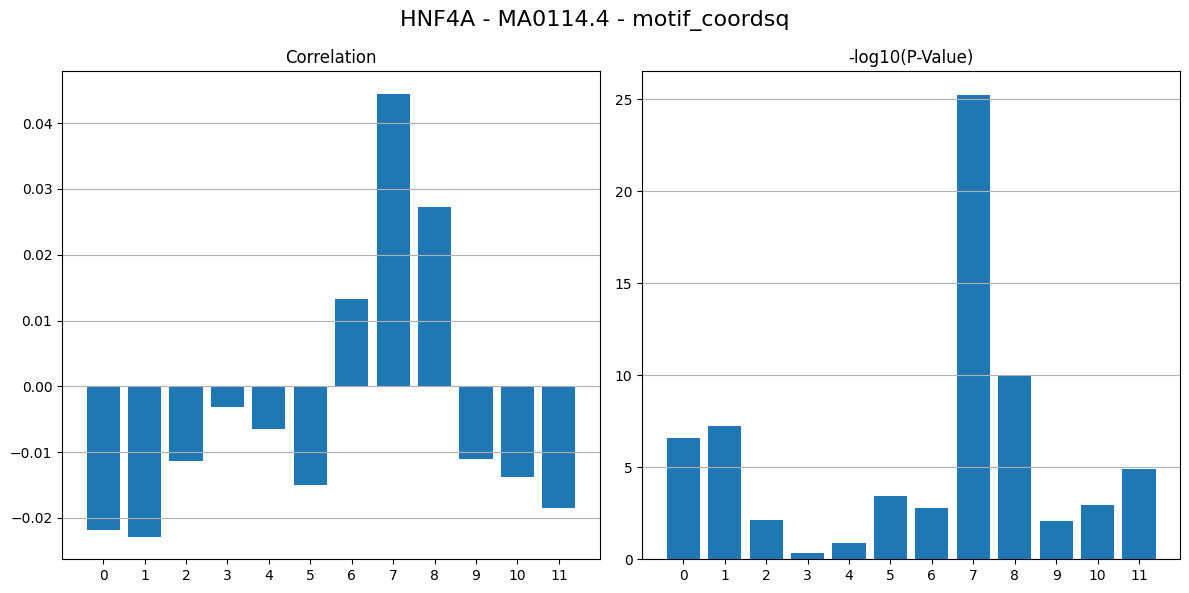

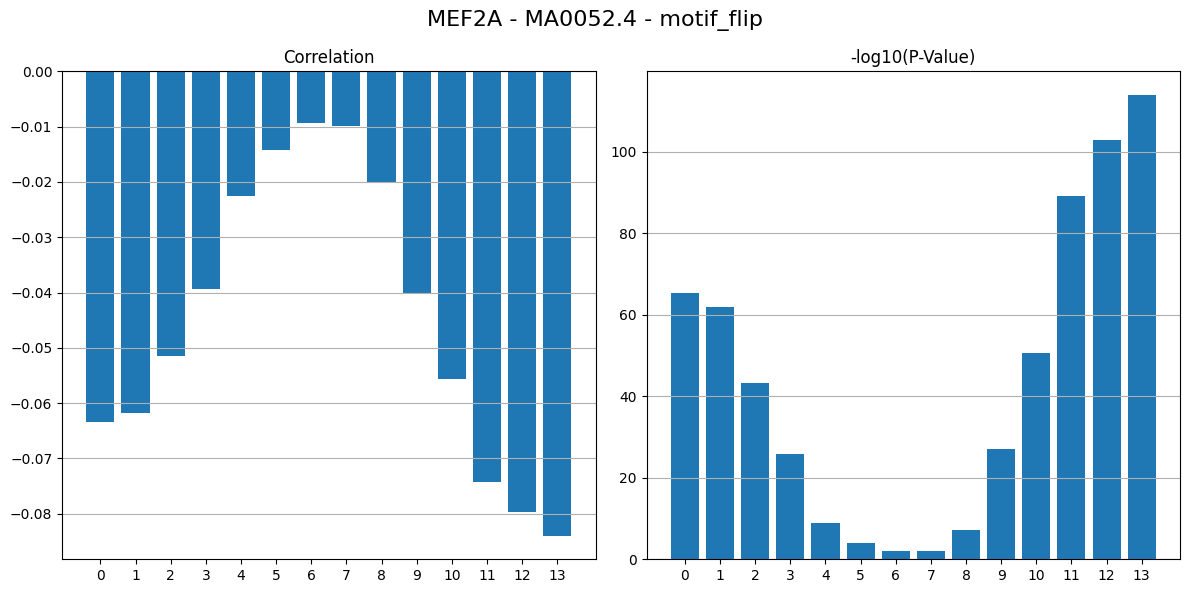

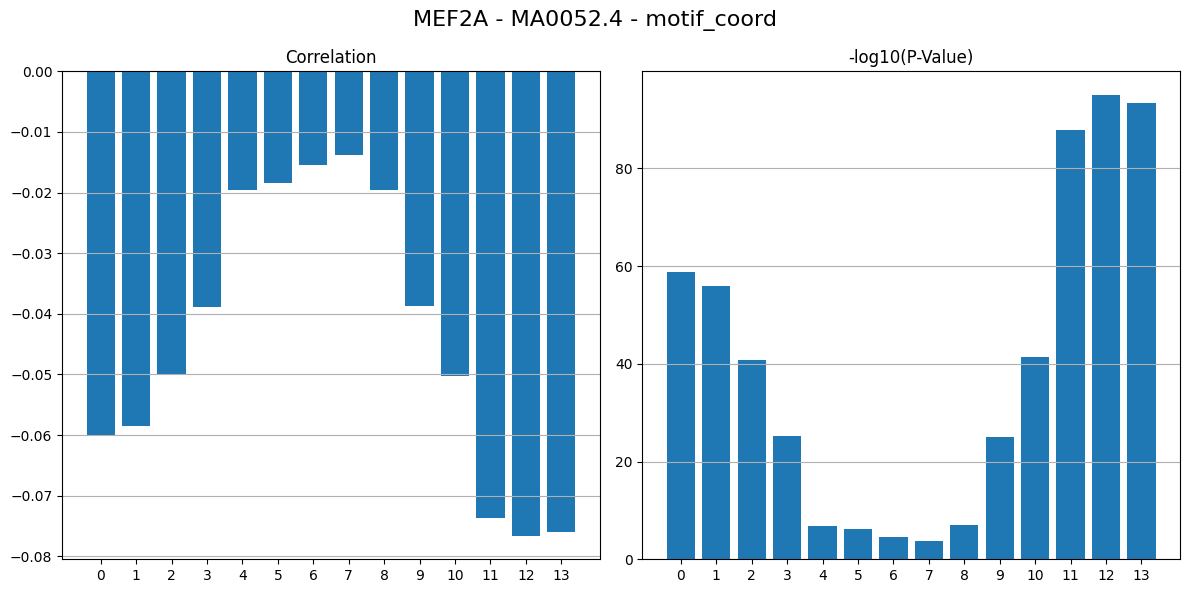

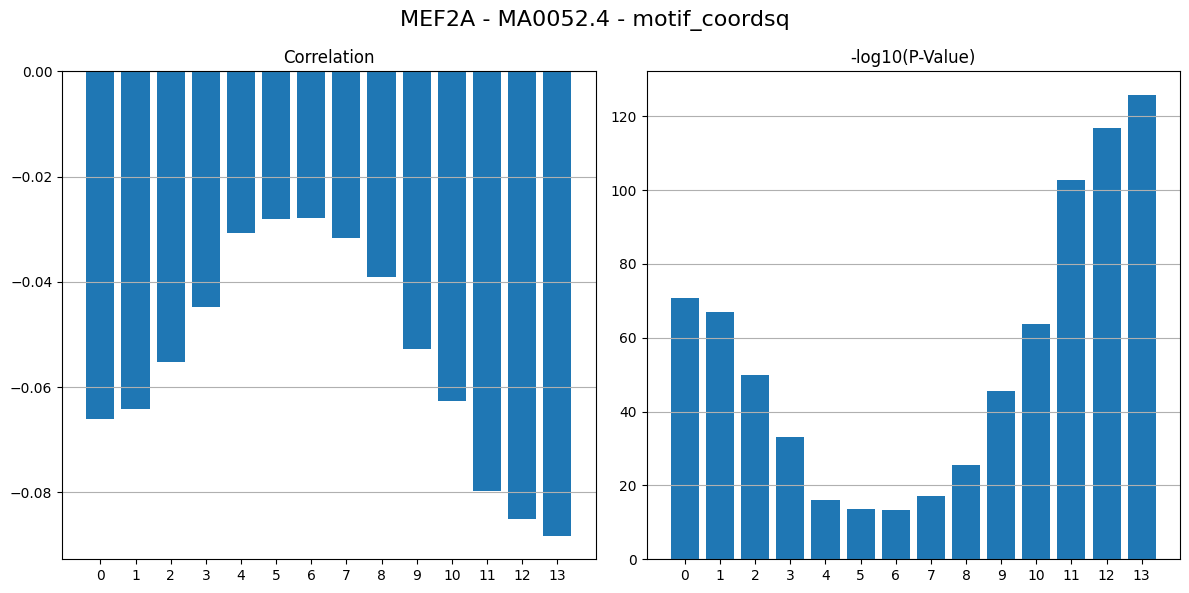

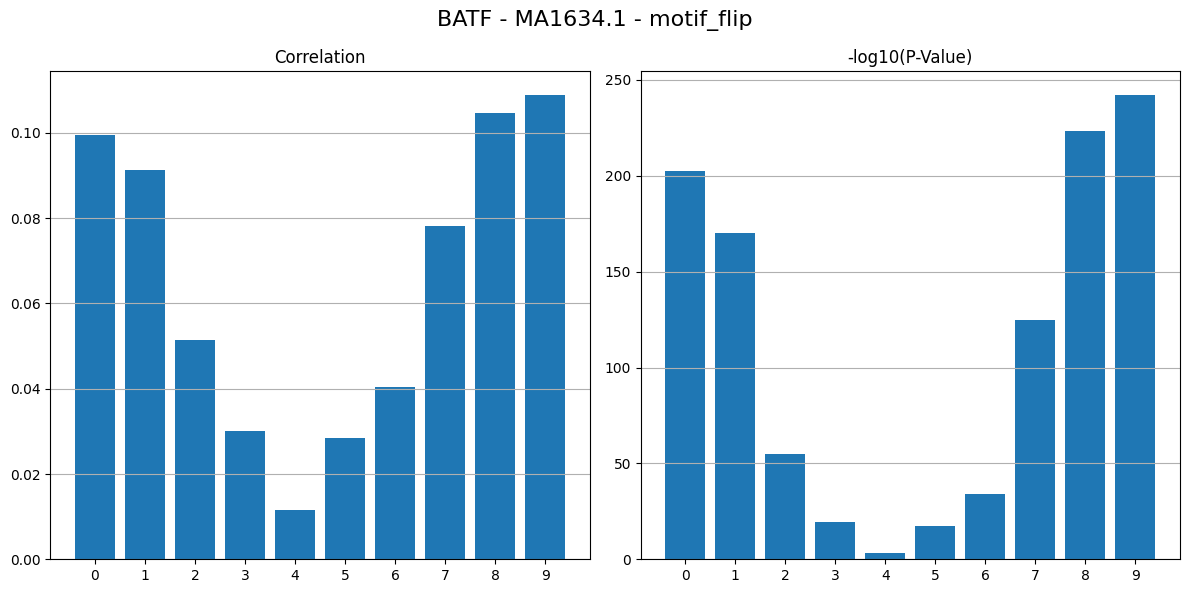

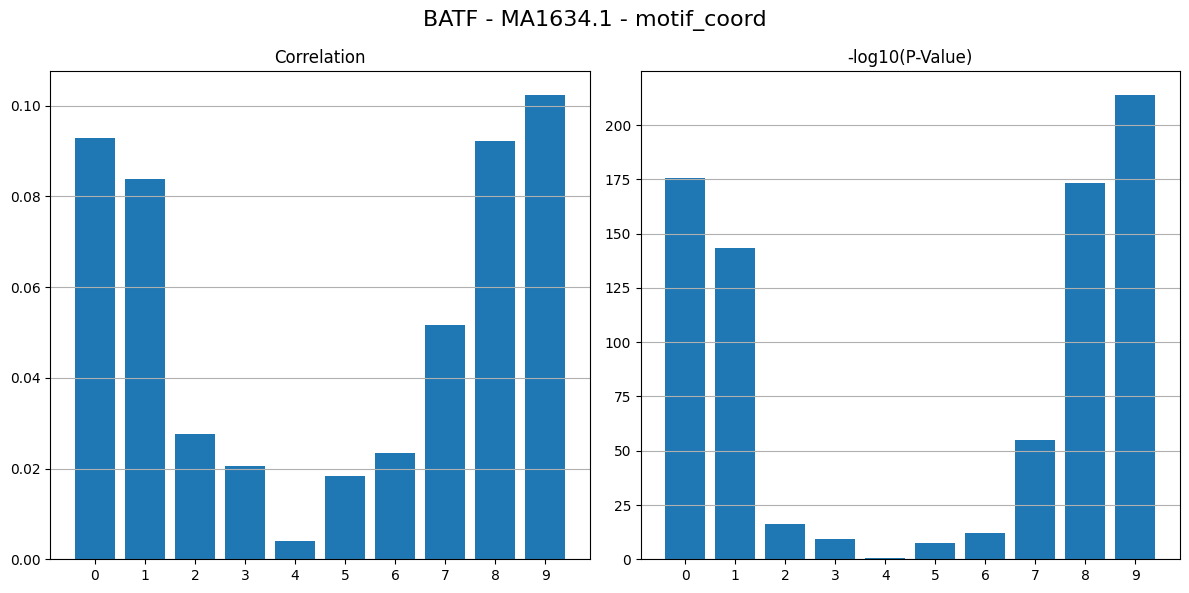

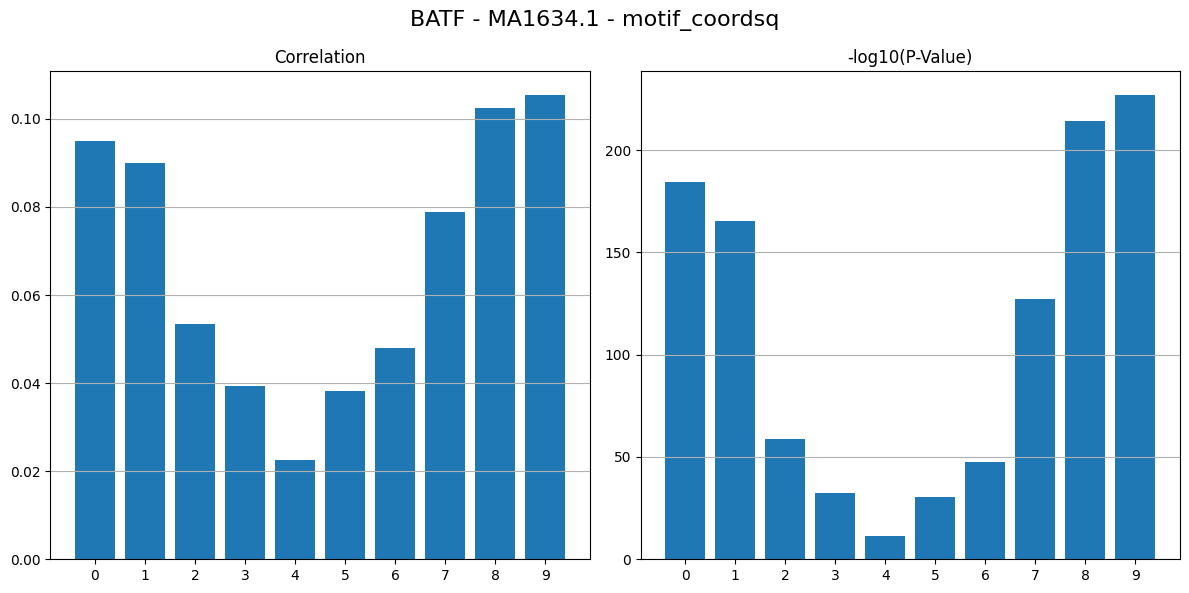

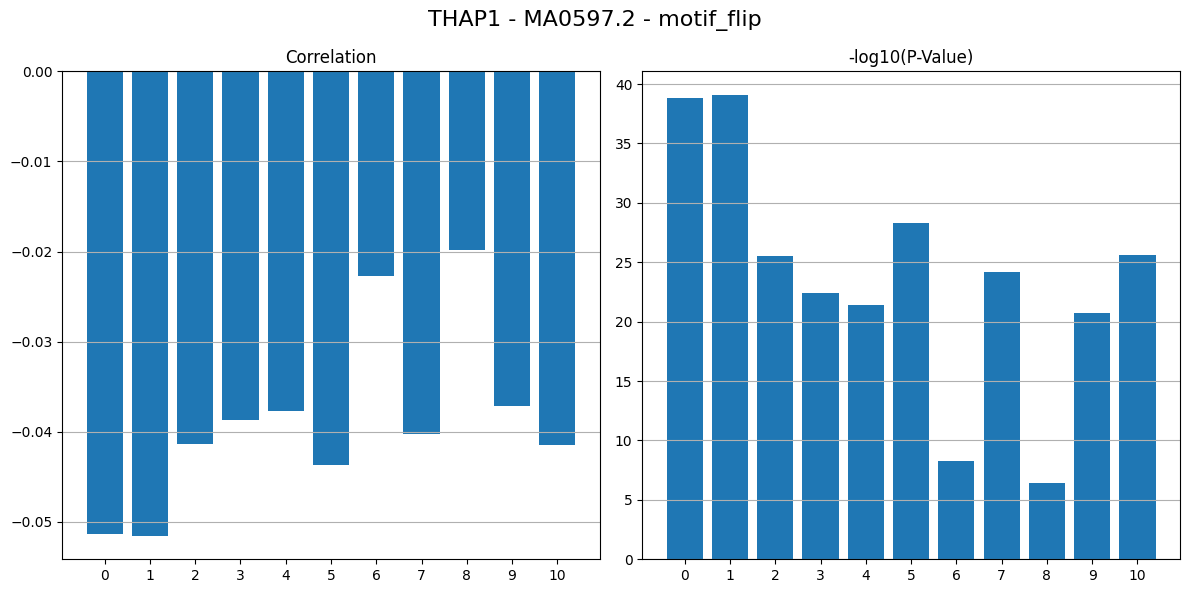

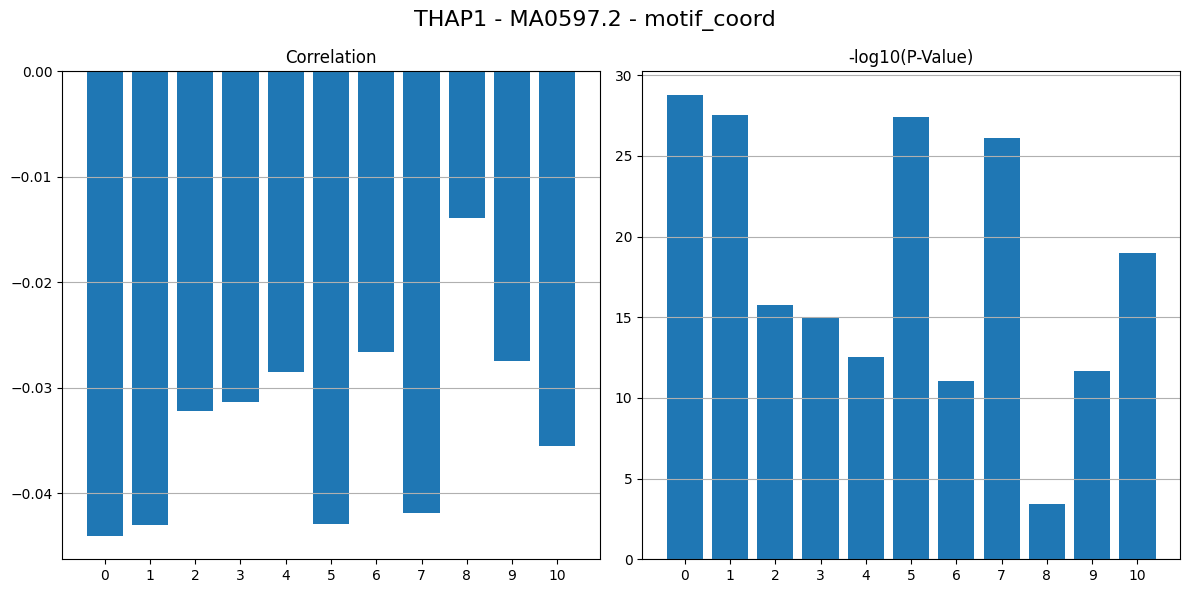

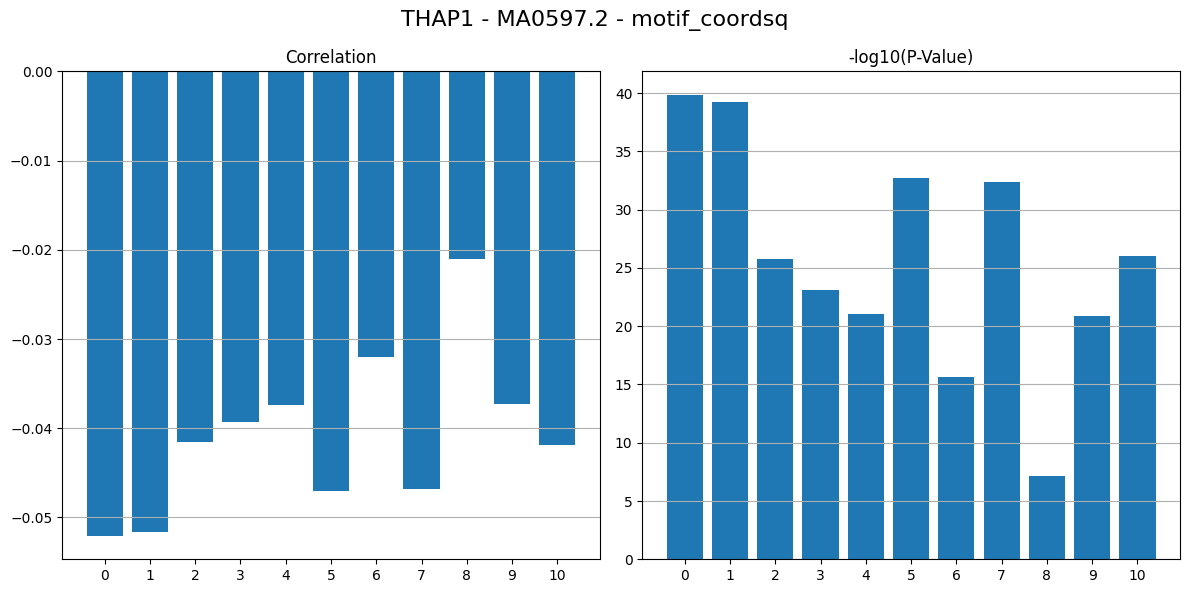

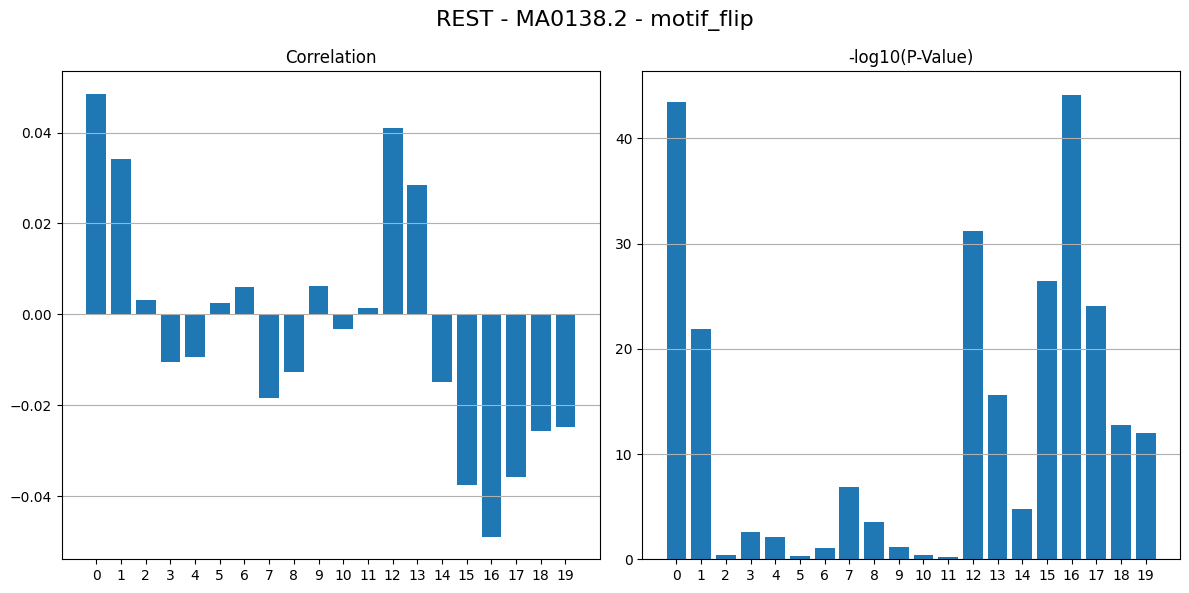

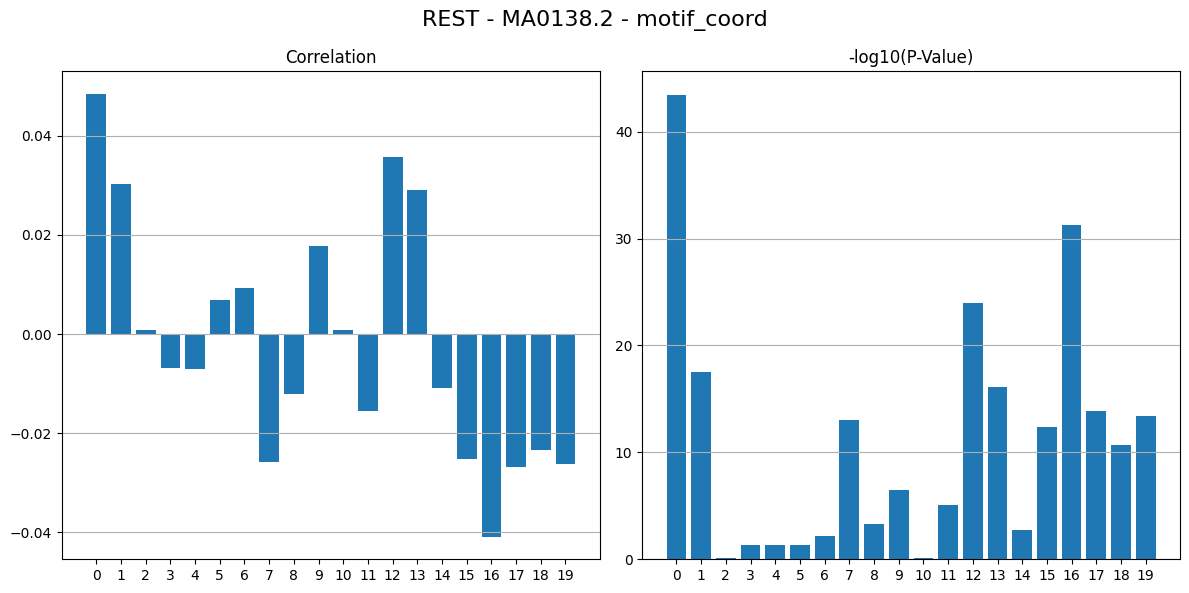

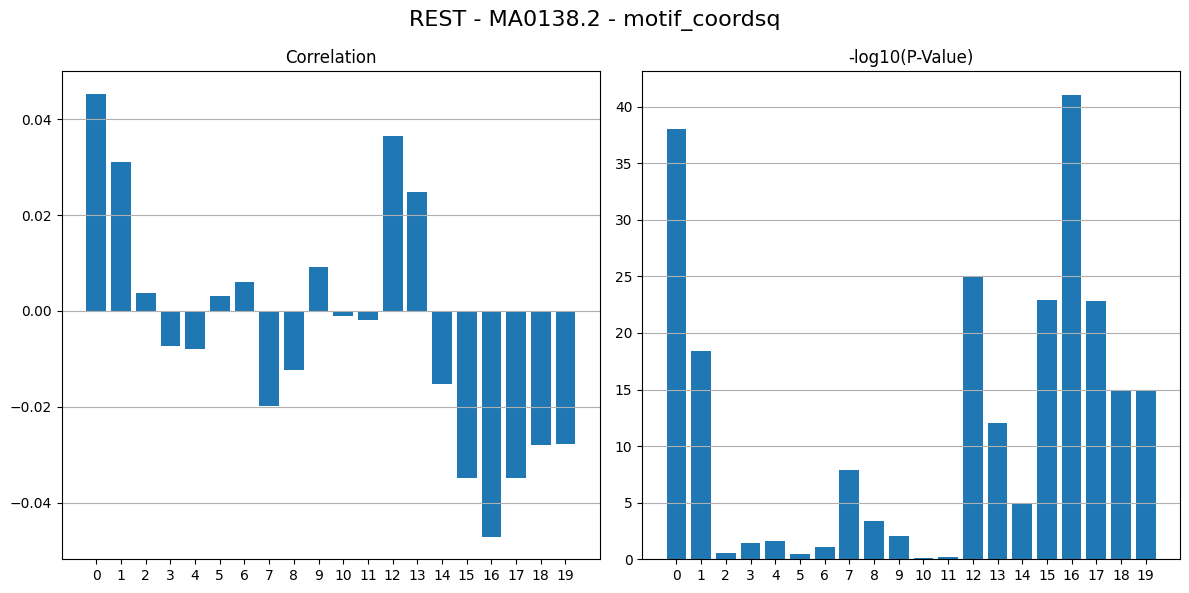

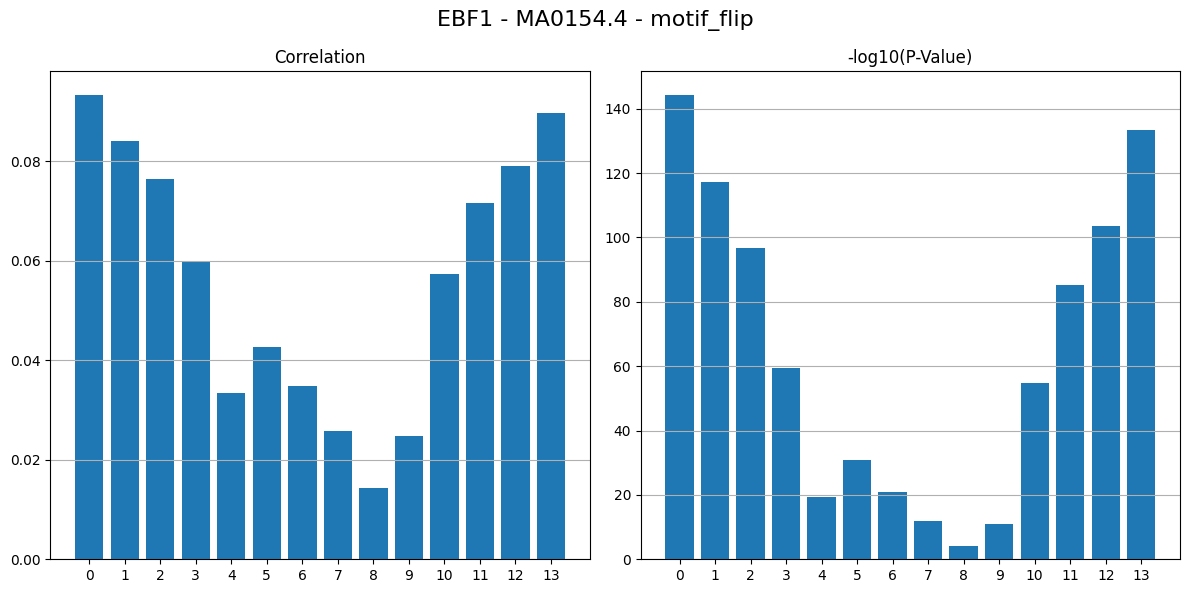

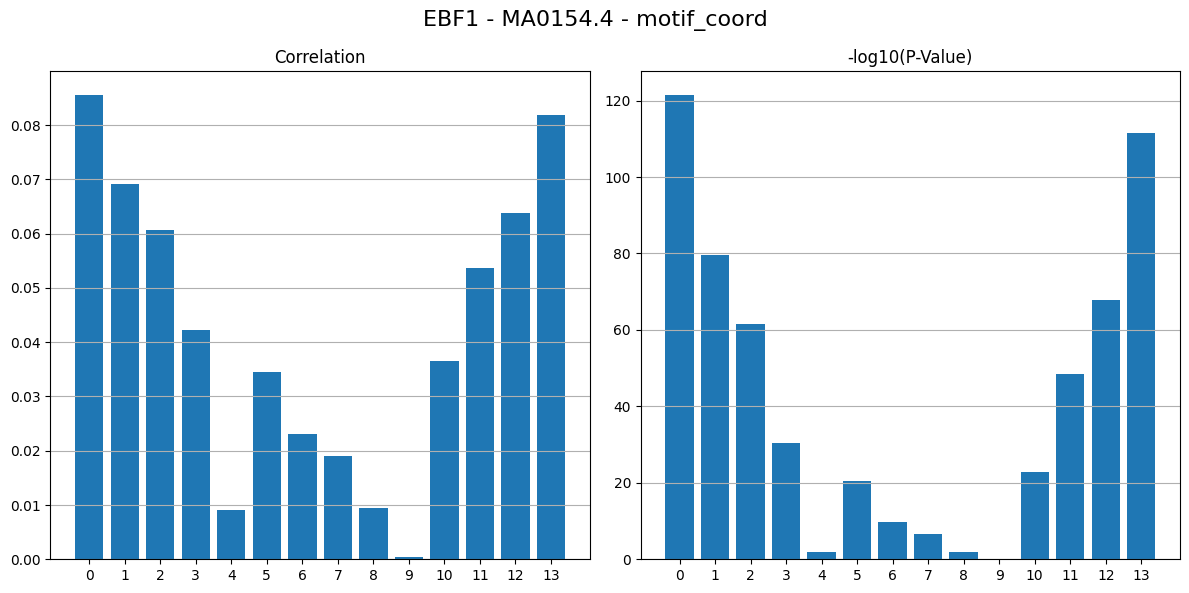

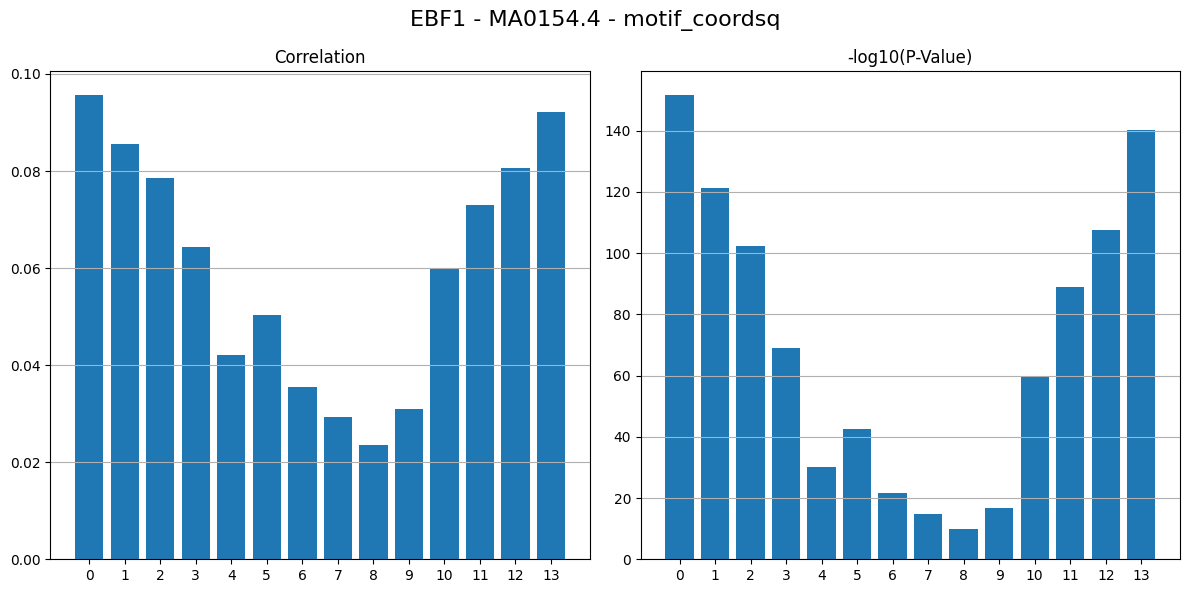

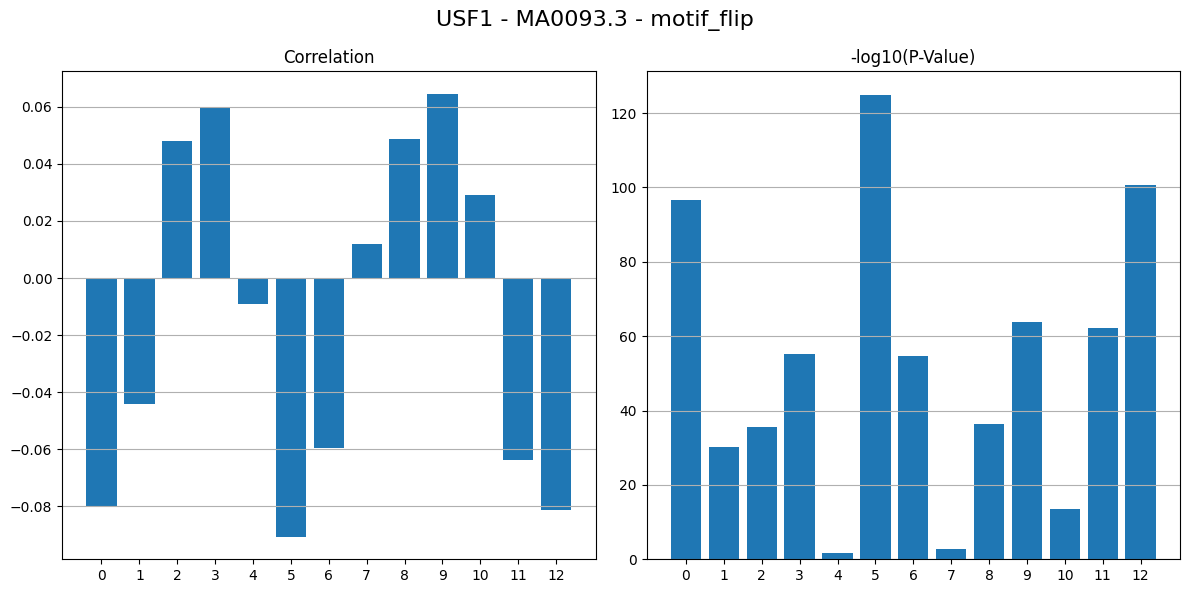

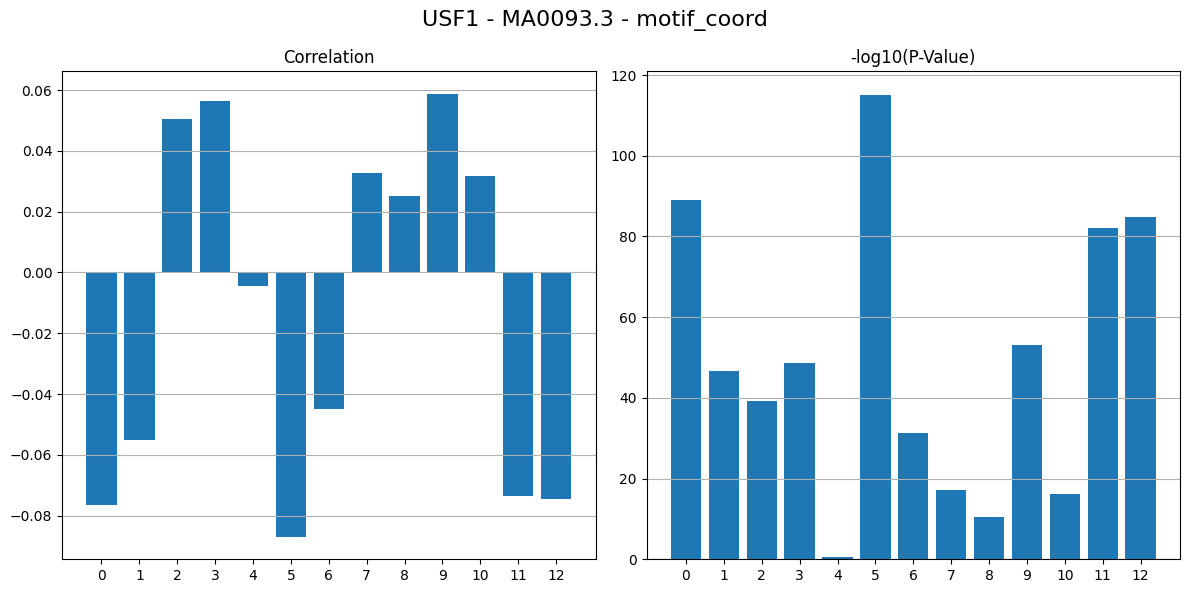

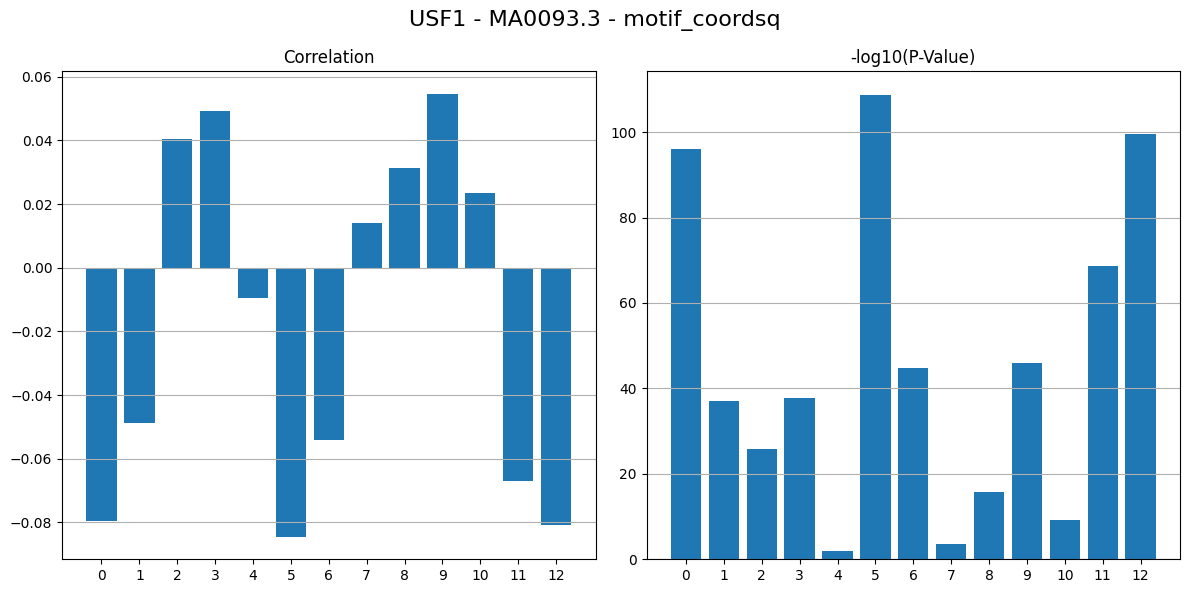

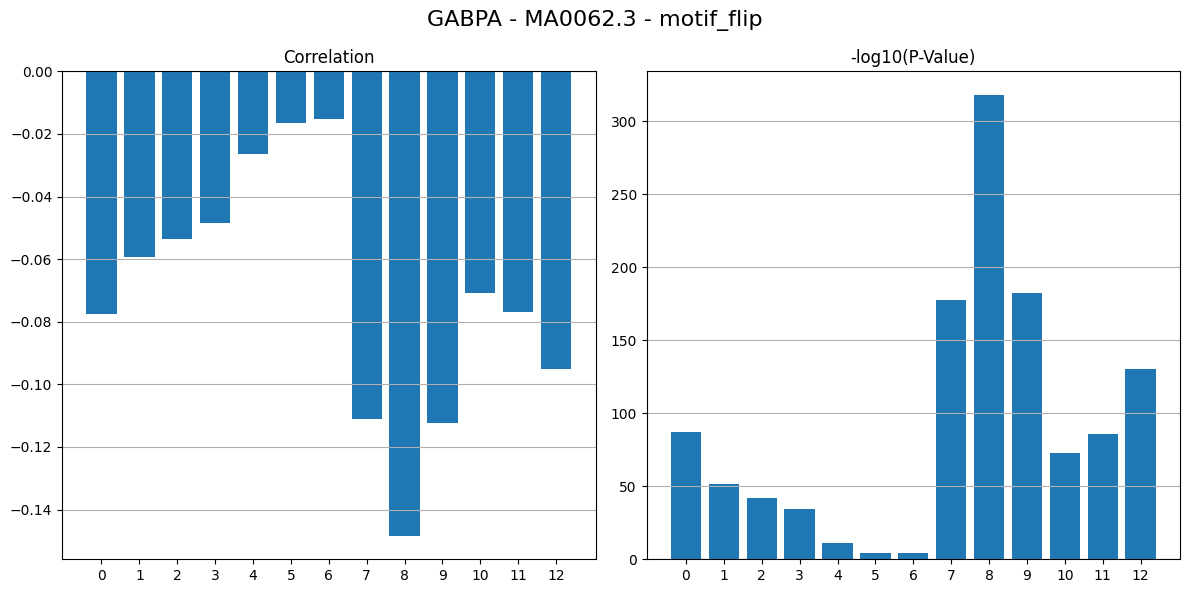

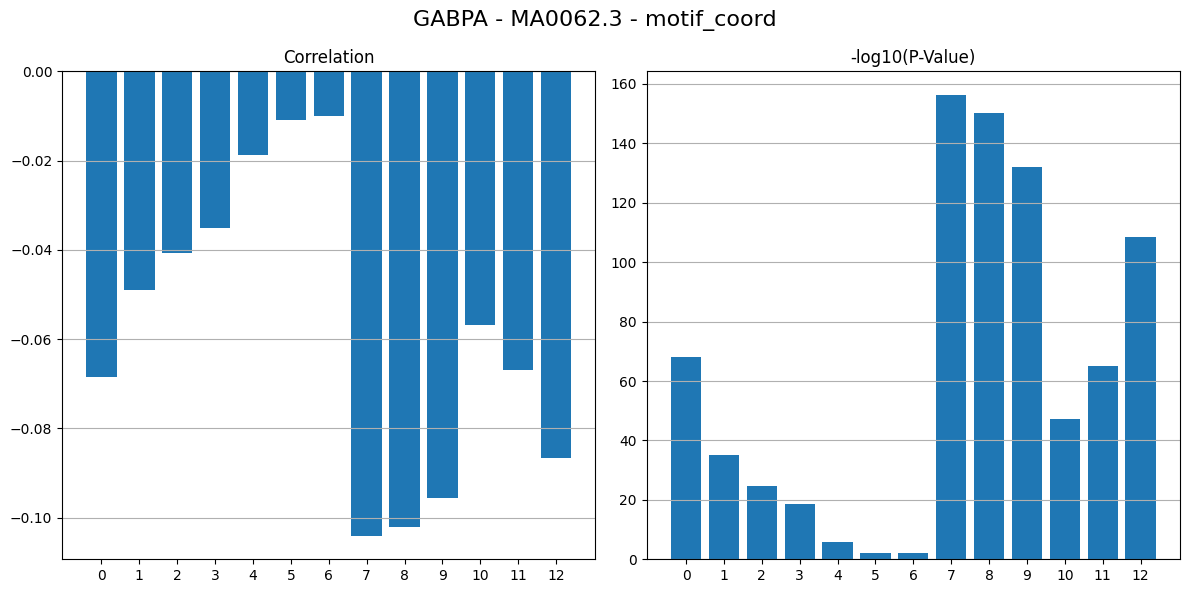

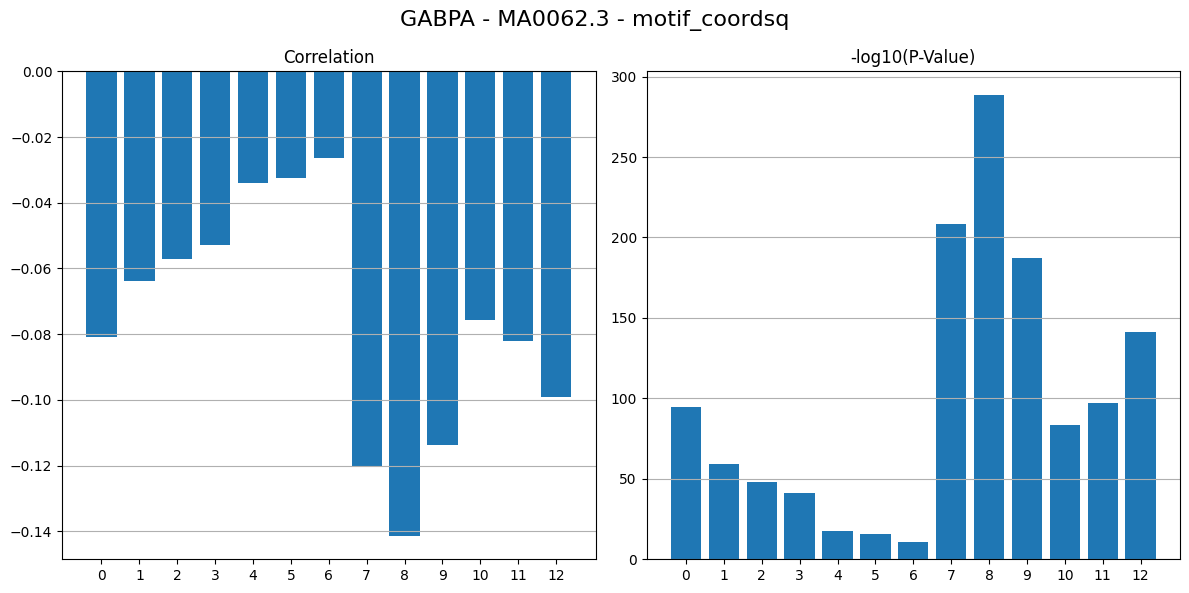

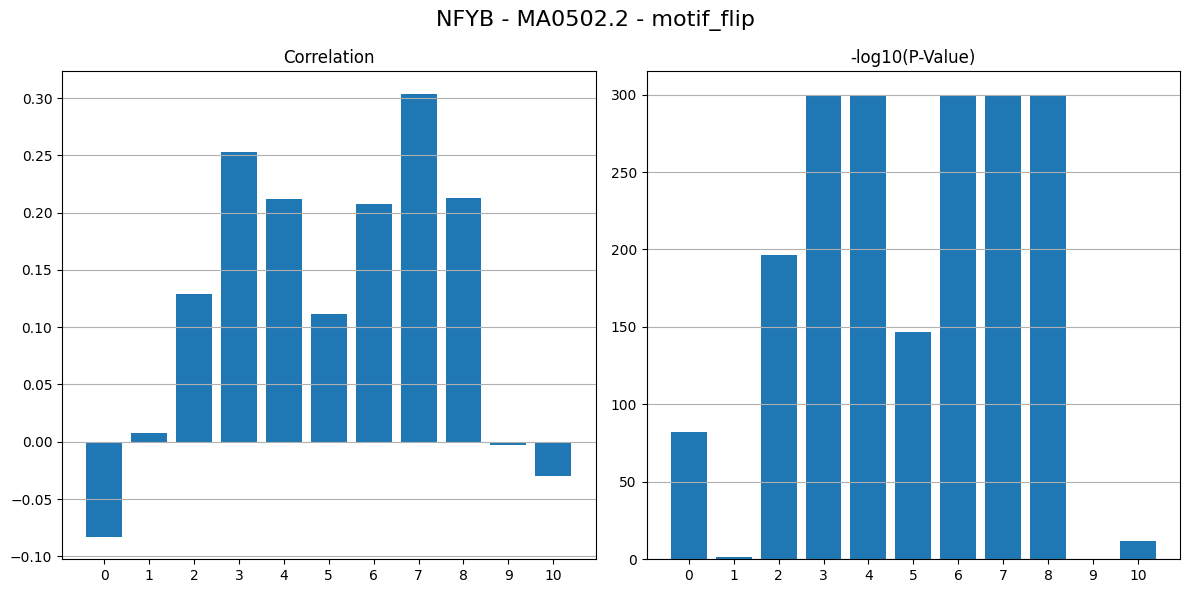

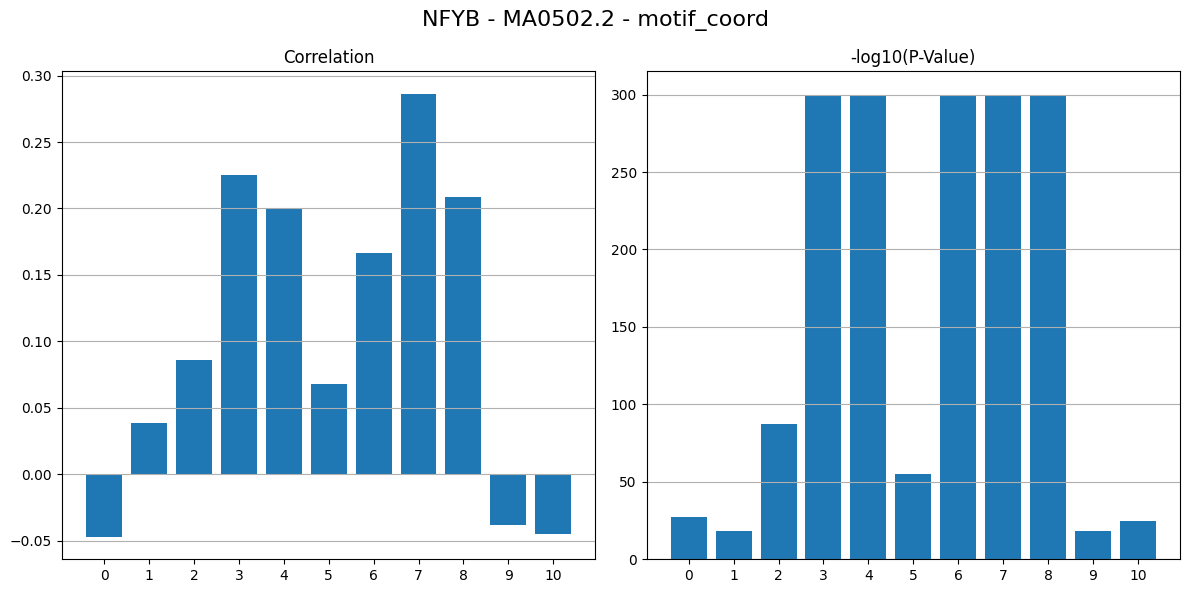

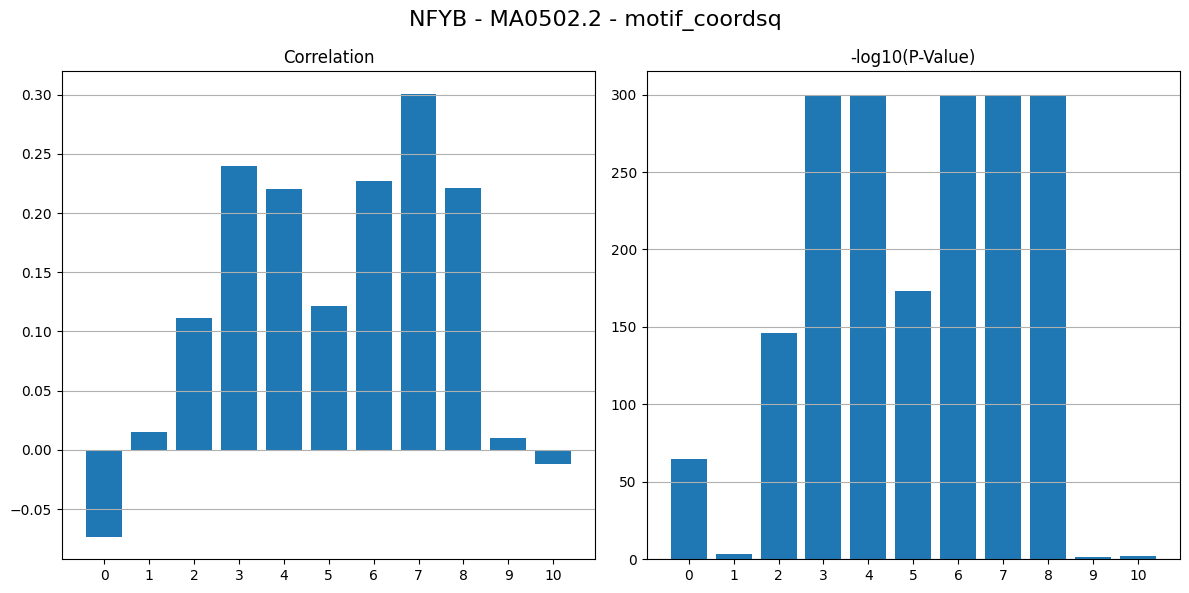

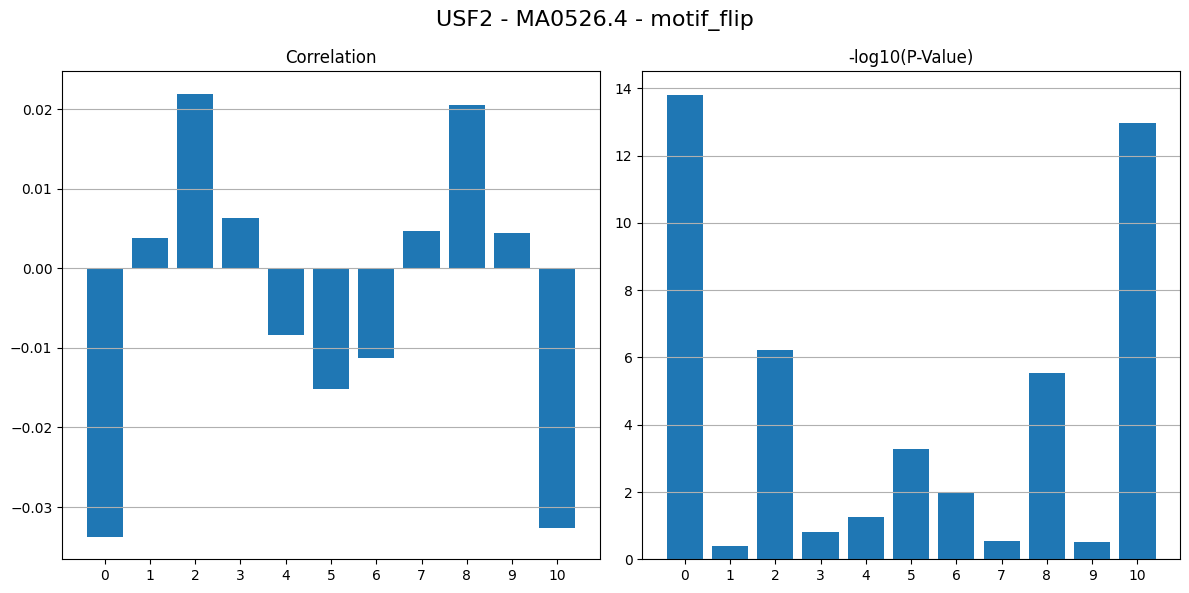

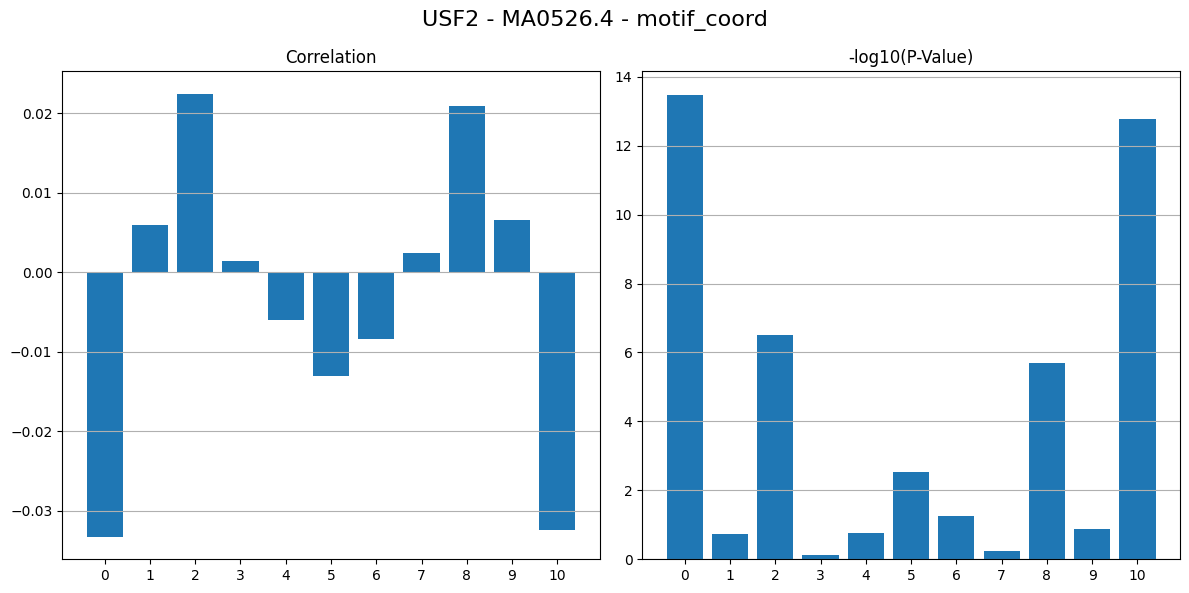

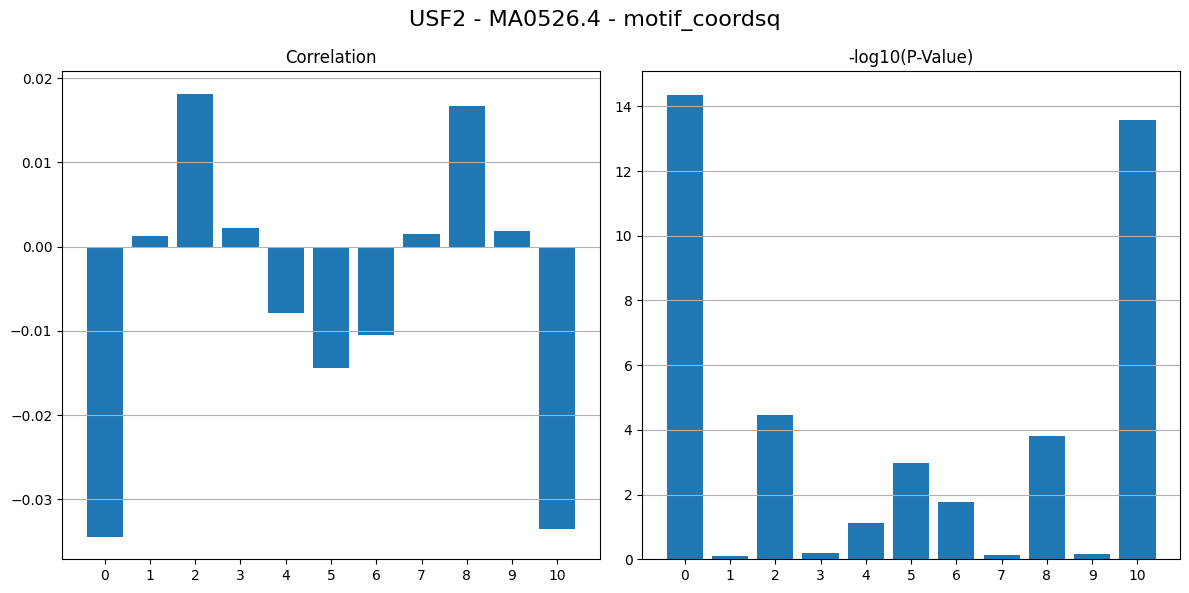

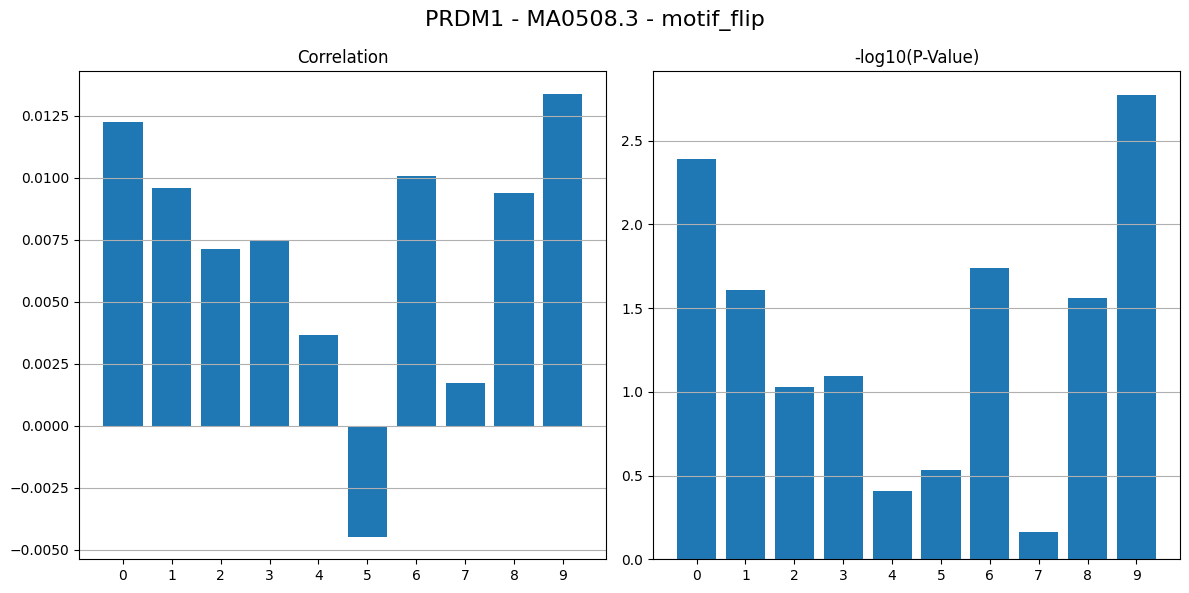

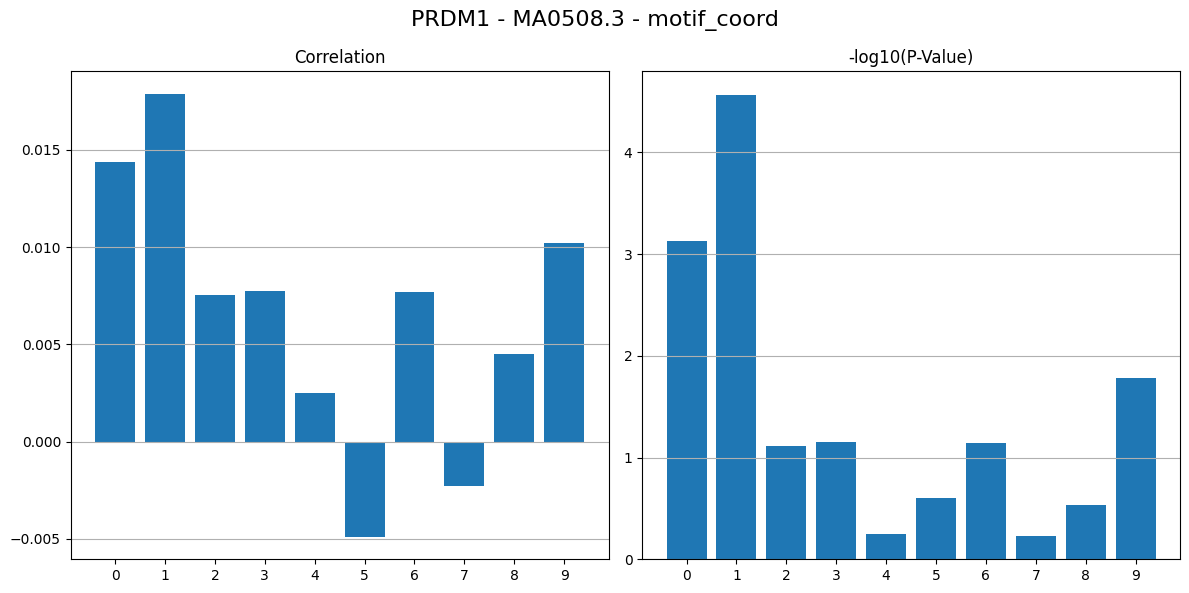

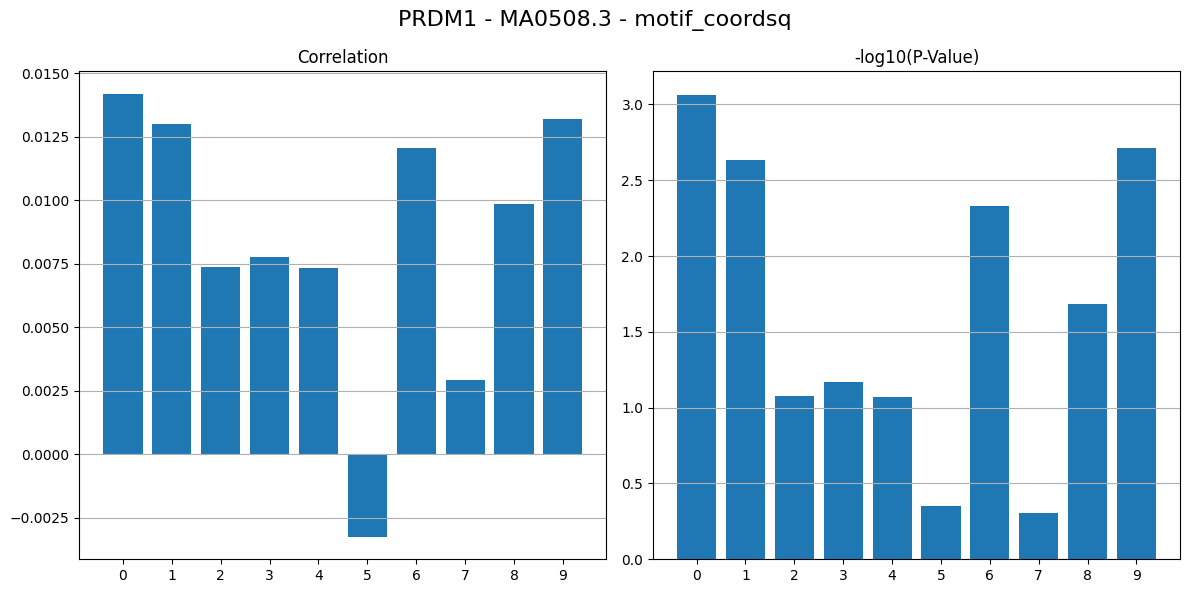

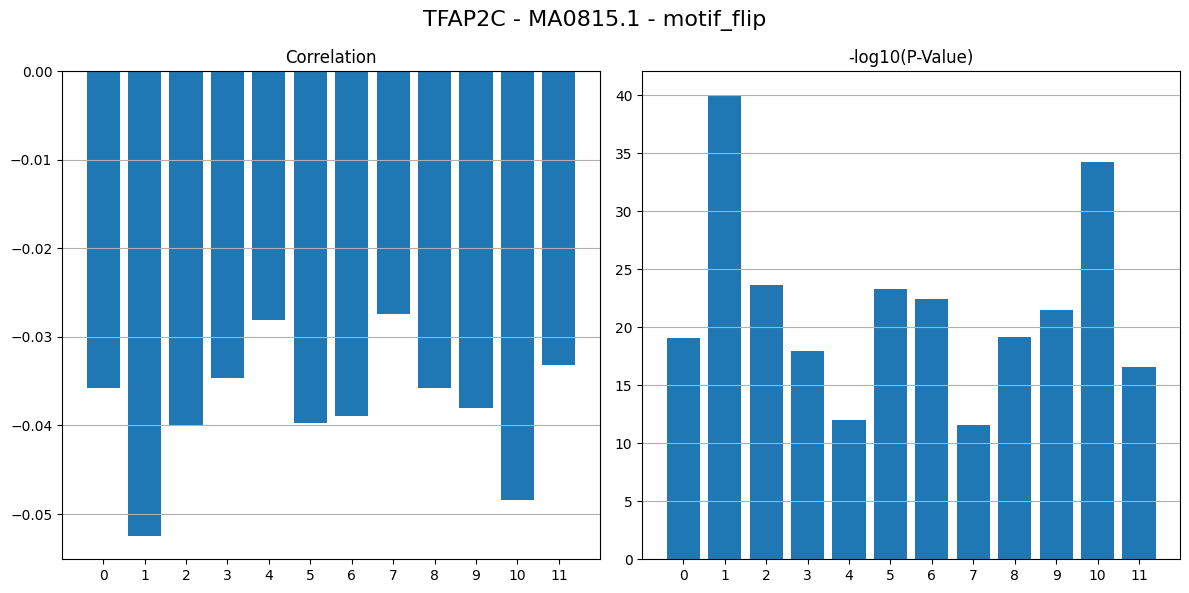

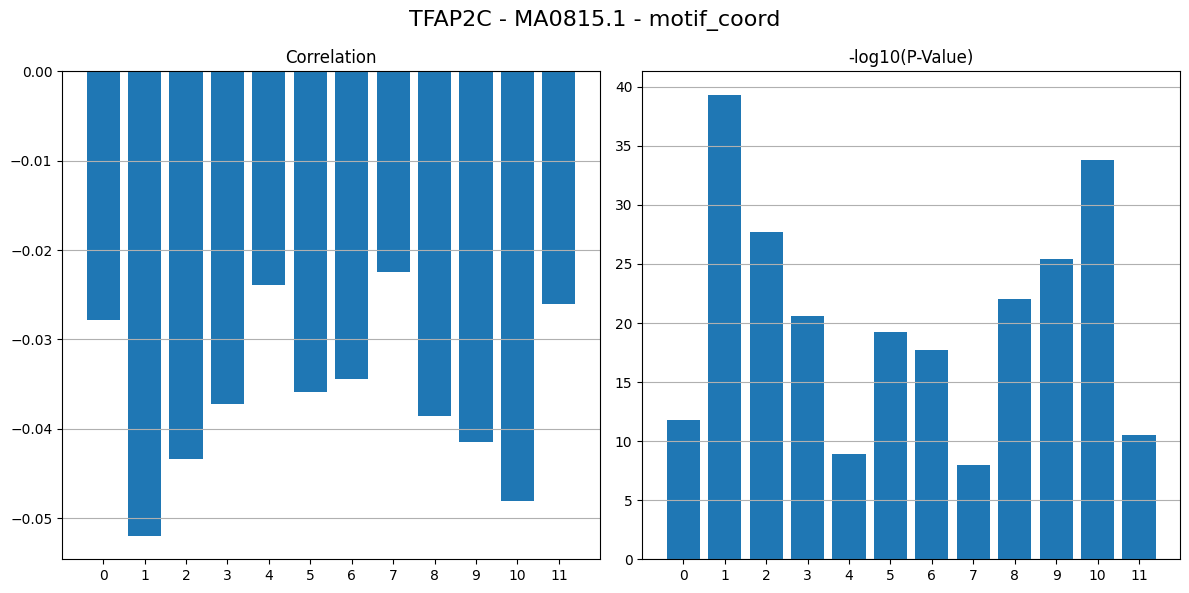

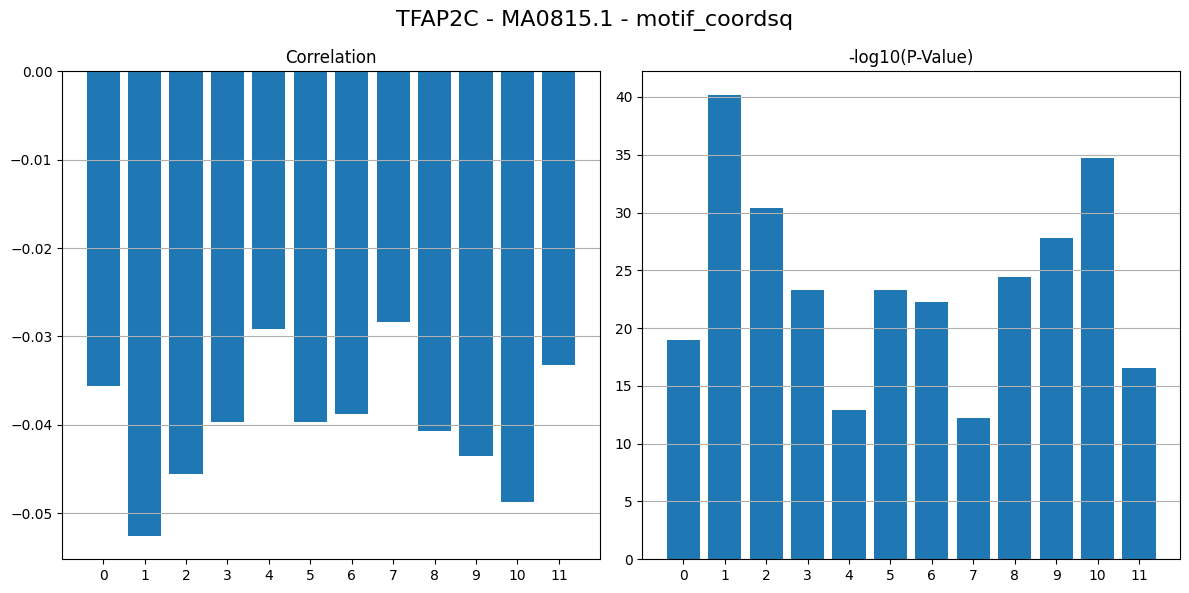

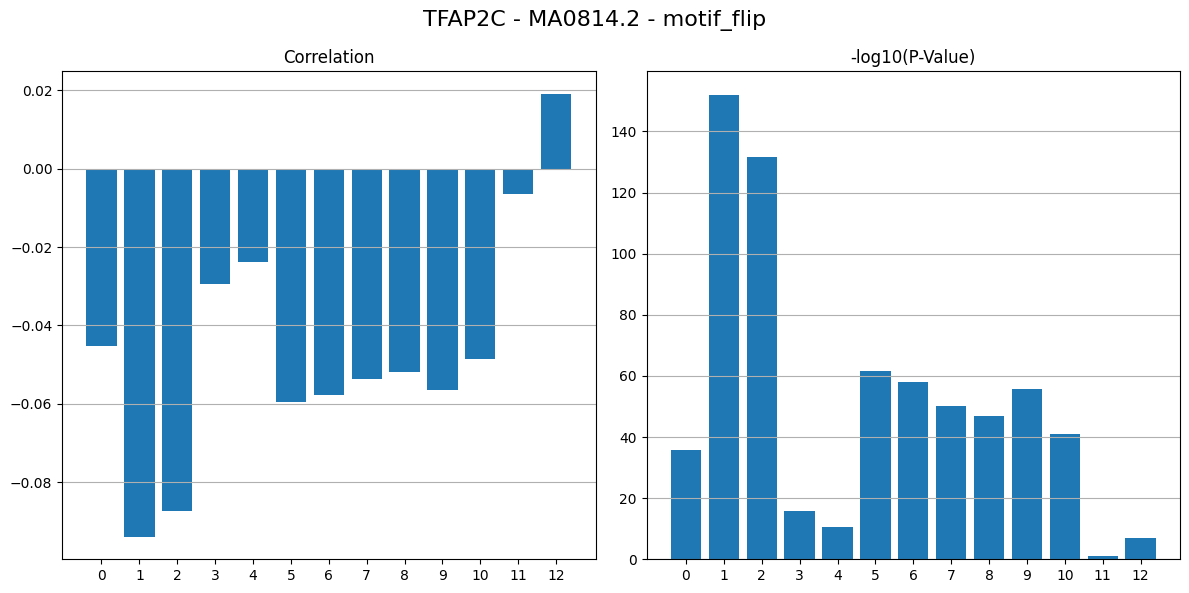

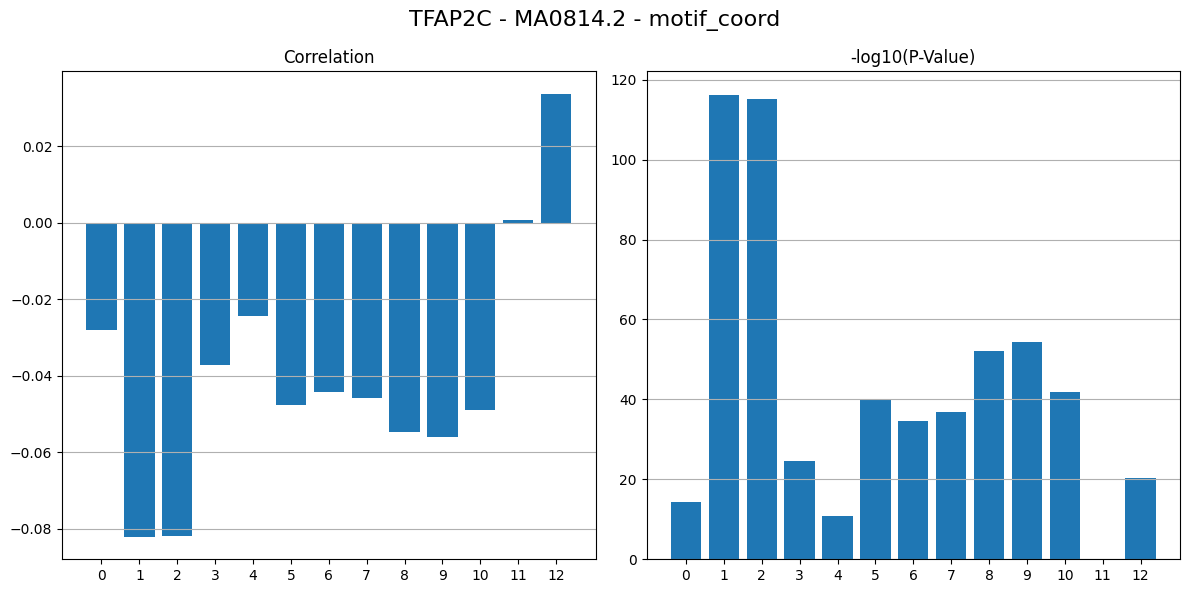

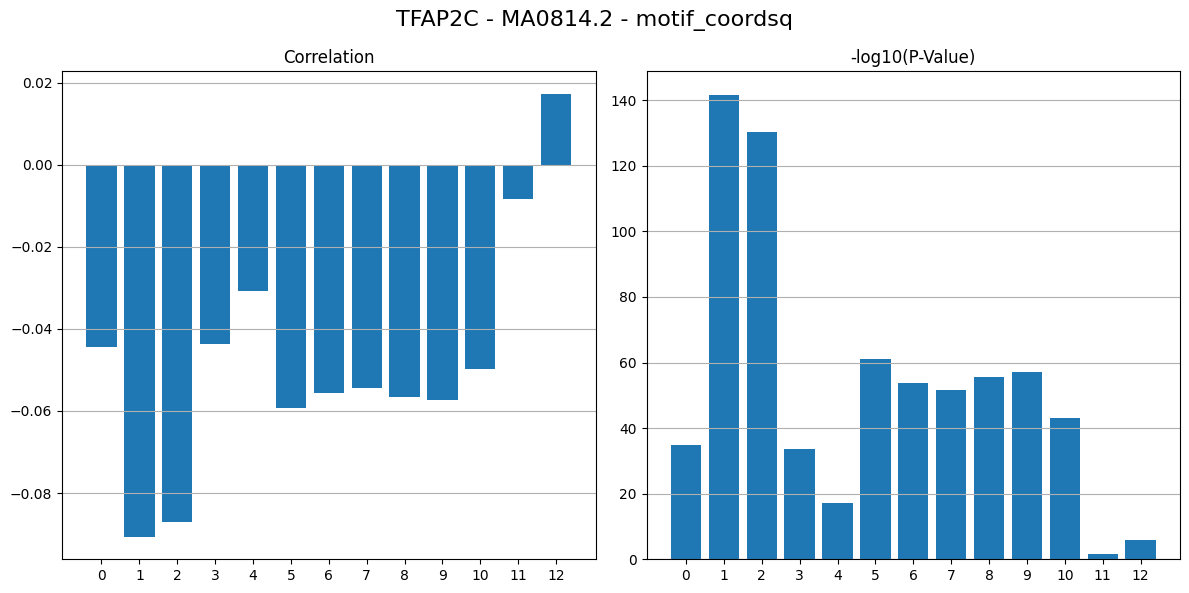

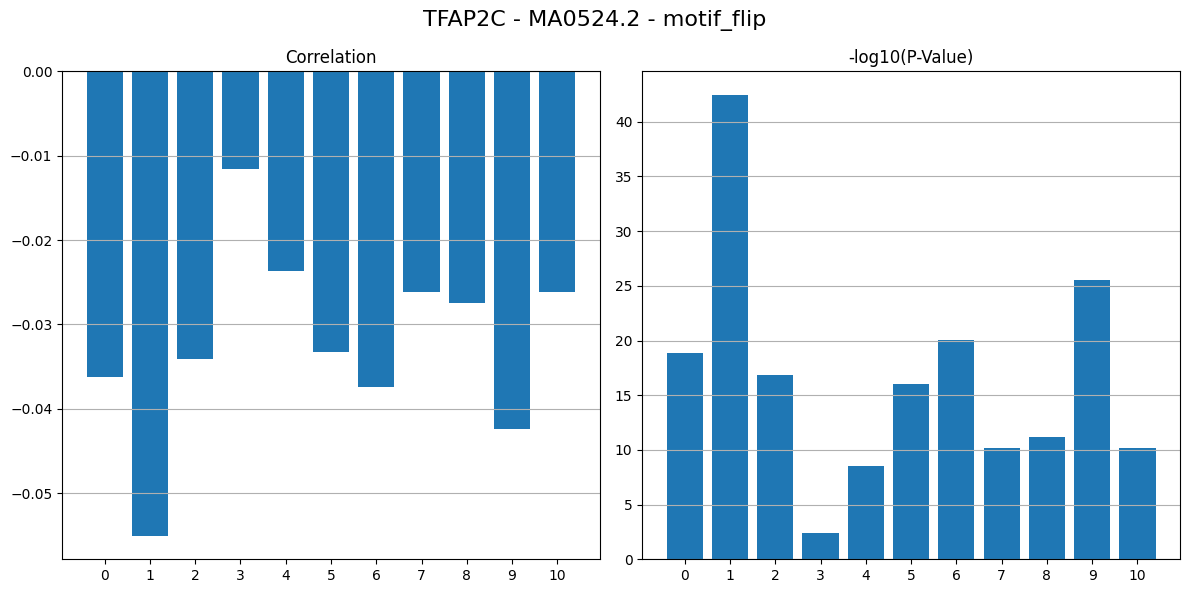

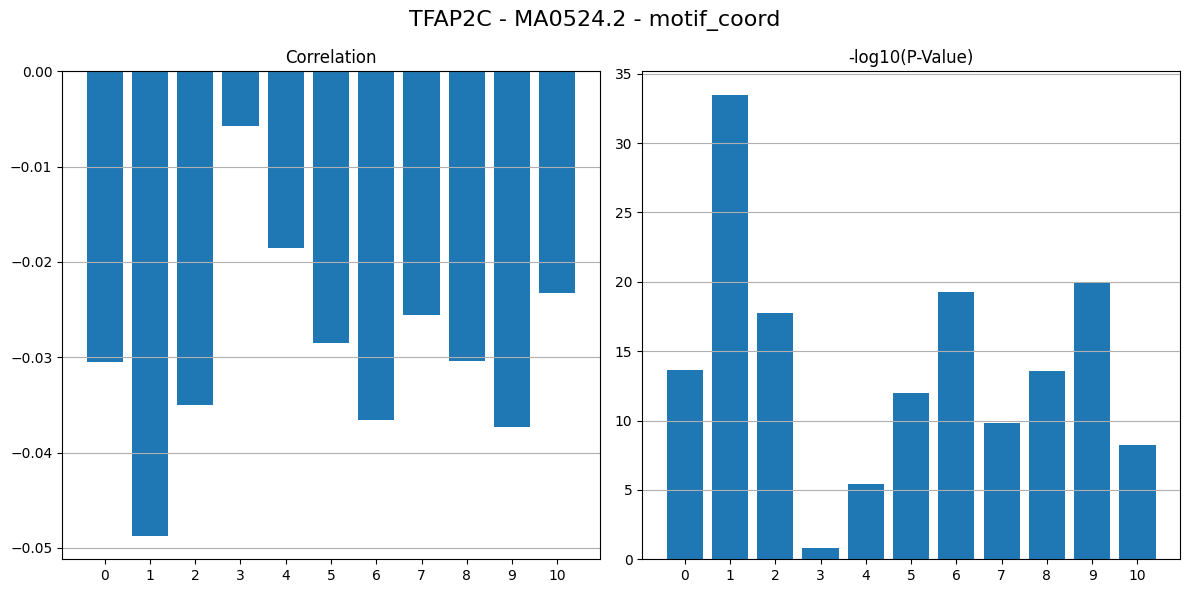

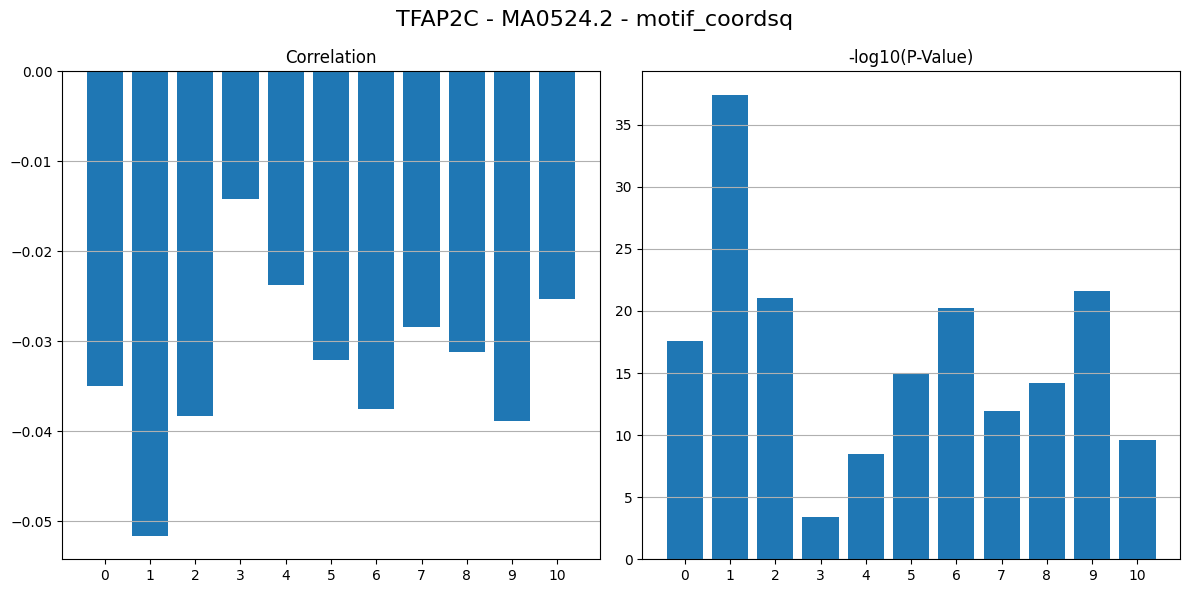

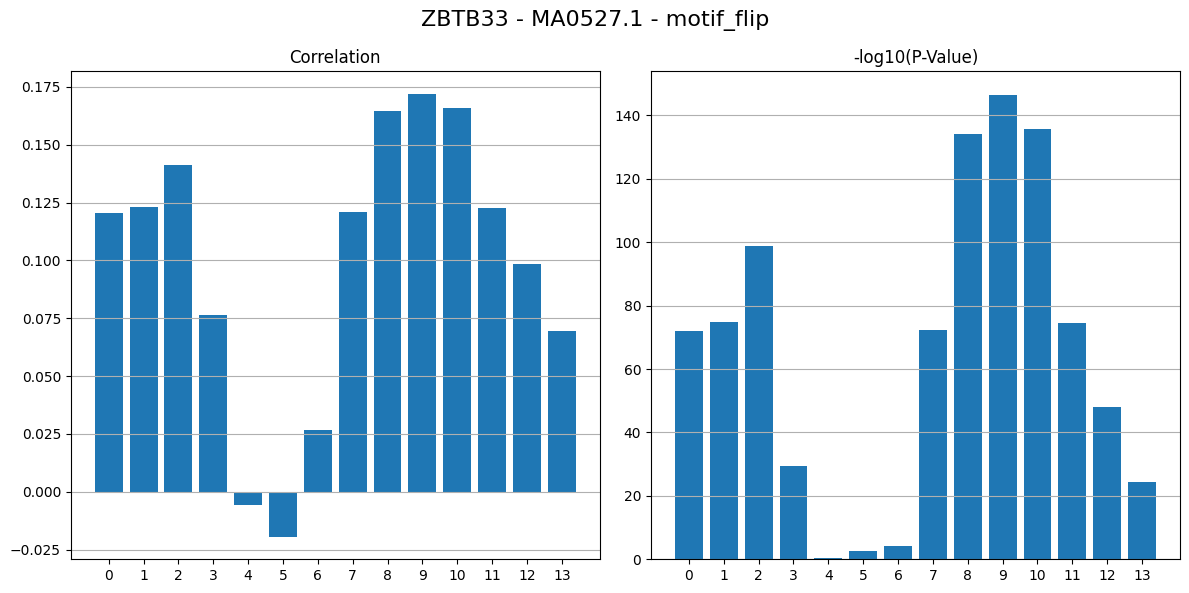

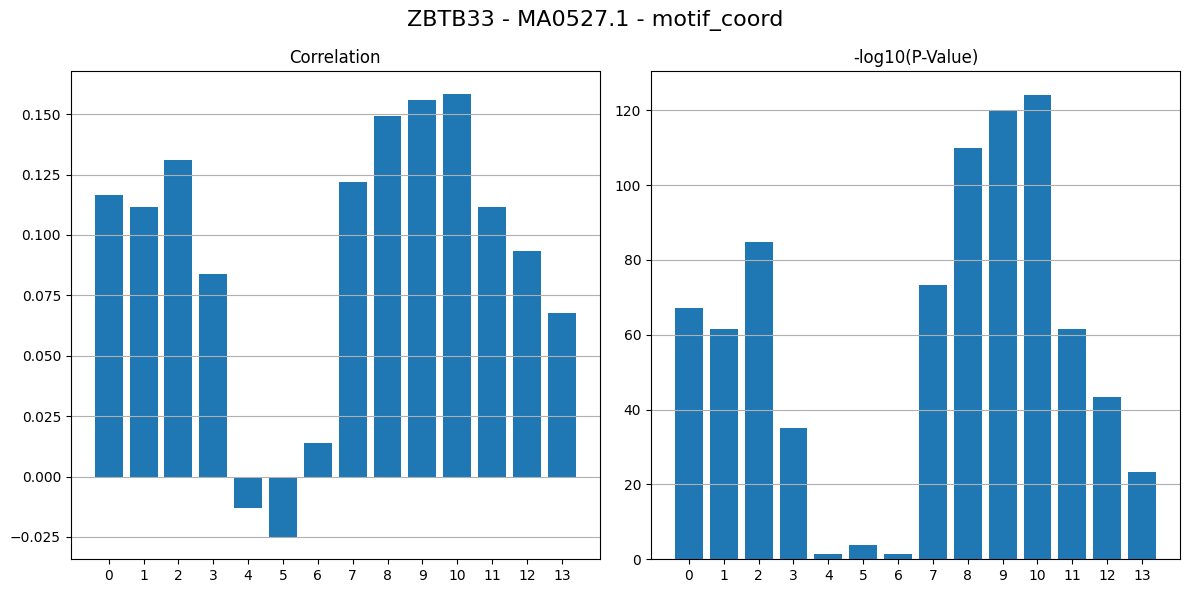

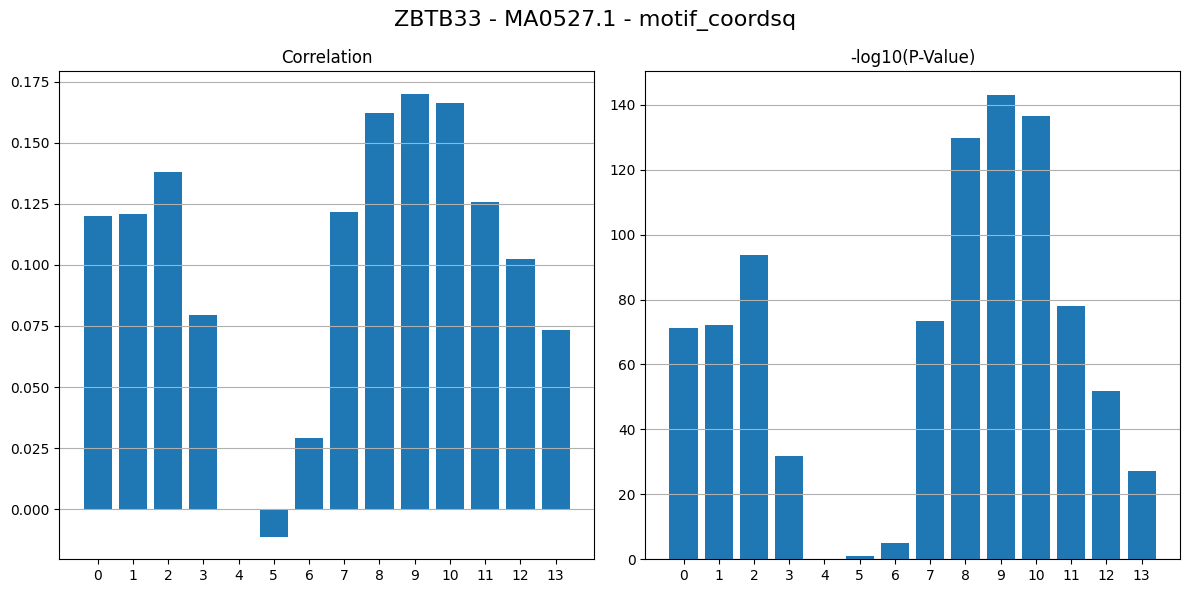

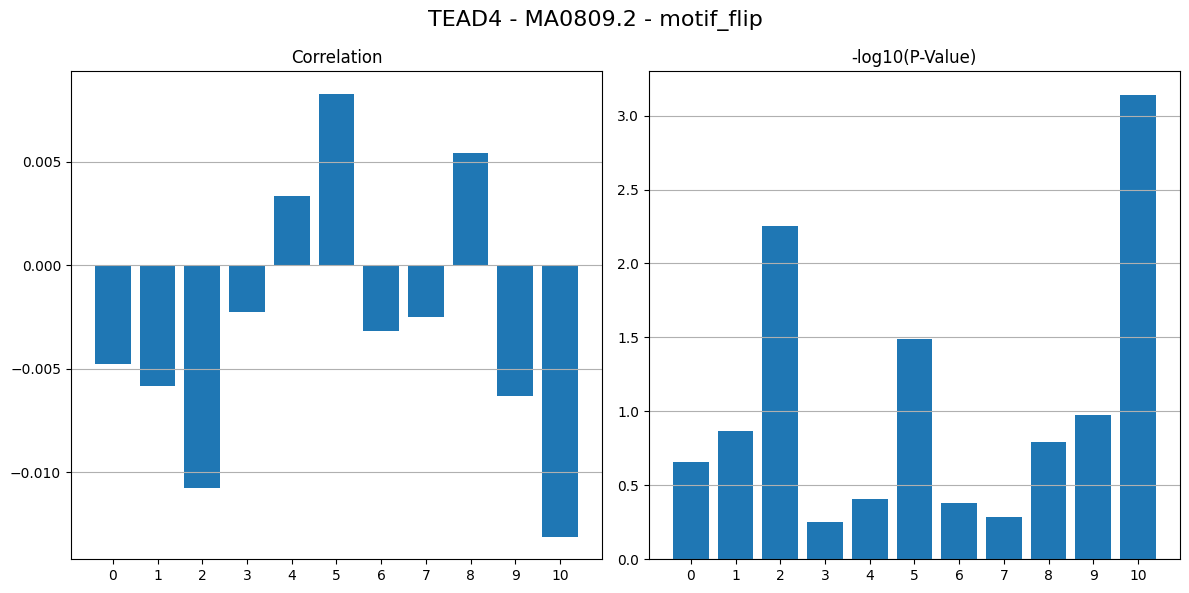

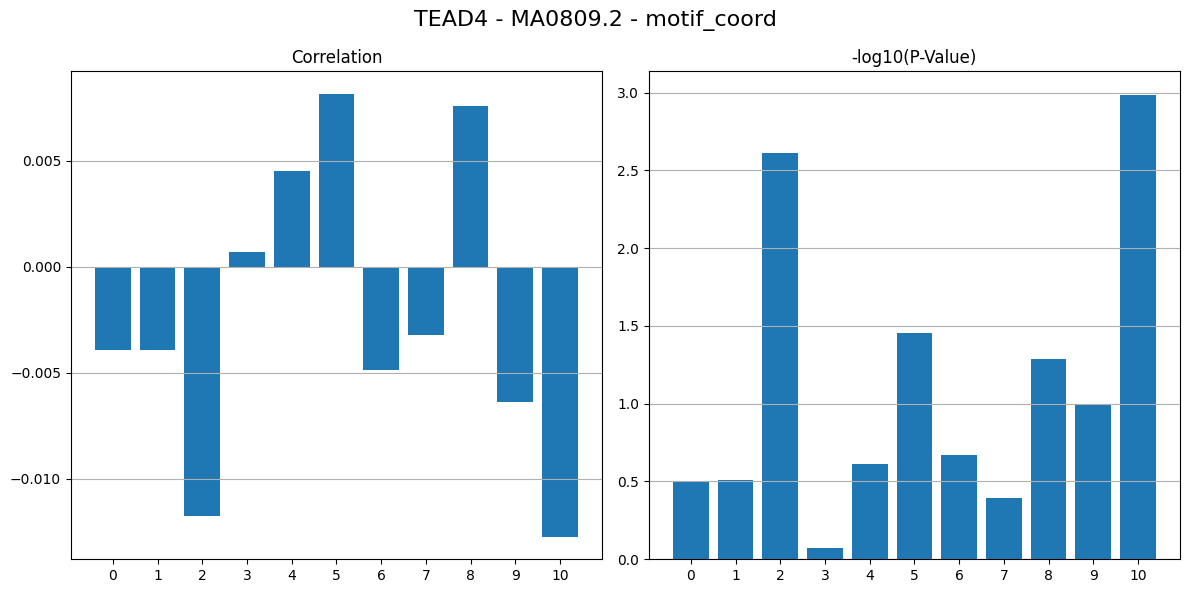

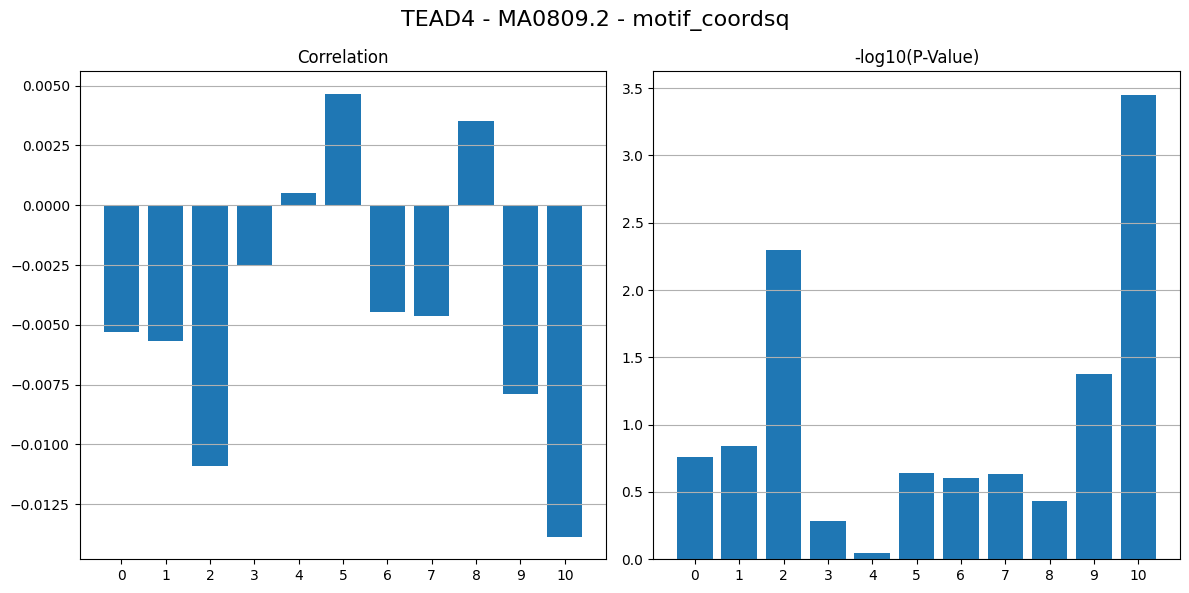

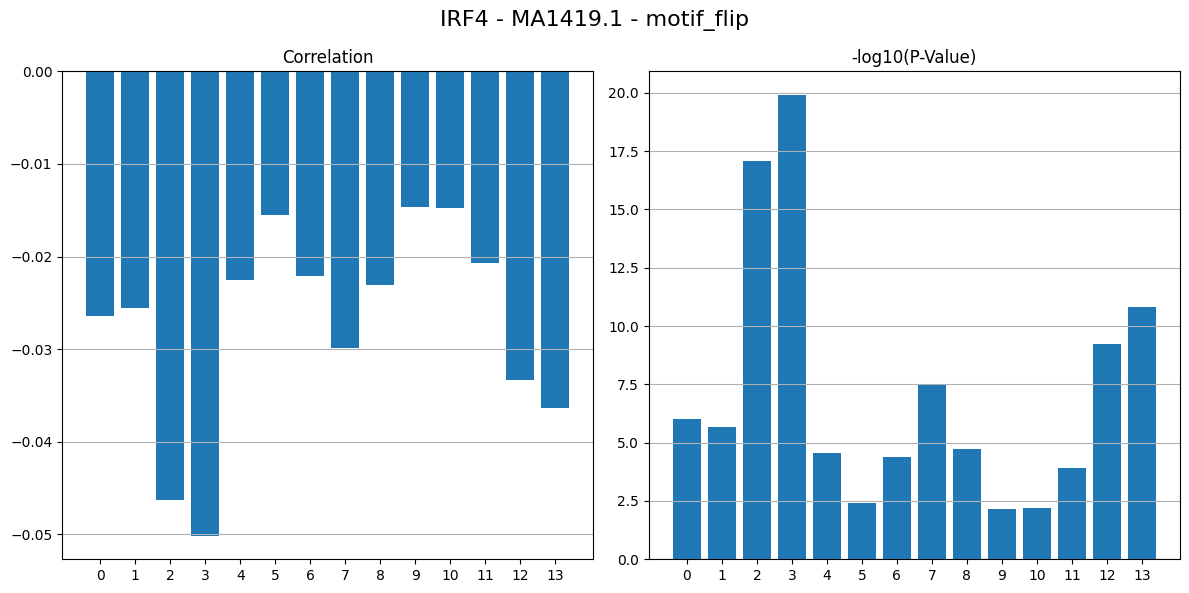

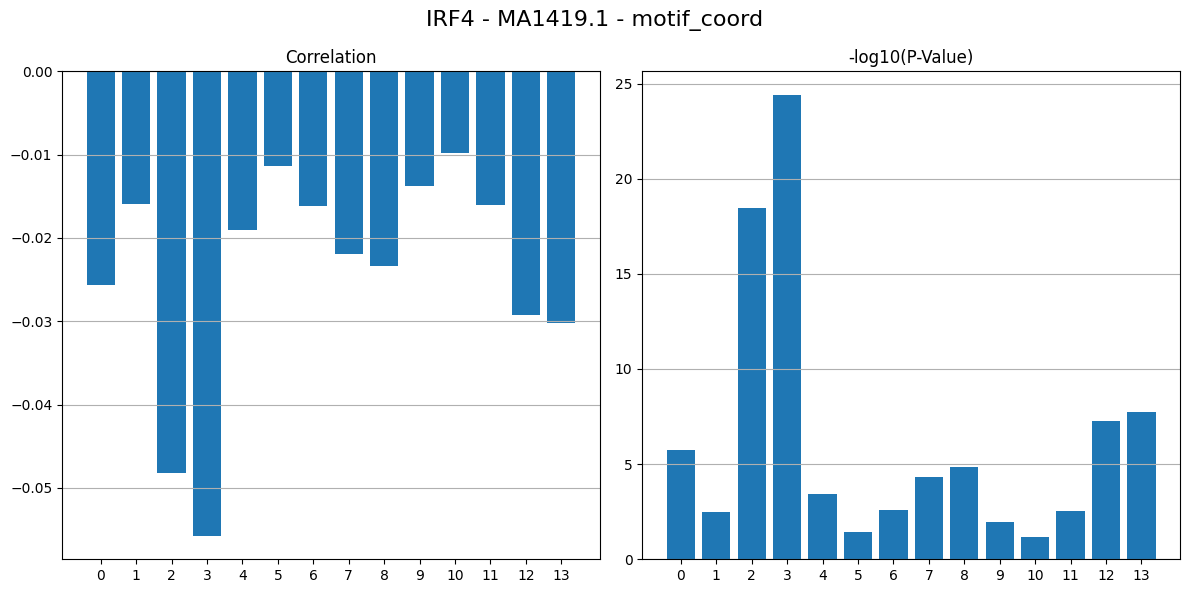

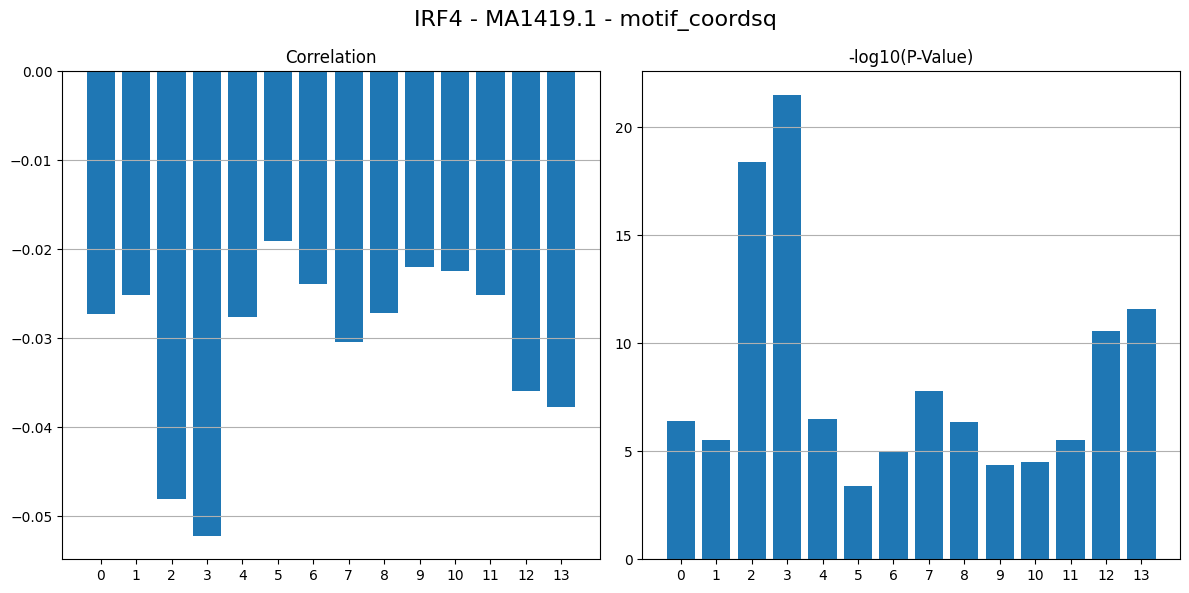

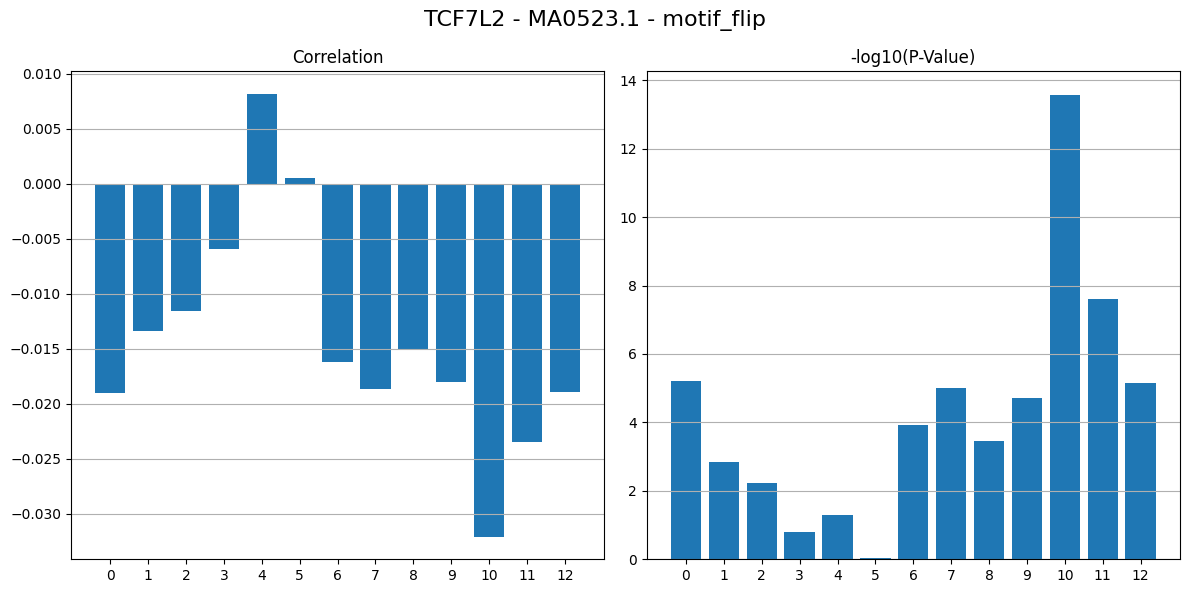

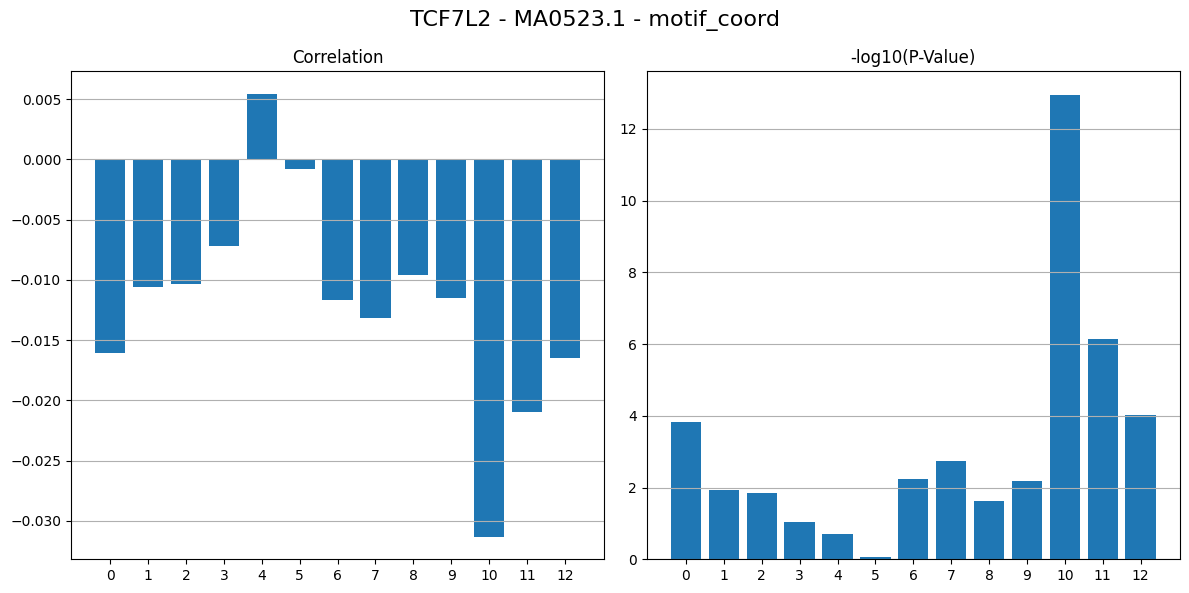

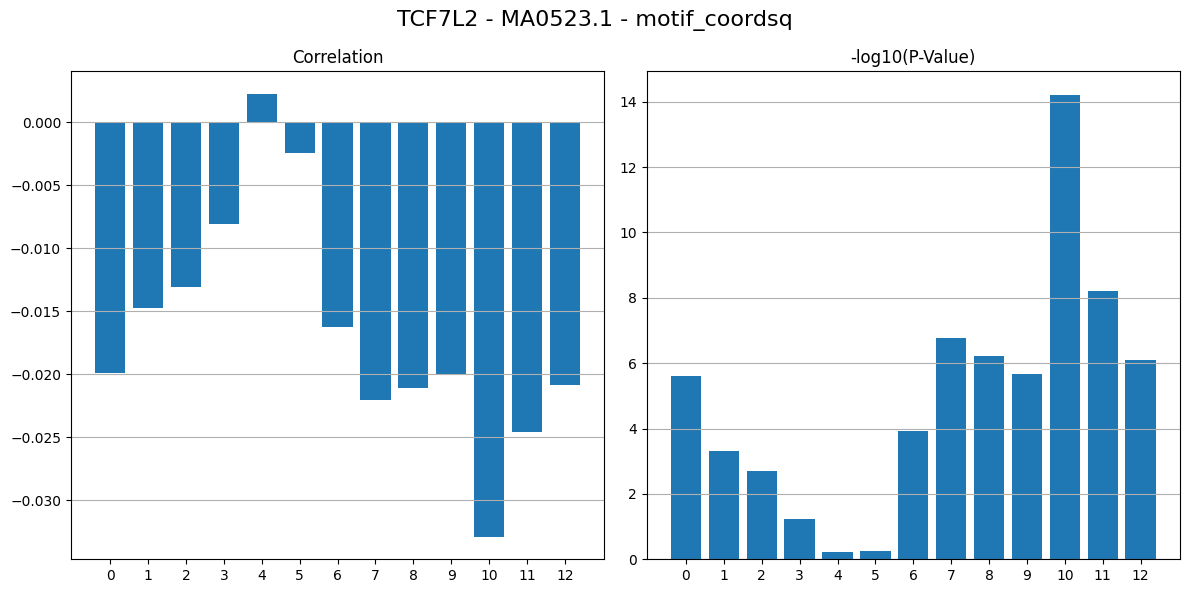

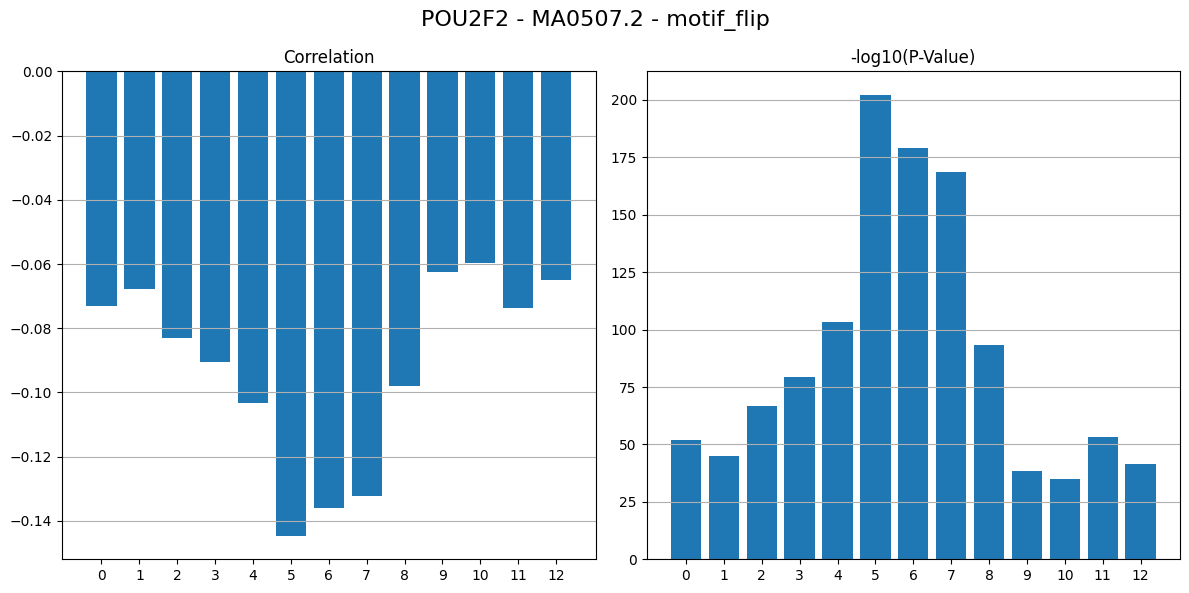

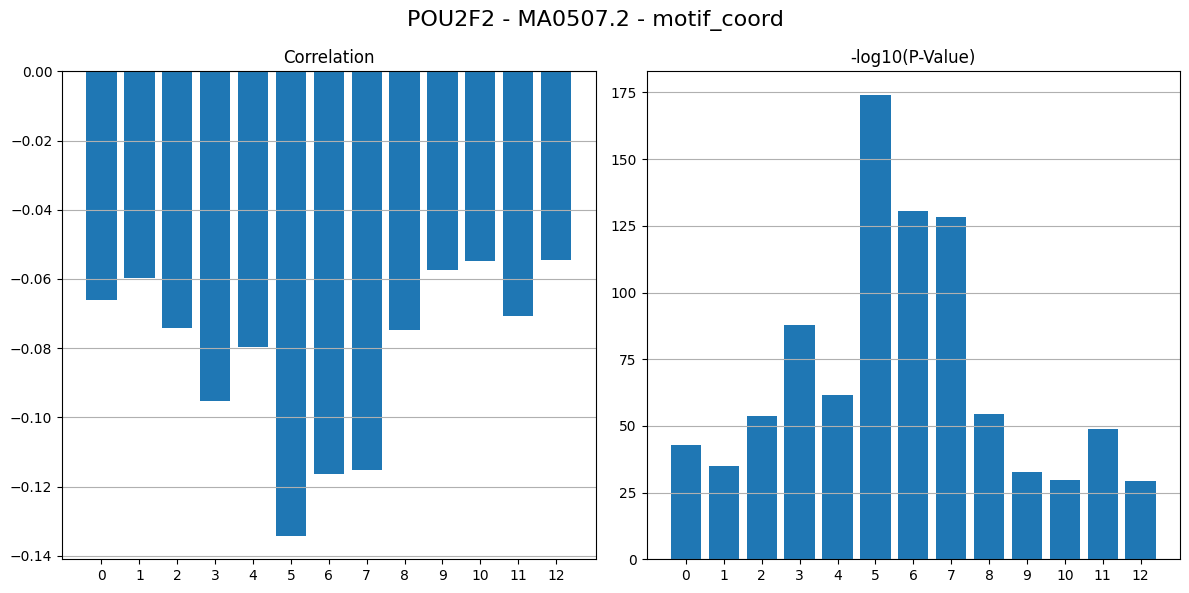

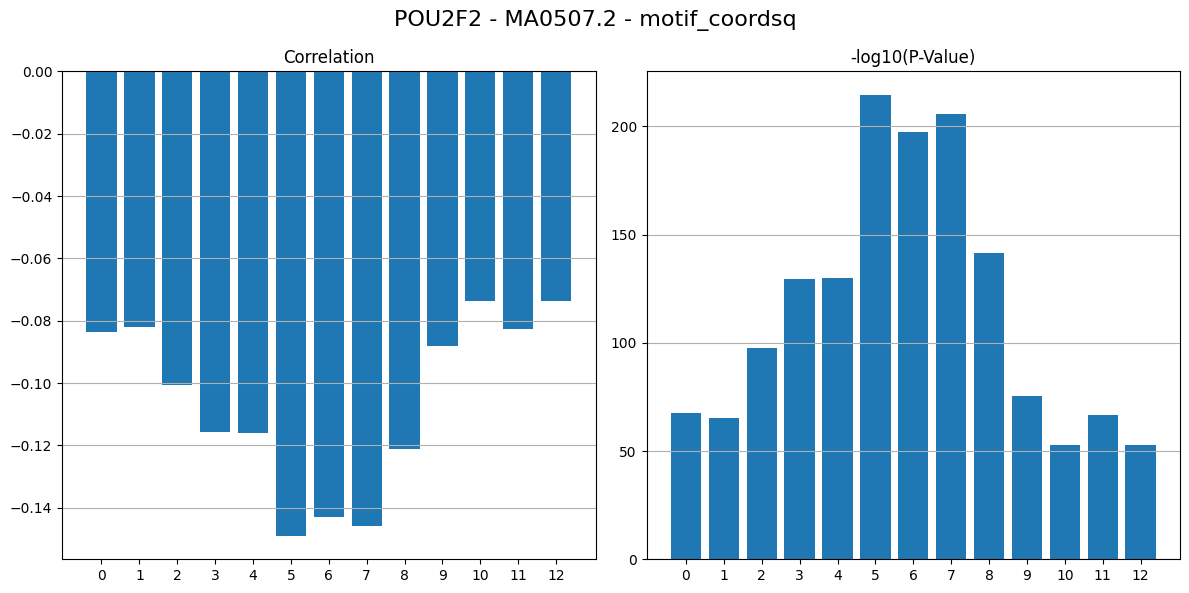

In [ ]:
for tf in positional_data.keys():
    for matrix_id in positional_data[tf].keys():
        length = len(positional_data[tf][matrix_id])
        # make a bargraph for each feature, showing the correlation coefficient and p-value for each position in the motif
        for feature in ['motif_flip', 'motif_coord', 'motif_coordsq']:
            bar_graph = {}
            for i in range(length):
                bar_graph[i] = {
                    feature: {
                        'correlation': positional_data[tf][matrix_id][i][feature + '_corr'],
                        'p_value': positional_data[tf][matrix_id][i][feature + '_pval'],
                    }
                }
            positions = list(positional_data[tf][matrix_id].keys())
            correlations = [entry[feature]['correlation'] for entry in bar_graph.values()]
            p_values = [-np.log10(entry[feature]['p_value']) if entry[feature]['p_value'] != 0 else -np.log10(1e-300) for entry in bar_graph.values()]
            
            plt.figure(figsize=(12, 6))

            # add a super title
            plt.suptitle(f'{tf} - {matrix_id} - {feature}', fontsize=16)

            plt.subplot(121)
            plt.bar(positions, correlations)
            plt.title('Correlation')
            plt.grid(axis='y')
            plt.xticks(positions, positions)


            plt.subplot(122)
            plt.bar(positions, p_values)
            plt.title('-log10(P-Value)')
            plt.grid(axis='y')
            plt.xticks(positions, positions)

            plt.tight_layout()
            plt.show()

In [ ]:
# save the positional_data as a pickle file

with open('/scratch/midway3/waqaas/DNA-breathing/data/Chipseq_data/positional_data.pkl', 'wb') as f:
    pickle.dump(positional_data, f)

In [ ]:
pos_data1 = {}
pos_data2 = {}
counter = 0
for key, value in positional_data.items():
    if counter == 0:
        pos_data1[key] = value
        counter = 1
    else:
        pos_data2[key] = value
        counter = 0

In [ ]:
with open('/scratch/midway3/waqaas/DNA-breathing/data/Chipseq_data/positional_data1.pkl', 'wb') as f:
    pickle.dump(pos_data1, f)

In [ ]:
with open('/scratch/midway3/waqaas/DNA-breathing/data/Chipseq_data/positional_data2.pkl', 'wb') as f:
    pickle.dump(pos_data2, f)

In [ ]:
with open('/project2/xinhe/waqaas/DNA-breathing/data/Chipseq_data/positional_data.pkl', 'wb') as f:
    pickle.dump(positional_data, f)